# Autocorrelations

--------------------------------------------------------------------
### TODO:
* [x] Generate multiple chain lengths and deal with loading in from multiple `samples_history` files.
* [x] Implement the same logic for `observables` as for `samples_history`.
* [x] Modify remainder of code below to deal with case where `samples` and `observables` are dictionaries with keys specifying the length of the MCMC chain.
* [x] Re-run the cells below for the remainder of `HMC` directory to get ESS values for comparing against ESS from L2HMC.
* [x] Try training sampler for >> 1000 steps and running the trained sampler for a variety of different chain lengths to see what the integrated autocorrelation time approaches as  $N_{steps} \longrightarrow \infty$.
--------------------------------------------------------------------

## Imports

In [9]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from pandas.plotting import autocorrelation_plot
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [26]:
#from lattice.gauge_lattice import GaugeLattice
from lattice.lattice import GaugeLattice, u1_plaq_exact
from l2hmc_eager import gauge_dynamics_eager as gde
from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers
from utils.autocorr import *
from utils.gauge_observables import *
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [12]:
def check_else_make_dir(d):
    if not os.path.isdir(d):
        print(f"Making directory: {d}")
        os.makedirs(d)

In [13]:
def _plot_individual_observables(figs_dir, observables, top_charges_autocorr):
    multiple_lines_figs_axes = make_multiple_lines_plots(
        figs_dir,
        params['beta_final'],
        observables,
        top_charges_autocorr,
        legend=False
    )
    return multiple_lines_figs_axes

def _plot_individual_acf_iat(acf_arr, iat_arr, ess_arr, figs_dir):
    out_file = os.path.join(
        figs_dir, 
        'integrated_autocorrelation_time_plot.pdf'
    )
    kwargs = {
        'x_label': 'Lag',
        'y_label': 'Autocorrelation (top. charge)',
        'legend': True,
        'out_file': out_file
    }
    fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ess_arr, **kwargs)
    
    return fig, ax

## Using helpers from: `utils/gauge_observables.py`

In [14]:
log_dir = (
    '../../gauge_logs_graph/run_48/'
)

calc_observables_generate_plots(log_dir)

Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/mpl_autocorr_dir.
Making directory: ../../gauge_logs_graph/run_48/figures/autocorrelation_plots/pandas_autocorr_plots.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_10000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_48/samples_history/samples_history_5000.pkl.
Loading observables from ../../gauge_logs_graph/run_48/observables/observables_200.pkl.
Loading observables from ../../gauge_logs_graph/run_48/observables/observables_100.pkl.
Loading observabl

AttributeError: 'dict' object has no attribute 'shape'

In [7]:
root_dir = ('../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/')
log_dirs = [
    root_dir + d for d in os.listdir(root_dir) 
    if os.path.isdir(os.path.join(root_dir, d))
]
log_dirs

['../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_41',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_61',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_28',
 '../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_45']

Loading samples from: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_52/run_info/samples_history.pkl.
step: 0 time/step: 0.3443 avg action:  1841  avg plaquette: 0.1012 top charges: 


[0, -1, 7, 3]


step: 1 time/step: 0.3184 avg action:  1839  avg plaquette: 0.1022 top charges: 


[0, -1, 6, 3]


step: 2 time/step: 0.2931 avg action:  1836  avg plaquette: 0.1035 top charges: 


[1, -1, 7, 2]


step: 3 time/step: 0.4451 avg action:  1833  avg plaquette: 0.1047 top charges: 


[1, -1, 7, 5]


step: 4 time/step: 0.2902 avg action:  1831  avg plaquette: 0.1061 top charges: 


[1, -2, 7, 5]


step: 5 time/step: 0.3017 avg action:  1828  avg plaquette: 0.1073 top charges: 


[1, -3, 7, 6]


step: 6 time/step: 0.2606 avg action:  1827  avg plaquette: 0.108  top charges: 


[0, -3, 7, 5]


step: 7 time/step: 0.4225 avg action:  1823  avg plaquette: 0.1097 top charges: 


[0, -2, 7, 6]


step: 8 time/step: 0.3171 avg action:  1821  avg plaquette: 0.111  top charges: 


[-1, 

step: 81 time/step: 0.3943 avg action:  1665  avg plaquette: 0.187  top charges: 


[1, -3, 7, 5]


step: 82 time/step: 0.4237 avg action:  1663  avg plaquette: 0.1878 top charges: 


[-1, -3, 8, 3]


step: 83 time/step: 0.3134 avg action:  1661  avg plaquette: 0.1889 top charges: 


[-1, -4, 7, 3]


step: 84 time/step: 0.3225 avg action:  1661  avg plaquette: 0.1892 top charges: 


[-1, -3, 8, 2]


step: 85 time/step: 0.6951 avg action:  1659  avg plaquette: 0.1897 top charges: 


[0, -1, 7, 2]


step: 86 time/step: 0.3388 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 7, 3]


step: 87 time/step: 0.3266 avg action:  1657  avg plaquette: 0.1911 top charges: 


[0, -2, 8, 3]


step: 88 time/step: 0.342  avg action:  1652  avg plaquette: 0.1934 top charges: 


[0, -1, 8, 1]


step: 89 time/step: 0.6216 avg action:  1650  avg plaquette: 0.1944 top charges: 


[0, 0, 8, 1]


step: 90 time/step: 0.3111 avg action:  1650  avg plaquette: 0.1945 top charges: 


[0, -1, 6, 2]


step: 162 time/step: 0.2772 avg action:  1496  avg plaquette: 0.2694 top charges: 


[0, -2, 8, 6]


step: 163 time/step: 0.2705 avg action:  1494  avg plaquette: 0.2704 top charges: 


[0, -1, 6, 4]


step: 164 time/step: 0.3594 avg action:  1492  avg plaquette: 0.2713 top charges: 


[0, -1, 6, 5]


step: 165 time/step: 0.406  avg action:  1491  avg plaquette: 0.2718 top charges: 


[0, -1, 6, 5]


step: 166 time/step: 0.3173 avg action:  1491  avg plaquette: 0.2719 top charges: 


[-1, -1, 6, 5]


step: 167 time/step: 0.2714 avg action:  1489  avg plaquette: 0.273  top charges: 


[0, 0, 7, 3]


step: 168 time/step: 0.3019 avg action:  1487  avg plaquette: 0.274  top charges: 


[1, -1, 6, 5]


step: 169 time/step: 0.3015 avg action:  1485  avg plaquette: 0.275  top charges: 


[0, -1, 6, 3]


step: 170 time/step: 0.3049 avg action:  1484  avg plaquette: 0.2752 top charges: 


[1, -1, 5, 5]


step: 171 time/step: 0.2955 avg action:  1482  avg plaquette: 0.2763 top charges: 


[0, -1

step: 243 time/step: 0.2595 avg action:  1357  avg plaquette: 0.3376 top charges: 


[-1, -2, 5, 2]


step: 244 time/step: 0.2825 avg action:  1355  avg plaquette: 0.3385 top charges: 


[0, -2, 5, 3]


step: 245 time/step: 0.4293 avg action:  1353  avg plaquette: 0.3392 top charges: 


[0, -1, 4, 3]


step: 246 time/step: 0.3402 avg action:  1353  avg plaquette: 0.3394 top charges: 


[0, 0, 4, 3]


step: 247 time/step: 0.321  avg action:  1351  avg plaquette: 0.3402 top charges: 


[-2, 0, 5, 2]


step: 248 time/step: 0.3038 avg action:  1348  avg plaquette: 0.3417 top charges: 


[0, 0, 6, 2]


step: 249 time/step: 0.3127 avg action:  1347  avg plaquette: 0.3424 top charges: 


[-1, 0, 5, 2]


step: 250 time/step: 0.3168 avg action:  1345  avg plaquette: 0.3435 top charges: 


[0, 0, 6, 3]


step: 251 time/step: 0.2826 avg action:  1345  avg plaquette: 0.3434 top charges: 


[2, -1, 6, 3]


step: 252 time/step: 0.3682 avg action:  1343  avg plaquette: 0.3441 top charges: 


[1, -2, 

step: 325 time/step: 0.3188 avg action:  1222  avg plaquette: 0.4034 top charges: 


[1, -2, 6, 2]


step: 326 time/step: 0.3534 avg action:  1220  avg plaquette: 0.4041 top charges: 


[3, -3, 5, 2]


step: 327 time/step: 0.4412 avg action:  1220  avg plaquette: 0.4044 top charges: 


[1, -1, 6, 2]


step: 328 time/step: 0.3114 avg action:  1220  avg plaquette: 0.4043 top charges: 


[2, -2, 6, 3]


step: 329 time/step: 0.2625 avg action:  1219  avg plaquette: 0.4046 top charges: 


[1, -3, 5, 3]


step: 330 time/step: 0.2957 avg action:  1217  avg plaquette: 0.4058 top charges: 


[1, -3, 6, 3]


step: 331 time/step: 0.296  avg action:  1215  avg plaquette: 0.4069 top charges: 


[1, -2, 5, 3]


step: 332 time/step: 0.2949 avg action:  1213  avg plaquette: 0.4078 top charges: 


[2, -3, 5, 2]


step: 333 time/step: 0.2891 avg action:  1212  avg plaquette: 0.4081 top charges: 


[2, -4, 6, 2]


step: 334 time/step: 0.3017 avg action:  1211  avg plaquette: 0.4085 top charges: 


[2, -3

step: 407 time/step: 0.3744 avg action:  1118  avg plaquette: 0.4539 top charges: 


[0, -4, 7, 3]


step: 408 time/step: 0.3061 avg action:  1116  avg plaquette: 0.4551 top charges: 


[1, -4, 6, 3]


step: 409 time/step: 0.2906 avg action:  1114  avg plaquette: 0.456  top charges: 


[0, -5, 7, 3]


step: 410 time/step: 0.3402 avg action:  1114  avg plaquette: 0.4562 top charges: 


[0, -5, 7, 2]


step: 411 time/step: 0.4257 avg action:  1113  avg plaquette: 0.4565 top charges: 


[1, -4, 6, 2]


step: 412 time/step: 0.3159 avg action:  1113  avg plaquette: 0.4568 top charges: 


[1, -4, 6, 0]


step: 413 time/step: 0.3068 avg action:  1111  avg plaquette: 0.4573 top charges: 


[2, -4, 7, 0]


step: 414 time/step: 0.3068 avg action:  1109  avg plaquette: 0.4585 top charges: 


[1, -4, 6, 0]


step: 415 time/step: 0.3032 avg action:  1108  avg plaquette: 0.459  top charges: 


[0, -4, 6, 1]


step: 416 time/step: 0.2746 avg action:  1106  avg plaquette: 0.4597 top charges: 


[0, -3

step: 489 time/step: 0.3588 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -3, 4, 0]


step: 490 time/step: 0.4394 avg action:  1017  avg plaquette: 0.5034 top charges: 


[-1, -2, 4, 0]


step: 491 time/step: 0.3159 avg action:  1016  avg plaquette: 0.5038 top charges: 


[0, -3, 3, 0]


step: 492 time/step: 0.4605 avg action:  1016  avg plaquette: 0.5037 top charges: 


[0, -2, 4, 0]


step: 493 time/step: 0.3946 avg action:  1015  avg plaquette: 0.5045 top charges: 


[0, -2, 3, 0]


step: 494 time/step: 0.3997 avg action:  1013  avg plaquette: 0.5052 top charges: 


[0, -1, 4, 0]


step: 495 time/step: 0.2888 avg action:  1014  avg plaquette: 0.505  top charges: 


[0, -2, 3, 0]


step: 496 time/step: 0.5068 avg action:  1011  avg plaquette: 0.5064 top charges: 


[0, -1, 4, 0]


step: 497 time/step: 0.5274 avg action:  1011  avg plaquette: 0.5066 top charges: 


[0, -1, 4, 0]


step: 498 time/step: 0.3577 avg action:  1010  avg plaquette: 0.5071 top charges: 


[0, -

step: 38 time/step: 0.4471 avg action: 145.4  avg plaquette: 0.929  top charges: 


[-1, 0, 4, 1]


step: 39 time/step: 0.4291 avg action: 133.9  avg plaquette: 0.9346 top charges: 


[0, -1, 5, 1]


step: 40 time/step: 0.2945 avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, -1, 4, 1]


step: 41 time/step: 0.4297 avg action: 145.3  avg plaquette: 0.9291 top charges: 


[-1, -1, 4, 1]


step: 42 time/step: 0.3212 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, 0, 5, 1]


step: 43 time/step: 0.4759 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, -1, 5, 1]


step: 44 time/step: 0.6041 avg action: 130.8  avg plaquette: 0.9361 top charges: 


[-1, -1, 4, 2]


step: 45 time/step: 0.2958 avg action: 142.5  avg plaquette: 0.9304 top charges: 


[-1, -1, 4, 1]


step: 46 time/step: 0.2801 avg action: 139.2  avg plaquette: 0.9321 top charges: 


[-1, 0, 4, 1]


step: 47 time/step: 0.4851 avg action: 134.5  avg plaquette: 0.9343 top charges: 


[-1, 0, 4, 2

step: 120 time/step: 0.3376 avg action: 150.2  avg plaquette: 0.9267 top charges: 


[0, 0, 4, 1]


step: 121 time/step: 0.316  avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 0, 4, 1]


step: 122 time/step: 0.3981 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[0, -1, 4, 2]


step: 123 time/step: 0.2964 avg action: 147.1  avg plaquette: 0.9282 top charges: 


[-1, -1, 4, 2]


step: 124 time/step: 0.3396 avg action: 148.5  avg plaquette: 0.9275 top charges: 


[-1, -1, 5, 2]


step: 125 time/step: 0.3069 avg action: 152.4  avg plaquette: 0.9256 top charges: 


[0, 0, 5, 2]


step: 126 time/step: 0.3594 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 2]


step: 127 time/step: 0.2925 avg action: 144.9  avg plaquette: 0.9293 top charges: 


[0, 0, 4, 2]


step: 128 time/step: 0.2743 avg action: 146.4  avg plaquette: 0.9285 top charges: 


[-1, -1, 4, 2]


step: 129 time/step: 0.3696 avg action: 147.9  avg plaquette: 0.9278 top charges: 


[-1, 0,

step: 202 time/step: 0.3363 avg action: 141.4  avg plaquette: 0.9309 top charges: 


[-1, 0, 4, 1]


step: 203 time/step: 0.3089 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, 0, 5, 1]


step: 204 time/step: 0.2776 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[-1, -1, 5, 1]


step: 205 time/step: 0.2994 avg action:  140   avg plaquette: 0.9316 top charges: 


[0, 0, 4, 1]


step: 206 time/step: 0.3569 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[0, -1, 4, 1]


step: 207 time/step: 0.5577 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[0, -1, 4, 1]


step: 208 time/step: 0.3517 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -1, 5, 1]


step: 209 time/step: 0.3999 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 210 time/step: 0.3576 avg action: 137.6  avg plaquette: 0.9328 top charges: 


[0, -1, 4, 1]


step: 211 time/step: 0.3989 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[0, -1,

step: 284 time/step: 0.4012 avg action:  125   avg plaquette: 0.939  top charges: 


[0, 0, 5, 1]


step: 285 time/step: 0.2797 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[-1, 0, 5, 1]


step: 286 time/step: 0.3412 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[0, 0, 4, 2]


step: 287 time/step: 0.7187 avg action: 134.8  avg plaquette: 0.9342 top charges: 


[-1, -1, 5, 1]


step: 288 time/step: 0.7401 avg action: 133.3  avg plaquette: 0.9349 top charges: 


[-1, -1, 5, 2]


step: 289 time/step: 1.162  avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 0, 5, 2]


step: 290 time/step: 1.004  avg action: 131.3  avg plaquette: 0.9359 top charges: 


[-1, 0, 4, 1]


step: 291 time/step: 0.8844 avg action: 129.6  avg plaquette: 0.9367 top charges: 


[-1, -1, 4, 2]


step: 292 time/step: 1.378  avg action: 130.5  avg plaquette: 0.9363 top charges: 


[-1, -1, 5, 1]


step: 293 time/step: 0.7682 avg action: 141.5  avg plaquette: 0.9309 top charges: 


[0, -

step: 366 time/step: 0.3099 avg action: 135.6  avg plaquette: 0.9338 top charges: 


[-1, -1, 5, 1]


step: 367 time/step: 0.4043 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, 0, 4, 2]


step: 368 time/step: 0.3476 avg action: 129.8  avg plaquette: 0.9366 top charges: 


[0, -1, 5, 2]


step: 369 time/step: 0.2681 avg action: 138.3  avg plaquette: 0.9325 top charges: 


[-1, 0, 5, 1]


step: 370 time/step: 0.3577 avg action: 136.1  avg plaquette: 0.9335 top charges: 


[0, -1, 4, 1]


step: 371 time/step: 0.258  avg action:  135   avg plaquette: 0.9341 top charges: 


[-1, 0, 4, 1]


step: 372 time/step: 0.2378 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[-1, 0, 4, 2]


step: 373 time/step: 0.287  avg action: 136.5  avg plaquette: 0.9334 top charges: 


[0, 0, 4, 2]


step: 374 time/step: 0.3309 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -1, 4, 2]


step: 375 time/step: 0.3776 avg action: 137.4  avg plaquette: 0.9329 top charges: 


[0, -1

step: 448 time/step: 0.3978 avg action: 147.5  avg plaquette: 0.928  top charges: 


[0, 0, 5, 2]


step: 449 time/step: 0.2824 avg action: 151.5  avg plaquette: 0.926  top charges: 


[0, 0, 4, 2]


step: 450 time/step: 0.2569 avg action: 145.2  avg plaquette: 0.9291 top charges: 


[-1, 0, 4, 1]


step: 451 time/step: 0.2487 avg action: 139.4  avg plaquette: 0.9319 top charges: 


[-1, 0, 5, 2]


step: 452 time/step: 0.2547 avg action: 147.2  avg plaquette: 0.9281 top charges: 


[-1, 0, 4, 1]


step: 453 time/step: 0.3021 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[-1, -1, 4, 1]


step: 454 time/step: 0.5174 avg action: 142.7  avg plaquette: 0.9303 top charges: 


[-1, -1, 4, 2]


step: 455 time/step: 0.401  avg action: 137.8  avg plaquette: 0.9327 top charges: 


[0, 0, 4, 2]


step: 456 time/step: 0.2676 avg action: 138.8  avg plaquette: 0.9322 top charges: 


[-1, -1, 4, 1]


step: 457 time/step: 0.5039 avg action: 127.3  avg plaquette: 0.9379 top charges: 


[0, 0,

/Users/saforem2/miniconda3/envs/intelpy3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_0.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_1.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/pandas_autocorr_plots/top_charges_autocorr_pandas_2.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_4

step: 61 time/step: 0.2555 avg action: 134.9  avg plaquette: 0.9342 top charges: 


[-1, -3, 1, 0]


step: 62 time/step: 0.2687 avg action: 135.3  avg plaquette: 0.934  top charges: 


[-1, -3, 1, 0]


step: 63 time/step: 0.2938 avg action: 143.6  avg plaquette: 0.9299 top charges: 


[-1, -4, 0, 0]


step: 64 time/step: 0.3882 avg action: 136.2  avg plaquette: 0.9335 top charges: 


[-1, -3, 0, 0]


step: 65 time/step: 0.5482 avg action: 137.2  avg plaquette: 0.933  top charges: 


[-1, -3, 0, 0]


step: 66 time/step: 0.4696 avg action:  145   avg plaquette: 0.9292 top charges: 


[0, -4, 0, 0]


step: 67 time/step: 0.2975 avg action: 144.5  avg plaquette: 0.9294 top charges: 


[0, -3, 1, 0]


step: 68 time/step: 0.2879 avg action:  139   avg plaquette: 0.9321 top charges: 


[0, -3, 0, 0]


step: 69 time/step: 0.2528 avg action: 139.2  avg plaquette: 0.932  top charges: 


[0, -4, 0, 0]


step: 70 time/step: 0.5152 avg action: 137.5  avg plaquette: 0.9328 top charges: 


[-1, -4, 1,

step: 143 time/step: 0.328  avg action: 136.8  avg plaquette: 0.9332 top charges: 


[-1, -3, 1, 0]


step: 144 time/step: 0.3194 avg action: 142.9  avg plaquette: 0.9302 top charges: 


[-1, -4, 1, 0]


step: 145 time/step: 0.3254 avg action: 139.1  avg plaquette: 0.9321 top charges: 


[0, -4, 0, 0]


step: 146 time/step: 0.3194 avg action: 130.9  avg plaquette: 0.9361 top charges: 


[0, -4, 0, 0]


step: 147 time/step: 0.3168 avg action: 130.1  avg plaquette: 0.9365 top charges: 


[0, -4, 0, 0]


step: 148 time/step: 0.447  avg action: 126.7  avg plaquette: 0.9382 top charges: 


[0, -3, 0, 0]


step: 149 time/step: 0.5573 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[-1, -4, 1, 0]


step: 150 time/step: 0.4508 avg action: 137.7  avg plaquette: 0.9327 top charges: 


[0, -3, 0, 0]


step: 151 time/step: 0.3032 avg action: 136.4  avg plaquette: 0.9334 top charges: 


[-1, -3, 0, 0]


step: 152 time/step: 0.6713 avg action: 141.3  avg plaquette: 0.931  top charges: 


[0

step: 224 time/step: 0.2594 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[-1, -4, 1, 0]


step: 225 time/step: 0.2513 avg action: 144.3  avg plaquette: 0.9295 top charges: 


[0, -3, 0, 0]


step: 226 time/step: 0.2556 avg action: 144.2  avg plaquette: 0.9296 top charges: 


[-1, -3, 0, 0]


step: 227 time/step: 0.3176 avg action: 141.6  avg plaquette: 0.9309 top charges: 


[0, -3, 0, 0]


step: 228 time/step: 0.3367 avg action: 143.8  avg plaquette: 0.9298 top charges: 


[0, -4, 1, 0]


step: 229 time/step: 0.2965 avg action: 140.1  avg plaquette: 0.9316 top charges: 


[-1, -4, 1, 0]


step: 230 time/step: 0.3164 avg action: 151.6  avg plaquette: 0.926  top charges: 


[-1, -4, 0, 0]


step: 231 time/step: 0.3333 avg action: 150.7  avg plaquette: 0.9264 top charges: 


[0, -3, 0, 0]


step: 232 time/step: 0.3244 avg action: 147.4  avg plaquette: 0.928  top charges: 


[0, -4, 1, 0]


step: 233 time/step: 0.4917 avg action: 149.2  avg plaquette: 0.9272 top charges: 


[0

step: 305 time/step: 0.7857 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 306 time/step: 0.6712 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 307 time/step: 0.5033 avg action: 139.5  avg plaquette: 0.9319 top charges: 


[-1, -3, 0, 0]


step: 308 time/step: 0.6697 avg action: 137.8  avg plaquette: 0.9327 top charges: 


[-1, -4, 1, 0]


step: 309 time/step: 0.6585 avg action: 132.4  avg plaquette: 0.9353 top charges: 


[0, -3, 1, 0]


step: 310 time/step: 0.5457 avg action: 130.7  avg plaquette: 0.9362 top charges: 


[-1, -3, 1, 0]


step: 311 time/step: 0.8588 avg action: 128.8  avg plaquette: 0.9371 top charges: 


[-1, -3, 1, 0]


step: 312 time/step: 0.8882 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[0, -3, 1, 0]


step: 313 time/step: 0.4532 avg action: 141.8  avg plaquette: 0.9308 top charges: 


[-1, -4, 0, 0]


step: 314 time/step: 0.8246 avg action: 142.4  avg plaquette: 0.9305 top charges: 




step: 386 time/step: 0.395  avg action: 130.1  avg plaquette: 0.9365 top charges: 


[-1, -4, 1, 0]


step: 387 time/step: 0.3316 avg action: 132.5  avg plaquette: 0.9353 top charges: 


[-1, -3, 1, 0]


step: 388 time/step: 0.3416 avg action: 143.4  avg plaquette:  0.93  top charges: 


[0, -4, 0, 0]


step: 389 time/step: 0.2838 avg action: 148.4  avg plaquette: 0.9275 top charges: 


[-1, -4, 0, 0]


step: 390 time/step: 0.3015 avg action: 148.6  avg plaquette: 0.9274 top charges: 


[0, -4, 0, 0]


step: 391 time/step: 0.3987 avg action: 148.8  avg plaquette: 0.9273 top charges: 


[-1, -3, 1, 0]


step: 392 time/step: 0.3294 avg action: 149.8  avg plaquette: 0.9269 top charges: 


[-1, -3, 1, 0]


step: 393 time/step: 0.3323 avg action:  151   avg plaquette: 0.9263 top charges: 


[0, -4, 1, 0]


step: 394 time/step: 0.3384 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, -3, 0, 0]


step: 395 time/step: 0.2858 avg action: 135.8  avg plaquette: 0.9337 top charges: 


[

step: 467 time/step: 0.3162 avg action: 128.4  avg plaquette: 0.9373 top charges: 


[0, -3, 0, 0]


step: 468 time/step: 0.3653 avg action: 134.9  avg plaquette: 0.9341 top charges: 


[0, -4, 1, 0]


step: 469 time/step: 0.4315 avg action: 133.4  avg plaquette: 0.9349 top charges: 


[0, -4, 0, 0]


step: 470 time/step: 0.3952 avg action: 139.6  avg plaquette: 0.9318 top charges: 


[0, -3, 0, 0]


step: 471 time/step: 0.2928 avg action: 134.6  avg plaquette: 0.9343 top charges: 


[-1, -4, 1, 0]


step: 472 time/step: 0.3084 avg action:  136   avg plaquette: 0.9336 top charges: 


[-1, -4, 0, 0]


step: 473 time/step: 0.3162 avg action: 137.7  avg plaquette: 0.9328 top charges: 


[0, -3, 1, 0]


step: 474 time/step: 0.317  avg action: 141.9  avg plaquette: 0.9307 top charges: 


[0, -3, 0, 0]


step: 475 time/step: 0.2951 avg action: 126.7  avg plaquette: 0.9381 top charges: 


[0, -4, 1, 0]


step: 476 time/step: 0.3895 avg action:  138   avg plaquette: 0.9326 top charges: 


[0, 

step: 27 time/step: 0.2052 avg action: 181.7  avg plaquette: 0.9113 top charges: 


[3, 2]


step: 28 time/step: 0.1386 avg action: 184.7  avg plaquette: 0.9098 top charges: 


[3, 1]


step: 29 time/step: 0.1531 avg action: 180.1  avg plaquette: 0.9121 top charges: 


[3, 1]


step: 30 time/step: 0.232  avg action: 173.1  avg plaquette: 0.9155 top charges: 


[3, 2]


step: 31 time/step: 0.1353 avg action: 176.7  avg plaquette: 0.9137 top charges: 


[2, 2]


step: 32 time/step: 0.157  avg action: 173.7  avg plaquette: 0.9152 top charges: 


[2, 1]


step: 33 time/step: 0.1439 avg action: 175.6  avg plaquette: 0.9143 top charges: 


[2, 1]


step: 34 time/step: 0.144  avg action: 165.4  avg plaquette: 0.9193 top charges: 


[2, 1]


step: 35 time/step: 0.1317 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 36 time/step: 0.1464 avg action:  164   avg plaquette: 0.9199 top charges: 


[3, 1]


step: 37 time/step: 0.1281 avg action: 162.6  avg plaquette: 0.9206 to

step: 116 time/step: 0.1523 avg action: 154.5  avg plaquette: 0.9246 top charges: 


[2, 2]


step: 117 time/step: 0.2261 avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 118 time/step: 0.256  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 2]


step: 119 time/step: 0.2346 avg action: 151.1  avg plaquette: 0.9262 top charges: 


[3, 2]


step: 120 time/step: 0.2397 avg action: 160.9  avg plaquette: 0.9214 top charges: 


[3, 2]


step: 121 time/step: 0.2659 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 2]


step: 122 time/step: 0.2133 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 123 time/step: 0.2754 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 124 time/step: 0.3323 avg action: 163.9  avg plaquette:  0.92  top charges: 


[2, 1]


step: 125 time/step: 0.4044 avg action: 162.2  avg plaquette: 0.9208 top charges: 


[2, 2]


step: 126 time/step: 0.2435 avg action: 156.4  avg plaquette

step: 204 time/step: 0.2106 avg action: 146.8  avg plaquette: 0.9283 top charges: 


[2, 1]


step: 205 time/step: 0.2217 avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 2]


step: 206 time/step: 0.4596 avg action:  154   avg plaquette: 0.9248 top charges: 


[2, 2]


step: 207 time/step: 0.2039 avg action: 151.3  avg plaquette: 0.9261 top charges: 


[2, 1]


step: 208 time/step: 0.1898 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[2, 1]


step: 209 time/step: 0.2214 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 210 time/step: 0.1785 avg action: 160.5  avg plaquette: 0.9216 top charges: 


[3, 1]


step: 211 time/step: 0.2098 avg action: 167.3  avg plaquette: 0.9183 top charges: 


[2, 1]


step: 212 time/step: 0.2228 avg action: 162.5  avg plaquette: 0.9207 top charges: 


[2, 2]


step: 213 time/step: 0.2266 avg action: 158.9  avg plaquette: 0.9224 top charges: 


[3, 1]


step: 214 time/step: 0.261  avg action: 152.2  avg plaquette

step: 292 time/step: 0.1829 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 293 time/step: 0.5042 avg action: 150.8  avg plaquette: 0.9264 top charges: 


[3, 1]


step: 294 time/step: 1.118  avg action: 152.2  avg plaquette: 0.9257 top charges: 


[3, 1]


step: 295 time/step: 1.134  avg action: 152.8  avg plaquette: 0.9254 top charges: 


[2, 1]


step: 296 time/step: 0.5347 avg action:  158   avg plaquette: 0.9228 top charges: 


[3, 1]


step: 297 time/step: 1.028  avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 298 time/step: 0.5156 avg action: 152.7  avg plaquette: 0.9254 top charges: 


[3, 1]


step: 299 time/step: 0.4073 avg action: 161.4  avg plaquette: 0.9212 top charges: 


[2, 1]


step: 300 time/step: 0.6082 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 301 time/step: 0.4515 avg action: 155.4  avg plaquette: 0.9241 top charges: 


[3, 1]


step: 302 time/step: 0.2672 avg action: 155.4  avg plaquette

step: 380 time/step: 0.1814 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 2]


step: 381 time/step: 0.1834 avg action: 166.4  avg plaquette: 0.9187 top charges: 


[2, 2]


step: 382 time/step: 0.2363 avg action: 160.3  avg plaquette: 0.9217 top charges: 


[2, 1]


step: 383 time/step: 0.2304 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 384 time/step: 0.2705 avg action: 176.6  avg plaquette: 0.9138 top charges: 


[2, 2]


step: 385 time/step: 0.2143 avg action: 169.1  avg plaquette: 0.9174 top charges: 


[2, 2]


step: 386 time/step: 0.5014 avg action: 169.2  avg plaquette: 0.9174 top charges: 


[2, 1]


step: 387 time/step: 0.3317 avg action: 166.8  avg plaquette: 0.9186 top charges: 


[3, 1]


step: 388 time/step: 0.3207 avg action: 169.6  avg plaquette: 0.9172 top charges: 


[2, 1]


step: 389 time/step: 0.295  avg action: 167.6  avg plaquette: 0.9182 top charges: 


[2, 1]


step: 390 time/step: 0.2536 avg action: 167.6  avg plaquette

step: 468 time/step: 0.2136 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 469 time/step: 0.1969 avg action: 162.8  avg plaquette: 0.9205 top charges: 


[2, 2]


step: 470 time/step: 0.1948 avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 471 time/step: 0.216  avg action: 166.9  avg plaquette: 0.9185 top charges: 


[3, 2]


step: 472 time/step: 0.1832 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 473 time/step: 0.1763 avg action: 159.4  avg plaquette: 0.9221 top charges: 


[3, 2]


step: 474 time/step: 0.1933 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 475 time/step: 0.1728 avg action: 158.1  avg plaquette: 0.9228 top charges: 


[3, 2]


step: 476 time/step: 0.2066 avg action: 160.8  avg plaquette: 0.9215 top charges: 


[3, 2]


step: 477 time/step: 0.1895 avg action: 164.5  avg plaquette: 0.9197 top charges: 


[3, 1]


step: 478 time/step: 0.2285 avg action: 157.4  avg plaquette

step: 36 time/step: 0.2811 avg action: 192.3  avg plaquette: 0.9061 top charges: 


[-1, 3]


step: 37 time/step: 0.2171 avg action: 193.6  avg plaquette: 0.9055 top charges: 


[-1, 4]


step: 38 time/step: 0.2515 avg action:  192   avg plaquette: 0.9062 top charges: 


[-1, 4]


step: 39 time/step: 0.1991 avg action:  194   avg plaquette: 0.9053 top charges: 


[-1, 4]


step: 40 time/step: 0.2091 avg action: 196.3  avg plaquette: 0.9042 top charges: 


[-1, 4]


step: 41 time/step: 0.2235 avg action: 193.5  avg plaquette: 0.9055 top charges: 


[0, 3]


step: 42 time/step: 0.2586 avg action: 197.5  avg plaquette: 0.9036 top charges: 


[0, 4]


step: 43 time/step: 0.4026 avg action: 192.8  avg plaquette: 0.9059 top charges: 


[0, 4]


step: 44 time/step: 0.3688 avg action: 188.7  avg plaquette: 0.9079 top charges: 


[0, 3]


step: 45 time/step: 0.3641 avg action: 184.4  avg plaquette:  0.91  top charges: 


[-1, 3]


step: 46 time/step: 0.3154 avg action: 180.4  avg plaquette: 0.9

step: 125 time/step: 0.3985 avg action: 159.6  avg plaquette: 0.9221 top charges: 


[0, 3]


step: 126 time/step: 0.2694 avg action: 162.1  avg plaquette: 0.9209 top charges: 


[0, 3]


step: 127 time/step: 0.1786 avg action: 145.1  avg plaquette: 0.9292 top charges: 


[0, 4]


step: 128 time/step: 0.1724 avg action: 145.8  avg plaquette: 0.9288 top charges: 


[-1, 4]


step: 129 time/step: 0.3296 avg action: 146.6  avg plaquette: 0.9284 top charges: 


[0, 4]


step: 130 time/step: 0.1764 avg action: 145.9  avg plaquette: 0.9288 top charges: 


[0, 4]


step: 131 time/step: 0.4053 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[0, 4]


step: 132 time/step: 0.5995 avg action: 149.9  avg plaquette: 0.9268 top charges: 


[0, 4]


step: 133 time/step: 0.2721 avg action: 149.2  avg plaquette: 0.9271 top charges: 


[-1, 3]


step: 134 time/step: 0.163  avg action:  149   avg plaquette: 0.9272 top charges: 


[0, 4]


step: 135 time/step: 0.1522 avg action: 147.5  avg plaquet

step: 213 time/step: 0.1446 avg action: 166.2  avg plaquette: 0.9189 top charges: 


[0, 4]


step: 214 time/step: 0.1493 avg action: 160.2  avg plaquette: 0.9218 top charges: 


[0, 4]


step: 215 time/step: 0.1294 avg action: 152.1  avg plaquette: 0.9257 top charges: 


[0, 4]


step: 216 time/step: 0.1909 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[0, 3]


step: 217 time/step: 0.1994 avg action: 138.1  avg plaquette: 0.9326 top charges: 


[-1, 4]


step: 218 time/step: 0.1906 avg action: 147.7  avg plaquette: 0.9279 top charges: 


[-1, 4]


step: 219 time/step: 0.2374 avg action: 143.7  avg plaquette: 0.9298 top charges: 


[0, 3]


step: 220 time/step: 0.3735 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 221 time/step: 0.3925 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 4]


step: 222 time/step: 0.1936 avg action: 145.7  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 223 time/step: 0.152  avg action: 145.7  avg plaque

step: 301 time/step: 0.2513 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[-1, 4]


step: 302 time/step: 0.2508 avg action: 143.9  avg plaquette: 0.9297 top charges: 


[0, 3]


step: 303 time/step: 0.1898 avg action: 144.1  avg plaquette: 0.9296 top charges: 


[0, 3]


step: 304 time/step: 0.1818 avg action: 150.1  avg plaquette: 0.9267 top charges: 


[0, 4]


step: 305 time/step: 0.2255 avg action: 151.8  avg plaquette: 0.9259 top charges: 


[0, 3]


step: 306 time/step: 0.2762 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[0, 4]


step: 307 time/step: 0.1715 avg action:  144   avg plaquette: 0.9297 top charges: 


[-1, 4]


step: 308 time/step: 0.1665 avg action:  144   avg plaquette: 0.9297 top charges: 


[0, 3]


step: 309 time/step: 0.159  avg action: 143.5  avg plaquette:  0.93  top charges: 


[0, 4]


step: 310 time/step: 0.1753 avg action: 135.9  avg plaquette: 0.9336 top charges: 


[0, 3]


step: 311 time/step: 0.1567 avg action: 152.4  avg plaquet

step: 388 time/step: 0.1782 avg action: 140.4  avg plaquette: 0.9314 top charges: 


[0, 3]


step: 389 time/step: 0.1753 avg action:  133   avg plaquette: 0.935  top charges: 


[-1, 3]


step: 390 time/step: 0.2032 avg action: 150.5  avg plaquette: 0.9265 top charges: 


[0, 3]


step: 391 time/step: 0.2903 avg action: 145.6  avg plaquette: 0.9289 top charges: 


[-1, 4]


step: 392 time/step: 0.1995 avg action: 140.7  avg plaquette: 0.9313 top charges: 


[-1, 3]


step: 393 time/step: 0.2147 avg action: 140.6  avg plaquette: 0.9313 top charges: 


[0, 4]


step: 394 time/step: 0.1697 avg action: 133.6  avg plaquette: 0.9348 top charges: 


[0, 4]


step: 395 time/step: 0.184  avg action: 128.1  avg plaquette: 0.9375 top charges: 


[0, 4]


step: 396 time/step: 0.1862 avg action: 119.8  avg plaquette: 0.9415 top charges: 


[0, 4]


step: 397 time/step: 0.1704 avg action: 117.7  avg plaquette: 0.9425 top charges: 


[0, 3]


step: 398 time/step: 0.181  avg action: 124.9  avg plaque

step: 475 time/step: 0.3074 avg action: 138.2  avg plaquette: 0.9325 top charges: 


[0, 4]


step: 476 time/step: 0.3219 avg action: 143.1  avg plaquette: 0.9301 top charges: 


[0, 4]


step: 477 time/step: 0.2518 avg action: 138.5  avg plaquette: 0.9324 top charges: 


[-1, 4]


step: 478 time/step: 0.1867 avg action: 140.2  avg plaquette: 0.9315 top charges: 


[-1, 3]


step: 479 time/step: 0.1667 avg action: 141.4  avg plaquette: 0.931  top charges: 


[0, 4]


step: 480 time/step: 0.2125 avg action: 143.5  avg plaquette: 0.9299 top charges: 


[0, 4]


step: 481 time/step: 0.2813 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[0, 3]


step: 482 time/step: 0.2987 avg action: 137.2  avg plaquette: 0.933  top charges: 


[0, 3]


step: 483 time/step: 0.3075 avg action:  151   avg plaquette: 0.9262 top charges: 


[0, 3]


step: 484 time/step: 0.2448 avg action: 145.1  avg plaquette: 0.9291 top charges: 


[-1, 3]


step: 485 time/step: 0.2465 avg action: 149.9  avg plaque

step: 41 time/step: 0.4947 avg action: 192.8  avg plaquette: 0.9058 top charges: 


[3, 0, 0, 0]


step: 42 time/step: 0.4277 avg action: 192.2  avg plaquette: 0.9062 top charges: 


[3, 0, 0, 1]


step: 43 time/step: 0.4851 avg action: 192.7  avg plaquette: 0.9059 top charges: 


[4, 0, 0, 1]


step: 44 time/step: 0.3791 avg action: 194.5  avg plaquette: 0.9051 top charges: 


[3, 0, 1, 1]


step: 45 time/step: 0.4053 avg action: 197.8  avg plaquette: 0.9034 top charges: 


[3, 0, 1, 0]


step: 46 time/step: 0.4078 avg action: 197.2  avg plaquette: 0.9037 top charges: 


[3, 0, 1, 1]


step: 47 time/step: 0.4013 avg action: 195.6  avg plaquette: 0.9045 top charges: 


[3, 0, 1, 1]


step: 48 time/step: 0.5666 avg action: 192.5  avg plaquette: 0.906  top charges: 


[3, 0, 1, 0]


step: 49 time/step: 0.6745 avg action:  191   avg plaquette: 0.9068 top charges: 


[3, 0, 1, 0]


step: 50 time/step: 0.4225 avg action: 190.3  avg plaquette: 0.9071 top charges: 


[4, 0, 1, 0]


step: 51 t

step: 124 time/step: 1.091  avg action: 157.4  avg plaquette: 0.9232 top charges: 


[3, 0, 1, 0]


step: 125 time/step: 0.8861 avg action: 164.3  avg plaquette: 0.9198 top charges: 


[2, 0, 1, 0]


step: 126 time/step: 0.8936 avg action: 154.2  avg plaquette: 0.9247 top charges: 


[2, 0, 0, 0]


step: 127 time/step: 1.012  avg action: 149.9  avg plaquette: 0.9268 top charges: 


[2, 0, 1, 0]


step: 128 time/step: 0.5488 avg action: 147.8  avg plaquette: 0.9278 top charges: 


[2, 0, 1, 0]


step: 129 time/step: 0.7141 avg action:  143   avg plaquette: 0.9302 top charges: 


[3, 0, 0, 1]


step: 130 time/step: 0.8442 avg action: 142.3  avg plaquette: 0.9305 top charges: 


[3, 0, 1, 1]


step: 131 time/step: 0.9515 avg action: 155.3  avg plaquette: 0.9242 top charges: 


[3, 0, 1, 1]


step: 132 time/step: 0.5928 avg action: 152.3  avg plaquette: 0.9256 top charges: 


[3, 0, 1, 1]


step: 133 time/step: 0.6466 avg action: 150.3  avg plaquette: 0.9266 top charges: 


[2, 0, 1, 1]




step: 206 time/step: 0.9481 avg action: 135.4  avg plaquette: 0.9339 top charges: 


[2, 0, 0, 0]


step: 207 time/step: 0.6072 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 208 time/step: 0.6266 avg action: 133.1  avg plaquette: 0.935  top charges: 


[3, 0, 0, 0]


step: 209 time/step: 0.5269 avg action: 137.3  avg plaquette: 0.933  top charges: 


[3, 0, 1, 1]


step: 210 time/step: 0.5599 avg action: 133.7  avg plaquette: 0.9347 top charges: 


[3, 0, 0, 0]


step: 211 time/step: 0.5308 avg action: 132.6  avg plaquette: 0.9353 top charges: 


[3, 0, 0, 1]


step: 212 time/step: 0.5609 avg action: 135.1  avg plaquette: 0.934  top charges: 


[3, 0, 0, 1]


step: 213 time/step: 0.5145 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[3, 0, 0, 0]


step: 214 time/step: 0.5473 avg action: 131.7  avg plaquette: 0.9357 top charges: 


[3, 0, 0, 1]


step: 215 time/step: 0.5326 avg action: 131.1  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]




step: 288 time/step: 0.5561 avg action: 134.2  avg plaquette: 0.9345 top charges: 


[2, 0, 1, 1]


step: 289 time/step: 0.5544 avg action: 130.4  avg plaquette: 0.9363 top charges: 


[3, 0, 0, 1]


step: 290 time/step: 0.9203 avg action: 134.4  avg plaquette: 0.9344 top charges: 


[3, 0, 0, 1]


step: 291 time/step: 0.6296 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[3, 0, 0, 1]


step: 292 time/step: 0.6141 avg action: 133.5  avg plaquette: 0.9348 top charges: 


[2, 0, 1, 1]


step: 293 time/step: 0.5927 avg action: 137.2  avg plaquette: 0.933  top charges: 


[2, 0, 1, 0]


step: 294 time/step: 0.6088 avg action: 130.3  avg plaquette: 0.9364 top charges: 


[2, 0, 1, 0]


step: 295 time/step: 0.7849 avg action: 127.4  avg plaquette: 0.9378 top charges: 


[2, 0, 1, 0]


step: 296 time/step: 0.6872 avg action: 129.5  avg plaquette: 0.9368 top charges: 


[2, 0, 0, 0]


step: 297 time/step: 0.5847 avg action: 132.2  avg plaquette: 0.9355 top charges: 


[2, 0, 0, 0]




step: 370 time/step: 0.4755 avg action: 139.8  avg plaquette: 0.9317 top charges: 


[3, 0, 1, 1]


step: 371 time/step: 0.3884 avg action: 140.5  avg plaquette: 0.9314 top charges: 


[2, 0, 1, 1]


step: 372 time/step: 0.3509 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[2, 0, 1, 1]


step: 373 time/step: 0.904  avg action: 137.5  avg plaquette: 0.9329 top charges: 


[2, 0, 1, 1]


step: 374 time/step: 0.7716 avg action: 140.3  avg plaquette: 0.9315 top charges: 


[3, 0, 0, 1]


step: 375 time/step: 0.7784 avg action: 137.9  avg plaquette: 0.9327 top charges: 


[2, 0, 1, 1]


step: 376 time/step: 0.4193 avg action: 135.3  avg plaquette: 0.9339 top charges: 


[2, 0, 1, 1]


step: 377 time/step: 0.373  avg action: 139.6  avg plaquette: 0.9318 top charges: 


[2, 0, 1, 1]


step: 378 time/step: 0.6264 avg action: 136.5  avg plaquette: 0.9334 top charges: 


[3, 0, 0, 0]


step: 379 time/step: 0.3695 avg action: 134.7  avg plaquette: 0.9342 top charges: 


[3, 0, 0, 0]




step: 452 time/step: 0.3167 avg action: 131.2  avg plaquette: 0.936  top charges: 


[3, 0, 1, 0]


step: 453 time/step: 0.292  avg action: 134.6  avg plaquette: 0.9343 top charges: 


[2, 0, 0, 0]


step: 454 time/step: 0.3191 avg action: 136.8  avg plaquette: 0.9332 top charges: 


[2, 0, 1, 0]


step: 455 time/step: 0.3381 avg action: 141.9  avg plaquette: 0.9307 top charges: 


[3, 0, 0, 0]


step: 456 time/step: 0.2931 avg action: 145.4  avg plaquette: 0.929  top charges: 


[3, 0, 0, 1]


step: 457 time/step: 0.3453 avg action: 139.3  avg plaquette: 0.932  top charges: 


[3, 0, 0, 0]


step: 458 time/step: 0.4222 avg action: 138.4  avg plaquette: 0.9324 top charges: 


[3, 0, 0, 0]


step: 459 time/step: 0.3536 avg action: 141.6  avg plaquette: 0.9308 top charges: 


[3, 0, 0, 0]


step: 460 time/step: 0.4008 avg action: 144.7  avg plaquette: 0.9294 top charges: 


[2, 0, 1, 1]


step: 461 time/step: 0.3675 avg action: 135.2  avg plaquette: 0.934  top charges: 


[2, 0, 0, 1]




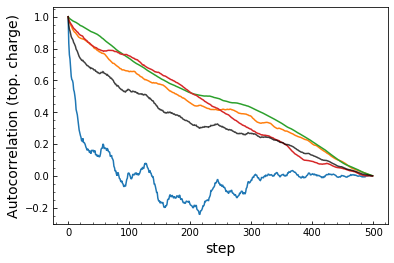

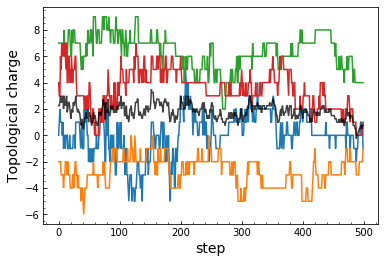

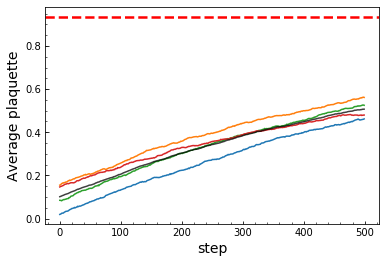

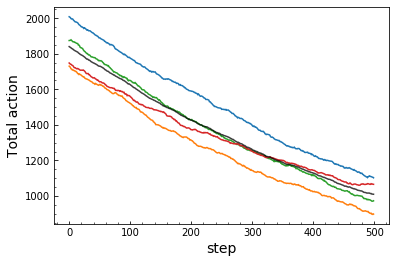

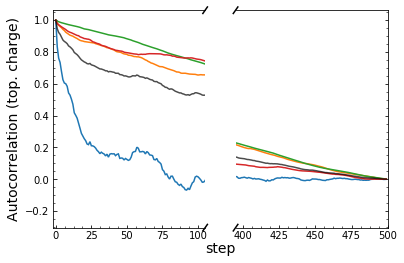

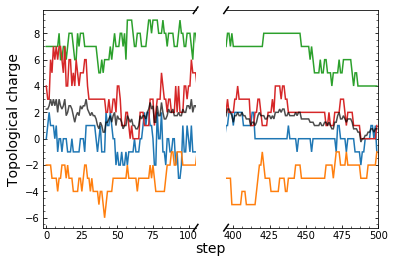

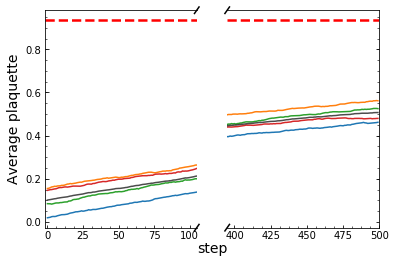

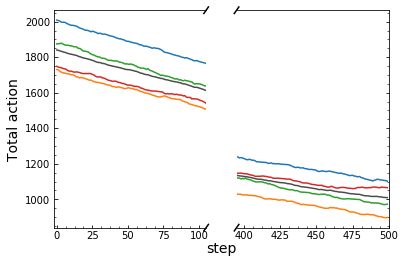

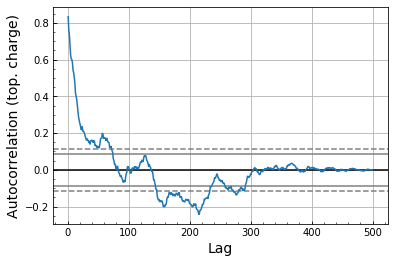

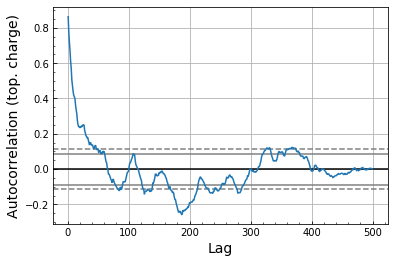

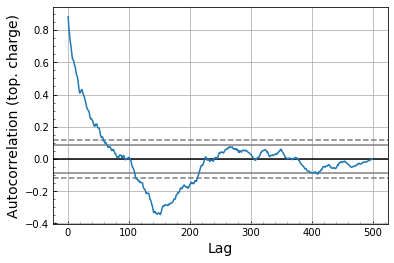

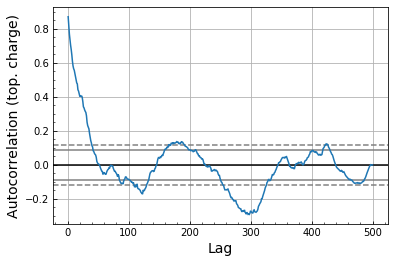

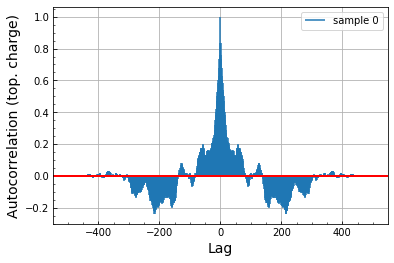

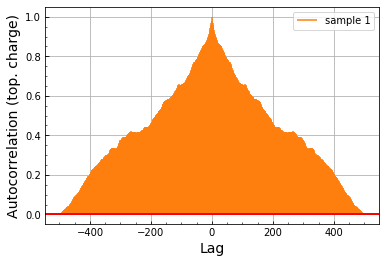

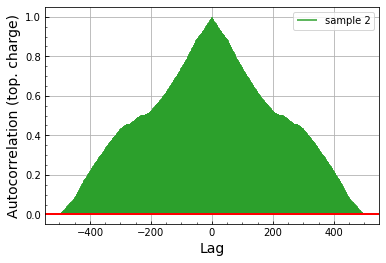

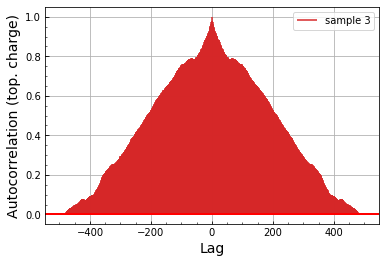

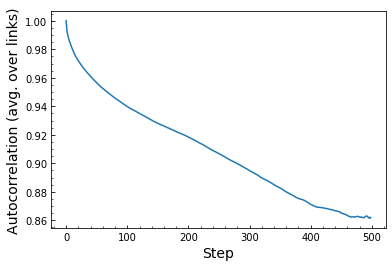

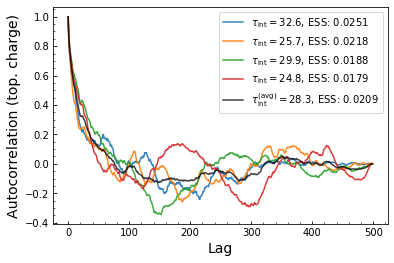

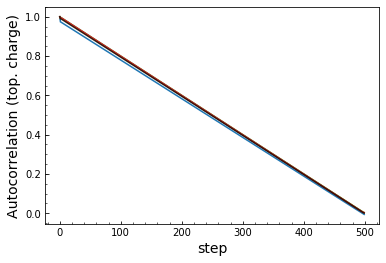

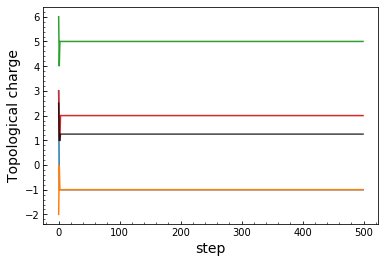

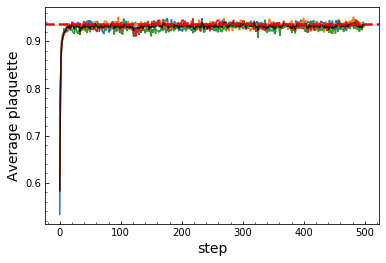

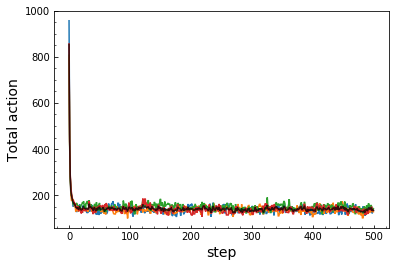

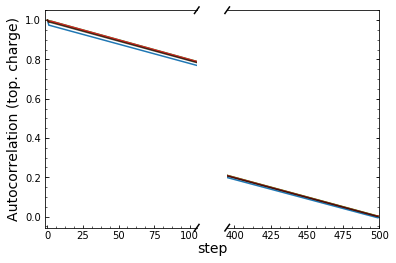

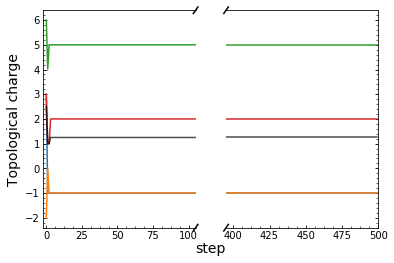

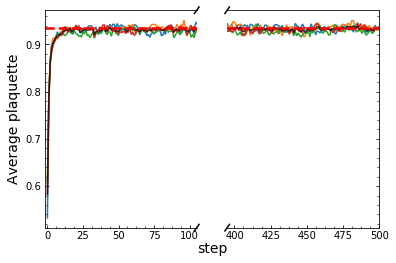

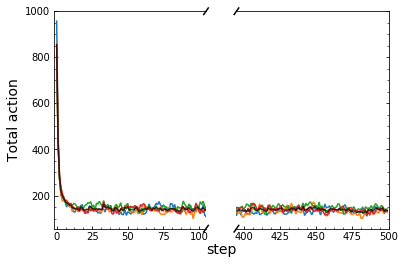

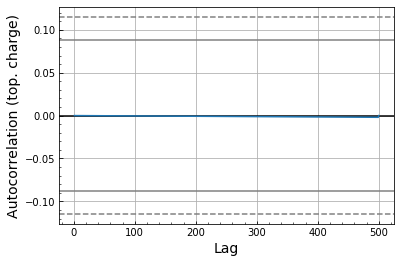

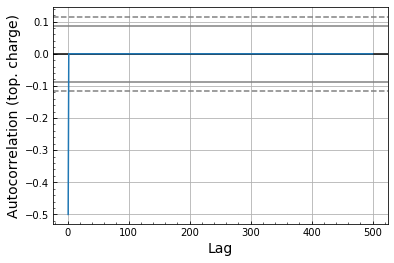

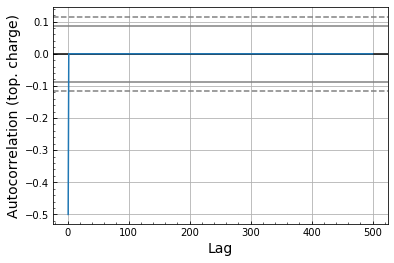

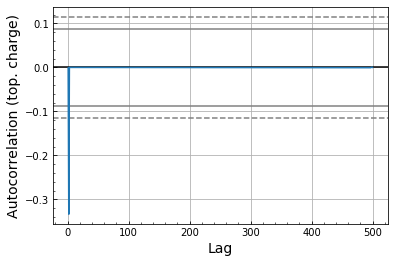

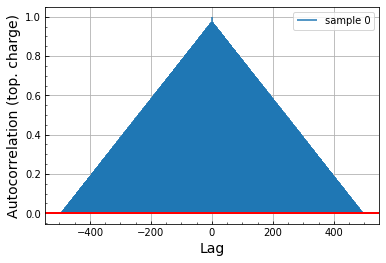

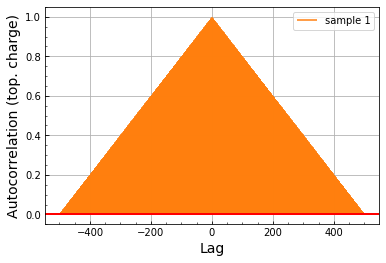

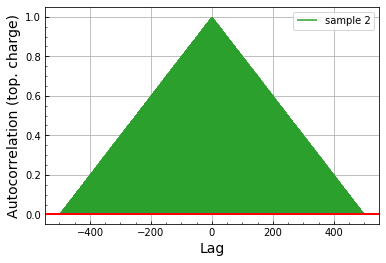

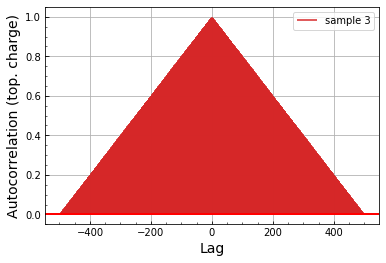

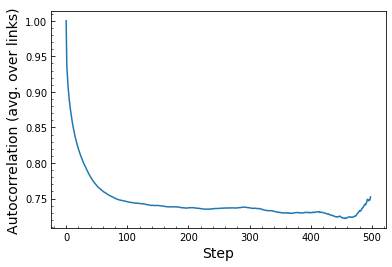

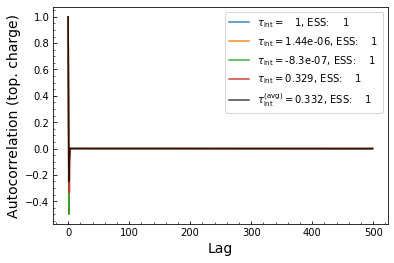

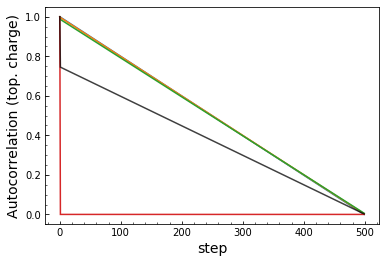

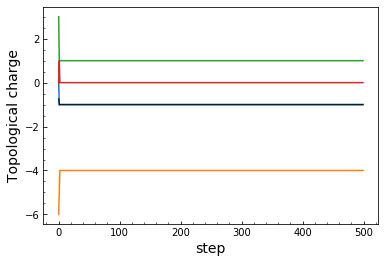

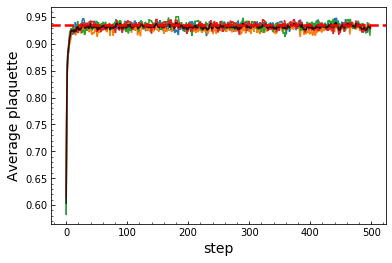

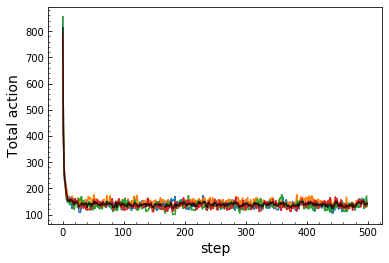

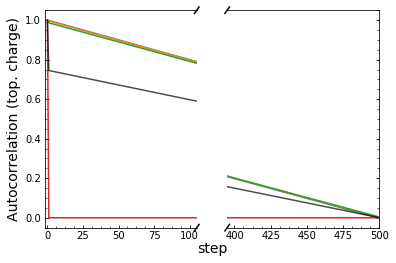

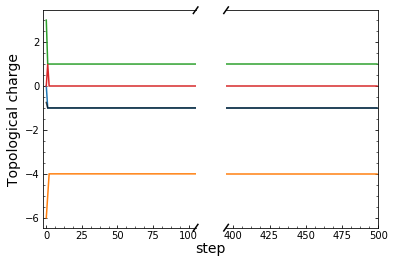

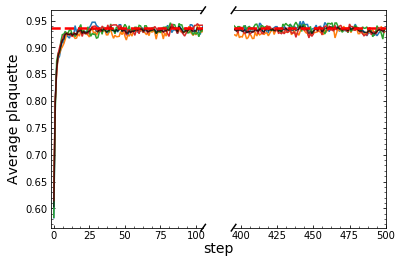

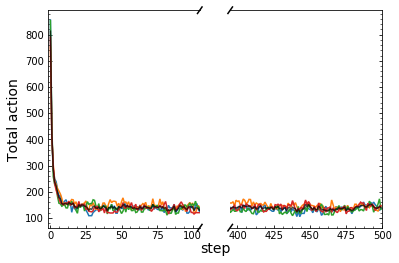

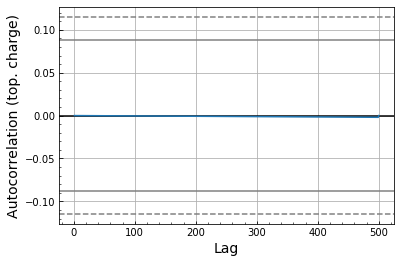

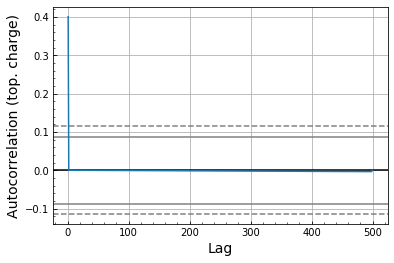

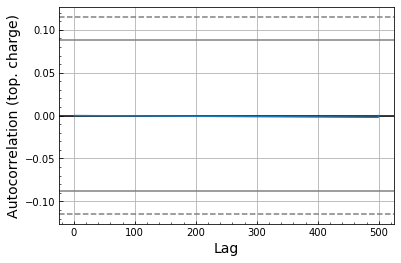

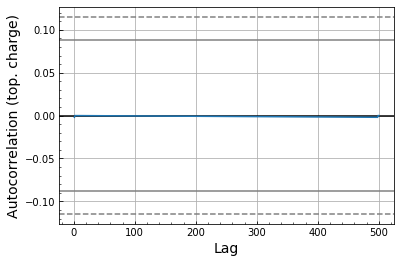

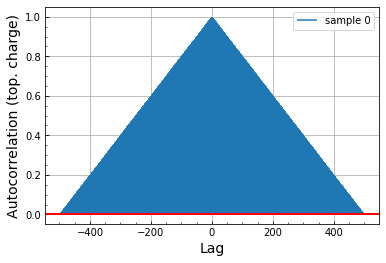

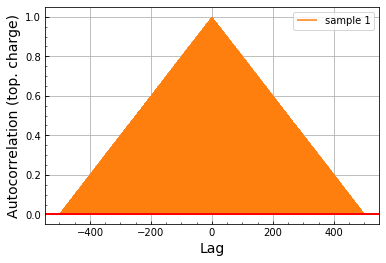

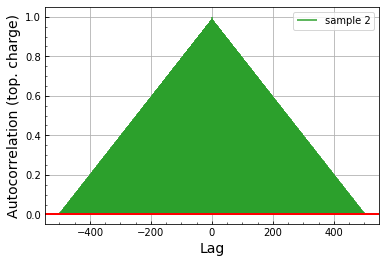

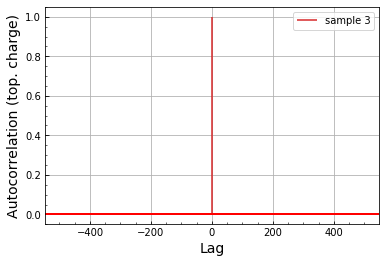

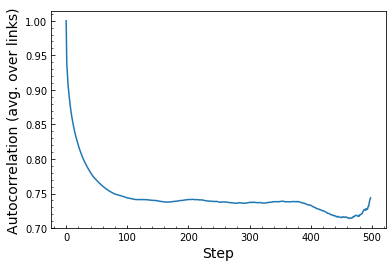

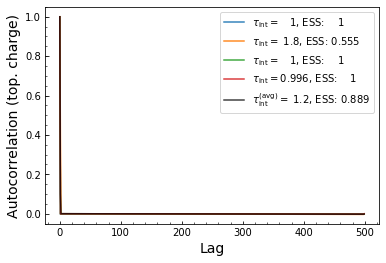

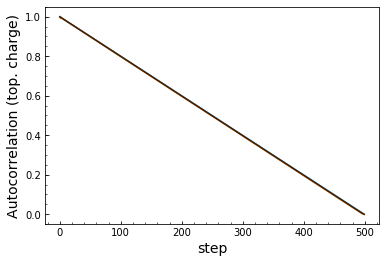

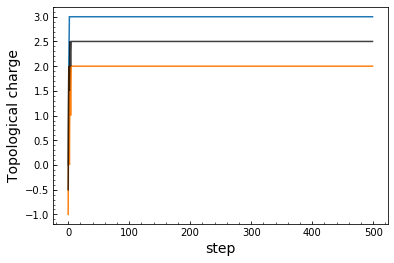

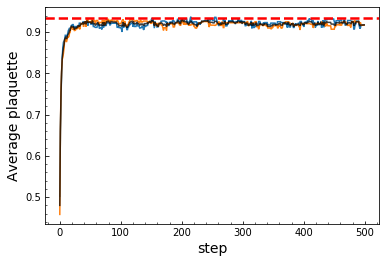

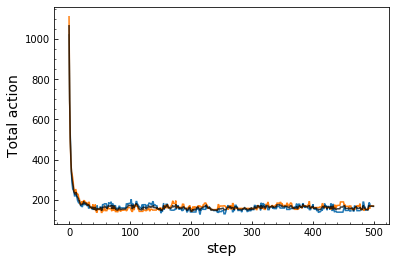

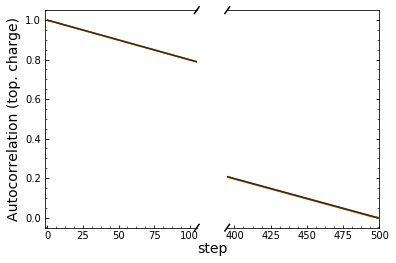

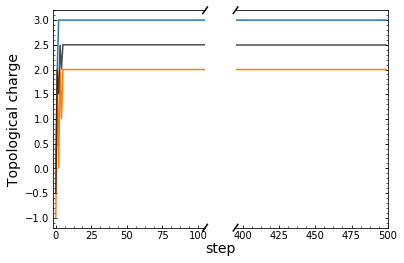

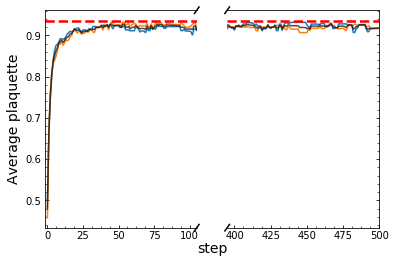

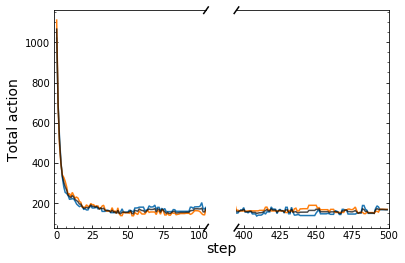

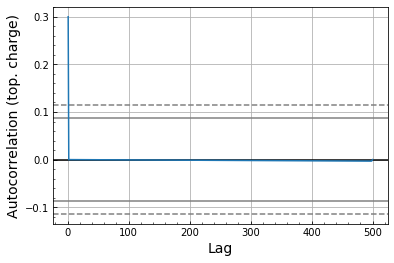

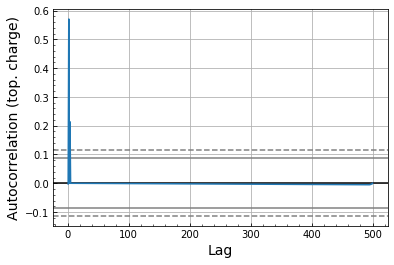

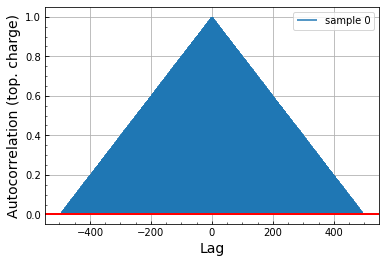

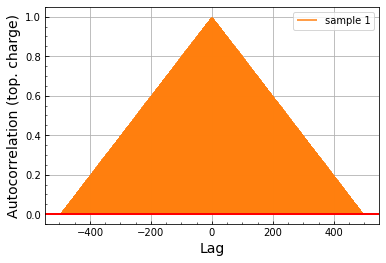

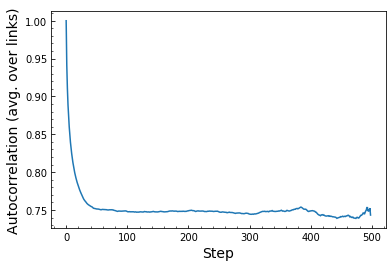

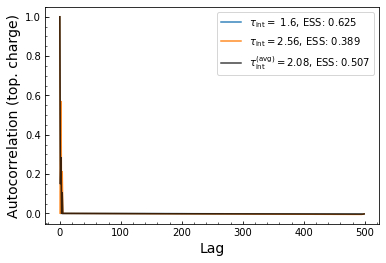

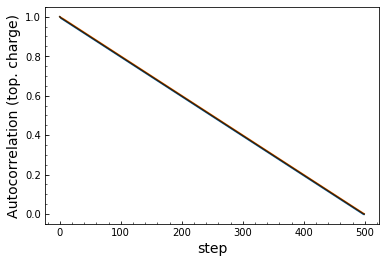

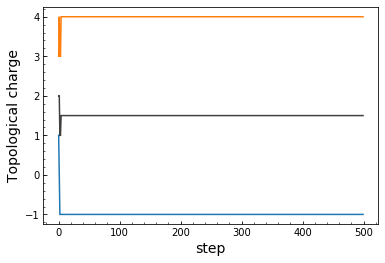

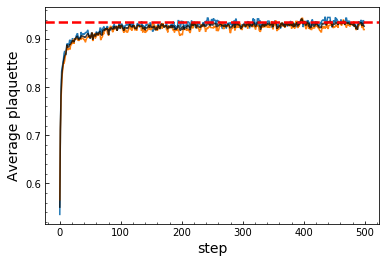

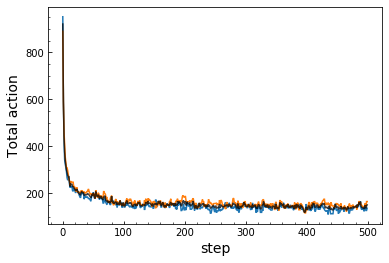

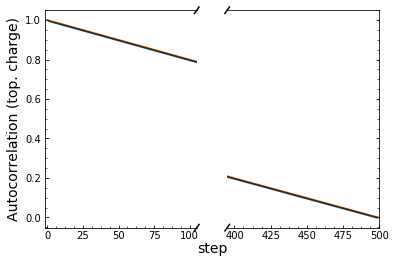

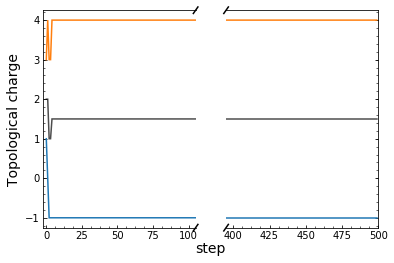

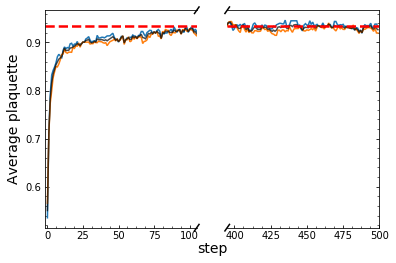

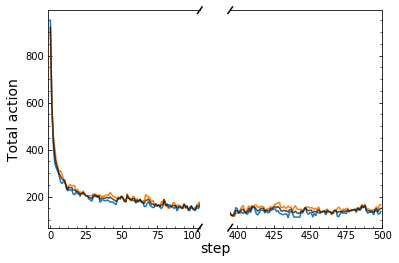

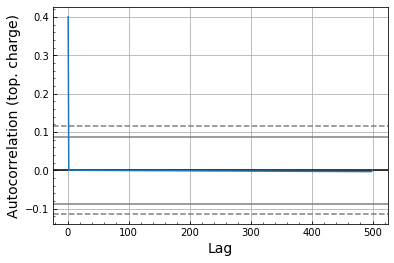

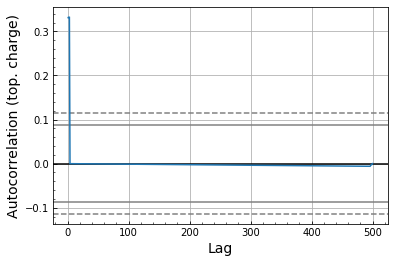

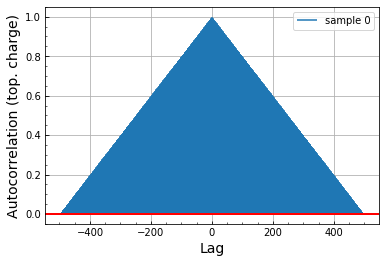

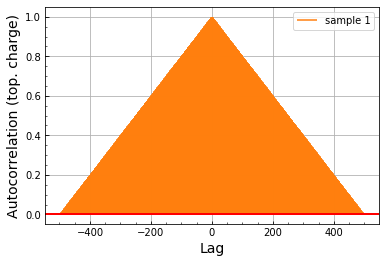

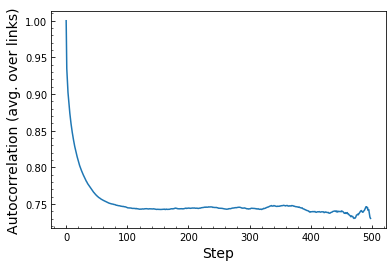

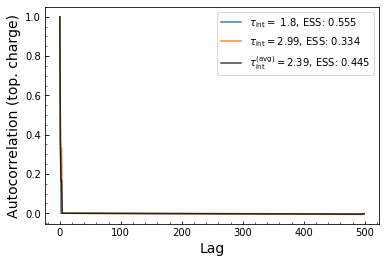

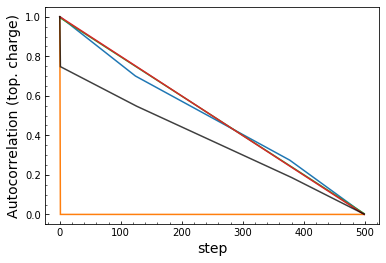

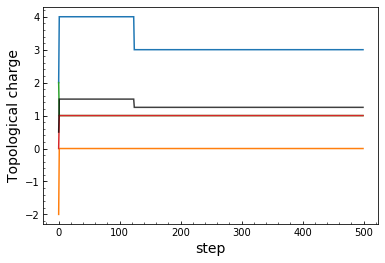

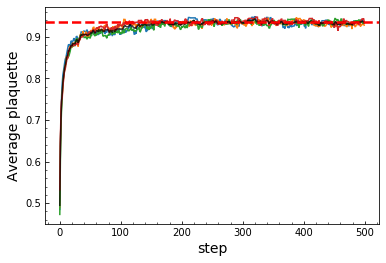

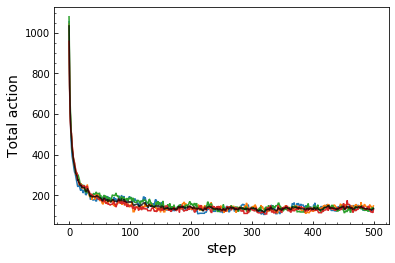

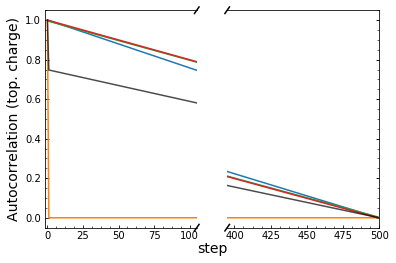

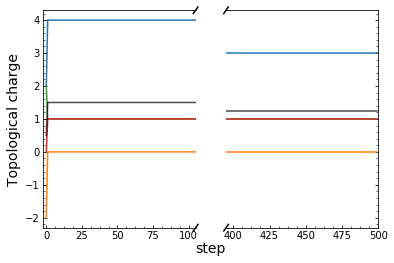

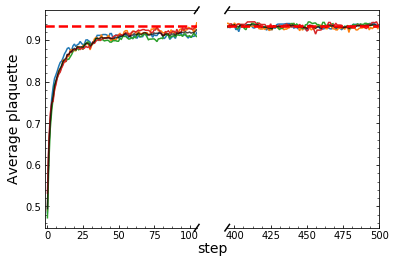

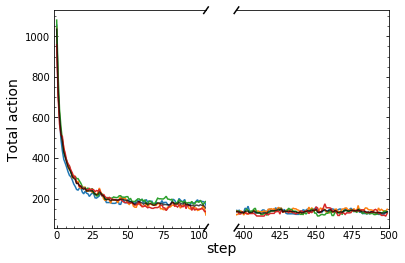

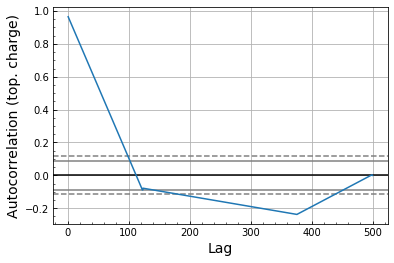

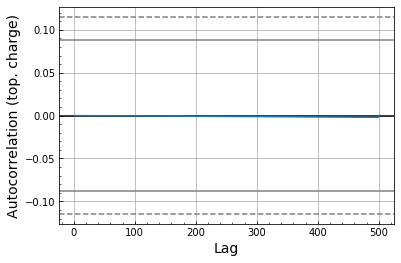

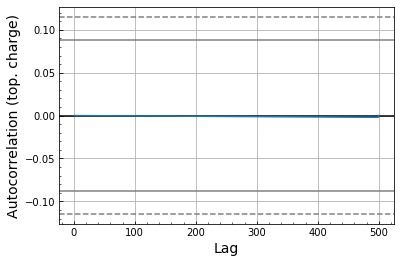

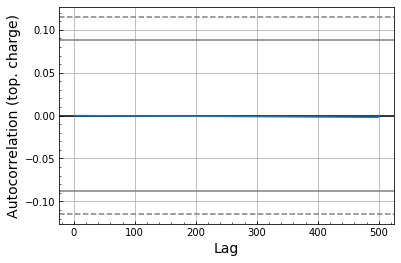

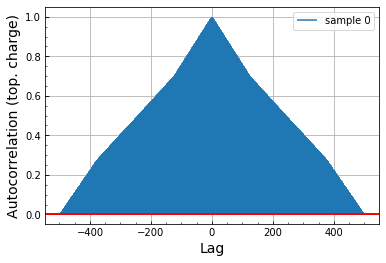

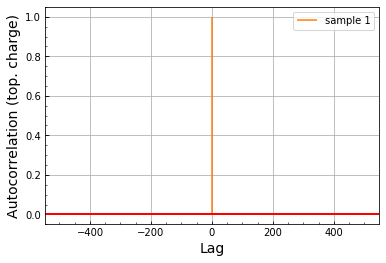

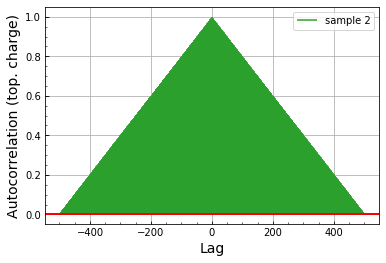

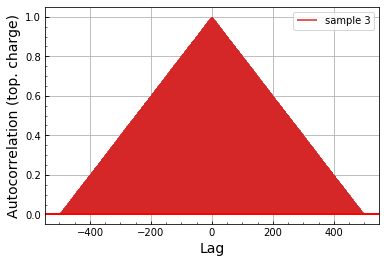

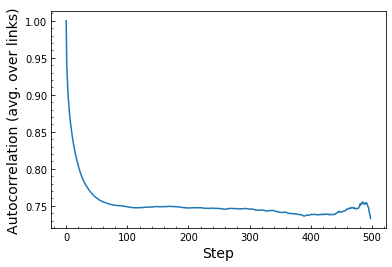

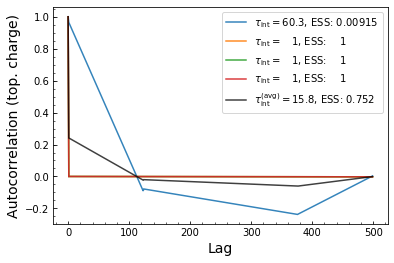

In [8]:
bad_dirs = []
for log_dir in log_dirs:
    try:
        calc_observables_generate_plots(log_dir)
    except:
        bad_dirs.append(log_dir)
        continue

In [6]:
lattice = GaugeLattice(time_size=8, 
                       space_size=8,
                       dim=2, 
                       beta=8., 
                       link_type='U1',
                       num_samples=5,
                       rand=False)

In [7]:
lattice.links.shape

(8, 8, 2)

## Calculate observables and create plots step by step, dir by dir...

In [43]:
log_dir = (
    '../../gauge_logs_graph/run_96/'
)

figs_dir = os.path.join(log_dir, 'figures')
autocorr_dir = os.path.join(figs_dir, 'autocorrelation_plots')
pandas_autocorr_dir = os.path.join(
    autocorr_dir, 
    'pandas_autocorrelation_plots'
)
matplotlib_autocorr_dir = os.path.join(
    autocorr_dir, 
    'matplotlib_autocorrelation_plots'
)
check_else_make_dir(autocorr_dir)
check_else_make_dir(matplotlib_autocorr_dir)
check_else_make_dir(pandas_autocorr_dir)

Making directory: ../../gauge_logs_graph/run_96/figures/autocorrelation_plots.
Making directory: ../../gauge_logs_graph/run_96/figures/autocorrelation_plots/matplotlib_autocorrelation_plots.
Making directory: ../../gauge_logs_graph/run_96/figures/autocorrelation_plots/pandas_autocorrelation_plots.


### Calculate observables

In [44]:
params, samples, observables = calc_observables_from_log_dir(log_dir)
if isinstance(observables, dict):
    actions = {}
    avg_plaquettes = {}
    top_charges = {}
    for key, val in observables.items():
        _actions, _avg_plaquettes, _top_charges = val
        actions[key] = _actions
        avg_plaquettes[key] = _avg_plaquettes
        top_charges[key] = _top_charges
else:
    actions, avg_plaquettes, top_charges = observables

print('\n' + 80 * '-')
for key, val in params.items():
    print(f'{key}: {val}')
print(80 * '-')

Loading samples history from: ../../gauge_logs_graph/run_96/samples_history/samples_history_500.pkl.
Loading samples history from: ../../gauge_logs_graph/run_96/samples_history/samples_history_1000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_96/samples_history/samples_history_10000.pkl.
Loading samples history from: ../../gauge_logs_graph/run_96/samples_history/samples_history_100.pkl.
Loading samples history from: ../../gauge_logs_graph/run_96/samples_history/samples_history_200.pkl.
Loading samples history from: ../../gauge_logs_graph/run_96/samples_history/samples_history_5000.pkl.
Unable to find ../../gauge_logs_graph/run_96/run_info/observables.pkl in ../../gauge_logs_graph/run_96/run_info. Exiting.
step: 0 time/step: 0.1292 avg action: 440.6  avg plaquette: 0.1395 top charges: 


[-1, 0, 0, 0, 0]


step: 1 time/step: 0.1884 avg action: 437.6  avg plaquette: 0.1454 top charges: 


[0, 0, 0, 1, 0]


step: 2 time/step: 0.5787 avg action:  434   avg plaquette: 0.152

step: 73 time/step: 0.126  avg action: 284.8  avg plaquette: 0.4438 top charges: 


[0, 0, 0, 0, 1]


step: 74 time/step: 0.1467 avg action: 283.7  avg plaquette: 0.4458 top charges: 


[-1, 0, 0, 0, 2]


step: 75 time/step: 0.1395 avg action: 283.4  avg plaquette: 0.4465 top charges: 


[-1, 0, 0, 0, 1]


step: 76 time/step: 0.1391 avg action: 282.7  avg plaquette: 0.4479 top charges: 


[-1, 0, 0, 0, 1]


step: 77 time/step: 0.1167 avg action: 282.1  avg plaquette: 0.4491 top charges: 


[0, 0, 0, 0, 1]


step: 78 time/step: 0.1941 avg action: 280.9  avg plaquette: 0.4514 top charges: 


[-1, 0, -1, 0, 1]


step: 79 time/step: 0.1811 avg action: 280.4  avg plaquette: 0.4524 top charges: 


[0, 0, -1, 0, 2]


step: 80 time/step: 0.1388 avg action: 278.7  avg plaquette: 0.4556 top charges: 


[0, 0, -1, 0, 1]


step: 81 time/step: 0.124  avg action: 277.6  avg plaquette: 0.4578 top charges: 


[0, 0, -1, 0, 2]


step: 82 time/step: 0.1309 avg action: 277.3  avg plaquette: 0.4583 top ch

step: 152 time/step: 0.1859 avg action:  195   avg plaquette: 0.6192 top charges: 


[0, 0, -1, 0, 2]


step: 153 time/step: 0.1276 avg action: 194.9  avg plaquette: 0.6193 top charges: 


[0, 0, -1, 0, 2]


step: 154 time/step: 0.1956 avg action: 194.3  avg plaquette: 0.6205 top charges: 


[0, 0, 0, 0, 2]


step: 155 time/step: 0.2601 avg action: 192.4  avg plaquette: 0.6242 top charges: 


[0, 0, 0, -1, 2]


step: 156 time/step: 0.1623 avg action: 192.5  avg plaquette: 0.6241 top charges: 


[0, 0, -1, 0, 2]


step: 157 time/step: 0.1924 avg action: 191.8  avg plaquette: 0.6255 top charges: 


[0, 0, -1, -1, 3]


step: 158 time/step: 0.1569 avg action: 190.8  avg plaquette: 0.6273 top charges: 


[0, 0, 0, 0, 3]


step: 159 time/step: 0.4006 avg action: 189.4  avg plaquette: 0.6302 top charges: 


[0, 0, 0, 0, 2]


step: 160 time/step: 0.2566 avg action: 189.3  avg plaquette: 0.6302 top charges: 


[0, 0, 0, -1, 2]


step: 161 time/step: 0.2151 avg action: 187.8  avg plaquette: 0.63

step: 231 time/step: 0.1598 avg action: 144.1  avg plaquette: 0.7187 top charges: 


[0, 0, 0, 0, 3]


step: 232 time/step: 0.1408 avg action: 143.9  avg plaquette: 0.719  top charges: 


[0, 0, 0, 0, 2]


step: 233 time/step: 0.1377 avg action: 142.8  avg plaquette: 0.7211 top charges: 


[0, 0, 0, 0, 3]


step: 234 time/step: 0.1277 avg action: 142.6  avg plaquette: 0.7214 top charges: 


[0, 0, 0, -1, 3]


step: 235 time/step: 0.1209 avg action:  142   avg plaquette: 0.7228 top charges: 


[0, 0, 0, 0, 3]


step: 236 time/step: 0.125  avg action: 141.1  avg plaquette: 0.7244 top charges: 


[0, 0, 0, 0, 3]


step: 237 time/step: 0.1367 avg action: 141.3  avg plaquette: 0.724  top charges: 


[0, 0, 0, 0, 3]


step: 238 time/step: 0.1225 avg action: 139.5  avg plaquette: 0.7276 top charges: 


[0, 0, 0, 0, 3]


step: 239 time/step: 0.09606 avg action: 139.5  avg plaquette: 0.7276 top charges: 


[0, 0, 0, 0, 3]


step: 240 time/step: 0.09302 avg action: 139.1  avg plaquette: 0.7283 t

step: 312 time/step: 0.1084 avg action: 105.9  avg plaquette: 0.7931 top charges: 


[0, 0, 0, 0, 2]


step: 313 time/step: 0.0958 avg action:  106   avg plaquette: 0.793  top charges: 


[0, 0, 0, 0, 2]


step: 314 time/step: 0.09589 avg action: 105.4  avg plaquette: 0.7941 top charges: 


[0, 0, 0, 0, 1]


step: 315 time/step: 0.1244 avg action:  106   avg plaquette: 0.7929 top charges: 


[0, 0, 0, 0, 2]


step: 316 time/step: 0.2762 avg action: 105.6  avg plaquette: 0.7937 top charges: 


[0, 0, 0, 0, 2]


step: 317 time/step: 0.1813 avg action: 104.7  avg plaquette: 0.7956 top charges: 


[0, 0, 0, 0, 1]


step: 318 time/step: 0.2132 avg action:  105   avg plaquette: 0.795  top charges: 


[0, 0, 0, 0, 1]


step: 319 time/step: 0.1229 avg action: 103.3  avg plaquette: 0.7982 top charges: 


[0, 0, 0, 0, 1]


step: 320 time/step: 0.1434 avg action: 102.7  avg plaquette: 0.7993 top charges: 


[0, 0, 0, 0, 1]


step: 321 time/step: 0.1399 avg action: 103.1  avg plaquette: 0.7986 top

step: 393 time/step: 0.1304 avg action: 87.29  avg plaquette: 0.8295 top charges: 


[0, 0, 0, -1, 2]


step: 394 time/step: 0.1334 avg action: 86.72  avg plaquette: 0.8306 top charges: 


[0, 0, -1, 0, 1]


step: 395 time/step: 0.1485 avg action: 86.58  avg plaquette: 0.8309 top charges: 


[0, 0, -1, 0, 1]


step: 396 time/step: 0.1307 avg action: 86.55  avg plaquette: 0.8309 top charges: 


[1, 0, -1, 0, 1]


step: 397 time/step: 0.1327 avg action: 86.57  avg plaquette: 0.8309 top charges: 


[1, 0, -1, 0, 1]


step: 398 time/step: 0.1178 avg action:  86.7  avg plaquette: 0.8307 top charges: 


[1, 0, -1, 0, 1]


step: 399 time/step: 0.1307 avg action: 87.16  avg plaquette: 0.8298 top charges: 


[0, 0, 0, -1, 1]


step: 400 time/step: 0.1354 avg action: 86.82  avg plaquette: 0.8304 top charges: 


[0, 0, -1, -1, 1]


step: 401 time/step: 0.1335 avg action: 86.61  avg plaquette: 0.8308 top charges: 


[0, 0, 0, 0, 2]


step: 402 time/step: 0.1299 avg action: 86.82  avg plaquette: 0.

step: 472 time/step: 0.1293 avg action: 75.55  avg plaquette: 0.8524 top charges: 


[0, 0, -1, 0, 2]


step: 473 time/step: 0.1102 avg action: 75.23  avg plaquette: 0.8531 top charges: 


[1, 0, -1, 0, 2]


step: 474 time/step: 0.1158 avg action: 75.26  avg plaquette: 0.853  top charges: 


[0, 0, -1, 0, 2]


step: 475 time/step: 0.1059 avg action: 74.92  avg plaquette: 0.8537 top charges: 


[1, 0, -1, 0, 2]


step: 476 time/step: 0.1259 avg action: 74.63  avg plaquette: 0.8542 top charges: 


[1, 0, -1, 0, 1]


step: 477 time/step: 0.1009 avg action: 74.33  avg plaquette: 0.8548 top charges: 


[0, 0, 0, 0, 1]


step: 478 time/step:  0.15  avg action: 74.04  avg plaquette: 0.8554 top charges: 


[0, 0, 0, 0, 1]


step: 479 time/step: 0.1622 avg action: 74.14  avg plaquette: 0.8552 top charges: 


[0, 0, -1, 0, 1]


step: 480 time/step: 0.1689 avg action: 74.81  avg plaquette: 0.8539 top charges: 


[0, 0, -1, 0, 1]


step: 481 time/step: 0.1658 avg action: 74.17  avg plaquette: 0.85

step: 51 time/step: 0.1393 avg action: 348.5  avg plaquette: 0.3193 top charges: 


[0, -1, 0, -1, 6]


step: 52 time/step: 0.1376 avg action:  348   avg plaquette: 0.3203 top charges: 


[0, 0, 0, -1, 5]


step: 53 time/step: 0.1564 avg action: 347.3  avg plaquette: 0.3217 top charges: 


[0, 0, 1, 0, 6]


step: 54 time/step: 0.1236 avg action: 345.6  avg plaquette: 0.3251 top charges: 


[0, 0, 0, 0, 5]


step: 55 time/step: 0.1554 avg action: 345.1  avg plaquette: 0.326  top charges: 


[0, -1, 1, 0, 5]


step: 56 time/step: 0.1287 avg action: 343.5  avg plaquette: 0.329  top charges: 


[0, 0, 1, 0, 5]


step: 57 time/step: 0.1227 avg action: 342.1  avg plaquette: 0.3318 top charges: 


[-1, -1, 0, -1, 4]


step: 58 time/step: 0.1303 avg action: 339.5  avg plaquette: 0.3369 top charges: 


[-1, -1, 0, -1, 4]


step: 59 time/step: 0.1163 avg action: 336.7  avg plaquette: 0.3425 top charges: 


[0, -1, 0, -1, 4]


step: 60 time/step: 0.1154 avg action: 334.3  avg plaquette: 0.347  to

step: 131 time/step: 0.1056 avg action:  247   avg plaquette: 0.5176 top charges: 


[1, 0, 1, 0, 1]


step: 132 time/step: 0.0921 avg action: 245.7  avg plaquette: 0.5201 top charges: 


[1, 0, 0, 0, 0]


step: 133 time/step: 0.08945 avg action: 244.4  avg plaquette: 0.5226 top charges: 


[1, 0, 1, 0, 0]


step: 134 time/step: 0.08524 avg action: 244.5  avg plaquette: 0.5225 top charges: 


[1, 0, 1, -1, 0]


step: 135 time/step: 0.08845 avg action: 242.8  avg plaquette: 0.5259 top charges: 


[1, 0, 1, -1, 0]


step: 136 time/step: 0.09214 avg action: 241.2  avg plaquette: 0.529  top charges: 


[0, 0, 0, -1, 0]


step: 137 time/step: 0.1132 avg action: 239.5  avg plaquette: 0.5322 top charges: 


[1, 0, 0, -1, 0]


step: 138 time/step: 0.1033 avg action:  239   avg plaquette: 0.5332 top charges: 


[0, 0, 0, -1, 0]


step: 139 time/step: 0.1089 avg action: 237.8  avg plaquette: 0.5355 top charges: 


[1, 0, 0, -1, 0]


step: 140 time/step: 0.1118 avg action: 237.1  avg plaquette: 0

step: 211 time/step: 0.1379 avg action: 177.2  avg plaquette: 0.6539 top charges: 


[1, -1, 0, 0, 0]


step: 212 time/step: 0.1419 avg action: 176.2  avg plaquette: 0.6559 top charges: 


[1, -1, 0, 0, 0]


step: 213 time/step: 0.1113 avg action: 176.2  avg plaquette: 0.6559 top charges: 


[1, -1, 0, 0, 0]


step: 214 time/step: 0.1505 avg action: 173.3  avg plaquette: 0.6616 top charges: 


[0, -1, 0, 0, 0]


step: 215 time/step: 0.1378 avg action: 172.7  avg plaquette: 0.6627 top charges: 


[0, 0, 0, 0, 0]


step: 216 time/step: 0.1463 avg action:  172   avg plaquette: 0.664  top charges: 


[0, -1, 1, 0, 0]


step: 217 time/step: 0.178  avg action: 171.9  avg plaquette: 0.6642 top charges: 


[0, -1, 1, 0, 0]


step: 218 time/step: 0.1644 avg action: 171.3  avg plaquette: 0.6654 top charges: 


[0, -1, 1, 0, 0]


step: 219 time/step: 0.1301 avg action: 170.6  avg plaquette: 0.6668 top charges: 


[0, 0, 0, 0, 0]


step: 220 time/step: 0.1112 avg action: 169.6  avg plaquette: 0.66

step: 291 time/step: 0.1174 avg action: 136.3  avg plaquette: 0.7337 top charges: 


[1, -2, 1, 0, 0]


step: 292 time/step: 0.09655 avg action: 135.9  avg plaquette: 0.7346 top charges: 


[1, -1, 1, 0, 0]


step: 293 time/step: 0.08378 avg action: 136.9  avg plaquette: 0.7326 top charges: 


[1, -2, 1, 0, 0]


step: 294 time/step: 0.08542 avg action: 136.3  avg plaquette: 0.7338 top charges: 


[1, -2, 0, 0, 0]


step: 295 time/step: 0.08727 avg action: 136.2  avg plaquette: 0.734  top charges: 


[1, -1, 0, 0, 0]


step: 296 time/step: 0.1061 avg action: 136.1  avg plaquette: 0.7342 top charges: 


[1, -1, 1, 0, 0]


step: 297 time/step: 0.1242 avg action: 136.1  avg plaquette: 0.7341 top charges: 


[0, -1, 1, 0, 0]


step: 298 time/step: 0.1846 avg action: 134.8  avg plaquette: 0.7368 top charges: 


[1, -1, 1, 0, 0]


step: 299 time/step: 0.2341 avg action: 134.8  avg plaquette: 0.7367 top charges: 


[1, -2, 1, 0, 0]


step: 300 time/step: 0.1876 avg action: 135.3  avg plaquette

step: 371 time/step: 0.1362 avg action: 117.1  avg plaquette: 0.7713 top charges: 


[1, -1, 0, 0, 0]


step: 372 time/step: 0.1334 avg action: 115.5  avg plaquette: 0.7744 top charges: 


[0, -1, 0, 0, 0]


step: 373 time/step: 0.1106 avg action: 115.3  avg plaquette: 0.7749 top charges: 


[1, -1, 0, 0, 0]


step: 374 time/step: 0.1132 avg action:  116   avg plaquette: 0.7735 top charges: 


[0, -2, 1, 0, 0]


step: 375 time/step: 0.1162 avg action: 115.9  avg plaquette: 0.7735 top charges: 


[0, -2, 0, 0, 0]


step: 376 time/step: 0.1075 avg action: 115.8  avg plaquette: 0.7738 top charges: 


[1, -2, 0, 0, 0]


step: 377 time/step: 0.1156 avg action: 114.8  avg plaquette: 0.7759 top charges: 


[0, -2, 0, 0, 0]


step: 378 time/step: 0.1412 avg action: 114.8  avg plaquette: 0.7758 top charges: 


[1, -2, 1, 0, 0]


step: 379 time/step: 0.1416 avg action: 113.1  avg plaquette: 0.7792 top charges: 


[2, -2, 0, 0, 0]


step: 380 time/step: 0.1231 avg action: 113.3  avg plaquette: 0.

step: 450 time/step: 0.1058 avg action: 92.22  avg plaquette: 0.8199 top charges: 


[2, -2, 0, 0, 0]


step: 451 time/step: 0.09848 avg action: 91.58  avg plaquette: 0.8211 top charges: 


[2, -2, 0, 0, 0]


step: 452 time/step: 0.09514 avg action: 90.94  avg plaquette: 0.8224 top charges: 


[2, -1, 0, 0, 0]


step: 453 time/step: 0.0898 avg action: 90.66  avg plaquette: 0.8229 top charges: 


[2, -1, 0, 0, 0]


step: 454 time/step: 0.07904 avg action:  90.8  avg plaquette: 0.8227 top charges: 


[1, -1, 0, 0, 0]


step: 455 time/step: 0.08628 avg action: 90.65  avg plaquette: 0.823  top charges: 


[2, -2, 1, 0, 0]


step: 456 time/step: 0.1125 avg action: 89.86  avg plaquette: 0.8245 top charges: 


[2, -1, 0, 0, 0]


step: 457 time/step: 0.1027 avg action:  89.4  avg plaquette: 0.8254 top charges: 


[1, -2, 0, 0, 0]


step: 458 time/step: 0.09525 avg action: 88.31  avg plaquette: 0.8275 top charges: 


[2, -1, 0, 0, 0]


step: 459 time/step: 0.1069 avg action: 87.46  avg plaquett

step: 529 time/step: 0.09913 avg action: 83.05  avg plaquette: 0.8378 top charges: 


[1, -2, 1, 0, 0]


step: 530 time/step: 0.1053 avg action: 84.13  avg plaquette: 0.8357 top charges: 


[1, -2, 1, 1, 0]


step: 531 time/step: 0.1024 avg action: 84.58  avg plaquette: 0.8348 top charges: 


[1, -2, 0, 1, 0]


step: 532 time/step: 0.1092 avg action: 84.59  avg plaquette: 0.8348 top charges: 


[2, -2, 1, 0, 0]


step: 533 time/step: 0.1469 avg action: 84.15  avg plaquette: 0.8356 top charges: 


[2, -2, 0, 0, 0]


step: 534 time/step: 0.1371 avg action: 83.96  avg plaquette: 0.836  top charges: 


[2, -1, 1, 0, 0]


step: 535 time/step: 0.1532 avg action: 84.04  avg plaquette: 0.8359 top charges: 


[2, -2, 1, 1, 0]


step: 536 time/step: 0.1499 avg action: 83.07  avg plaquette: 0.8378 top charges: 


[1, -2, 0, 1, 0]


step: 537 time/step: 0.1485 avg action: 82.86  avg plaquette: 0.8382 top charges: 


[1, -1, 0, 0, 0]


step: 538 time/step: 0.1104 avg action: 82.77  avg plaquette: 0

step: 609 time/step: 0.1086 avg action: 75.88  avg plaquette: 0.8518 top charges: 


[2, -1, 1, 1, 0]


step: 610 time/step: 0.1306 avg action: 75.07  avg plaquette: 0.8534 top charges: 


[2, -1, 1, 1, 0]


step: 611 time/step: 0.1333 avg action: 76.35  avg plaquette: 0.8509 top charges: 


[2, -1, 1, 0, 0]


step: 612 time/step: 0.151  avg action: 75.85  avg plaquette: 0.8519 top charges: 


[1, -2, 1, 0, -1]


step: 613 time/step: 0.1299 avg action: 76.12  avg plaquette: 0.8513 top charges: 


[1, -2, 0, 1, 0]


step: 614 time/step: 0.1324 avg action: 76.75  avg plaquette: 0.8501 top charges: 


[2, -2, 1, 1, -1]


step: 615 time/step: 0.1129 avg action: 76.03  avg plaquette: 0.8515 top charges: 


[2, -1, 0, 1, -1]


step: 616 time/step: 0.1189 avg action: 76.06  avg plaquette: 0.8514 top charges: 


[1, -2, 0, 0, 0]


step: 617 time/step: 0.1608 avg action: 76.12  avg plaquette: 0.8513 top charges: 


[2, -2, 1, 1, 0]


step: 618 time/step: 0.1835 avg action: 76.03  avg plaquette:

step: 690 time/step: 0.09362 avg action: 70.99  avg plaquette: 0.8613 top charges: 


[1, -2, 1, 1, 0]


step: 691 time/step: 0.08538 avg action: 70.33  avg plaquette: 0.8626 top charges: 


[1, -2, 0, 1, -1]


step: 692 time/step: 0.09531 avg action: 70.33  avg plaquette: 0.8626 top charges: 


[1, -1, 1, 0, -1]


step: 693 time/step: 0.09358 avg action: 69.02  avg plaquette: 0.8652 top charges: 


[1, -1, 1, 0, 0]


step: 694 time/step: 0.1076 avg action: 69.44  avg plaquette: 0.8644 top charges: 


[1, -2, 0, 0, 0]


step: 695 time/step:  0.18  avg action:  68.6  avg plaquette: 0.866  top charges: 


[2, -2, 1, 0, -1]


step: 696 time/step: 0.1758 avg action: 69.33  avg plaquette: 0.8646 top charges: 


[1, -2, 0, 0, 0]


step: 697 time/step: 0.1798 avg action: 69.19  avg plaquette: 0.8649 top charges: 


[2, -1, 1, 0, -1]


step: 698 time/step: 0.1423 avg action: 68.75  avg plaquette: 0.8657 top charges: 


[1, -1, 1, 1, 0]


step: 699 time/step: 0.1085 avg action:  69.1  avg plaqu

step: 769 time/step: 0.1099 avg action: 69.34  avg plaquette: 0.8646 top charges: 


[2, -2, 0, 0, -1]


step: 770 time/step: 0.1187 avg action: 69.18  avg plaquette: 0.8649 top charges: 


[1, -2, 1, 0, -1]


step: 771 time/step: 0.1381 avg action: 68.97  avg plaquette: 0.8653 top charges: 


[1, -1, 1, 0, -1]


step: 772 time/step: 0.1003 avg action: 67.96  avg plaquette: 0.8673 top charges: 


[1, -1, 1, 0, -1]


step: 773 time/step: 0.1165 avg action: 67.92  avg plaquette: 0.8674 top charges: 


[2, -2, 1, 0, -1]


step: 774 time/step: 0.1184 avg action: 67.81  avg plaquette: 0.8676 top charges: 


[1, -1, 0, 1, -1]


step: 775 time/step: 0.1128 avg action: 68.21  avg plaquette: 0.8668 top charges: 


[1, -1, 1, 1, -1]


step: 776 time/step: 0.1131 avg action: 67.73  avg plaquette: 0.8677 top charges: 


[1, -2, 1, 0, 0]


step: 777 time/step: 0.1069 avg action: 66.85  avg plaquette: 0.8694 top charges: 


[2, -1, 1, 0, -1]


step: 778 time/step: 0.1056 avg action: 67.18  avg plaqu

step: 849 time/step: 0.097  avg action: 64.19  avg plaquette: 0.8746 top charges: 


[2, -1, 1, 0, 0]


step: 850 time/step: 0.0928 avg action: 64.34  avg plaquette: 0.8743 top charges: 


[1, -2, 1, 1, 0]


step: 851 time/step: 0.09113 avg action: 64.15  avg plaquette: 0.8747 top charges: 


[1, -1, 0, 1, 0]


step: 852 time/step: 0.09573 avg action: 63.93  avg plaquette: 0.8751 top charges: 


[2, -1, 1, 1, 0]


step: 853 time/step: 0.09466 avg action: 64.18  avg plaquette: 0.8746 top charges: 


[1, -2, 1, 0, 0]


step: 854 time/step: 0.1032 avg action: 63.78  avg plaquette: 0.8754 top charges: 


[1, -1, 1, 1, 0]


step: 855 time/step: 0.09952 avg action: 63.46  avg plaquette: 0.876  top charges: 


[2, -2, 0, 1, 0]


step: 856 time/step: 0.09688 avg action: 63.56  avg plaquette: 0.8759 top charges: 


[1, -1, 1, 1, 0]


step: 857 time/step: 0.1002 avg action: 62.95  avg plaquette: 0.8771 top charges: 


[2, -1, 0, 0, 0]


step: 858 time/step: 0.09557 avg action: 62.24  avg plaquet

step: 929 time/step: 0.1356 avg action: 62.35  avg plaquette: 0.8782 top charges: 


[2, -1, 1, 1, 0]


step: 930 time/step: 0.1306 avg action: 62.55  avg plaquette: 0.8778 top charges: 


[2, -1, 1, 1, 0]


step: 931 time/step: 0.2267 avg action: 62.37  avg plaquette: 0.8782 top charges: 


[2, -1, 1, 0, 0]


step: 932 time/step: 0.1496 avg action: 62.39  avg plaquette: 0.8781 top charges: 


[2, -2, 0, 1, 0]


step: 933 time/step: 0.1397 avg action: 62.76  avg plaquette: 0.8774 top charges: 


[2, -1, 0, 0, 0]


step: 934 time/step: 0.1355 avg action: 61.65  avg plaquette: 0.8796 top charges: 


[1, -2, 1, 1, 0]


step: 935 time/step: 0.1374 avg action: 61.17  avg plaquette: 0.8805 top charges: 


[1, -1, 1, 0, 0]


step: 936 time/step: 0.1226 avg action: 61.19  avg plaquette: 0.8805 top charges: 


[2, -1, 0, 0, 0]


step: 937 time/step: 0.1153 avg action: 61.99  avg plaquette: 0.8789 top charges: 


[2, -2, 1, 1, 0]


step: 938 time/step: 0.09006 avg action: 60.97  avg plaquette: 0

step: 8 time/step: 0.1465 avg action: 373.3  avg plaquette: 0.2709 top charges: 


[1, -1, -1, -1, 0]


step: 9 time/step: 0.1095 avg action: 371.1  avg plaquette: 0.2751 top charges: 


[1, -1, 0, -1, 0]


step: 10 time/step: 0.1134 avg action: 368.8  avg plaquette: 0.2797 top charges: 


[1, -1, -1, 0, 0]


step: 11 time/step: 0.1264 avg action:  367   avg plaquette: 0.2832 top charges: 


[2, -2, 0, 0, 0]


step: 12 time/step: 0.1137 avg action: 363.7  avg plaquette: 0.2896 top charges: 


[3, -2, 0, -1, 0]


step: 13 time/step: 0.1011 avg action: 361.1  avg plaquette: 0.2947 top charges: 


[2, -2, 0, 0, 0]


step: 14 time/step: 0.08766 avg action: 358.5  avg plaquette: 0.2998 top charges: 


[2, -2, 0, 0, 0]


step: 15 time/step: 0.08018 avg action: 355.4  avg plaquette: 0.3059 top charges: 


[3, -2, -1, 0, 0]


step: 16 time/step: 0.09999 avg action:  353   avg plaquette: 0.3106 top charges: 


[3, -1, -1, 0, 0]


step: 17 time/step: 0.1541 avg action:  352   avg plaquette: 0.31

step: 89 time/step: 0.09527 avg action: 225.7  avg plaquette: 0.5591 top charges: 


[0, 0, 0, 1, 1]


step: 90 time/step: 0.08323 avg action: 224.3  avg plaquette: 0.5619 top charges: 


[0, 0, 0, 1, -1]


step: 91 time/step: 0.08643 avg action: 223.3  avg plaquette: 0.5639 top charges: 


[-1, 0, 0, 0, 0]


step: 92 time/step: 0.09317 avg action: 222.2  avg plaquette: 0.566  top charges: 


[-1, 0, 0, 0, 0]


step: 93 time/step: 0.09471 avg action: 222.5  avg plaquette: 0.5654 top charges: 


[-1, 0, 0, 0, 1]


step: 94 time/step: 0.08523 avg action: 221.5  avg plaquette: 0.5674 top charges: 


[-1, 0, 0, 0, 0]


step: 95 time/step: 0.09175 avg action: 220.1  avg plaquette: 0.5701 top charges: 


[-1, 0, 0, 0, 0]


step: 96 time/step: 0.09556 avg action: 218.8  avg plaquette: 0.5726 top charges: 


[-1, 0, 0, 1, 1]


step: 97 time/step: 0.08335 avg action:  218   avg plaquette: 0.5743 top charges: 


[0, 0, 0, 0, 0]


step: 98 time/step: 0.08828 avg action:  218   avg plaquette: 0.57

step: 169 time/step: 0.1433 avg action: 157.9  avg plaquette: 0.6915 top charges: 


[0, 0, 0, 1, 0]


step: 170 time/step: 0.1436 avg action: 157.4  avg plaquette: 0.6926 top charges: 


[0, 0, 0, 1, 0]


step: 171 time/step: 0.1345 avg action:  157   avg plaquette: 0.6934 top charges: 


[0, 0, 0, 1, 0]


step: 172 time/step: 0.1301 avg action: 156.1  avg plaquette: 0.6951 top charges: 


[0, 0, 0, 1, 0]


step: 173 time/step: 0.1504 avg action: 155.3  avg plaquette: 0.6966 top charges: 


[0, 0, 0, 0, 0]


step: 174 time/step: 0.1511 avg action: 155.9  avg plaquette: 0.6956 top charges: 


[0, 0, 0, 0, 0]


step: 175 time/step: 0.1327 avg action: 155.5  avg plaquette: 0.6962 top charges: 


[0, 0, 0, 1, 0]


step: 176 time/step: 0.1286 avg action: 155.4  avg plaquette: 0.6965 top charges: 


[0, 0, 0, 0, 0]


step: 177 time/step: 0.1111 avg action: 154.9  avg plaquette: 0.6975 top charges: 


[0, 0, 0, 1, 0]


step: 178 time/step: 0.09458 avg action: 154.7  avg plaquette: 0.6978 top

step: 250 time/step: 0.1222 avg action:  121   avg plaquette: 0.7636 top charges: 


[-1, 0, 0, 0, 0]


step: 251 time/step: 0.1235 avg action: 120.7  avg plaquette: 0.7642 top charges: 


[-1, 0, 0, 1, 1]


step: 252 time/step: 0.1309 avg action: 120.4  avg plaquette: 0.7647 top charges: 


[0, 0, 0, 0, 0]


step: 253 time/step: 0.1413 avg action: 119.3  avg plaquette: 0.767  top charges: 


[-1, 0, 0, 0, 0]


step: 254 time/step: 0.1158 avg action: 119.7  avg plaquette: 0.7662 top charges: 


[0, 0, 0, 1, 1]


step: 255 time/step: 0.1421 avg action: 119.3  avg plaquette: 0.767  top charges: 


[-1, 0, 0, 1, 1]


step: 256 time/step: 0.1192 avg action: 119.2  avg plaquette: 0.7671 top charges: 


[-1, 0, 0, 0, 1]


step: 257 time/step: 0.1155 avg action:  119   avg plaquette: 0.7675 top charges: 


[-1, 0, 0, 0, 1]


step: 258 time/step: 0.1083 avg action: 118.1  avg plaquette: 0.7693 top charges: 


[-1, 0, 0, 0, 0]


step: 259 time/step: 0.139  avg action: 116.7  avg plaquette: 0.77

step: 330 time/step: 0.1128 avg action: 91.92  avg plaquette: 0.8205 top charges: 


[-1, 0, 0, 0, 1]


step: 331 time/step: 0.1194 avg action: 91.71  avg plaquette: 0.8209 top charges: 


[0, 0, 0, 0, 1]


step: 332 time/step: 0.1232 avg action: 92.22  avg plaquette: 0.8199 top charges: 


[-1, 0, 0, 1, 1]


step: 333 time/step: 0.1183 avg action: 91.06  avg plaquette: 0.8222 top charges: 


[-1, 0, 0, 0, 1]


step: 334 time/step: 0.104  avg action: 90.48  avg plaquette: 0.8233 top charges: 


[0, 0, 0, 0, 0]


step: 335 time/step: 0.1045 avg action: 90.13  avg plaquette: 0.824  top charges: 


[0, 0, 1, 0, 1]


step: 336 time/step: 0.1076 avg action: 90.59  avg plaquette: 0.8231 top charges: 


[-1, 0, 1, 1, 1]


step: 337 time/step: 0.1057 avg action: 90.66  avg plaquette: 0.8229 top charges: 


[0, 0, 1, 1, 1]


step: 338 time/step: 0.1237 avg action: 91.55  avg plaquette: 0.8212 top charges: 


[0, 0, 0, 1, 1]


step: 339 time/step: 0.1262 avg action: 91.65  avg plaquette: 0.821  

step: 411 time/step: 0.1452 avg action: 77.15  avg plaquette: 0.8493 top charges: 


[0, 0, 1, 1, 0]


step: 412 time/step: 0.2772 avg action: 77.24  avg plaquette: 0.8491 top charges: 


[-1, 0, 0, 1, 0]


step: 413 time/step: 0.2398 avg action:   78   avg plaquette: 0.8477 top charges: 


[0, 0, 0, 0, 0]


step: 414 time/step: 0.1355 avg action: 77.17  avg plaquette: 0.8493 top charges: 


[-1, 0, 0, 0, 1]


step: 415 time/step: 0.1729 avg action: 76.81  avg plaquette:  0.85  top charges: 


[-1, 0, 0, 1, 0]


step: 416 time/step: 0.326  avg action: 77.11  avg plaquette: 0.8494 top charges: 


[0, 0, 0, 1, 1]


step: 417 time/step: 0.1889 avg action: 76.69  avg plaquette: 0.8502 top charges: 


[0, 0, 0, 1, 0]


step: 418 time/step: 0.3043 avg action: 76.65  avg plaquette: 0.8503 top charges: 


[0, 0, 1, 1, 0]


step: 419 time/step: 0.1046 avg action: 75.33  avg plaquette: 0.8529 top charges: 


[0, 0, 0, 0, 0]


step: 420 time/step: 0.1806 avg action: 75.76  avg plaquette: 0.852  t

step: 492 time/step: 0.1333 avg action: 67.49  avg plaquette: 0.8682 top charges: 


[0, 0, 1, 1, 1]


step: 493 time/step: 0.08603 avg action: 67.87  avg plaquette: 0.8674 top charges: 


[0, 0, 1, 0, 1]


step: 494 time/step: 0.08763 avg action: 66.84  avg plaquette: 0.8694 top charges: 


[0, 0, 1, 1, 0]


step: 495 time/step: 0.105  avg action: 66.91  avg plaquette: 0.8693 top charges: 


[0, 0, 1, 0, 0]


step: 496 time/step: 0.1486 avg action: 66.75  avg plaquette: 0.8696 top charges: 


[0, 0, 0, 1, 1]


step: 497 time/step: 0.109  avg action: 66.13  avg plaquette: 0.8708 top charges: 


[-1, 0, 0, 0, 0]


step: 498 time/step: 0.0897 avg action: 66.12  avg plaquette: 0.8709 top charges: 


[0, 0, 0, 1, 0]


step: 499 time/step: 0.1022 avg action: 65.34  avg plaquette: 0.8724 top charges: 


[0, 0, 0, 1, 1]


step: 500 time/step: 0.1106 avg action: 65.27  avg plaquette: 0.8725 top charges: 


[0, 0, 0, 1, 0]


step: 501 time/step: 0.109  avg action: 66.33  avg plaquette: 0.8705 t

step: 572 time/step: 0.1482 avg action: 60.97  avg plaquette: 0.8809 top charges: 


[0, 0, 0, 0, 1]


step: 573 time/step: 0.1282 avg action: 60.65  avg plaquette: 0.8815 top charges: 


[0, 0, 0, 0, 0]


step: 574 time/step: 0.1448 avg action: 60.57  avg plaquette: 0.8817 top charges: 


[-1, 0, 0, 1, 0]


step: 575 time/step: 0.1331 avg action: 61.37  avg plaquette: 0.8801 top charges: 


[-1, 0, 0, 1, 0]


step: 576 time/step: 0.1443 avg action: 61.83  avg plaquette: 0.8792 top charges: 


[0, 0, 0, 1, 1]


step: 577 time/step: 0.1241 avg action: 61.96  avg plaquette: 0.879  top charges: 


[-1, 0, 0, 1, 1]


step: 578 time/step: 0.1175 avg action:  61.7  avg plaquette: 0.8795 top charges: 


[0, 0, 0, 1, 0]


step: 579 time/step: 0.1037 avg action: 61.57  avg plaquette: 0.8797 top charges: 


[0, 0, 0, 1, 1]


step: 580 time/step: 0.1176 avg action:  61.8  avg plaquette: 0.8793 top charges: 


[-1, 0, 0, 0, 1]


step: 581 time/step: 0.1053 avg action: 61.35  avg plaquette: 0.8802 

step: 651 time/step: 0.7952 avg action: 62.66  avg plaquette: 0.8776 top charges: 


[0, 0, 0, 1, 0]


step: 652 time/step: 0.2885 avg action: 62.59  avg plaquette: 0.8778 top charges: 


[0, 0, 0, 0, 0]


step: 653 time/step: 0.1768 avg action: 62.83  avg plaquette: 0.8773 top charges: 


[-1, 0, 0, 1, 1]


step: 654 time/step: 0.1621 avg action: 62.09  avg plaquette: 0.8787 top charges: 


[0, 0, 0, 1, 1]


step: 655 time/step: 0.1163 avg action: 61.99  avg plaquette: 0.8789 top charges: 


[0, 0, 0, 0, 1]


step: 656 time/step: 0.1268 avg action: 61.63  avg plaquette: 0.8796 top charges: 


[0, 0, 0, 0, 0]


step: 657 time/step: 0.1332 avg action:  60.4  avg plaquette: 0.882  top charges: 


[-1, 0, 0, 0, 1]


step: 658 time/step:  0.16  avg action: 60.13  avg plaquette: 0.8826 top charges: 


[0, 0, 0, 0, 1]


step: 659 time/step: 0.1343 avg action: 60.62  avg plaquette: 0.8816 top charges: 


[-1, 0, 0, 1, 1]


step: 660 time/step: 0.1401 avg action: 60.99  avg plaquette: 0.8809 t

step: 732 time/step: 0.143  avg action: 57.18  avg plaquette: 0.8883 top charges: 


[-1, 0, 0, 0, 1]


step: 733 time/step: 0.1666 avg action: 57.83  avg plaquette: 0.8871 top charges: 


[0, 0, 0, 0, 1]


step: 734 time/step: 0.2204 avg action: 58.46  avg plaquette: 0.8858 top charges: 


[0, 0, 0, 0, 1]


step: 735 time/step: 0.1506 avg action: 58.47  avg plaquette: 0.8858 top charges: 


[-1, 0, 0, 1, 1]


step: 736 time/step: 0.1537 avg action: 58.97  avg plaquette: 0.8848 top charges: 


[0, 0, 0, 1, 1]


step: 737 time/step: 0.1293 avg action: 59.78  avg plaquette: 0.8833 top charges: 


[-1, 0, 0, 0, 1]


step: 738 time/step: 0.1356 avg action: 59.72  avg plaquette: 0.8834 top charges: 


[0, 0, 0, 1, 1]


step: 739 time/step: 0.1253 avg action:  59.7  avg plaquette: 0.8834 top charges: 


[-1, 0, 0, 1, 1]


step: 740 time/step: 0.1241 avg action: 60.33  avg plaquette: 0.8822 top charges: 


[-1, 0, 0, 0, 1]


step: 741 time/step: 0.1244 avg action: 60.08  avg plaquette: 0.8827

step: 811 time/step: 0.1409 avg action: 54.37  avg plaquette: 0.8938 top charges: 


[-1, 0, 0, 1, 0]


step: 812 time/step: 0.1034 avg action: 54.17  avg plaquette: 0.8942 top charges: 


[-1, 0, 0, 0, 0]


step: 813 time/step: 0.09462 avg action: 53.99  avg plaquette: 0.8945 top charges: 


[-1, 0, 0, 1, 1]


step: 814 time/step: 0.09633 avg action: 53.87  avg plaquette: 0.8948 top charges: 


[-1, 0, 0, 0, 1]


step: 815 time/step: 0.09347 avg action:  53.8  avg plaquette: 0.8949 top charges: 


[0, 0, 0, 0, 0]


step: 816 time/step: 0.1002 avg action: 54.46  avg plaquette: 0.8936 top charges: 


[-1, 0, 0, 0, 0]


step: 817 time/step: 0.08975 avg action: 54.47  avg plaquette: 0.8936 top charges: 


[0, 0, 0, 1, 0]


step: 818 time/step: 0.09319 avg action: 54.34  avg plaquette: 0.8939 top charges: 


[-1, 0, 0, 1, 0]


step: 819 time/step: 0.1149 avg action: 55.21  avg plaquette: 0.8922 top charges: 


[0, 0, 0, 0, 1]


step: 820 time/step: 0.1148 avg action: 55.79  avg plaquette: 

step: 891 time/step: 0.1149 avg action: 55.31  avg plaquette: 0.892  top charges: 


[-1, 0, 0, 1, 1]


step: 892 time/step: 0.1315 avg action: 55.75  avg plaquette: 0.8911 top charges: 


[0, 0, 0, 1, 1]


step: 893 time/step: 0.1137 avg action: 55.85  avg plaquette: 0.8909 top charges: 


[-1, 0, 0, 0, 0]


step: 894 time/step: 0.1117 avg action:  56.3  avg plaquette:  0.89  top charges: 


[0, 0, 1, 1, 1]


step: 895 time/step: 0.1263 avg action: 57.88  avg plaquette: 0.8869 top charges: 


[0, 0, 0, 0, 1]


step: 896 time/step: 0.1093 avg action: 57.53  avg plaquette: 0.8876 top charges: 


[-1, 0, 1, 1, 1]


step: 897 time/step: 0.1035 avg action: 58.16  avg plaquette: 0.8864 top charges: 


[0, 0, 1, 1, 1]


step: 898 time/step: 0.1142 avg action:  58.5  avg plaquette: 0.8857 top charges: 


[0, 0, 0, 0, 1]


step: 899 time/step: 0.1124 avg action: 59.32  avg plaquette: 0.8841 top charges: 


[0, 0, 1, 0, 1]


step: 900 time/step: 0.1252 avg action: 59.34  avg plaquette: 0.8841 t

step: 971 time/step: 0.0947 avg action: 55.33  avg plaquette: 0.8919 top charges: 


[0, 0, 0, 0, 1]


step: 972 time/step: 0.1122 avg action: 54.74  avg plaquette: 0.8931 top charges: 


[0, 0, 0, 1, 1]


step: 973 time/step: 0.1041 avg action: 53.81  avg plaquette: 0.8949 top charges: 


[-1, 0, 0, 1, 1]


step: 974 time/step: 0.1005 avg action: 54.01  avg plaquette: 0.8945 top charges: 


[0, 0, 0, 1, 0]


step: 975 time/step: 0.1001 avg action: 53.21  avg plaquette: 0.8961 top charges: 


[0, 0, 0, 0, 0]


step: 976 time/step: 0.2075 avg action: 52.82  avg plaquette: 0.8968 top charges: 


[0, 0, 0, 0, 1]


step: 977 time/step: 0.1716 avg action:  52.4  avg plaquette: 0.8977 top charges: 


[-1, 0, 0, 1, 0]


step: 978 time/step: 0.3925 avg action: 52.95  avg plaquette: 0.8966 top charges: 


[-1, 0, 0, 0, 1]


step: 979 time/step: 0.2065 avg action: 53.02  avg plaquette: 0.8964 top charges: 


[-1, 0, 0, 0, 1]


step: 980 time/step: 0.1603 avg action: 52.88  avg plaquette: 0.8967 

step: 1050 time/step: 0.1707 avg action: 53.69  avg plaquette: 0.8951 top charges: 


[0, 0, 0, 1, 0]


step: 1051 time/step: 0.1654 avg action: 52.84  avg plaquette: 0.8968 top charges: 


[0, 0, 1, 0, 0]


step: 1052 time/step: 0.1424 avg action: 53.23  avg plaquette: 0.896  top charges: 


[-1, 0, 1, 0, 1]


step: 1053 time/step: 0.114  avg action: 53.37  avg plaquette: 0.8958 top charges: 


[-1, 0, 1, 1, 0]


step: 1054 time/step: 0.1161 avg action: 54.21  avg plaquette: 0.8941 top charges: 


[0, 0, 1, 0, 0]


step: 1055 time/step: 0.1123 avg action: 54.83  avg plaquette: 0.8929 top charges: 


[-1, 0, 0, 1, 1]


step: 1056 time/step: 0.1329 avg action: 55.03  avg plaquette: 0.8925 top charges: 


[0, 0, 0, 1, 1]


step: 1057 time/step: 0.123  avg action: 54.73  avg plaquette: 0.8931 top charges: 


[-1, 0, 1, 1, 0]


step: 1058 time/step: 0.107  avg action: 55.19  avg plaquette: 0.8922 top charges: 


[0, 0, 1, 1, 0]


step: 1059 time/step: 0.09572 avg action: 55.15  avg plaquet

step: 1129 time/step: 0.09914 avg action: 52.04  avg plaquette: 0.8984 top charges: 


[0, 0, 1, 0, 0]


step: 1130 time/step: 0.09116 avg action: 51.86  avg plaquette: 0.8987 top charges: 


[-1, 0, 0, 0, 0]


step: 1131 time/step: 0.08834 avg action: 51.83  avg plaquette: 0.8988 top charges: 


[0, 0, 0, 1, 0]


step: 1132 time/step: 0.1063 avg action: 51.85  avg plaquette: 0.8987 top charges: 


[0, 0, 1, 0, 1]


step: 1133 time/step: 0.1031 avg action:   52   avg plaquette: 0.8984 top charges: 


[0, 0, 1, 0, 0]


step: 1134 time/step: 0.1519 avg action: 51.92  avg plaquette: 0.8986 top charges: 


[0, 0, 1, 1, 1]


step: 1135 time/step: 0.09577 avg action: 51.41  avg plaquette: 0.8996 top charges: 


[0, 0, 1, 0, 1]


step: 1136 time/step: 0.09387 avg action:  51.3  avg plaquette: 0.8998 top charges: 


[0, 0, 0, 1, 0]


step: 1137 time/step: 0.1022 avg action: 51.53  avg plaquette: 0.8993 top charges: 


[0, 0, 0, 1, 0]


step: 1138 time/step: 0.09294 avg action: 51.61  avg plaqu

step: 1210 time/step: 0.118  avg action: 50.49  avg plaquette: 0.9014 top charges: 


[-1, 0, 1, 1, 0]


step: 1211 time/step: 0.2372 avg action: 50.38  avg plaquette: 0.9016 top charges: 


[-1, 0, 0, 1, 0]


step: 1212 time/step: 0.1948 avg action: 50.15  avg plaquette: 0.902  top charges: 


[0, 0, 0, 0, 0]


step: 1213 time/step: 0.2414 avg action: 49.77  avg plaquette: 0.9028 top charges: 


[0, 0, 1, 1, 1]


step: 1214 time/step: 0.1329 avg action: 49.98  avg plaquette: 0.9024 top charges: 


[0, 0, 1, 1, 1]


step: 1215 time/step: 0.1438 avg action: 49.35  avg plaquette: 0.9036 top charges: 


[-1, 0, 1, 0, 1]


step: 1216 time/step: 0.1223 avg action: 48.44  avg plaquette: 0.9054 top charges: 


[-1, 0, 1, 1, 1]


step: 1217 time/step: 0.137  avg action: 48.03  avg plaquette: 0.9062 top charges: 


[0, 0, 1, 0, 0]


step: 1218 time/step: 0.1318 avg action: 48.07  avg plaquette: 0.9061 top charges: 


[0, 0, 1, 0, 0]


step: 1219 time/step: 0.1424 avg action: 48.87  avg plaquett

step: 1289 time/step: 0.1102 avg action: 48.78  avg plaquette: 0.9047 top charges: 


[-1, 0, 0, 1, 1]


step: 1290 time/step: 0.09215 avg action: 48.78  avg plaquette: 0.9047 top charges: 


[0, 0, 0, 1, 0]


step: 1291 time/step: 0.09711 avg action: 48.31  avg plaquette: 0.9056 top charges: 


[0, 0, 0, 1, 0]


step: 1292 time/step: 0.117  avg action: 48.27  avg plaquette: 0.9057 top charges: 


[0, 0, 1, 1, 0]


step: 1293 time/step: 0.1039 avg action: 48.24  avg plaquette: 0.9058 top charges: 


[0, 0, 1, 0, 0]


step: 1294 time/step: 0.09616 avg action: 48.68  avg plaquette: 0.9049 top charges: 


[-1, 0, 1, 1, 0]


step: 1295 time/step: 0.1063 avg action:   49   avg plaquette: 0.9043 top charges: 


[-1, 0, 1, 0, 1]


step: 1296 time/step: 0.3944 avg action: 49.47  avg plaquette: 0.9034 top charges: 


[-1, 0, 0, 1, 0]


step: 1297 time/step: 0.1357 avg action: 50.31  avg plaquette: 0.9017 top charges: 


[0, 0, 0, 1, 1]


step: 1298 time/step: 0.1506 avg action: 49.19  avg plaqu

step: 1369 time/step: 0.09506 avg action: 47.59  avg plaquette: 0.9071 top charges: 


[0, 0, 1, 0, 0]


step: 1370 time/step: 0.08464 avg action: 47.79  avg plaquette: 0.9067 top charges: 


[-1, 0, 0, 1, 1]


step: 1371 time/step: 0.08325 avg action:   47   avg plaquette: 0.9082 top charges: 


[-1, 0, 1, 0, 1]


step: 1372 time/step: 0.08967 avg action: 47.11  avg plaquette: 0.908  top charges: 


[-1, 0, 1, 1, 0]


step: 1373 time/step: 0.09938 avg action: 46.95  avg plaquette: 0.9083 top charges: 


[0, 0, 1, 1, 0]


step: 1374 time/step: 0.09106 avg action: 47.23  avg plaquette: 0.9078 top charges: 


[0, 0, 0, 0, 0]


step: 1375 time/step: 0.09572 avg action:  47.7  avg plaquette: 0.9068 top charges: 


[0, 0, 0, 0, 1]


step: 1376 time/step: 0.09104 avg action: 47.95  avg plaquette: 0.9063 top charges: 


[-1, 0, 1, 0, 0]


step: 1377 time/step: 0.7354 avg action: 47.75  avg plaquette: 0.9067 top charges: 


[-1, 0, 0, 1, 1]


step: 1378 time/step: 0.4075 avg action: 47.43  avg

step: 1448 time/step: 0.5362 avg action: 48.74  avg plaquette: 0.9048 top charges: 


[0, 0, 1, 0, 1]


step: 1449 time/step: 0.5127 avg action: 48.98  avg plaquette: 0.9043 top charges: 


[-1, 0, 1, 1, 1]


step: 1450 time/step: 0.669  avg action: 49.92  avg plaquette: 0.9025 top charges: 


[-1, 0, 1, 0, 1]


step: 1451 time/step: 0.6511 avg action: 49.26  avg plaquette: 0.9038 top charges: 


[-1, 0, 0, 1, 0]


step: 1452 time/step: 0.5027 avg action: 49.06  avg plaquette: 0.9042 top charges: 


[-1, 0, 1, 0, 0]


step: 1453 time/step: 0.3289 avg action: 48.87  avg plaquette: 0.9045 top charges: 


[-1, 0, 0, 0, 0]


step: 1454 time/step: 0.2841 avg action: 48.62  avg plaquette: 0.905  top charges: 


[0, 0, 0, 0, 1]


step: 1455 time/step: 0.3616 avg action:  48.6  avg plaquette: 0.9051 top charges: 


[0, 0, 1, 1, 1]


step: 1456 time/step: 0.2689 avg action: 48.55  avg plaquette: 0.9052 top charges: 


[0, 0, 1, 0, 1]


step: 1457 time/step: 0.1795 avg action: 48.09  avg plaquet

step: 1527 time/step: 0.1119 avg action: 43.48  avg plaquette: 0.9151 top charges: 


[0, 0, 0, 0, 0]


step: 1528 time/step: 0.1087 avg action: 43.53  avg plaquette: 0.915  top charges: 


[0, 0, 0, 0, 1]


step: 1529 time/step: 0.1063 avg action: 43.08  avg plaquette: 0.9159 top charges: 


[0, 0, 0, 1, 0]


step: 1530 time/step: 0.108  avg action: 43.55  avg plaquette: 0.9149 top charges: 


[0, 0, 0, 0, 0]


step: 1531 time/step: 0.1025 avg action: 43.92  avg plaquette: 0.9142 top charges: 


[-1, 0, 1, 0, 1]


step: 1532 time/step: 0.2008 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, 0, 0, 1, 1]


step: 1533 time/step: 0.1291 avg action: 45.51  avg plaquette: 0.9111 top charges: 


[-1, 0, 1, 0, 1]


step: 1534 time/step: 0.1056 avg action: 45.31  avg plaquette: 0.9115 top charges: 


[0, 0, 0, 0, 1]


step: 1535 time/step: 0.09591 avg action: 45.32  avg plaquette: 0.9115 top charges: 


[0, 0, 0, 1, 1]


step: 1536 time/step: 0.09944 avg action: 46.88  avg plaquett

step: 1608 time/step: 0.09992 avg action: 44.11  avg plaquette: 0.9138 top charges: 


[-1, 0, 0, 1, 1]


step: 1609 time/step: 0.09224 avg action:   44   avg plaquette: 0.9141 top charges: 


[-1, 0, 0, 1, 1]


step: 1610 time/step: 0.1042 avg action: 43.98  avg plaquette: 0.9141 top charges: 


[-1, 0, 0, 1, 0]


step: 1611 time/step: 0.1093 avg action: 43.19  avg plaquette: 0.9157 top charges: 


[-1, 0, 0, 1, 1]


step: 1612 time/step: 0.2129 avg action: 42.96  avg plaquette: 0.9161 top charges: 


[-1, 0, 0, 1, 0]


step: 1613 time/step: 0.345  avg action: 43.37  avg plaquette: 0.9153 top charges: 


[0, 0, 0, 0, 1]


step: 1614 time/step: 0.233  avg action: 43.97  avg plaquette: 0.9141 top charges: 


[-1, 0, 0, 0, 1]


step: 1615 time/step: 0.1508 avg action: 43.85  avg plaquette: 0.9144 top charges: 


[-1, 0, 1, 0, 1]


step: 1616 time/step: 0.1325 avg action: 43.51  avg plaquette: 0.915  top charges: 


[0, 0, 1, 1, 0]


step: 1617 time/step: 0.1339 avg action: 42.79  avg pla

step: 1688 time/step: 0.1101 avg action: 48.11  avg plaquette: 0.906  top charges: 


[-1, 0, 0, 0, 1]


step: 1689 time/step: 0.1259 avg action: 47.32  avg plaquette: 0.9076 top charges: 


[0, 0, 1, 1, 1]


step: 1690 time/step: 0.1256 avg action: 47.56  avg plaquette: 0.9071 top charges: 


[0, 0, 1, 0, 0]


step: 1691 time/step: 0.1041 avg action: 46.86  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 1, 1]


step: 1692 time/step: 0.09371 avg action: 46.35  avg plaquette: 0.9095 top charges: 


[-1, 0, 1, 0, 0]


step: 1693 time/step: 0.1057 avg action: 46.64  avg plaquette: 0.9089 top charges: 


[0, 0, 1, 1, 0]


step: 1694 time/step: 0.09787 avg action: 46.31  avg plaquette: 0.9095 top charges: 


[-1, 0, 1, 1, 0]


step: 1695 time/step: 0.1006 avg action: 46.04  avg plaquette: 0.9101 top charges: 


[-1, 0, 1, 1, 1]


step: 1696 time/step: 0.1101 avg action: 45.43  avg plaquette: 0.9113 top charges: 


[0, 0, 0, 0, 1]


step: 1697 time/step: 0.09457 avg action: 44.72  avg plaq

step: 1769 time/step: 0.1065 avg action: 46.17  avg plaquette: 0.9098 top charges: 


[0, 0, 0, 1, 0]


step: 1770 time/step: 0.1092 avg action:  46.6  avg plaquette: 0.909  top charges: 


[0, 0, 0, 1, 1]


step: 1771 time/step: 0.1016 avg action: 46.11  avg plaquette: 0.9099 top charges: 


[0, 0, 1, 1, 0]


step: 1772 time/step: 0.1182 avg action: 45.44  avg plaquette: 0.9112 top charges: 


[0, 0, 1, 0, 0]


step: 1773 time/step: 0.1012 avg action: 46.07  avg plaquette:  0.91  top charges: 


[0, 0, 0, 0, 0]


step: 1774 time/step: 0.09911 avg action: 45.89  avg plaquette: 0.9104 top charges: 


[0, 0, 0, 0, 1]


step: 1775 time/step: 0.09702 avg action: 46.15  avg plaquette: 0.9099 top charges: 


[0, 0, 0, 0, 0]


step: 1776 time/step: 0.09897 avg action: 46.63  avg plaquette: 0.9089 top charges: 


[-1, 0, 0, 1, 0]


step: 1777 time/step: 0.09333 avg action: 46.86  avg plaquette: 0.9085 top charges: 


[0, 0, 1, 1, 1]


step: 1778 time/step: 0.09189 avg action: 46.55  avg plaque

step: 1849 time/step: 0.1405 avg action: 52.24  avg plaquette: 0.898  top charges: 


[0, 0, 0, 1, 0]


step: 1850 time/step: 0.129  avg action:  53.1  avg plaquette: 0.8963 top charges: 


[0, 0, 1, 1, 0]


step: 1851 time/step: 0.1246 avg action: 53.13  avg plaquette: 0.8962 top charges: 


[-1, 0, 0, 1, 0]


step: 1852 time/step: 0.09669 avg action: 53.46  avg plaquette: 0.8956 top charges: 


[-1, 0, 0, 1, 1]


step: 1853 time/step: 0.08704 avg action: 52.86  avg plaquette: 0.8968 top charges: 


[-1, 0, 0, 1, 0]


step: 1854 time/step: 0.1422 avg action: 52.97  avg plaquette: 0.8965 top charges: 


[0, 0, 1, 0, 1]


step: 1855 time/step: 0.1035 avg action:  52.8  avg plaquette: 0.8969 top charges: 


[0, 0, 1, 0, 0]


step: 1856 time/step: 0.1048 avg action: 54.27  avg plaquette: 0.894  top charges: 


[-1, 0, 0, 0, 1]


step: 1857 time/step: 0.09982 avg action: 54.51  avg plaquette: 0.8935 top charges: 


[0, 0, 0, 0, 1]


step: 1858 time/step: 0.09784 avg action:  54.3  avg plaq

step: 1930 time/step: 0.1262 avg action: 43.58  avg plaquette: 0.9149 top charges: 


[-1, 0, 0, 1, 1]


step: 1931 time/step: 0.1113 avg action: 43.93  avg plaquette: 0.9142 top charges: 


[0, 0, 0, 1, 1]


step: 1932 time/step: 0.1367 avg action: 44.59  avg plaquette: 0.9129 top charges: 


[0, 0, 1, 0, 0]


step: 1933 time/step: 0.1112 avg action: 44.92  avg plaquette: 0.9123 top charges: 


[0, 0, 1, 1, 1]


step: 1934 time/step: 0.0902 avg action: 44.04  avg plaquette: 0.914  top charges: 


[-1, 0, 1, 0, 1]


step: 1935 time/step: 0.1017 avg action: 43.61  avg plaquette: 0.9148 top charges: 


[0, 0, 1, 0, 1]


step: 1936 time/step: 0.1049 avg action: 42.92  avg plaquette: 0.9162 top charges: 


[-1, 0, 0, 0, 1]


step: 1937 time/step: 0.09972 avg action: 43.54  avg plaquette: 0.915  top charges: 


[0, 0, 1, 0, 1]


step: 1938 time/step: 0.1681 avg action: 44.18  avg plaquette: 0.9137 top charges: 


[0, 0, 1, 0, 0]


step: 1939 time/step: 0.09698 avg action: 43.23  avg plaquet

step: 2011 time/step: 0.09523 avg action: 46.93  avg plaquette: 0.9083 top charges: 


[-1, 0, 1, 0, 0]


step: 2012 time/step: 0.08839 avg action:  46.8  avg plaquette: 0.9086 top charges: 


[-1, 0, 1, 1, 1]


step: 2013 time/step: 0.08868 avg action: 45.99  avg plaquette: 0.9102 top charges: 


[-1, 0, 0, 1, 1]


step: 2014 time/step: 0.1323 avg action: 45.64  avg plaquette: 0.9109 top charges: 


[0, 0, 1, 1, 0]


step: 2015 time/step: 0.1892 avg action: 46.27  avg plaquette: 0.9096 top charges: 


[0, 0, 1, 1, 1]


step: 2016 time/step: 0.2038 avg action: 45.36  avg plaquette: 0.9114 top charges: 


[-1, 0, 1, 1, 1]


step: 2017 time/step: 0.1517 avg action: 45.12  avg plaquette: 0.9119 top charges: 


[-1, 0, 1, 1, 1]


step: 2018 time/step: 0.1164 avg action: 44.68  avg plaquette: 0.9127 top charges: 


[-1, 0, 0, 0, 0]


step: 2019 time/step: 0.1083 avg action: 45.07  avg plaquette: 0.912  top charges: 


[-1, 0, 0, 0, 0]


step: 2020 time/step: 0.1313 avg action: 45.16  avg pl

step: 2091 time/step: 0.1632 avg action: 52.42  avg plaquette: 0.8976 top charges: 


[0, 0, 1, 1, 0]


step: 2092 time/step: 0.1285 avg action: 52.02  avg plaquette: 0.8984 top charges: 


[0, 0, 0, 0, 1]


step: 2093 time/step: 0.1368 avg action: 52.81  avg plaquette: 0.8969 top charges: 


[-1, 0, 0, 0, 0]


step: 2094 time/step: 0.1495 avg action: 53.03  avg plaquette: 0.8964 top charges: 


[-1, 0, 1, 1, 0]


step: 2095 time/step: 0.1517 avg action: 52.31  avg plaquette: 0.8978 top charges: 


[-1, 0, 0, 1, 1]


step: 2096 time/step: 0.1124 avg action: 51.68  avg plaquette: 0.8991 top charges: 


[-1, 0, 1, 0, 0]


step: 2097 time/step: 0.1445 avg action: 50.65  avg plaquette: 0.9011 top charges: 


[-1, 0, 0, 1, 0]


step: 2098 time/step: 0.1327 avg action: 50.28  avg plaquette: 0.9018 top charges: 


[-1, 0, 0, 0, 0]


step: 2099 time/step: 0.1174 avg action: 50.93  avg plaquette: 0.9005 top charges: 


[-1, 0, 1, 0, 0]


step: 2100 time/step: 0.102  avg action: 50.76  avg plaqu

step: 2170 time/step: 0.103  avg action: 45.44  avg plaquette: 0.9112 top charges: 


[-1, 0, 0, 1, 0]


step: 2171 time/step: 0.1004 avg action: 44.47  avg plaquette: 0.9132 top charges: 


[-1, 0, 0, 0, 0]


step: 2172 time/step: 0.1218 avg action: 44.45  avg plaquette: 0.9132 top charges: 


[-1, 0, 0, 0, 0]


step: 2173 time/step: 0.1062 avg action: 44.02  avg plaquette: 0.914  top charges: 


[0, 0, 1, 0, 1]


step: 2174 time/step: 0.08979 avg action: 43.44  avg plaquette: 0.9152 top charges: 


[0, 0, 0, 0, 1]


step: 2175 time/step: 0.1011 avg action: 43.03  avg plaquette: 0.916  top charges: 


[0, 0, 0, 0, 0]


step: 2176 time/step: 0.1034 avg action: 42.52  avg plaquette: 0.917  top charges: 


[-1, 0, 0, 1, 1]


step: 2177 time/step: 0.09657 avg action: 42.66  avg plaquette: 0.9167 top charges: 


[0, 0, 1, 0, 1]


step: 2178 time/step: 0.1097 avg action: 42.39  avg plaquette: 0.9172 top charges: 


[0, 0, 0, 1, 1]


step: 2179 time/step: 0.1013 avg action:  42.4  avg plaque

step: 2249 time/step: 0.1377 avg action: 38.88  avg plaquette: 0.9241 top charges: 


[-1, 0, 1, 0, 0]


step: 2250 time/step: 0.118  avg action: 38.69  avg plaquette: 0.9244 top charges: 


[0, 0, 0, 1, 1]


step: 2251 time/step: 0.1694 avg action: 38.67  avg plaquette: 0.9245 top charges: 


[0, 0, 0, 1, 0]


step: 2252 time/step: 0.1529 avg action: 38.51  avg plaquette: 0.9248 top charges: 


[0, 0, 1, 0, 1]


step: 2253 time/step: 0.1561 avg action: 38.49  avg plaquette: 0.9248 top charges: 


[0, 0, 1, 0, 0]


step: 2254 time/step: 0.1366 avg action: 37.86  avg plaquette: 0.9261 top charges: 


[-1, 0, 1, 1, 0]


step: 2255 time/step: 0.1779 avg action: 38.64  avg plaquette: 0.9245 top charges: 


[-1, 0, 1, 1, 0]


step: 2256 time/step: 0.1409 avg action: 39.24  avg plaquette: 0.9234 top charges: 


[0, 0, 1, 1, 1]


step: 2257 time/step: 0.164  avg action: 38.86  avg plaquette: 0.9241 top charges: 


[-1, 0, 1, 1, 1]


step: 2258 time/step: 0.1266 avg action:  39.7  avg plaquett

step: 2330 time/step: 0.09084 avg action: 42.67  avg plaquette: 0.9167 top charges: 


[0, 0, 1, 0, 0]


step: 2331 time/step: 0.09042 avg action: 43.49  avg plaquette: 0.915  top charges: 


[-1, 0, 0, 0, 0]


step: 2332 time/step: 0.09837 avg action: 43.78  avg plaquette: 0.9145 top charges: 


[0, 0, 0, 0, 0]


step: 2333 time/step: 0.1111 avg action: 44.62  avg plaquette: 0.9128 top charges: 


[-1, 0, 1, 0, 0]


step: 2334 time/step: 0.1442 avg action: 45.07  avg plaquette: 0.912  top charges: 


[0, 0, 1, 1, 0]


step: 2335 time/step: 0.1013 avg action: 44.43  avg plaquette: 0.9132 top charges: 


[0, 0, 1, 0, 0]


step: 2336 time/step: 0.1219 avg action: 44.17  avg plaquette: 0.9137 top charges: 


[0, 0, 1, 1, 0]


step: 2337 time/step: 0.1086 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, 0, 0, 0, 0]


step: 2338 time/step: 0.1245 avg action: 44.83  avg plaquette: 0.9124 top charges: 


[0, 0, 0, 0, 1]


step: 2339 time/step: 0.2473 avg action: 44.53  avg plaquet

step: 2409 time/step: 0.1656 avg action: 43.51  avg plaquette: 0.915  top charges: 


[-1, 0, 0, 0, 1]


step: 2410 time/step: 0.1321 avg action: 43.49  avg plaquette: 0.9151 top charges: 


[-1, 0, 0, 1, 0]


step: 2411 time/step: 0.138  avg action: 43.21  avg plaquette: 0.9156 top charges: 


[-1, 0, 1, 1, 1]


step: 2412 time/step: 0.1258 avg action: 42.44  avg plaquette: 0.9171 top charges: 


[-1, 0, 1, 0, 0]


step: 2413 time/step: 0.1048 avg action: 42.46  avg plaquette: 0.9171 top charges: 


[-1, 0, 1, 1, 0]


step: 2414 time/step: 0.1405 avg action: 41.53  avg plaquette: 0.9189 top charges: 


[0, 0, 1, 1, 0]


step: 2415 time/step: 0.1524 avg action: 41.62  avg plaquette: 0.9187 top charges: 


[0, 0, 1, 1, 0]


step: 2416 time/step: 0.09993 avg action: 41.02  avg plaquette: 0.9199 top charges: 


[-1, 0, 0, 0, 0]


step: 2417 time/step: 0.1055 avg action: 40.69  avg plaquette: 0.9205 top charges: 


[-1, 0, 1, 1, 0]


step: 2418 time/step: 0.09972 avg action: 40.66  avg pla

step: 2490 time/step: 0.09328 avg action: 45.04  avg plaquette: 0.912  top charges: 


[0, 0, 0, 0, 1]


step: 2491 time/step: 0.0887 avg action:  44.2  avg plaquette: 0.9137 top charges: 


[-1, 0, 1, 0, 0]


step: 2492 time/step: 0.08903 avg action: 44.28  avg plaquette: 0.9135 top charges: 


[-1, 0, 1, 0, 1]


step: 2493 time/step: 0.1049 avg action: 45.57  avg plaquette: 0.911  top charges: 


[0, 0, 1, 1, 0]


step: 2494 time/step: 0.1087 avg action:  44.9  avg plaquette: 0.9123 top charges: 


[0, 0, 1, 0, 0]


step: 2495 time/step: 0.1121 avg action: 45.49  avg plaquette: 0.9112 top charges: 


[-1, 0, 1, 0, 0]


step: 2496 time/step: 0.1187 avg action: 46.24  avg plaquette: 0.9097 top charges: 


[-1, 0, 1, 0, 0]


step: 2497 time/step: 0.1058 avg action: 46.27  avg plaquette: 0.9096 top charges: 


[-1, 0, 1, 0, 0]


step: 2498 time/step: 0.109  avg action: 46.09  avg plaquette:  0.91  top charges: 


[-1, 0, 0, 0, 0]


step: 2499 time/step: 0.1068 avg action: 45.71  avg plaq

step: 2571 time/step: 0.08398 avg action: 45.31  avg plaquette: 0.9115 top charges: 


[0, 0, 1, 1, 0]


step: 2572 time/step: 0.08569 avg action: 45.56  avg plaquette: 0.911  top charges: 


[0, 0, 1, 0, 0]


step: 2573 time/step: 0.1126 avg action:  44.1  avg plaquette: 0.9139 top charges: 


[0, 0, 1, 1, 0]


step: 2574 time/step: 0.1071 avg action: 44.67  avg plaquette: 0.9128 top charges: 


[0, 0, 1, 0, 1]


step: 2575 time/step: 0.1031 avg action:  45.1  avg plaquette: 0.9119 top charges: 


[0, 0, 1, 0, 0]


step: 2576 time/step: 0.1183 avg action: 44.33  avg plaquette: 0.9134 top charges: 


[0, 0, 1, 0, 0]


step: 2577 time/step: 0.1465 avg action: 44.42  avg plaquette: 0.9132 top charges: 


[0, 0, 0, 1, 0]


step: 2578 time/step: 0.1866 avg action: 44.43  avg plaquette: 0.9132 top charges: 


[-1, 0, 1, 1, 1]


step: 2579 time/step: 0.1784 avg action: 44.12  avg plaquette: 0.9138 top charges: 


[-1, 0, 1, 1, 0]


step: 2580 time/step: 0.2351 avg action: 44.17  avg plaquett

step: 2651 time/step: 0.1276 avg action: 52.43  avg plaquette: 0.8976 top charges: 


[0, 0, 1, 0, 1]


step: 2652 time/step: 0.1154 avg action: 51.67  avg plaquette: 0.8991 top charges: 


[-1, 0, 0, 0, 0]


step: 2653 time/step: 0.1338 avg action: 51.48  avg plaquette: 0.8994 top charges: 


[-1, 0, 1, 1, 0]


step: 2654 time/step: 0.1358 avg action: 51.11  avg plaquette: 0.9002 top charges: 


[-1, 0, 0, 1, 0]


step: 2655 time/step: 0.1331 avg action:  50.6  avg plaquette: 0.9012 top charges: 


[0, 0, 1, 1, 0]


step: 2656 time/step: 0.1241 avg action: 49.96  avg plaquette: 0.9024 top charges: 


[0, 0, 0, 0, 0]


step: 2657 time/step: 0.1415 avg action: 50.09  avg plaquette: 0.9022 top charges: 


[0, 0, 1, 1, 0]


step: 2658 time/step: 0.1153 avg action: 49.74  avg plaquette: 0.9028 top charges: 


[0, 0, 1, 0, 0]


step: 2659 time/step: 0.09814 avg action: 50.66  avg plaquette: 0.901  top charges: 


[0, 0, 1, 0, 1]


step: 2660 time/step: 0.09329 avg action: 50.24  avg plaquet

step: 2730 time/step: 0.1495 avg action: 46.68  avg plaquette: 0.9088 top charges: 


[0, 0, 0, 1, 1]


step: 2731 time/step: 0.1466 avg action: 46.09  avg plaquette:  0.91  top charges: 


[-1, 0, 1, 1, 1]


step: 2732 time/step: 0.1458 avg action: 46.97  avg plaquette: 0.9083 top charges: 


[-1, 0, 1, 0, 0]


step: 2733 time/step: 0.1179 avg action: 45.95  avg plaquette: 0.9103 top charges: 


[0, 0, 1, 1, 1]


step: 2734 time/step: 0.1355 avg action: 46.14  avg plaquette: 0.9099 top charges: 


[-1, 0, 0, 1, 0]


step: 2735 time/step: 0.1326 avg action: 46.24  avg plaquette: 0.9097 top charges: 


[0, 0, 1, 0, 0]


step: 2736 time/step: 0.1493 avg action: 45.77  avg plaquette: 0.9106 top charges: 


[-1, 0, 0, 0, 0]


step: 2737 time/step: 0.1223 avg action: 45.68  avg plaquette: 0.9108 top charges: 


[0, 0, 1, 0, 0]


step: 2738 time/step: 0.1131 avg action: 45.99  avg plaquette: 0.9102 top charges: 


[-1, 0, 1, 0, 1]


step: 2739 time/step: 0.09829 avg action: 45.91  avg plaque

step: 2809 time/step: 0.1094 avg action: 50.52  avg plaquette: 0.9013 top charges: 


[-1, 0, 1, 0, 0]


step: 2810 time/step: 0.1132 avg action: 50.49  avg plaquette: 0.9014 top charges: 


[0, 0, 1, 1, 0]


step: 2811 time/step: 0.09974 avg action: 50.27  avg plaquette: 0.9018 top charges: 


[0, 0, 1, 0, 0]


step: 2812 time/step: 0.08602 avg action: 49.55  avg plaquette: 0.9032 top charges: 


[-1, 0, 1, 1, 1]


step: 2813 time/step: 0.08637 avg action: 50.54  avg plaquette: 0.9013 top charges: 


[-1, 0, 0, 0, 1]


step: 2814 time/step: 0.09919 avg action: 51.65  avg plaquette: 0.8991 top charges: 


[-1, 0, 0, 0, 1]


step: 2815 time/step: 0.08826 avg action: 51.41  avg plaquette: 0.8996 top charges: 


[-1, 0, 0, 0, 1]


step: 2816 time/step: 0.08549 avg action: 51.61  avg plaquette: 0.8992 top charges: 


[0, 0, 1, 0, 1]


step: 2817 time/step: 0.09632 avg action: 51.33  avg plaquette: 0.8997 top charges: 


[0, 0, 1, 0, 1]


step: 2818 time/step: 0.0853 avg action:  50.5  avg 

step: 2889 time/step: 0.1422 avg action: 47.55  avg plaquette: 0.9071 top charges: 


[-1, 0, 0, 0, 1]


step: 2890 time/step: 0.141  avg action: 46.83  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 0, 1]


step: 2891 time/step: 0.1578 avg action: 46.05  avg plaquette: 0.9101 top charges: 


[-1, 0, 1, 1, 1]


step: 2892 time/step: 0.1533 avg action: 45.58  avg plaquette: 0.911  top charges: 


[0, 0, 1, 1, 1]


step: 2893 time/step: 0.1323 avg action: 44.68  avg plaquette: 0.9127 top charges: 


[-1, 0, 0, 0, 1]


step: 2894 time/step: 0.1263 avg action: 44.52  avg plaquette: 0.913  top charges: 


[-1, 0, 1, 1, 0]


step: 2895 time/step: 0.142  avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, 0, 1, 0, 0]


step: 2896 time/step: 0.1868 avg action: 45.23  avg plaquette: 0.9117 top charges: 


[0, 0, 0, 1, 0]


step: 2897 time/step: 0.3031 avg action: 46.07  avg plaquette:  0.91  top charges: 


[0, 0, 0, 1, 0]


step: 2898 time/step: 0.4618 avg action: 45.83  avg plaquet

step: 2969 time/step: 0.09644 avg action: 43.72  avg plaquette: 0.9146 top charges: 


[-1, 0, 1, 0, 0]


step: 2970 time/step: 0.08433 avg action: 44.21  avg plaquette: 0.9137 top charges: 


[0, 0, 1, 0, 0]


step: 2971 time/step: 0.0864 avg action: 43.69  avg plaquette: 0.9147 top charges: 


[0, 0, 1, 0, 1]


step: 2972 time/step: 0.07838 avg action: 44.15  avg plaquette: 0.9138 top charges: 


[-1, 0, 1, 1, 0]


step: 2973 time/step: 0.08147 avg action: 44.48  avg plaquette: 0.9131 top charges: 


[0, 0, 0, 0, 1]


step: 2974 time/step: 0.0819 avg action:  44.3  avg plaquette: 0.9135 top charges: 


[-1, 0, 1, 1, 0]


step: 2975 time/step: 0.08929 avg action: 44.75  avg plaquette: 0.9126 top charges: 


[-1, 0, 0, 0, 0]


step: 2976 time/step: 0.1551 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, 0, 0, 0, 1]


step: 2977 time/step: 0.1183 avg action: 44.81  avg plaquette: 0.9125 top charges: 


[0, 0, 1, 1, 0]


step: 2978 time/step: 0.1132 avg action:  45.3  avg pla

step: 3048 time/step: 0.2137 avg action: 44.78  avg plaquette: 0.9125 top charges: 


[-1, 0, 0, 0, 1]


step: 3049 time/step: 0.2878 avg action: 44.67  avg plaquette: 0.9128 top charges: 


[-1, 0, 0, 1, 0]


step: 3050 time/step: 0.1507 avg action: 44.92  avg plaquette: 0.9123 top charges: 


[-1, 0, 1, 1, 1]


step: 3051 time/step: 0.1044 avg action: 45.69  avg plaquette: 0.9108 top charges: 


[-1, 0, 0, 0, 0]


step: 3052 time/step: 0.1202 avg action: 46.04  avg plaquette: 0.9101 top charges: 


[0, 0, 0, 1, 0]


step: 3053 time/step: 0.1464 avg action: 45.32  avg plaquette: 0.9115 top charges: 


[-1, 0, 1, 1, 0]


step: 3054 time/step: 0.1275 avg action: 45.49  avg plaquette: 0.9112 top charges: 


[-1, 0, 1, 1, 0]


step: 3055 time/step: 0.1567 avg action:  44.8  avg plaquette: 0.9125 top charges: 


[0, 0, 1, 0, 1]


step: 3056 time/step: 0.1473 avg action: 45.26  avg plaquette: 0.9116 top charges: 


[-1, 0, 0, 1, 0]


step: 3057 time/step: 0.2987 avg action: 44.77  avg plaqu

step: 3127 time/step: 0.2196 avg action: 44.17  avg plaquette: 0.9137 top charges: 


[0, 0, 1, 0, 1]


step: 3128 time/step: 0.1358 avg action: 44.08  avg plaquette: 0.9139 top charges: 


[-1, 0, 1, 0, 1]


step: 3129 time/step: 0.1215 avg action: 43.57  avg plaquette: 0.9149 top charges: 


[0, 0, 1, 0, 1]


step: 3130 time/step: 0.09658 avg action: 42.82  avg plaquette: 0.9164 top charges: 


[0, 0, 0, 1, 0]


step: 3131 time/step: 0.09209 avg action: 42.92  avg plaquette: 0.9162 top charges: 


[-1, 0, 1, 1, 0]


step: 3132 time/step: 0.1027 avg action: 43.03  avg plaquette: 0.916  top charges: 


[-1, 0, 0, 1, 0]


step: 3133 time/step: 0.07692 avg action: 42.39  avg plaquette: 0.9172 top charges: 


[-1, 0, 1, 1, 0]


step: 3134 time/step: 0.09395 avg action: 43.18  avg plaquette: 0.9157 top charges: 


[0, 0, 0, 1, 1]


step: 3135 time/step:  0.11  avg action: 42.61  avg plaquette: 0.9168 top charges: 


[-1, 0, 0, 1, 0]


step: 3136 time/step: 0.1086 avg action: 42.78  avg pla

step: 3207 time/step: 0.1141 avg action: 44.66  avg plaquette: 0.9128 top charges: 


[-1, 0, 0, 0, 1]


step: 3208 time/step: 0.1319 avg action: 44.88  avg plaquette: 0.9124 top charges: 


[-1, 0, 1, 0, 1]


step: 3209 time/step: 0.141  avg action: 44.49  avg plaquette: 0.9131 top charges: 


[0, 0, 1, 1, 0]


step: 3210 time/step: 0.1459 avg action: 44.52  avg plaquette: 0.9131 top charges: 


[-1, 0, 1, 1, 0]


step: 3211 time/step: 0.2011 avg action: 44.72  avg plaquette: 0.9126 top charges: 


[-1, 0, 1, 0, 1]


step: 3212 time/step: 0.1571 avg action: 45.27  avg plaquette: 0.9116 top charges: 


[-1, 0, 0, 0, 0]


step: 3213 time/step: 0.1279 avg action: 44.74  avg plaquette: 0.9126 top charges: 


[-1, 0, 1, 0, 0]


step: 3214 time/step: 0.1254 avg action: 45.07  avg plaquette: 0.912  top charges: 


[0, 0, 1, 0, 0]


step: 3215 time/step: 0.1062 avg action: 45.59  avg plaquette: 0.911  top charges: 


[0, 0, 1, 1, 1]


step: 3216 time/step: 0.1224 avg action: 45.79  avg plaque

step: 3286 time/step: 0.1062 avg action: 44.85  avg plaquette: 0.9124 top charges: 


[0, 0, 0, 0, 0]


step: 3287 time/step: 0.1475 avg action:  46.4  avg plaquette: 0.9094 top charges: 


[-1, 0, 1, 1, 1]


step: 3288 time/step: 0.1054 avg action: 47.39  avg plaquette: 0.9074 top charges: 


[0, 0, 0, 1, 1]


step: 3289 time/step: 0.1395 avg action: 48.17  avg plaquette: 0.9059 top charges: 


[0, 0, 0, 0, 0]


step: 3290 time/step: 0.2192 avg action: 48.22  avg plaquette: 0.9058 top charges: 


[0, 0, 0, 1, 1]


step: 3291 time/step: 0.1982 avg action: 49.02  avg plaquette: 0.9043 top charges: 


[0, 0, 0, 1, 1]


step: 3292 time/step: 0.1734 avg action: 49.56  avg plaquette: 0.9032 top charges: 


[0, 0, 1, 1, 0]


step: 3293 time/step: 0.1259 avg action: 49.74  avg plaquette: 0.9029 top charges: 


[0, 0, 1, 1, 0]


step: 3294 time/step: 0.1234 avg action: 49.83  avg plaquette: 0.9027 top charges: 


[0, 0, 0, 0, 1]


step: 3295 time/step: 0.1406 avg action: 48.76  avg plaquette: 

step: 3365 time/step: 0.1754 avg action: 46.36  avg plaquette: 0.9095 top charges: 


[-1, 0, 1, 1, 1]


step: 3366 time/step: 0.1949 avg action: 45.87  avg plaquette: 0.9104 top charges: 


[-1, 0, 1, 0, 0]


step: 3367 time/step: 0.2843 avg action: 46.28  avg plaquette: 0.9096 top charges: 


[-1, 0, 1, 1, 0]


step: 3368 time/step: 0.124  avg action: 45.53  avg plaquette: 0.9111 top charges: 


[-1, 0, 1, 0, 0]


step: 3369 time/step: 0.1058 avg action: 45.69  avg plaquette: 0.9108 top charges: 


[0, 0, 1, 0, 0]


step: 3370 time/step: 0.1185 avg action: 45.89  avg plaquette: 0.9104 top charges: 


[0, 0, 1, 1, 0]


step: 3371 time/step: 0.1383 avg action: 45.03  avg plaquette: 0.9121 top charges: 


[0, 0, 1, 1, 1]


step: 3372 time/step: 0.1431 avg action: 45.35  avg plaquette: 0.9114 top charges: 


[0, 0, 1, 0, 0]


step: 3373 time/step: 0.1173 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[0, 0, 0, 1, 1]


step: 3374 time/step: 0.1514 avg action: 45.19  avg plaquett

step: 3445 time/step: 0.1672 avg action: 44.88  avg plaquette: 0.9123 top charges: 


[-1, 0, 1, 0, 1]


step: 3446 time/step: 0.2401 avg action: 44.38  avg plaquette: 0.9133 top charges: 


[0, 0, 0, 1, 1]


step: 3447 time/step: 0.1564 avg action: 43.36  avg plaquette: 0.9153 top charges: 


[0, 0, 1, 0, 0]


step: 3448 time/step: 0.1913 avg action: 44.17  avg plaquette: 0.9137 top charges: 


[-1, 0, 0, 0, 1]


step: 3449 time/step: 0.1153 avg action: 43.12  avg plaquette: 0.9158 top charges: 


[-1, 0, 1, 1, 1]


step: 3450 time/step: 0.1154 avg action: 43.75  avg plaquette: 0.9145 top charges: 


[-1, 0, 1, 0, 0]


step: 3451 time/step: 0.1114 avg action: 43.93  avg plaquette: 0.9142 top charges: 


[-1, 0, 1, 1, 0]


step: 3452 time/step: 0.134  avg action: 43.57  avg plaquette: 0.9149 top charges: 


[0, 0, 1, 1, 0]


step: 3453 time/step: 0.1028 avg action: 43.82  avg plaquette: 0.9144 top charges: 


[-1, 0, 1, 1, 1]


step: 3454 time/step: 0.1012 avg action: 43.72  avg plaque

step: 3525 time/step: 0.1398 avg action: 47.58  avg plaquette: 0.9071 top charges: 


[0, 0, 0, 0, 0]


step: 3526 time/step: 0.1331 avg action: 47.86  avg plaquette: 0.9065 top charges: 


[-1, 0, 0, 1, 1]


step: 3527 time/step: 0.1318 avg action: 47.36  avg plaquette: 0.9075 top charges: 


[0, 0, 1, 1, 0]


step: 3528 time/step: 0.1912 avg action: 48.41  avg plaquette: 0.9055 top charges: 


[-1, 0, 1, 1, 1]


step: 3529 time/step: 0.1444 avg action: 49.48  avg plaquette: 0.9034 top charges: 


[-1, 0, 0, 1, 0]


step: 3530 time/step: 0.118  avg action: 48.95  avg plaquette: 0.9044 top charges: 


[-1, 0, 1, 1, 1]


step: 3531 time/step: 0.1163 avg action: 49.61  avg plaquette: 0.9031 top charges: 


[-1, 0, 0, 1, 0]


step: 3532 time/step: 0.1241 avg action: 50.26  avg plaquette: 0.9018 top charges: 


[-1, 0, 0, 1, 1]


step: 3533 time/step: 0.1156 avg action: 49.35  avg plaquette: 0.9036 top charges: 


[-1, 0, 0, 0, 1]


step: 3534 time/step:  0.11  avg action: 48.81  avg plaqu

step: 3605 time/step: 0.09142 avg action: 46.97  avg plaquette: 0.9083 top charges: 


[0, 0, 0, 1, 0]


step: 3606 time/step: 0.08664 avg action: 47.22  avg plaquette: 0.9078 top charges: 


[0, 0, 0, 0, 0]


step: 3607 time/step: 0.08335 avg action:  47.8  avg plaquette: 0.9066 top charges: 


[-1, 0, 1, 0, 1]


step: 3608 time/step: 0.0821 avg action: 48.79  avg plaquette: 0.9047 top charges: 


[-1, 0, 1, 1, 0]


step: 3609 time/step: 0.08482 avg action: 48.12  avg plaquette: 0.906  top charges: 


[-1, 0, 1, 1, 1]


step: 3610 time/step: 0.093  avg action: 48.45  avg plaquette: 0.9054 top charges: 


[0, 0, 0, 1, 1]


step: 3611 time/step: 0.1291 avg action: 47.58  avg plaquette: 0.9071 top charges: 


[-1, 0, 0, 1, 1]


step: 3612 time/step: 0.3226 avg action: 46.84  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 0, 1]


step: 3613 time/step: 0.2388 avg action: 47.13  avg plaquette: 0.908  top charges: 


[0, 0, 1, 1, 1]


step: 3614 time/step: 0.1776 avg action: 47.21  avg pla

step: 3684 time/step: 0.09147 avg action: 49.73  avg plaquette: 0.9029 top charges: 


[0, 0, 0, 1, 1]


step: 3685 time/step: 0.1398 avg action: 49.94  avg plaquette: 0.9025 top charges: 


[0, 0, 1, 0, 1]


step: 3686 time/step: 0.223  avg action: 49.55  avg plaquette: 0.9032 top charges: 


[0, 0, 0, 1, 1]


step: 3687 time/step: 0.1763 avg action: 49.19  avg plaquette: 0.9039 top charges: 


[0, 0, 0, 0, 0]


step: 3688 time/step: 0.1225 avg action: 48.28  avg plaquette: 0.9057 top charges: 


[0, 0, 1, 0, 0]


step: 3689 time/step: 0.09575 avg action:  47.8  avg plaquette: 0.9066 top charges: 


[0, 0, 1, 0, 0]


step: 3690 time/step: 0.2078 avg action: 48.77  avg plaquette: 0.9047 top charges: 


[0, 0, 1, 1, 0]


step: 3691 time/step: 0.1218 avg action: 48.18  avg plaquette: 0.9059 top charges: 


[0, 0, 0, 1, 0]


step: 3692 time/step: 0.1123 avg action: 48.78  avg plaquette: 0.9047 top charges: 


[0, 0, 1, 0, 0]


step: 3693 time/step: 0.1222 avg action: 48.76  avg plaquette:

step: 3763 time/step: 0.127  avg action: 52.12  avg plaquette: 0.8982 top charges: 


[0, 0, 1, 1, 1]


step: 3764 time/step: 0.1353 avg action: 51.57  avg plaquette: 0.8993 top charges: 


[0, 0, 1, 1, 1]


step: 3765 time/step:  0.13  avg action: 52.17  avg plaquette: 0.8981 top charges: 


[0, 0, 0, 1, 1]


step: 3766 time/step: 0.1573 avg action: 52.86  avg plaquette: 0.8968 top charges: 


[-1, 0, 1, 1, 1]


step: 3767 time/step: 0.1303 avg action: 52.24  avg plaquette: 0.898  top charges: 


[-1, 0, 1, 1, 0]


step: 3768 time/step: 0.3044 avg action: 52.18  avg plaquette: 0.8981 top charges: 


[0, 0, 0, 0, 1]


step: 3769 time/step: 0.1137 avg action:  51.8  avg plaquette: 0.8988 top charges: 


[0, 0, 1, 0, 1]


step: 3770 time/step: 0.113  avg action: 51.27  avg plaquette: 0.8999 top charges: 


[-1, 0, 0, 1, 0]


step: 3771 time/step: 0.09169 avg action: 51.85  avg plaquette: 0.8987 top charges: 


[-1, 0, 1, 1, 1]


step: 3772 time/step: 0.1171 avg action: 51.83  avg plaquet

step: 3843 time/step: 0.1688 avg action: 50.04  avg plaquette: 0.9023 top charges: 


[0, 0, 0, 0, 1]


step: 3844 time/step: 0.1287 avg action: 50.47  avg plaquette: 0.9014 top charges: 


[0, 0, 0, 0, 0]


step: 3845 time/step: 0.1191 avg action: 50.61  avg plaquette: 0.9012 top charges: 


[0, 0, 1, 1, 1]


step: 3846 time/step: 0.08461 avg action: 50.77  avg plaquette: 0.9008 top charges: 


[0, 0, 0, 1, 1]


step: 3847 time/step: 0.08151 avg action:  51.7  avg plaquette: 0.899  top charges: 


[0, 0, 1, 1, 0]


step: 3848 time/step: 0.08797 avg action: 51.46  avg plaquette: 0.8995 top charges: 


[0, 0, 0, 1, 0]


step: 3849 time/step: 0.09744 avg action: 51.37  avg plaquette: 0.8997 top charges: 


[0, 0, 1, 0, 0]


step: 3850 time/step: 0.1062 avg action:  51.6  avg plaquette: 0.8992 top charges: 


[0, 0, 1, 1, 1]


step: 3851 time/step: 0.1037 avg action: 51.93  avg plaquette: 0.8986 top charges: 


[0, 0, 1, 1, 1]


step: 3852 time/step: 0.09951 avg action: 51.34  avg plaquet

step: 3922 time/step:  0.12  avg action: 49.83  avg plaquette: 0.9027 top charges: 


[0, 0, 1, 0, 0]


step: 3923 time/step: 0.09739 avg action: 50.51  avg plaquette: 0.9014 top charges: 


[0, 0, 0, 1, 0]


step: 3924 time/step: 0.1081 avg action: 50.67  avg plaquette: 0.901  top charges: 


[0, 0, 0, 0, 0]


step: 3925 time/step: 0.09863 avg action: 50.27  avg plaquette: 0.9018 top charges: 


[0, 0, 0, 0, 0]


step: 3926 time/step: 0.105  avg action:  50.2  avg plaquette: 0.902  top charges: 


[-1, 0, 0, 1, 1]


step: 3927 time/step: 0.09985 avg action: 50.15  avg plaquette: 0.902  top charges: 


[0, 0, 1, 1, 1]


step: 3928 time/step: 0.09365 avg action: 50.93  avg plaquette: 0.9005 top charges: 


[0, 0, 1, 1, 1]


step: 3929 time/step: 0.09697 avg action: 50.26  avg plaquette: 0.9018 top charges: 


[0, 0, 0, 1, 1]


step: 3930 time/step: 0.1386 avg action: 49.71  avg plaquette: 0.9029 top charges: 


[0, 0, 0, 0, 0]


step: 3931 time/step: 0.147  avg action: 49.33  avg plaque

step: 4002 time/step: 0.1361 avg action: 51.07  avg plaquette: 0.9003 top charges: 


[-1, 0, 1, 1, 1]


step: 4003 time/step: 0.1107 avg action: 51.06  avg plaquette: 0.9003 top charges: 


[0, 0, 1, 0, 1]


step: 4004 time/step: 0.1007 avg action: 51.51  avg plaquette: 0.8994 top charges: 


[0, 0, 1, 0, 1]


step: 4005 time/step: 0.1107 avg action: 51.88  avg plaquette: 0.8987 top charges: 


[-1, 0, 1, 1, 0]


step: 4006 time/step: 0.1009 avg action: 52.53  avg plaquette: 0.8974 top charges: 


[-1, 0, 0, 1, 0]


step: 4007 time/step: 0.08975 avg action: 52.21  avg plaquette: 0.898  top charges: 


[0, 0, 0, 1, 0]


step: 4008 time/step: 0.1045 avg action: 52.73  avg plaquette: 0.897  top charges: 


[-1, 0, 1, 1, 0]


step: 4009 time/step: 0.08901 avg action: 52.65  avg plaquette: 0.8972 top charges: 


[0, 0, 0, 1, 0]


step: 4010 time/step: 0.0942 avg action: 52.49  avg plaquette: 0.8975 top charges: 


[-1, 0, 1, 1, 1]


step: 4011 time/step: 0.09814 avg action: 52.02  avg plaq

step: 4083 time/step: 0.08125 avg action: 48.21  avg plaquette: 0.9058 top charges: 


[-1, 0, 1, 0, 1]


step: 4084 time/step: 0.08423 avg action:  48.5  avg plaquette: 0.9053 top charges: 


[0, 0, 1, 1, 0]


step: 4085 time/step: 0.08034 avg action: 48.43  avg plaquette: 0.9054 top charges: 


[-1, 0, 0, 1, 1]


step: 4086 time/step: 0.09867 avg action: 48.66  avg plaquette: 0.905  top charges: 


[-1, 0, 0, 1, 1]


step: 4087 time/step: 0.08412 avg action: 48.21  avg plaquette: 0.9058 top charges: 


[-1, 0, 0, 0, 1]


step: 4088 time/step: 0.1033 avg action: 48.98  avg plaquette: 0.9043 top charges: 


[0, 0, 1, 1, 0]


step: 4089 time/step: 0.1243 avg action: 48.25  avg plaquette: 0.9058 top charges: 


[0, 0, 0, 1, 0]


step: 4090 time/step: 0.1076 avg action: 49.01  avg plaquette: 0.9043 top charges: 


[-1, 0, 1, 1, 0]


step: 4091 time/step: 0.1046 avg action: 49.21  avg plaquette: 0.9039 top charges: 


[-1, 0, 0, 1, 1]


step: 4092 time/step: 0.1021 avg action: 49.52  avg p

step: 4162 time/step: 0.1542 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[0, 0, 0, 1, 1]


step: 4163 time/step: 0.1412 avg action: 45.13  avg plaquette: 0.9118 top charges: 


[-1, 0, 1, 1, 1]


step: 4164 time/step: 0.1439 avg action: 44.88  avg plaquette: 0.9124 top charges: 


[-1, 0, 0, 0, 1]


step: 4165 time/step: 0.1384 avg action: 44.48  avg plaquette: 0.9131 top charges: 


[-1, 0, 1, 1, 1]


step: 4166 time/step: 0.136  avg action: 43.78  avg plaquette: 0.9145 top charges: 


[0, 0, 0, 1, 1]


step: 4167 time/step: 0.1359 avg action: 43.85  avg plaquette: 0.9143 top charges: 


[0, 0, 0, 0, 0]


step: 4168 time/step: 0.117  avg action: 44.43  avg plaquette: 0.9132 top charges: 


[0, 0, 0, 0, 0]


step: 4169 time/step: 0.1249 avg action: 44.08  avg plaquette: 0.9139 top charges: 


[0, 0, 0, 1, 1]


step: 4170 time/step: 0.1171 avg action: 44.36  avg plaquette: 0.9134 top charges: 


[-1, 0, 1, 1, 1]


step: 4171 time/step: 0.1293 avg action: 44.64  avg plaquett

step: 4242 time/step: 0.09707 avg action: 44.55  avg plaquette: 0.913  top charges: 


[0, 0, 1, 0, 1]


step: 4243 time/step: 0.08842 avg action: 44.78  avg plaquette: 0.9125 top charges: 


[0, 0, 0, 0, 1]


step: 4244 time/step: 0.09907 avg action:  45.4  avg plaquette: 0.9113 top charges: 


[-1, 0, 0, 1, 1]


step: 4245 time/step: 0.09704 avg action: 45.67  avg plaquette: 0.9108 top charges: 


[-1, 0, 1, 1, 1]


step: 4246 time/step: 0.0983 avg action: 45.92  avg plaquette: 0.9103 top charges: 


[0, 0, 1, 1, 1]


step: 4247 time/step: 0.1028 avg action: 45.46  avg plaquette: 0.9112 top charges: 


[0, 0, 0, 0, 0]


step: 4248 time/step: 0.1101 avg action:  44.5  avg plaquette: 0.9131 top charges: 


[-1, 0, 0, 1, 1]


step: 4249 time/step: 0.1102 avg action: 44.02  avg plaquette: 0.914  top charges: 


[-1, 0, 0, 0, 0]


step: 4250 time/step: 0.0849 avg action: 44.91  avg plaquette: 0.9123 top charges: 


[0, 0, 0, 0, 1]


step: 4251 time/step: 0.09758 avg action: 45.02  avg pla

step: 4322 time/step: 0.121  avg action: 50.26  avg plaquette: 0.9018 top charges: 


[0, 0, 0, 0, 0]


step: 4323 time/step: 0.09802 avg action: 49.96  avg plaquette: 0.9024 top charges: 


[0, 0, 1, 0, 0]


step: 4324 time/step: 0.1008 avg action: 50.06  avg plaquette: 0.9022 top charges: 


[0, 0, 0, 1, 0]


step: 4325 time/step: 0.1035 avg action: 49.93  avg plaquette: 0.9025 top charges: 


[-1, 0, 1, 1, 1]


step: 4326 time/step: 0.1234 avg action: 49.97  avg plaquette: 0.9024 top charges: 


[-1, 0, 1, 1, 0]


step: 4327 time/step: 0.315  avg action: 49.79  avg plaquette: 0.9027 top charges: 


[-1, 0, 0, 1, 0]


step: 4328 time/step: 0.2507 avg action:  49.4  avg plaquette: 0.9035 top charges: 


[-1, 0, 0, 1, 1]


step: 4329 time/step: 0.1156 avg action: 48.45  avg plaquette: 0.9054 top charges: 


[0, 0, 1, 0, 1]


step: 4330 time/step: 0.1199 avg action: 48.94  avg plaquette: 0.9044 top charges: 


[0, 0, 1, 1, 1]


step: 4331 time/step: 0.1509 avg action: 48.88  avg plaquet

step: 4401 time/step: 0.2468 avg action: 51.98  avg plaquette: 0.8985 top charges: 


[-1, 0, 1, 1, 0]


step: 4402 time/step: 0.139  avg action:  52.3  avg plaquette: 0.8979 top charges: 


[-1, 0, 1, 1, 0]


step: 4403 time/step: 0.1872 avg action:  52.8  avg plaquette: 0.8969 top charges: 


[-1, 0, 0, 1, 0]


step: 4404 time/step: 0.1484 avg action: 53.05  avg plaquette: 0.8964 top charges: 


[0, 0, 0, 1, 1]


step: 4405 time/step: 0.1501 avg action: 52.79  avg plaquette: 0.8969 top charges: 


[-1, 0, 1, 1, 1]


step: 4406 time/step: 0.1399 avg action: 53.52  avg plaquette: 0.8955 top charges: 


[0, 0, 1, 1, 1]


step: 4407 time/step: 0.1448 avg action: 53.28  avg plaquette: 0.8959 top charges: 


[0, 0, 0, 1, 1]


step: 4408 time/step: 0.1456 avg action: 53.93  avg plaquette: 0.8947 top charges: 


[0, 0, 0, 0, 0]


step: 4409 time/step: 0.1155 avg action: 53.96  avg plaquette: 0.8946 top charges: 


[-1, 0, 0, 0, 0]


step: 4410 time/step: 0.1102 avg action: 54.29  avg plaquet

step: 4479 time/step: 0.09252 avg action: 55.83  avg plaquette: 0.891  top charges: 


[0, 0, 0, 1, 1]


step: 4480 time/step: 0.08852 avg action: 55.62  avg plaquette: 0.8914 top charges: 


[-1, 0, 1, 0, 1]


step: 4481 time/step: 0.07633 avg action: 56.09  avg plaquette: 0.8904 top charges: 


[0, 0, 0, 1, 1]


step: 4482 time/step: 0.08201 avg action: 56.26  avg plaquette: 0.8901 top charges: 


[-1, 0, 1, 1, 1]


step: 4483 time/step: 0.0918 avg action: 57.64  avg plaquette: 0.8874 top charges: 


[-1, 0, 0, 1, 1]


step: 4484 time/step: 0.1034 avg action: 57.61  avg plaquette: 0.8875 top charges: 


[-1, 0, 0, 0, 1]


step: 4485 time/step: 0.09887 avg action:  56.9  avg plaquette: 0.8889 top charges: 


[-1, 0, 0, 1, 1]


step: 4486 time/step: 0.09923 avg action:  57.1  avg plaquette: 0.8885 top charges: 


[-1, 0, 1, 0, 0]


step: 4487 time/step: 0.08873 avg action: 57.29  avg plaquette: 0.8881 top charges: 


[-1, 0, 0, 0, 0]


step: 4488 time/step: 0.07929 avg action: 57.21  a

step: 4557 time/step: 0.1414 avg action: 56.91  avg plaquette: 0.8889 top charges: 


[0, 0, 1, 0, 0]


step: 4558 time/step: 0.09455 avg action: 56.65  avg plaquette: 0.8894 top charges: 


[-1, 0, 1, 0, 0]


step: 4559 time/step: 0.08966 avg action: 56.94  avg plaquette: 0.8888 top charges: 


[-1, 0, 0, 1, 0]


step: 4560 time/step: 0.1086 avg action: 56.74  avg plaquette: 0.8892 top charges: 


[-1, 0, 1, 0, 0]


step: 4561 time/step: 0.1019 avg action: 56.92  avg plaquette: 0.8888 top charges: 


[0, 0, 0, 1, 0]


step: 4562 time/step: 0.08487 avg action: 56.89  avg plaquette: 0.8889 top charges: 


[0, 0, 0, 1, 0]


step: 4563 time/step: 0.08054 avg action: 56.23  avg plaquette: 0.8902 top charges: 


[0, 0, 1, 1, 0]


step: 4564 time/step: 0.07615 avg action:  55.2  avg plaquette: 0.8922 top charges: 


[0, 0, 0, 0, 0]


step: 4565 time/step: 0.07322 avg action:   55   avg plaquette: 0.8926 top charges: 


[-1, 0, 0, 1, 1]


step: 4566 time/step: 0.09037 avg action: 54.78  avg p

step: 4637 time/step: 0.1253 avg action: 54.45  avg plaquette: 0.8937 top charges: 


[0, 0, 1, 0, 1]


step: 4638 time/step: 0.07752 avg action: 54.56  avg plaquette: 0.8934 top charges: 


[-1, 0, 0, 1, 1]


step: 4639 time/step: 0.09408 avg action: 54.84  avg plaquette: 0.8929 top charges: 


[0, 0, 0, 0, 0]


step: 4640 time/step: 0.1012 avg action: 54.58  avg plaquette: 0.8934 top charges: 


[-1, 0, 1, 0, 0]


step: 4641 time/step: 0.0767 avg action: 55.14  avg plaquette: 0.8923 top charges: 


[0, 0, 0, 0, 0]


step: 4642 time/step: 0.08983 avg action: 53.81  avg plaquette: 0.8949 top charges: 


[0, 0, 1, 1, 0]


step: 4643 time/step: 0.09074 avg action: 52.92  avg plaquette: 0.8966 top charges: 


[-1, 0, 0, 1, 0]


step: 4644 time/step: 0.09238 avg action:  53.3  avg plaquette: 0.8959 top charges: 


[-1, 0, 0, 1, 1]


step: 4645 time/step: 0.08094 avg action: 53.06  avg plaquette: 0.8964 top charges: 


[-1, 0, 1, 1, 1]


step: 4646 time/step: 0.09267 avg action: 53.06  avg 

step: 4715 time/step: 0.095  avg action:  54.7  avg plaquette: 0.8932 top charges: 


[0, 0, 1, 0, 0]


step: 4716 time/step: 0.1009 avg action: 54.14  avg plaquette: 0.8943 top charges: 


[0, 0, 1, 0, 0]


step: 4717 time/step: 0.0926 avg action:   54   avg plaquette: 0.8945 top charges: 


[-1, 0, 0, 0, 1]


step: 4718 time/step: 0.09369 avg action: 53.81  avg plaquette: 0.8949 top charges: 


[-1, 0, 1, 0, 1]


step: 4719 time/step: 0.0953 avg action: 53.16  avg plaquette: 0.8962 top charges: 


[-1, 0, 0, 0, 1]


step: 4720 time/step: 0.09125 avg action: 53.05  avg plaquette: 0.8964 top charges: 


[0, 0, 0, 0, 1]


step: 4721 time/step: 0.09094 avg action: 53.56  avg plaquette: 0.8954 top charges: 


[0, 0, 1, 0, 1]


step: 4722 time/step: 0.0919 avg action: 53.62  avg plaquette: 0.8953 top charges: 


[0, 0, 0, 0, 0]


step: 4723 time/step: 0.08626 avg action: 53.17  avg plaquette: 0.8962 top charges: 


[-1, 0, 0, 1, 0]


step: 4724 time/step: 0.08447 avg action:  54.6  avg pla

step: 4793 time/step: 0.108  avg action: 52.02  avg plaquette: 0.8984 top charges: 


[0, 0, 1, 1, 0]


step: 4794 time/step: 0.1051 avg action: 52.37  avg plaquette: 0.8977 top charges: 


[-1, 0, 1, 0, 0]


step: 4795 time/step: 0.09317 avg action: 51.64  avg plaquette: 0.8991 top charges: 


[0, 0, 1, 1, 1]


step: 4796 time/step: 0.08522 avg action: 51.36  avg plaquette: 0.8997 top charges: 


[-1, 0, 0, 0, 0]


step: 4797 time/step: 0.09642 avg action: 51.46  avg plaquette: 0.8995 top charges: 


[-1, 0, 1, 0, 1]


step: 4798 time/step: 0.09715 avg action: 51.51  avg plaquette: 0.8994 top charges: 


[0, 0, 0, 0, 0]


step: 4799 time/step: 0.09887 avg action: 51.54  avg plaquette: 0.8993 top charges: 


[-1, 0, 0, 0, 1]


step: 4800 time/step: 0.1305 avg action: 51.87  avg plaquette: 0.8987 top charges: 


[-1, 0, 1, 0, 1]


step: 4801 time/step: 0.1081 avg action: 51.78  avg plaquette: 0.8989 top charges: 


[-1, 0, 1, 1, 0]


step: 4802 time/step: 0.07845 avg action: 51.42  avg 

step: 4872 time/step: 0.09359 avg action: 50.57  avg plaquette: 0.9012 top charges: 


[-1, 0, 0, 1, 0]


step: 4873 time/step: 0.08866 avg action: 51.28  avg plaquette: 0.8998 top charges: 


[-1, 0, 0, 0, 1]


step: 4874 time/step: 0.07394 avg action: 51.07  avg plaquette: 0.9002 top charges: 


[0, 0, 1, 0, 1]


step: 4875 time/step: 0.08443 avg action: 51.53  avg plaquette: 0.8993 top charges: 


[0, 0, 1, 1, 0]


step: 4876 time/step: 0.09022 avg action:  51.1  avg plaquette: 0.9002 top charges: 


[-1, 0, 0, 0, 1]


step: 4877 time/step: 0.1014 avg action: 51.06  avg plaquette: 0.9003 top charges: 


[-1, 0, 0, 0, 1]


step: 4878 time/step: 0.094  avg action: 50.97  avg plaquette: 0.9004 top charges: 


[-1, 0, 1, 1, 1]


step: 4879 time/step: 0.07786 avg action: 50.79  avg plaquette: 0.9008 top charges: 


[-1, 0, 1, 1, 1]


step: 4880 time/step: 0.08447 avg action: 51.22  avg plaquette:  0.9   top charges: 


[0, 0, 1, 1, 1]


step: 4881 time/step: 0.08337 avg action: 50.76  av

step: 4950 time/step: 0.09211 avg action: 48.27  avg plaquette: 0.9057 top charges: 


[0, 0, 1, 0, 1]


step: 4951 time/step: 0.08286 avg action: 47.99  avg plaquette: 0.9063 top charges: 


[-1, 0, 1, 1, 1]


step: 4952 time/step: 0.09435 avg action: 48.32  avg plaquette: 0.9056 top charges: 


[-1, 0, 0, 0, 0]


step: 4953 time/step: 0.1406 avg action: 48.11  avg plaquette: 0.906  top charges: 


[0, 0, 1, 0, 0]


step: 4954 time/step: 0.1128 avg action: 47.78  avg plaquette: 0.9067 top charges: 


[-1, 0, 0, 1, 0]


step: 4955 time/step: 0.09713 avg action: 47.82  avg plaquette: 0.9066 top charges: 


[0, 0, 1, 0, 1]


step: 4956 time/step: 0.09392 avg action: 47.33  avg plaquette: 0.9076 top charges: 


[-1, 0, 0, 0, 0]


step: 4957 time/step: 0.09276 avg action: 47.39  avg plaquette: 0.9074 top charges: 


[-1, 0, 1, 0, 1]


step: 4958 time/step: 0.08963 avg action: 47.17  avg plaquette: 0.9079 top charges: 


[-1, 0, 0, 1, 1]


step: 4959 time/step: 0.09515 avg action: 47.48  av

step: 5029 time/step: 0.08502 avg action: 43.34  avg plaquette: 0.9154 top charges: 


[0, 0, 1, 1, 1]


step: 5030 time/step: 0.1002 avg action: 43.43  avg plaquette: 0.9152 top charges: 


[0, 0, 1, 0, 1]


step: 5031 time/step: 0.0884 avg action: 42.85  avg plaquette: 0.9163 top charges: 


[0, 0, 1, 0, 1]


step: 5032 time/step: 0.08871 avg action: 42.64  avg plaquette: 0.9167 top charges: 


[0, 0, 0, 1, 1]


step: 5033 time/step: 0.07459 avg action:  42.7  avg plaquette: 0.9166 top charges: 


[0, 0, 1, 1, 1]


step: 5034 time/step: 0.08291 avg action: 42.35  avg plaquette: 0.9173 top charges: 


[0, 0, 0, 0, 1]


step: 5035 time/step: 0.08525 avg action: 42.38  avg plaquette: 0.9172 top charges: 


[-1, 0, 1, 0, 1]


step: 5036 time/step: 0.07931 avg action: 42.38  avg plaquette: 0.9172 top charges: 


[-1, 0, 1, 1, 1]


step: 5037 time/step: 0.08494 avg action: 43.04  avg plaquette: 0.9159 top charges: 


[0, 0, 0, 0, 1]


step: 5038 time/step: 0.09237 avg action: 44.02  avg pl

step: 5108 time/step: 0.08049 avg action: 48.07  avg plaquette: 0.9061 top charges: 


[-1, 0, 0, 1, 1]


step: 5109 time/step: 0.07155 avg action: 48.64  avg plaquette: 0.905  top charges: 


[0, 0, 0, 1, 0]


step: 5110 time/step: 0.07436 avg action: 49.24  avg plaquette: 0.9038 top charges: 


[0, 0, 0, 0, 0]


step: 5111 time/step: 0.08274 avg action: 49.62  avg plaquette: 0.9031 top charges: 


[-1, 0, 1, 1, 0]


step: 5112 time/step: 0.07854 avg action: 49.94  avg plaquette: 0.9025 top charges: 


[-1, 0, 1, 1, 1]


step: 5113 time/step: 0.08697 avg action: 49.89  avg plaquette: 0.9026 top charges: 


[-1, 0, 1, 0, 0]


step: 5114 time/step: 0.09237 avg action: 50.28  avg plaquette: 0.9018 top charges: 


[0, 0, 1, 0, 0]


step: 5115 time/step: 0.0928 avg action:  49.9  avg plaquette: 0.9025 top charges: 


[-1, 0, 0, 0, 0]


step: 5116 time/step: 0.1035 avg action:  49.4  avg plaquette: 0.9035 top charges: 


[0, 0, 1, 1, 0]


step: 5117 time/step: 0.09799 avg action: 49.59  avg

step: 5188 time/step: 0.0962 avg action: 49.98  avg plaquette: 0.9024 top charges: 


[0, 0, 1, 1, 0]


step: 5189 time/step: 0.0935 avg action:  49.6  avg plaquette: 0.9031 top charges: 


[-1, 0, 1, 1, 0]


step: 5190 time/step: 0.08915 avg action: 49.99  avg plaquette: 0.9024 top charges: 


[-1, 0, 0, 1, 0]


step: 5191 time/step: 0.1047 avg action: 50.17  avg plaquette: 0.902  top charges: 


[-1, 0, 0, 1, 0]


step: 5192 time/step: 0.09375 avg action: 49.74  avg plaquette: 0.9028 top charges: 


[0, 0, 0, 0, 1]


step: 5193 time/step: 0.09579 avg action:  50.5  avg plaquette: 0.9014 top charges: 


[-1, 0, 0, 0, 0]


step: 5194 time/step: 0.09719 avg action: 50.48  avg plaquette: 0.9014 top charges: 


[0, 0, 0, 1, 1]


step: 5195 time/step: 0.08962 avg action: 51.44  avg plaquette: 0.8995 top charges: 


[0, 0, 1, 1, 1]


step: 5196 time/step: 0.08999 avg action: 51.06  avg plaquette: 0.9003 top charges: 


[-1, 0, 1, 0, 1]


step: 5197 time/step: 0.08358 avg action: 51.34  avg 

step: 5268 time/step: 0.1039 avg action: 52.26  avg plaquette: 0.8979 top charges: 


[0, 0, 1, 0, 0]


step: 5269 time/step: 0.09187 avg action: 52.28  avg plaquette: 0.8979 top charges: 


[-1, 0, 0, 1, 1]


step: 5270 time/step: 0.09699 avg action: 51.75  avg plaquette: 0.8989 top charges: 


[-1, 0, 0, 1, 1]


step: 5271 time/step: 0.09292 avg action: 52.28  avg plaquette: 0.8979 top charges: 


[0, 0, 0, 0, 0]


step: 5272 time/step: 0.09282 avg action: 52.66  avg plaquette: 0.8971 top charges: 


[0, 0, 1, 1, 1]


step: 5273 time/step: 0.09106 avg action: 52.84  avg plaquette: 0.8968 top charges: 


[-1, 0, 1, 1, 0]


step: 5274 time/step: 0.09202 avg action: 51.78  avg plaquette: 0.8989 top charges: 


[0, 0, 0, 0, 1]


step: 5275 time/step: 0.08769 avg action: 51.76  avg plaquette: 0.8989 top charges: 


[0, 0, 0, 0, 0]


step: 5276 time/step: 0.07997 avg action: 52.63  avg plaquette: 0.8972 top charges: 


[-1, 0, 1, 0, 1]


step: 5277 time/step: 0.0782 avg action: 52.78  avg 

step: 5348 time/step: 0.1012 avg action: 53.02  avg plaquette: 0.8965 top charges: 


[-1, 0, 1, 1, 0]


step: 5349 time/step: 0.09343 avg action: 51.74  avg plaquette: 0.899  top charges: 


[-1, 0, 1, 0, 1]


step: 5350 time/step: 0.09454 avg action: 52.35  avg plaquette: 0.8978 top charges: 


[-1, 0, 1, 1, 0]


step: 5351 time/step: 0.09556 avg action: 52.37  avg plaquette: 0.8977 top charges: 


[0, 0, 0, 1, 1]


step: 5352 time/step: 0.09144 avg action: 51.74  avg plaquette: 0.8989 top charges: 


[-1, 0, 0, 1, 1]


step: 5353 time/step: 0.0764 avg action: 51.89  avg plaquette: 0.8986 top charges: 


[-1, 0, 0, 0, 0]


step: 5354 time/step: 0.09744 avg action: 52.17  avg plaquette: 0.8981 top charges: 


[-1, 0, 1, 0, 1]


step: 5355 time/step: 0.09316 avg action: 52.33  avg plaquette: 0.8978 top charges: 


[0, 0, 1, 1, 0]


step: 5356 time/step: 0.09563 avg action: 52.34  avg plaquette: 0.8978 top charges: 


[0, 0, 0, 1, 1]


step: 5357 time/step: 0.09583 avg action: 52.07  av

step: 5428 time/step: 0.0802 avg action: 48.46  avg plaquette: 0.9053 top charges: 


[0, 0, 1, 1, 1]


step: 5429 time/step: 0.08566 avg action: 48.74  avg plaquette: 0.9048 top charges: 


[0, 0, 0, 0, 0]


step: 5430 time/step: 0.1026 avg action: 48.81  avg plaquette: 0.9047 top charges: 


[-1, 0, 0, 1, 1]


step: 5431 time/step: 0.09934 avg action: 49.21  avg plaquette: 0.9039 top charges: 


[0, 0, 1, 1, 0]


step: 5432 time/step: 0.0907 avg action: 48.71  avg plaquette: 0.9049 top charges: 


[-1, 0, 1, 1, 0]


step: 5433 time/step: 0.09132 avg action: 49.59  avg plaquette: 0.9031 top charges: 


[0, 0, 1, 0, 0]


step: 5434 time/step: 0.09139 avg action: 49.63  avg plaquette: 0.9031 top charges: 


[0, 0, 0, 0, 0]


step: 5435 time/step: 0.08771 avg action: 50.37  avg plaquette: 0.9016 top charges: 


[-1, 0, 1, 0, 0]


step: 5436 time/step: 0.08868 avg action: 49.96  avg plaquette: 0.9024 top charges: 


[0, 0, 0, 1, 1]


step: 5437 time/step: 0.09368 avg action:  50.7  avg pl

step: 5506 time/step: 0.136  avg action: 46.68  avg plaquette: 0.9088 top charges: 


[-1, 0, 0, 0, 1]


step: 5507 time/step: 0.08883 avg action: 47.11  avg plaquette: 0.908  top charges: 


[0, 0, 1, 0, 1]


step: 5508 time/step: 0.09722 avg action:  47.4  avg plaquette: 0.9074 top charges: 


[-1, 0, 1, 0, 0]


step: 5509 time/step: 0.08866 avg action: 47.97  avg plaquette: 0.9063 top charges: 


[-1, 0, 1, 1, 0]


step: 5510 time/step: 0.1136 avg action: 47.62  avg plaquette: 0.907  top charges: 


[-1, 0, 0, 1, 0]


step: 5511 time/step: 0.1303 avg action: 46.48  avg plaquette: 0.9092 top charges: 


[-1, 0, 1, 0, 1]


step: 5512 time/step: 0.08967 avg action: 45.86  avg plaquette: 0.9104 top charges: 


[0, 0, 0, 0, 0]


step: 5513 time/step: 0.09018 avg action: 45.34  avg plaquette: 0.9114 top charges: 


[-1, 0, 0, 0, 1]


step: 5514 time/step: 0.08291 avg action: 44.89  avg plaquette: 0.9123 top charges: 


[-1, 0, 0, 1, 1]


step: 5515 time/step: 0.07701 avg action: 45.43  av

step: 5586 time/step: 0.09074 avg action: 53.27  avg plaquette: 0.896  top charges: 


[0, 0, 0, 0, 0]


step: 5587 time/step: 0.07748 avg action: 52.72  avg plaquette: 0.897  top charges: 


[-1, 0, 1, 0, 0]


step: 5588 time/step: 0.07284 avg action: 52.49  avg plaquette: 0.8975 top charges: 


[-1, 0, 0, 1, 0]


step: 5589 time/step: 0.07746 avg action: 52.86  avg plaquette: 0.8968 top charges: 


[-1, 0, 1, 1, 0]


step: 5590 time/step: 0.08825 avg action: 53.24  avg plaquette: 0.896  top charges: 


[0, 0, 1, 0, 0]


step: 5591 time/step: 0.09388 avg action: 52.73  avg plaquette: 0.897  top charges: 


[0, 0, 1, 1, 0]


step: 5592 time/step: 0.08986 avg action: 51.77  avg plaquette: 0.8989 top charges: 


[-1, 0, 0, 1, 0]


step: 5593 time/step: 0.09909 avg action: 52.24  avg plaquette: 0.898  top charges: 


[-1, 0, 1, 1, 0]


step: 5594 time/step: 0.09211 avg action: 52.21  avg plaquette: 0.898  top charges: 


[0, 0, 1, 1, 0]


step: 5595 time/step: 0.09722 avg action: 51.93  a

step: 5664 time/step: 0.07854 avg action: 51.03  avg plaquette: 0.9003 top charges: 


[-1, 0, 0, 0, 0]


step: 5665 time/step: 0.07165 avg action: 51.64  avg plaquette: 0.8991 top charges: 


[0, 0, 0, 1, 1]


step: 5666 time/step: 0.09879 avg action: 51.47  avg plaquette: 0.8995 top charges: 


[0, 0, 0, 1, 0]


step: 5667 time/step: 0.1365 avg action: 51.66  avg plaquette: 0.8991 top charges: 


[-1, 0, 0, 0, 1]


step: 5668 time/step: 0.1044 avg action: 51.95  avg plaquette: 0.8985 top charges: 


[-1, 0, 0, 0, 1]


step: 5669 time/step: 0.09847 avg action: 52.15  avg plaquette: 0.8981 top charges: 


[-1, 0, 1, 1, 0]


step: 5670 time/step: 0.08748 avg action: 52.13  avg plaquette: 0.8982 top charges: 


[0, 0, 1, 1, 0]


step: 5671 time/step: 0.07973 avg action: 51.46  avg plaquette: 0.8995 top charges: 


[0, 0, 1, 0, 0]


step: 5672 time/step: 0.09599 avg action: 51.49  avg plaquette: 0.8994 top charges: 


[0, 0, 0, 0, 1]


step: 5673 time/step: 0.0965 avg action: 51.52  avg p

step: 5743 time/step: 0.08429 avg action: 56.19  avg plaquette: 0.8902 top charges: 


[-1, 0, 1, 1, 0]


step: 5744 time/step: 0.09599 avg action: 55.62  avg plaquette: 0.8914 top charges: 


[0, 0, 0, 1, 0]


step: 5745 time/step: 0.1401 avg action: 55.79  avg plaquette: 0.891  top charges: 


[0, 0, 0, 0, 1]


step: 5746 time/step: 0.1178 avg action: 55.37  avg plaquette: 0.8919 top charges: 


[-1, 0, 0, 0, 1]


step: 5747 time/step: 0.1075 avg action: 55.19  avg plaquette: 0.8922 top charges: 


[0, 0, 0, 0, 0]


step: 5748 time/step: 0.08774 avg action: 53.91  avg plaquette: 0.8947 top charges: 


[-1, 0, 0, 1, 1]


step: 5749 time/step: 0.08951 avg action: 53.81  avg plaquette: 0.8949 top charges: 


[-1, 0, 0, 1, 1]


step: 5750 time/step: 0.09358 avg action: 53.53  avg plaquette: 0.8955 top charges: 


[-1, 0, 0, 0, 1]


step: 5751 time/step: 0.07645 avg action: 53.63  avg plaquette: 0.8953 top charges: 


[-1, 0, 1, 0, 0]


step: 5752 time/step: 0.08597 avg action: 52.96  avg

step: 5821 time/step: 0.07373 avg action: 46.92  avg plaquette: 0.9084 top charges: 


[-1, 0, 1, 0, 1]


step: 5822 time/step: 0.08544 avg action: 46.61  avg plaquette: 0.909  top charges: 


[-1, 0, 1, 1, 0]


step: 5823 time/step: 0.08601 avg action: 46.39  avg plaquette: 0.9094 top charges: 


[-1, 0, 1, 1, 1]


step: 5824 time/step: 0.09451 avg action:  46.6  avg plaquette: 0.909  top charges: 


[0, 0, 0, 0, 0]


step: 5825 time/step: 0.0882 avg action:  47.1  avg plaquette: 0.908  top charges: 


[-1, 0, 1, 1, 0]


step: 5826 time/step: 0.07305 avg action:  47.1  avg plaquette: 0.908  top charges: 


[0, 0, 0, 0, 1]


step: 5827 time/step: 0.0808 avg action: 46.73  avg plaquette: 0.9087 top charges: 


[-1, 0, 1, 1, 0]


step: 5828 time/step: 0.08498 avg action: 46.27  avg plaquette: 0.9096 top charges: 


[-1, 0, 1, 1, 1]


step: 5829 time/step: 0.09121 avg action: 45.49  avg plaquette: 0.9112 top charges: 


[-1, 0, 0, 1, 0]


step: 5830 time/step: 0.08105 avg action:  44.9  a

step: 5899 time/step: 0.07882 avg action: 50.42  avg plaquette: 0.9015 top charges: 


[-1, 0, 1, 0, 0]


step: 5900 time/step: 0.07385 avg action: 50.13  avg plaquette: 0.9021 top charges: 


[-1, 0, 1, 1, 0]


step: 5901 time/step: 0.0771 avg action: 49.74  avg plaquette: 0.9028 top charges: 


[-1, 0, 0, 1, 1]


step: 5902 time/step: 0.08635 avg action: 49.04  avg plaquette: 0.9042 top charges: 


[0, 0, 0, 0, 1]


step: 5903 time/step: 0.08869 avg action:  49.4  avg plaquette: 0.9035 top charges: 


[-1, 0, 0, 0, 1]


step: 5904 time/step: 0.09351 avg action: 49.63  avg plaquette: 0.9031 top charges: 


[0, 0, 1, 0, 1]


step: 5905 time/step: 0.08909 avg action: 49.29  avg plaquette: 0.9037 top charges: 


[-1, 0, 1, 1, 0]


step: 5906 time/step: 0.07804 avg action: 48.54  avg plaquette: 0.9052 top charges: 


[0, 0, 1, 0, 0]


step: 5907 time/step: 0.07547 avg action: 47.95  avg plaquette: 0.9063 top charges: 


[0, 0, 1, 0, 0]


step: 5908 time/step: 0.1144 avg action: 47.22  avg

step: 5979 time/step: 0.08962 avg action: 50.93  avg plaquette: 0.9005 top charges: 


[-1, 0, 1, 0, 1]


step: 5980 time/step: 0.0888 avg action: 51.44  avg plaquette: 0.8995 top charges: 


[0, 0, 1, 0, 0]


step: 5981 time/step: 0.08711 avg action: 50.59  avg plaquette: 0.9012 top charges: 


[-1, 0, 0, 0, 1]


step: 5982 time/step: 0.08858 avg action: 50.75  avg plaquette: 0.9009 top charges: 


[-1, 0, 0, 0, 1]


step: 5983 time/step: 0.08799 avg action: 51.42  avg plaquette: 0.8996 top charges: 


[0, 0, 0, 1, 1]


step: 5984 time/step: 0.09368 avg action: 50.93  avg plaquette: 0.9005 top charges: 


[0, 0, 0, 1, 1]


step: 5985 time/step: 0.08659 avg action: 50.44  avg plaquette: 0.9015 top charges: 


[0, 0, 0, 0, 1]


step: 5986 time/step: 0.08304 avg action: 49.93  avg plaquette: 0.9025 top charges: 


[-1, 0, 0, 1, 1]


step: 5987 time/step: 0.08798 avg action: 49.99  avg plaquette: 0.9024 top charges: 


[0, 0, 0, 0, 1]


step: 5988 time/step: 0.09293 avg action: 50.39  avg

step: 6057 time/step: 0.1033 avg action: 50.07  avg plaquette: 0.9022 top charges: 


[0, 0, 1, 1, 1]


step: 6058 time/step: 0.09094 avg action: 49.63  avg plaquette: 0.9031 top charges: 


[-1, 0, 0, 1, 1]


step: 6059 time/step: 0.09226 avg action:  49.3  avg plaquette: 0.9037 top charges: 


[-1, 0, 0, 0, 1]


step: 6060 time/step: 0.09328 avg action: 49.64  avg plaquette: 0.9031 top charges: 


[-1, 0, 0, 1, 0]


step: 6061 time/step: 0.08463 avg action: 49.23  avg plaquette: 0.9038 top charges: 


[0, 0, 0, 0, 0]


step: 6062 time/step: 0.08345 avg action: 49.28  avg plaquette: 0.9037 top charges: 


[0, 0, 1, 1, 1]


step: 6063 time/step: 0.07834 avg action: 49.77  avg plaquette: 0.9028 top charges: 


[0, 0, 1, 1, 1]


step: 6064 time/step: 0.07918 avg action: 49.39  avg plaquette: 0.9035 top charges: 


[-1, 0, 1, 0, 0]


step: 6065 time/step: 0.117  avg action: 48.98  avg plaquette: 0.9043 top charges: 


[-1, 0, 1, 1, 1]


step: 6066 time/step: 0.08764 avg action:  49.5  avg

step: 6136 time/step: 0.0718 avg action: 46.25  avg plaquette: 0.9097 top charges: 


[-1, 0, 0, 1, 1]


step: 6137 time/step: 0.07338 avg action: 46.23  avg plaquette: 0.9097 top charges: 


[-1, 0, 0, 1, 0]


step: 6138 time/step: 0.07701 avg action: 47.26  avg plaquette: 0.9077 top charges: 


[-1, 0, 1, 0, 0]


step: 6139 time/step: 0.09125 avg action: 47.12  avg plaquette: 0.908  top charges: 


[0, 0, 1, 1, 0]


step: 6140 time/step: 0.08937 avg action: 46.23  avg plaquette: 0.9097 top charges: 


[-1, 0, 1, 0, 1]


step: 6141 time/step: 0.08853 avg action: 45.73  avg plaquette: 0.9107 top charges: 


[-1, 0, 0, 0, 1]


step: 6142 time/step: 0.093  avg action: 45.54  avg plaquette: 0.9111 top charges: 


[0, 0, 1, 0, 1]


step: 6143 time/step: 0.08809 avg action: 44.43  avg plaquette: 0.9132 top charges: 


[-1, 0, 0, 0, 1]


step: 6144 time/step: 0.07994 avg action: 44.07  avg plaquette: 0.9139 top charges: 


[-1, 0, 0, 1, 1]


step: 6145 time/step: 0.1551 avg action: 44.64  av

step: 6216 time/step: 0.08564 avg action: 43.76  avg plaquette: 0.9145 top charges: 


[-1, 0, 0, 0, 1]


step: 6217 time/step: 0.08984 avg action: 43.49  avg plaquette: 0.9151 top charges: 


[0, 0, 0, 1, 0]


step: 6218 time/step: 0.0824 avg action:  43.2  avg plaquette: 0.9156 top charges: 


[-1, 0, 0, 0, 1]


step: 6219 time/step: 0.07746 avg action: 42.76  avg plaquette: 0.9165 top charges: 


[-1, 0, 1, 1, 1]


step: 6220 time/step: 0.0911 avg action: 41.94  avg plaquette: 0.9181 top charges: 


[-1, 0, 1, 1, 1]


step: 6221 time/step: 0.09221 avg action: 42.49  avg plaquette: 0.917  top charges: 


[-1, 0, 1, 1, 0]


step: 6222 time/step: 0.09764 avg action:  42.6  avg plaquette: 0.9168 top charges: 


[0, 0, 0, 1, 0]


step: 6223 time/step: 0.09897 avg action: 42.93  avg plaquette: 0.9161 top charges: 


[0, 0, 1, 1, 0]


step: 6224 time/step: 0.08518 avg action: 43.27  avg plaquette: 0.9155 top charges: 


[0, 0, 0, 0, 1]


step: 6225 time/step: 0.08787 avg action: 43.98  avg

step: 6295 time/step: 0.09166 avg action: 41.64  avg plaquette: 0.9187 top charges: 


[0, 0, 0, 1, 1]


step: 6296 time/step: 0.09414 avg action: 41.92  avg plaquette: 0.9181 top charges: 


[0, 0, 1, 0, 1]


step: 6297 time/step: 0.1101 avg action: 43.04  avg plaquette: 0.9159 top charges: 


[0, 0, 0, 0, 1]


step: 6298 time/step: 0.1034 avg action: 42.58  avg plaquette: 0.9168 top charges: 


[0, 0, 0, 1, 1]


step: 6299 time/step: 0.09183 avg action: 43.03  avg plaquette: 0.916  top charges: 


[-1, 0, 1, 1, 1]


step: 6300 time/step: 0.1032 avg action: 42.74  avg plaquette: 0.9165 top charges: 


[-1, 0, 1, 1, 1]


step: 6301 time/step: 0.0905 avg action: 42.03  avg plaquette: 0.9179 top charges: 


[0, 0, 1, 1, 1]


step: 6302 time/step: 0.07265 avg action: 41.94  avg plaquette: 0.9181 top charges: 


[0, 0, 0, 0, 0]


step: 6303 time/step: 0.07595 avg action:  42.1  avg plaquette: 0.9178 top charges: 


[-1, 0, 1, 1, 1]


step: 6304 time/step: 0.07379 avg action: 41.55  avg pla

step: 6374 time/step: 0.09632 avg action: 46.98  avg plaquette: 0.9082 top charges: 


[-1, 0, 0, 1, 0]


step: 6375 time/step: 0.08848 avg action: 48.32  avg plaquette: 0.9056 top charges: 


[-1, 0, 1, 0, 1]


step: 6376 time/step: 0.07937 avg action: 48.78  avg plaquette: 0.9047 top charges: 


[-1, 0, 1, 1, 1]


step: 6377 time/step: 0.08941 avg action: 48.53  avg plaquette: 0.9052 top charges: 


[-1, 0, 1, 0, 0]


step: 6378 time/step: 0.07863 avg action: 47.62  avg plaquette: 0.907  top charges: 


[-1, 0, 1, 1, 1]


step: 6379 time/step: 0.1154 avg action: 47.54  avg plaquette: 0.9072 top charges: 


[0, 0, 0, 1, 1]


step: 6380 time/step: 0.1119 avg action: 46.75  avg plaquette: 0.9087 top charges: 


[0, 0, 0, 0, 1]


step: 6381 time/step: 0.1069 avg action: 46.58  avg plaquette: 0.909  top charges: 


[-1, 0, 0, 1, 0]


step: 6382 time/step: 0.1464 avg action: 45.44  avg plaquette: 0.9112 top charges: 


[0, 0, 1, 0, 1]


step: 6383 time/step: 0.1197 avg action: 45.86  avg p

step: 6454 time/step: 0.08417 avg action: 46.27  avg plaquette: 0.9096 top charges: 


[0, 0, 1, 0, 0]


step: 6455 time/step: 0.08902 avg action: 46.21  avg plaquette: 0.9097 top charges: 


[0, 0, 1, 1, 1]


step: 6456 time/step: 0.08663 avg action: 46.54  avg plaquette: 0.9091 top charges: 


[0, 0, 0, 1, 0]


step: 6457 time/step: 0.08144 avg action:   47   avg plaquette: 0.9082 top charges: 


[0, 0, 1, 1, 1]


step: 6458 time/step: 0.07512 avg action: 47.37  avg plaquette: 0.9075 top charges: 


[-1, 0, 0, 1, 1]


step: 6459 time/step: 0.07384 avg action: 48.04  avg plaquette: 0.9062 top charges: 


[-1, 0, 0, 0, 1]


step: 6460 time/step: 0.07549 avg action: 47.81  avg plaquette: 0.9066 top charges: 


[0, 0, 0, 1, 0]


step: 6461 time/step: 0.08365 avg action: 47.25  avg plaquette: 0.9077 top charges: 


[0, 0, 0, 1, 0]


step: 6462 time/step: 0.08628 avg action: 47.99  avg plaquette: 0.9063 top charges: 


[0, 0, 1, 0, 0]


step: 6463 time/step: 0.09391 avg action: 46.86  avg 

step: 6534 time/step: 0.07652 avg action: 45.29  avg plaquette: 0.9115 top charges: 


[0, 0, 0, 1, 0]


step: 6535 time/step: 0.0867 avg action: 45.01  avg plaquette: 0.9121 top charges: 


[0, 0, 1, 1, 0]


step: 6536 time/step: 0.09593 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[-1, 0, 0, 1, 0]


step: 6537 time/step: 0.07881 avg action: 44.41  avg plaquette: 0.9133 top charges: 


[0, 0, 1, 0, 0]


step: 6538 time/step: 0.07679 avg action: 45.14  avg plaquette: 0.9118 top charges: 


[0, 0, 0, 0, 0]


step: 6539 time/step: 0.07909 avg action: 45.37  avg plaquette: 0.9114 top charges: 


[-1, 0, 1, 0, 1]


step: 6540 time/step: 0.09416 avg action: 45.58  avg plaquette: 0.911  top charges: 


[0, 0, 0, 1, 0]


step: 6541 time/step: 0.09274 avg action: 46.42  avg plaquette: 0.9093 top charges: 


[-1, 0, 1, 1, 0]


step: 6542 time/step: 0.09122 avg action: 46.27  avg plaquette: 0.9096 top charges: 


[-1, 0, 0, 0, 1]


step: 6543 time/step: 0.08084 avg action: 45.92  avg

step: 6613 time/step: 0.08385 avg action: 47.79  avg plaquette: 0.9067 top charges: 


[0, 0, 1, 1, 0]


step: 6614 time/step: 0.08448 avg action: 46.33  avg plaquette: 0.9095 top charges: 


[0, 0, 1, 1, 1]


step: 6615 time/step: 0.09549 avg action:  45.9  avg plaquette: 0.9103 top charges: 


[0, 0, 1, 0, 0]


step: 6616 time/step: 0.08909 avg action: 45.52  avg plaquette: 0.9111 top charges: 


[-1, 0, 1, 1, 0]


step: 6617 time/step: 0.07353 avg action: 46.08  avg plaquette:  0.91  top charges: 


[0, 0, 1, 0, 0]


step: 6618 time/step: 0.07865 avg action: 45.82  avg plaquette: 0.9105 top charges: 


[0, 0, 0, 1, 0]


step: 6619 time/step: 0.07824 avg action: 46.25  avg plaquette: 0.9097 top charges: 


[-1, 0, 0, 1, 1]


step: 6620 time/step: 0.07705 avg action:  46.2  avg plaquette: 0.9098 top charges: 


[-1, 0, 0, 1, 0]


step: 6621 time/step: 0.07678 avg action: 46.48  avg plaquette: 0.9092 top charges: 


[-1, 0, 0, 0, 0]


step: 6622 time/step: 0.07985 avg action: 47.05  av

step: 6693 time/step: 0.07272 avg action: 51.93  avg plaquette: 0.8986 top charges: 


[0, 0, 0, 0, 1]


step: 6694 time/step: 0.07797 avg action: 52.08  avg plaquette: 0.8983 top charges: 


[0, 0, 1, 0, 1]


step: 6695 time/step: 0.08301 avg action: 52.33  avg plaquette: 0.8978 top charges: 


[-1, 0, 0, 0, 0]


step: 6696 time/step: 0.08857 avg action: 52.39  avg plaquette: 0.8977 top charges: 


[0, 0, 0, 0, 0]


step: 6697 time/step: 0.0786 avg action: 52.57  avg plaquette: 0.8973 top charges: 


[0, 0, 0, 1, 0]


step: 6698 time/step: 0.08893 avg action: 52.63  avg plaquette: 0.8972 top charges: 


[0, 0, 0, 1, 1]


step: 6699 time/step: 0.08565 avg action: 52.46  avg plaquette: 0.8975 top charges: 


[-1, 0, 0, 1, 1]


step: 6700 time/step: 0.07994 avg action: 52.01  avg plaquette: 0.8984 top charges: 


[-1, 0, 1, 1, 1]


step: 6701 time/step: 0.07446 avg action: 51.96  avg plaquette: 0.8985 top charges: 


[0, 0, 0, 1, 1]


step: 6702 time/step: 0.07369 avg action: 51.48  avg 

step: 6771 time/step: 0.08603 avg action: 47.98  avg plaquette: 0.9063 top charges: 


[0, 0, 1, 0, 1]


step: 6772 time/step: 0.07906 avg action: 47.71  avg plaquette: 0.9068 top charges: 


[0, 0, 1, 0, 0]


step: 6773 time/step: 0.08826 avg action: 48.32  avg plaquette: 0.9056 top charges: 


[0, 0, 0, 0, 1]


step: 6774 time/step: 0.09265 avg action: 47.94  avg plaquette: 0.9064 top charges: 


[0, 0, 0, 0, 0]


step: 6775 time/step: 0.07784 avg action: 48.31  avg plaquette: 0.9056 top charges: 


[-1, 0, 0, 1, 0]


step: 6776 time/step: 0.07457 avg action: 48.24  avg plaquette: 0.9058 top charges: 


[0, 0, 0, 1, 0]


step: 6777 time/step: 0.08527 avg action: 47.72  avg plaquette: 0.9068 top charges: 


[0, 0, 0, 0, 1]


step: 6778 time/step: 0.5461 avg action: 47.63  avg plaquette: 0.907  top charges: 


[0, 0, 0, 0, 1]


step: 6779 time/step: 0.461  avg action: 47.32  avg plaquette: 0.9076 top charges: 


[0, 0, 0, 1, 1]


step: 6780 time/step: 0.2221 avg action: 47.27  avg plaq

step: 6849 time/step: 0.1322 avg action: 46.73  avg plaquette: 0.9087 top charges: 


[-1, 0, 0, 1, 1]


step: 6850 time/step: 0.1544 avg action: 47.51  avg plaquette: 0.9072 top charges: 


[-1, 0, 0, 1, 0]


step: 6851 time/step: 0.09677 avg action: 47.58  avg plaquette: 0.9071 top charges: 


[-1, 0, 0, 1, 0]


step: 6852 time/step: 0.1054 avg action: 47.22  avg plaquette: 0.9078 top charges: 


[0, 0, 1, 0, 1]


step: 6853 time/step: 0.1282 avg action: 47.49  avg plaquette: 0.9073 top charges: 


[0, 0, 1, 0, 0]


step: 6854 time/step: 0.1147 avg action: 47.39  avg plaquette: 0.9074 top charges: 


[0, 0, 0, 1, 1]


step: 6855 time/step: 0.09755 avg action: 47.73  avg plaquette: 0.9068 top charges: 


[-1, 0, 1, 1, 1]


step: 6856 time/step: 0.1634 avg action: 47.64  avg plaquette: 0.907  top charges: 


[0, 0, 1, 1, 0]


step: 6857 time/step: 0.111  avg action: 47.41  avg plaquette: 0.9074 top charges: 


[-1, 0, 0, 1, 0]


step: 6858 time/step: 0.09055 avg action: 47.52  avg plaq

step: 6928 time/step: 0.08703 avg action: 48.07  avg plaquette: 0.9061 top charges: 


[-1, 0, 1, 0, 0]


step: 6929 time/step: 0.0938 avg action: 47.97  avg plaquette: 0.9063 top charges: 


[-1, 0, 0, 0, 1]


step: 6930 time/step: 0.1041 avg action: 49.17  avg plaquette: 0.904  top charges: 


[-1, 0, 0, 0, 0]


step: 6931 time/step: 0.1125 avg action: 49.61  avg plaquette: 0.9031 top charges: 


[-1, 0, 1, 1, 0]


step: 6932 time/step: 0.09483 avg action: 49.12  avg plaquette: 0.9041 top charges: 


[0, 0, 0, 1, 0]


step: 6933 time/step: 0.0783 avg action: 49.61  avg plaquette: 0.9031 top charges: 


[0, 0, 1, 1, 1]


step: 6934 time/step: 0.0846 avg action: 50.61  avg plaquette: 0.9012 top charges: 


[-1, 0, 0, 1, 0]


step: 6935 time/step: 0.07574 avg action: 49.98  avg plaquette: 0.9024 top charges: 


[0, 0, 0, 0, 0]


step: 6936 time/step: 0.07772 avg action: 50.91  avg plaquette: 0.9006 top charges: 


[0, 0, 1, 1, 1]


step: 6937 time/step: 0.08042 avg action: 51.16  avg pl

step: 7006 time/step: 0.09355 avg action: 50.88  avg plaquette: 0.9006 top charges: 


[-1, 0, 0, 1, 1]


step: 7007 time/step: 0.08741 avg action: 50.05  avg plaquette: 0.9022 top charges: 


[0, 0, 1, 1, 0]


step: 7008 time/step: 0.07914 avg action: 49.74  avg plaquette: 0.9028 top charges: 


[0, 0, 1, 1, 0]


step: 7009 time/step: 0.0786 avg action: 50.17  avg plaquette: 0.902  top charges: 


[-1, 0, 1, 0, 0]


step: 7010 time/step: 0.08837 avg action:  50.3  avg plaquette: 0.9018 top charges: 


[0, 0, 0, 0, 0]


step: 7011 time/step: 0.08495 avg action: 51.37  avg plaquette: 0.8997 top charges: 


[-1, 0, 0, 1, 0]


step: 7012 time/step: 0.08191 avg action: 50.77  avg plaquette: 0.9008 top charges: 


[0, 0, 1, 0, 0]


step: 7013 time/step: 0.09258 avg action: 50.49  avg plaquette: 0.9014 top charges: 


[0, 0, 0, 1, 1]


step: 7014 time/step: 0.08081 avg action: 51.14  avg plaquette: 0.9001 top charges: 


[0, 0, 1, 0, 1]


step: 7015 time/step: 0.07836 avg action: 51.55  avg 

step: 7084 time/step: 0.08348 avg action: 47.79  avg plaquette: 0.9067 top charges: 


[-1, 0, 0, 0, 0]


step: 7085 time/step: 0.08442 avg action: 47.92  avg plaquette: 0.9064 top charges: 


[-1, 0, 1, 1, 1]


step: 7086 time/step: 0.07548 avg action: 48.51  avg plaquette: 0.9053 top charges: 


[-1, 0, 0, 1, 1]


step: 7087 time/step: 0.07819 avg action: 48.81  avg plaquette: 0.9047 top charges: 


[-1, 0, 1, 0, 1]


step: 7088 time/step: 0.08113 avg action: 49.01  avg plaquette: 0.9043 top charges: 


[-1, 0, 1, 0, 0]


step: 7089 time/step: 0.08434 avg action: 49.43  avg plaquette: 0.9035 top charges: 


[0, 0, 0, 0, 0]


step: 7090 time/step: 0.08282 avg action: 49.41  avg plaquette: 0.9035 top charges: 


[0, 0, 0, 0, 1]


step: 7091 time/step: 0.08718 avg action: 49.63  avg plaquette: 0.9031 top charges: 


[-1, 0, 0, 1, 0]


step: 7092 time/step: 0.09033 avg action: 49.51  avg plaquette: 0.9033 top charges: 


[0, 0, 1, 1, 1]


step: 7093 time/step: 0.09598 avg action: 49.97  

step: 7163 time/step: 0.09752 avg action: 48.73  avg plaquette: 0.9048 top charges: 


[-1, 0, 1, 0, 1]


step: 7164 time/step: 0.0842 avg action: 48.31  avg plaquette: 0.9057 top charges: 


[0, 0, 1, 1, 1]


step: 7165 time/step: 0.08374 avg action: 47.99  avg plaquette: 0.9063 top charges: 


[-1, 0, 0, 1, 1]


step: 7166 time/step: 0.08202 avg action: 47.61  avg plaquette: 0.907  top charges: 


[0, 0, 1, 0, 0]


step: 7167 time/step: 0.07925 avg action: 47.17  avg plaquette: 0.9079 top charges: 


[0, 0, 1, 1, 1]


step: 7168 time/step: 0.07532 avg action:  47.5  avg plaquette: 0.9072 top charges: 


[0, 0, 1, 0, 0]


step: 7169 time/step: 0.09234 avg action: 46.65  avg plaquette: 0.9089 top charges: 


[0, 0, 1, 1, 1]


step: 7170 time/step: 0.08509 avg action: 47.49  avg plaquette: 0.9072 top charges: 


[0, 0, 1, 0, 0]


step: 7171 time/step: 0.07907 avg action: 47.08  avg plaquette: 0.9081 top charges: 


[-1, 0, 1, 1, 0]


step: 7172 time/step: 0.08538 avg action:  46.5  avg 

step: 7241 time/step: 0.1057 avg action: 46.41  avg plaquette: 0.9094 top charges: 


[-1, 0, 1, 0, 1]


step: 7242 time/step: 0.0987 avg action: 45.99  avg plaquette: 0.9102 top charges: 


[-1, 0, 0, 1, 1]


step: 7243 time/step: 0.08209 avg action: 45.59  avg plaquette: 0.911  top charges: 


[-1, 0, 1, 1, 0]


step: 7244 time/step: 0.07634 avg action: 45.09  avg plaquette: 0.9119 top charges: 


[-1, 0, 1, 1, 1]


step: 7245 time/step: 0.08877 avg action: 44.72  avg plaquette: 0.9127 top charges: 


[-1, 0, 1, 1, 0]


step: 7246 time/step: 0.09241 avg action: 45.56  avg plaquette: 0.911  top charges: 


[0, 0, 1, 1, 1]


step: 7247 time/step: 0.09662 avg action: 46.35  avg plaquette: 0.9095 top charges: 


[-1, 0, 1, 1, 0]


step: 7248 time/step: 0.08242 avg action: 46.96  avg plaquette: 0.9083 top charges: 


[-1, 0, 1, 1, 1]


step: 7249 time/step: 0.07927 avg action: 47.39  avg plaquette: 0.9074 top charges: 


[0, 0, 1, 0, 1]


step: 7250 time/step: 0.08589 avg action: 47.28  a

step: 7321 time/step: 0.0802 avg action: 47.32  avg plaquette: 0.9076 top charges: 


[-1, 0, 1, 0, 0]


step: 7322 time/step: 0.07392 avg action: 46.82  avg plaquette: 0.9085 top charges: 


[0, 0, 1, 0, 0]


step: 7323 time/step: 0.07503 avg action: 47.29  avg plaquette: 0.9076 top charges: 


[0, 0, 1, 0, 0]


step: 7324 time/step: 0.09204 avg action: 47.44  avg plaquette: 0.9073 top charges: 


[0, 0, 0, 0, 0]


step: 7325 time/step: 0.0867 avg action: 47.38  avg plaquette: 0.9075 top charges: 


[0, 0, 0, 1, 0]


step: 7326 time/step: 0.093  avg action: 46.81  avg plaquette: 0.9086 top charges: 


[0, 0, 0, 1, 0]


step: 7327 time/step: 0.09838 avg action: 46.85  avg plaquette: 0.9085 top charges: 


[0, 0, 0, 1, 0]


step: 7328 time/step: 0.09352 avg action: 46.51  avg plaquette: 0.9092 top charges: 


[0, 0, 1, 1, 0]


step: 7329 time/step: 0.09055 avg action:  45.3  avg plaquette: 0.9115 top charges: 


[0, 0, 0, 1, 0]


step: 7330 time/step: 0.1032 avg action: 45.25  avg plaqu

step: 7400 time/step: 0.07791 avg action: 45.45  avg plaquette: 0.9112 top charges: 


[-1, 0, 0, 1, 0]


step: 7401 time/step: 0.07211 avg action: 45.22  avg plaquette: 0.9117 top charges: 


[-1, 0, 1, 0, 0]


step: 7402 time/step: 0.07535 avg action: 45.44  avg plaquette: 0.9112 top charges: 


[0, 0, 1, 1, 0]


step: 7403 time/step: 0.0738 avg action: 45.09  avg plaquette: 0.9119 top charges: 


[0, 0, 1, 0, 0]


step: 7404 time/step: 0.08876 avg action: 44.93  avg plaquette: 0.9122 top charges: 


[-1, 0, 0, 0, 1]


step: 7405 time/step: 0.1304 avg action:  45.4  avg plaquette: 0.9113 top charges: 


[-1, 0, 0, 1, 0]


step: 7406 time/step: 0.09445 avg action: 45.36  avg plaquette: 0.9114 top charges: 


[-1, 0, 0, 1, 1]


step: 7407 time/step: 0.09137 avg action: 45.37  avg plaquette: 0.9114 top charges: 


[-1, 0, 0, 0, 1]


step: 7408 time/step: 0.1178 avg action: 46.12  avg plaquette: 0.9099 top charges: 


[-1, 0, 0, 1, 1]


step: 7409 time/step: 0.1285 avg action: 45.24  avg

step: 7480 time/step: 0.07891 avg action: 48.09  avg plaquette: 0.9061 top charges: 


[0, 0, 1, 1, 0]


step: 7481 time/step: 0.08366 avg action: 47.88  avg plaquette: 0.9065 top charges: 


[0, 0, 1, 0, 1]


step: 7482 time/step: 0.08622 avg action: 48.03  avg plaquette: 0.9062 top charges: 


[-1, 0, 0, 0, 0]


step: 7483 time/step: 0.0929 avg action: 47.49  avg plaquette: 0.9072 top charges: 


[-1, 0, 1, 1, 0]


step: 7484 time/step: 0.09102 avg action: 47.32  avg plaquette: 0.9076 top charges: 


[-1, 0, 0, 0, 0]


step: 7485 time/step: 0.09521 avg action: 47.19  avg plaquette: 0.9078 top charges: 


[0, 0, 0, 0, 0]


step: 7486 time/step: 0.09419 avg action: 46.49  avg plaquette: 0.9092 top charges: 


[0, 0, 0, 1, 1]


step: 7487 time/step: 0.08855 avg action: 46.19  avg plaquette: 0.9098 top charges: 


[0, 0, 1, 0, 0]


step: 7488 time/step: 0.09354 avg action: 45.75  avg plaquette: 0.9106 top charges: 


[0, 0, 0, 0, 1]


step: 7489 time/step: 0.08969 avg action: 45.34  avg 

step: 7558 time/step: 0.09751 avg action: 44.55  avg plaquette: 0.913  top charges: 


[0, 0, 0, 1, 0]


step: 7559 time/step: 0.1242 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[-1, 0, 0, 0, 0]


step: 7560 time/step: 0.098  avg action: 43.93  avg plaquette: 0.9142 top charges: 


[-1, 0, 1, 1, 1]


step: 7561 time/step: 0.075  avg action: 44.16  avg plaquette: 0.9137 top charges: 


[0, 0, 0, 1, 1]


step: 7562 time/step: 0.08452 avg action: 43.53  avg plaquette: 0.915  top charges: 


[0, 0, 1, 0, 0]


step: 7563 time/step: 0.08995 avg action: 43.81  avg plaquette: 0.9144 top charges: 


[0, 0, 0, 0, 1]


step: 7564 time/step: 0.09062 avg action: 44.35  avg plaquette: 0.9134 top charges: 


[0, 0, 1, 0, 1]


step: 7565 time/step: 0.08273 avg action:  44.2  avg plaquette: 0.9137 top charges: 


[0, 0, 1, 0, 0]


step: 7566 time/step: 0.08816 avg action: 43.95  avg plaquette: 0.9142 top charges: 


[-1, 0, 1, 0, 0]


step: 7567 time/step: 0.07943 avg action: 43.83  avg pl

step: 7636 time/step: 0.103  avg action: 44.44  avg plaquette: 0.9132 top charges: 


[0, 0, 0, 0, 1]


step: 7637 time/step: 0.1062 avg action: 44.83  avg plaquette: 0.9124 top charges: 


[0, 0, 0, 0, 1]


step: 7638 time/step: 0.08582 avg action: 44.67  avg plaquette: 0.9127 top charges: 


[-1, 0, 1, 1, 1]


step: 7639 time/step: 0.0935 avg action: 45.16  avg plaquette: 0.9118 top charges: 


[0, 0, 1, 1, 1]


step: 7640 time/step: 0.07841 avg action: 45.35  avg plaquette: 0.9114 top charges: 


[0, 0, 1, 1, 1]


step: 7641 time/step: 0.07834 avg action: 45.19  avg plaquette: 0.9117 top charges: 


[0, 0, 1, 1, 0]


step: 7642 time/step: 0.08778 avg action:  45.1  avg plaquette: 0.9119 top charges: 


[-1, 0, 1, 0, 0]


step: 7643 time/step: 0.08312 avg action: 45.15  avg plaquette: 0.9118 top charges: 


[-1, 0, 1, 0, 0]


step: 7644 time/step: 0.08143 avg action: 45.03  avg plaquette: 0.9121 top charges: 


[-1, 0, 1, 0, 1]


step: 7645 time/step: 0.09397 avg action:  43.7  avg p

step: 7716 time/step: 0.08878 avg action: 42.79  avg plaquette: 0.9164 top charges: 


[-1, 0, 1, 0, 1]


step: 7717 time/step: 0.08577 avg action: 42.73  avg plaquette: 0.9165 top charges: 


[-1, 0, 1, 1, 0]


step: 7718 time/step: 0.08261 avg action: 42.05  avg plaquette: 0.9179 top charges: 


[-1, 0, 1, 0, 0]


step: 7719 time/step: 0.09679 avg action: 42.07  avg plaquette: 0.9178 top charges: 


[-1, 0, 1, 0, 1]


step: 7720 time/step: 0.08618 avg action: 42.56  avg plaquette: 0.9169 top charges: 


[-1, 0, 1, 0, 1]


step: 7721 time/step: 0.07421 avg action: 43.26  avg plaquette: 0.9155 top charges: 


[-1, 0, 0, 1, 1]


step: 7722 time/step: 0.08985 avg action:  43.1  avg plaquette: 0.9158 top charges: 


[0, 0, 1, 0, 1]


step: 7723 time/step: 0.08313 avg action: 43.16  avg plaquette: 0.9157 top charges: 


[-1, 0, 1, 0, 0]


step: 7724 time/step: 0.07903 avg action: 42.94  avg plaquette: 0.9161 top charges: 


[-1, 0, 1, 1, 0]


step: 7725 time/step: 0.09378 avg action: 42.14

step: 7794 time/step: 0.6031 avg action: 40.63  avg plaquette: 0.9206 top charges: 


[0, 0, 1, 1, 1]


step: 7795 time/step: 0.1296 avg action: 40.86  avg plaquette: 0.9202 top charges: 


[0, 0, 1, 1, 1]


step: 7796 time/step: 0.1204 avg action: 40.94  avg plaquette:  0.92  top charges: 


[0, 0, 0, 1, 0]


step: 7797 time/step: 0.109  avg action: 41.19  avg plaquette: 0.9196 top charges: 


[0, 0, 0, 0, 0]


step: 7798 time/step: 0.1107 avg action: 41.17  avg plaquette: 0.9196 top charges: 


[0, 0, 0, 1, 0]


step: 7799 time/step: 0.09128 avg action: 41.41  avg plaquette: 0.9191 top charges: 


[-1, 0, 0, 0, 1]


step: 7800 time/step: 0.08302 avg action: 40.94  avg plaquette:  0.92  top charges: 


[-1, 0, 1, 0, 1]


step: 7801 time/step: 0.09811 avg action: 40.88  avg plaquette: 0.9202 top charges: 


[-1, 0, 0, 1, 1]


step: 7802 time/step: 0.08981 avg action: 41.78  avg plaquette: 0.9184 top charges: 


[-1, 0, 1, 1, 0]


step: 7803 time/step: 0.1182 avg action: 41.79  avg plaq

step: 7874 time/step: 0.09026 avg action: 38.51  avg plaquette: 0.9248 top charges: 


[0, 0, 1, 1, 0]


step: 7875 time/step: 0.0798 avg action:  38.6  avg plaquette: 0.9246 top charges: 


[-1, 0, 0, 1, 0]


step: 7876 time/step: 0.08378 avg action: 39.27  avg plaquette: 0.9233 top charges: 


[0, 0, 1, 0, 0]


step: 7877 time/step: 0.08782 avg action: 39.06  avg plaquette: 0.9237 top charges: 


[0, 0, 1, 0, 0]


step: 7878 time/step: 0.08283 avg action:  39.4  avg plaquette: 0.9231 top charges: 


[-1, 0, 1, 1, 1]


step: 7879 time/step: 0.0931 avg action: 39.88  avg plaquette: 0.9221 top charges: 


[0, 0, 0, 1, 1]


step: 7880 time/step: 0.09258 avg action: 40.17  avg plaquette: 0.9215 top charges: 


[0, 0, 1, 0, 0]


step: 7881 time/step: 0.09164 avg action: 40.77  avg plaquette: 0.9204 top charges: 


[-1, 0, 1, 0, 0]


step: 7882 time/step: 0.09909 avg action: 41.57  avg plaquette: 0.9188 top charges: 


[-1, 0, 0, 0, 0]


step: 7883 time/step: 0.09222 avg action: 41.03  avg 

step: 7954 time/step: 0.08373 avg action: 39.16  avg plaquette: 0.9235 top charges: 


[-1, 0, 1, 0, 1]


step: 7955 time/step: 0.1023 avg action: 39.98  avg plaquette: 0.9219 top charges: 


[0, 0, 1, 0, 1]


step: 7956 time/step: 0.09594 avg action: 39.88  avg plaquette: 0.9221 top charges: 


[0, 0, 0, 0, 0]


step: 7957 time/step: 0.09418 avg action: 40.43  avg plaquette: 0.921  top charges: 


[-1, 0, 0, 0, 0]


step: 7958 time/step: 0.1033 avg action: 40.51  avg plaquette: 0.9209 top charges: 


[-1, 0, 1, 1, 1]


step: 7959 time/step: 0.08511 avg action: 40.82  avg plaquette: 0.9203 top charges: 


[-1, 0, 0, 1, 0]


step: 7960 time/step: 0.08967 avg action: 40.66  avg plaquette: 0.9206 top charges: 


[0, 0, 1, 1, 1]


step: 7961 time/step: 0.07603 avg action: 40.28  avg plaquette: 0.9213 top charges: 


[0, 0, 1, 0, 1]


step: 7962 time/step: 0.08094 avg action: 39.93  avg plaquette: 0.922  top charges: 


[0, 0, 0, 0, 0]


step: 7963 time/step: 0.09168 avg action:  39.8  avg 

step: 8034 time/step: 0.09572 avg action: 41.13  avg plaquette: 0.9197 top charges: 


[-1, 0, 1, 0, 1]


step: 8035 time/step: 0.089  avg action: 41.04  avg plaquette: 0.9198 top charges: 


[0, 0, 0, 1, 1]


step: 8036 time/step: 0.08828 avg action: 41.48  avg plaquette: 0.919  top charges: 


[-1, 0, 0, 1, 0]


step: 8037 time/step: 0.09427 avg action: 41.71  avg plaquette: 0.9185 top charges: 


[-1, 0, 0, 1, 1]


step: 8038 time/step: 0.09062 avg action:  42.1  avg plaquette: 0.9178 top charges: 


[-1, 0, 0, 0, 0]


step: 8039 time/step: 0.08615 avg action: 41.75  avg plaquette: 0.9185 top charges: 


[-1, 0, 0, 0, 0]


step: 8040 time/step: 0.09247 avg action: 43.26  avg plaquette: 0.9155 top charges: 


[-1, 0, 0, 1, 0]


step: 8041 time/step: 0.09211 avg action: 43.66  avg plaquette: 0.9147 top charges: 


[-1, 0, 1, 0, 0]


step: 8042 time/step: 0.07922 avg action: 43.03  avg plaquette: 0.916  top charges: 


[-1, 0, 1, 0, 0]


step: 8043 time/step: 0.09012 avg action: 42.83 

step: 8112 time/step: 0.09272 avg action: 42.71  avg plaquette: 0.9166 top charges: 


[-1, 0, 1, 0, 1]


step: 8113 time/step: 0.08942 avg action: 43.27  avg plaquette: 0.9155 top charges: 


[-1, 0, 1, 1, 0]


step: 8114 time/step: 0.08738 avg action: 42.91  avg plaquette: 0.9162 top charges: 


[-1, 0, 1, 1, 0]


step: 8115 time/step: 0.08838 avg action: 43.51  avg plaquette: 0.915  top charges: 


[-1, 0, 0, 1, 0]


step: 8116 time/step: 0.07725 avg action: 43.57  avg plaquette: 0.9149 top charges: 


[0, 0, 1, 0, 0]


step: 8117 time/step: 0.07499 avg action: 43.45  avg plaquette: 0.9151 top charges: 


[-1, 0, 1, 1, 0]


step: 8118 time/step: 0.08864 avg action: 42.75  avg plaquette: 0.9165 top charges: 


[-1, 0, 1, 0, 0]


step: 8119 time/step: 0.1023 avg action: 42.58  avg plaquette: 0.9168 top charges: 


[-1, 0, 0, 0, 1]


step: 8120 time/step: 0.09299 avg action: 42.26  avg plaquette: 0.9175 top charges: 


[-1, 0, 0, 0, 1]


step: 8121 time/step: 0.1003 avg action: 42.19  

step: 8192 time/step: 0.09004 avg action: 40.53  avg plaquette: 0.9208 top charges: 


[0, 0, 0, 0, 0]


step: 8193 time/step: 0.09031 avg action: 41.12  avg plaquette: 0.9197 top charges: 


[-1, 0, 0, 0, 0]


step: 8194 time/step: 0.08838 avg action: 41.34  avg plaquette: 0.9193 top charges: 


[0, 0, 0, 1, 0]


step: 8195 time/step: 0.1008 avg action:  40.5  avg plaquette: 0.9209 top charges: 


[-1, 0, 1, 1, 0]


step: 8196 time/step: 0.0897 avg action: 40.21  avg plaquette: 0.9215 top charges: 


[-1, 0, 1, 0, 0]


step: 8197 time/step: 0.09589 avg action: 40.62  avg plaquette: 0.9207 top charges: 


[-1, 0, 0, 0, 1]


step: 8198 time/step: 0.114  avg action: 40.21  avg plaquette: 0.9215 top charges: 


[-1, 0, 1, 0, 0]


step: 8199 time/step: 0.1442 avg action: 40.68  avg plaquette: 0.9205 top charges: 


[0, 0, 0, 0, 1]


step: 8200 time/step: 0.0931 avg action: 40.27  avg plaquette: 0.9214 top charges: 


[0, 0, 1, 0, 1]


step: 8201 time/step: 0.07753 avg action: 41.21  avg pl

step: 8271 time/step: 0.09744 avg action: 48.68  avg plaquette: 0.9049 top charges: 


[-1, 0, 0, 0, 1]


step: 8272 time/step: 0.09967 avg action: 47.77  avg plaquette: 0.9067 top charges: 


[-1, 0, 1, 1, 0]


step: 8273 time/step: 0.09278 avg action:  46.9  avg plaquette: 0.9084 top charges: 


[-1, 0, 0, 0, 0]


step: 8274 time/step: 0.09392 avg action:  46.8  avg plaquette: 0.9086 top charges: 


[0, 0, 1, 1, 0]


step: 8275 time/step: 0.08514 avg action: 46.91  avg plaquette: 0.9084 top charges: 


[0, 0, 1, 1, 1]


step: 8276 time/step: 0.07824 avg action: 47.11  avg plaquette: 0.908  top charges: 


[0, 0, 1, 1, 0]


step: 8277 time/step: 0.07593 avg action:  45.8  avg plaquette: 0.9105 top charges: 


[-1, 0, 1, 0, 0]


step: 8278 time/step: 0.07534 avg action: 46.11  avg plaquette: 0.9099 top charges: 


[0, 0, 1, 1, 1]


step: 8279 time/step: 0.07196 avg action: 46.49  avg plaquette: 0.9092 top charges: 


[-1, 0, 1, 0, 0]


step: 8280 time/step: 0.07501 avg action:  46.7  a

step: 8349 time/step: 0.08737 avg action: 46.26  avg plaquette: 0.9097 top charges: 


[-1, 0, 1, 1, 0]


step: 8350 time/step: 0.07972 avg action: 46.15  avg plaquette: 0.9099 top charges: 


[0, 0, 0, 0, 0]


step: 8351 time/step: 0.08216 avg action: 46.34  avg plaquette: 0.9095 top charges: 


[-1, 0, 1, 1, 0]


step: 8352 time/step: 0.08628 avg action: 46.83  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 1, 0]


step: 8353 time/step: 0.09015 avg action: 47.09  avg plaquette: 0.908  top charges: 


[-1, 0, 1, 0, 0]


step: 8354 time/step: 0.09055 avg action: 46.66  avg plaquette: 0.9089 top charges: 


[-1, 0, 0, 1, 0]


step: 8355 time/step: 0.09187 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[-1, 0, 1, 0, 0]


step: 8356 time/step: 0.09458 avg action: 45.64  avg plaquette: 0.9109 top charges: 


[-1, 0, 1, 0, 0]


step: 8357 time/step: 0.09082 avg action: 46.21  avg plaquette: 0.9097 top charges: 


[-1, 0, 1, 1, 1]


step: 8358 time/step: 0.08924 avg action: 45.57

step: 8429 time/step: 0.1096 avg action: 46.95  avg plaquette: 0.9083 top charges: 


[0, 0, 1, 1, 1]


step: 8430 time/step: 0.08218 avg action: 47.37  avg plaquette: 0.9075 top charges: 


[-1, 0, 1, 0, 1]


step: 8431 time/step: 0.08819 avg action: 46.45  avg plaquette: 0.9093 top charges: 


[-1, 0, 0, 1, 1]


step: 8432 time/step: 0.08523 avg action: 46.24  avg plaquette: 0.9097 top charges: 


[0, 0, 0, 0, 1]


step: 8433 time/step: 0.0854 avg action: 46.29  avg plaquette: 0.9096 top charges: 


[0, 0, 0, 0, 1]


step: 8434 time/step: 0.08624 avg action: 46.68  avg plaquette: 0.9088 top charges: 


[-1, 0, 0, 0, 1]


step: 8435 time/step: 0.0863 avg action: 46.76  avg plaquette: 0.9087 top charges: 


[-1, 0, 0, 1, 1]


step: 8436 time/step: 0.08419 avg action: 46.31  avg plaquette: 0.9096 top charges: 


[-1, 0, 1, 0, 0]


step: 8437 time/step: 0.08417 avg action: 46.45  avg plaquette: 0.9093 top charges: 


[-1, 0, 1, 0, 0]


step: 8438 time/step: 0.07911 avg action: 45.95  avg

step: 8507 time/step: 0.08215 avg action: 49.34  avg plaquette: 0.9036 top charges: 


[-1, 0, 1, 0, 0]


step: 8508 time/step: 0.07373 avg action: 49.55  avg plaquette: 0.9032 top charges: 


[-1, 0, 1, 0, 1]


step: 8509 time/step: 0.07726 avg action: 49.56  avg plaquette: 0.9032 top charges: 


[-1, 0, 1, 1, 1]


step: 8510 time/step: 0.08379 avg action: 49.97  avg plaquette: 0.9024 top charges: 


[0, 0, 1, 0, 1]


step: 8511 time/step: 0.08989 avg action: 50.41  avg plaquette: 0.9015 top charges: 


[0, 0, 0, 1, 1]


step: 8512 time/step: 0.08785 avg action: 50.47  avg plaquette: 0.9014 top charges: 


[-1, 0, 1, 0, 0]


step: 8513 time/step: 0.09584 avg action: 50.81  avg plaquette: 0.9008 top charges: 


[0, 0, 1, 0, 1]


step: 8514 time/step: 0.08274 avg action: 50.49  avg plaquette: 0.9014 top charges: 


[0, 0, 0, 0, 0]


step: 8515 time/step: 0.09674 avg action: 50.91  avg plaquette: 0.9006 top charges: 


[-1, 0, 1, 0, 1]


step: 8516 time/step: 0.09685 avg action: 50.71  a

step: 8585 time/step: 0.09295 avg action: 48.91  avg plaquette: 0.9045 top charges: 


[0, 0, 0, 0, 1]


step: 8586 time/step: 0.08143 avg action: 48.83  avg plaquette: 0.9046 top charges: 


[0, 0, 0, 0, 1]


step: 8587 time/step: 0.08074 avg action: 48.41  avg plaquette: 0.9054 top charges: 


[-1, 0, 1, 0, 1]


step: 8588 time/step: 0.09148 avg action: 48.43  avg plaquette: 0.9054 top charges: 


[0, 0, 1, 1, 0]


step: 8589 time/step: 0.09833 avg action:  47.6  avg plaquette: 0.907  top charges: 


[0, 0, 1, 1, 1]


step: 8590 time/step: 0.08255 avg action: 47.39  avg plaquette: 0.9074 top charges: 


[-1, 0, 1, 0, 0]


step: 8591 time/step: 0.09156 avg action: 47.83  avg plaquette: 0.9066 top charges: 


[-1, 0, 1, 0, 0]


step: 8592 time/step: 0.09314 avg action: 47.15  avg plaquette: 0.9079 top charges: 


[0, 0, 1, 0, 0]


step: 8593 time/step: 0.08174 avg action: 46.68  avg plaquette: 0.9088 top charges: 


[0, 0, 0, 1, 0]


step: 8594 time/step: 0.09021 avg action: 46.67  avg

step: 8664 time/step: 0.09401 avg action: 45.99  avg plaquette: 0.9102 top charges: 


[-1, 0, 1, 0, 0]


step: 8665 time/step: 0.0868 avg action: 46.78  avg plaquette: 0.9086 top charges: 


[-1, 0, 0, 0, 0]


step: 8666 time/step: 0.08604 avg action: 46.78  avg plaquette: 0.9086 top charges: 


[0, 0, 1, 1, 1]


step: 8667 time/step: 0.09741 avg action: 46.93  avg plaquette: 0.9083 top charges: 


[0, 0, 1, 1, 1]


step: 8668 time/step: 0.08187 avg action: 46.79  avg plaquette: 0.9086 top charges: 


[0, 0, 0, 1, 0]


step: 8669 time/step: 0.07542 avg action: 46.16  avg plaquette: 0.9098 top charges: 


[-1, 0, 0, 1, 0]


step: 8670 time/step: 0.09239 avg action: 45.87  avg plaquette: 0.9104 top charges: 


[0, 0, 1, 1, 0]


step: 8671 time/step: 0.07962 avg action: 46.21  avg plaquette: 0.9098 top charges: 


[-1, 0, 1, 0, 0]


step: 8672 time/step: 0.08534 avg action: 46.95  avg plaquette: 0.9083 top charges: 


[-1, 0, 1, 1, 0]


step: 8673 time/step: 0.09778 avg action: 47.64  av

step: 8744 time/step: 0.07226 avg action: 45.08  avg plaquette: 0.912  top charges: 


[0, 0, 0, 0, 0]


step: 8745 time/step: 0.07542 avg action: 45.51  avg plaquette: 0.9111 top charges: 


[0, 0, 1, 1, 1]


step: 8746 time/step: 0.07266 avg action: 45.02  avg plaquette: 0.9121 top charges: 


[0, 0, 1, 1, 1]


step: 8747 time/step: 0.07412 avg action: 45.36  avg plaquette: 0.9114 top charges: 


[-1, 0, 1, 1, 1]


step: 8748 time/step: 0.07844 avg action:  45.4  avg plaquette: 0.9113 top charges: 


[0, 0, 0, 0, 1]


step: 8749 time/step: 0.08608 avg action: 45.84  avg plaquette: 0.9105 top charges: 


[0, 0, 0, 1, 0]


step: 8750 time/step: 0.07862 avg action: 45.33  avg plaquette: 0.9115 top charges: 


[-1, 0, 0, 0, 1]


step: 8751 time/step: 0.07512 avg action: 45.01  avg plaquette: 0.9121 top charges: 


[-1, 0, 0, 0, 1]


step: 8752 time/step: 0.08436 avg action: 45.29  avg plaquette: 0.9115 top charges: 


[-1, 0, 0, 0, 1]


step: 8753 time/step: 0.07819 avg action: 44.61  av

step: 8823 time/step: 0.1123 avg action:  39.2  avg plaquette: 0.9234 top charges: 


[-1, 0, 0, 1, 0]


step: 8824 time/step: 0.1382 avg action: 38.89  avg plaquette: 0.9241 top charges: 


[-1, 0, 0, 1, 0]


step: 8825 time/step: 0.09057 avg action: 38.59  avg plaquette: 0.9246 top charges: 


[0, 0, 1, 0, 0]


step: 8826 time/step: 0.07639 avg action: 38.84  avg plaquette: 0.9241 top charges: 


[0, 0, 0, 0, 0]


step: 8827 time/step: 0.07754 avg action:  38.2  avg plaquette: 0.9254 top charges: 


[-1, 0, 1, 0, 0]


step: 8828 time/step: 0.08147 avg action: 38.43  avg plaquette: 0.9249 top charges: 


[-1, 0, 1, 0, 0]


step: 8829 time/step: 0.07993 avg action:  37.8  avg plaquette: 0.9262 top charges: 


[0, 0, 0, 1, 1]


step: 8830 time/step: 0.07738 avg action:  38.4  avg plaquette: 0.925  top charges: 


[-1, 0, 0, 1, 1]


step: 8831 time/step: 0.08378 avg action: 39.24  avg plaquette: 0.9234 top charges: 


[-1, 0, 0, 0, 1]


step: 8832 time/step: 0.0812 avg action: 39.25  avg

step: 8902 time/step: 0.1289 avg action: 38.45  avg plaquette: 0.9249 top charges: 


[0, 0, 1, 0, 0]


step: 8903 time/step: 0.1314 avg action: 38.53  avg plaquette: 0.9248 top charges: 


[0, 0, 0, 1, 1]


step: 8904 time/step: 0.1226 avg action:   38   avg plaquette: 0.9258 top charges: 


[0, 0, 1, 1, 1]


step: 8905 time/step: 0.08938 avg action: 37.63  avg plaquette: 0.9265 top charges: 


[0, 0, 1, 1, 1]


step: 8906 time/step: 0.09755 avg action: 38.31  avg plaquette: 0.9252 top charges: 


[-1, 0, 0, 1, 0]


step: 8907 time/step: 0.1234 avg action: 37.57  avg plaquette: 0.9266 top charges: 


[-1, 0, 0, 0, 0]


step: 8908 time/step: 0.09578 avg action: 37.68  avg plaquette: 0.9264 top charges: 


[0, 0, 0, 0, 0]


step: 8909 time/step: 0.08666 avg action: 37.94  avg plaquette: 0.9259 top charges: 


[-1, 0, 0, 0, 1]


step: 8910 time/step: 0.0953 avg action: 38.06  avg plaquette: 0.9257 top charges: 


[0, 0, 1, 1, 1]


step: 8911 time/step: 0.097  avg action:  38.5  avg plaqu

step: 8980 time/step: 0.1348 avg action:  45.9  avg plaquette: 0.9104 top charges: 


[-1, 0, 0, 0, 0]


step: 8981 time/step: 0.1609 avg action: 45.76  avg plaquette: 0.9106 top charges: 


[0, 0, 0, 0, 0]


step: 8982 time/step: 0.1516 avg action: 45.79  avg plaquette: 0.9106 top charges: 


[0, 0, 1, 0, 0]


step: 8983 time/step: 0.1335 avg action: 45.77  avg plaquette: 0.9106 top charges: 


[-1, 0, 1, 0, 1]


step: 8984 time/step: 0.09918 avg action: 46.03  avg plaquette: 0.9101 top charges: 


[0, 0, 0, 1, 1]


step: 8985 time/step: 0.1126 avg action: 45.83  avg plaquette: 0.9105 top charges: 


[-1, 0, 1, 0, 0]


step: 8986 time/step: 0.1449 avg action: 46.48  avg plaquette: 0.9092 top charges: 


[0, 0, 1, 1, 1]


step: 8987 time/step: 0.09485 avg action: 46.34  avg plaquette: 0.9095 top charges: 


[-1, 0, 1, 0, 1]


step: 8988 time/step: 0.09256 avg action: 46.84  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 0, 1]


step: 8989 time/step: 0.0821 avg action: 46.61  avg plaq

step: 9058 time/step: 0.09807 avg action: 45.11  avg plaquette: 0.9119 top charges: 


[-1, 0, 0, 1, 0]


step: 9059 time/step: 0.0902 avg action: 45.24  avg plaquette: 0.9116 top charges: 


[-1, 0, 1, 1, 0]


step: 9060 time/step: 0.08169 avg action: 45.26  avg plaquette: 0.9116 top charges: 


[-1, 0, 1, 1, 1]


step: 9061 time/step: 0.08528 avg action:  45.6  avg plaquette: 0.9109 top charges: 


[-1, 0, 1, 0, 1]


step: 9062 time/step: 0.07592 avg action:  45.7  avg plaquette: 0.9107 top charges: 


[0, 0, 1, 0, 0]


step: 9063 time/step: 0.0799 avg action: 46.41  avg plaquette: 0.9094 top charges: 


[-1, 0, 1, 0, 0]


step: 9064 time/step: 0.08213 avg action: 47.16  avg plaquette: 0.9079 top charges: 


[-1, 0, 1, 1, 0]


step: 9065 time/step: 0.09261 avg action: 46.36  avg plaquette: 0.9095 top charges: 


[0, 0, 0, 1, 0]


step: 9066 time/step: 0.08374 avg action:   47   avg plaquette: 0.9082 top charges: 


[0, 0, 0, 1, 0]


step: 9067 time/step: 0.07442 avg action: 46.96  av

step: 9136 time/step: 0.1057 avg action: 46.46  avg plaquette: 0.9093 top charges: 


[-1, 0, 0, 0, 1]


step: 9137 time/step: 0.08996 avg action: 45.99  avg plaquette: 0.9102 top charges: 


[-1, 0, 0, 0, 1]


step: 9138 time/step: 0.09335 avg action: 46.26  avg plaquette: 0.9096 top charges: 


[-1, 0, 0, 0, 0]


step: 9139 time/step: 0.09281 avg action: 46.94  avg plaquette: 0.9083 top charges: 


[-1, 0, 1, 0, 1]


step: 9140 time/step: 0.07704 avg action: 46.84  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 1, 1]


step: 9141 time/step: 0.07707 avg action: 46.69  avg plaquette: 0.9088 top charges: 


[-1, 0, 0, 0, 0]


step: 9142 time/step: 0.07654 avg action: 45.87  avg plaquette: 0.9104 top charges: 


[0, 0, 0, 0, 1]


step: 9143 time/step: 0.07824 avg action: 46.26  avg plaquette: 0.9096 top charges: 


[0, 0, 0, 0, 1]


step: 9144 time/step: 0.1212 avg action: 47.08  avg plaquette: 0.908  top charges: 


[0, 0, 0, 1, 1]


step: 9145 time/step: 0.1168 avg action: 47.05  avg

step: 9214 time/step: 0.09184 avg action: 53.33  avg plaquette: 0.8958 top charges: 


[-1, 0, 0, 1, 1]


step: 9215 time/step: 0.09004 avg action: 52.72  avg plaquette: 0.897  top charges: 


[-1, 0, 0, 1, 0]


step: 9216 time/step: 0.1002 avg action: 53.55  avg plaquette: 0.8954 top charges: 


[-1, 0, 1, 1, 1]


step: 9217 time/step: 0.1253 avg action: 53.84  avg plaquette: 0.8948 top charges: 


[-1, 0, 1, 1, 1]


step: 9218 time/step: 0.08074 avg action: 54.42  avg plaquette: 0.8937 top charges: 


[0, 0, 0, 1, 0]


step: 9219 time/step: 0.07735 avg action: 54.65  avg plaquette: 0.8933 top charges: 


[0, 0, 0, 1, 0]


step: 9220 time/step: 0.08094 avg action: 54.18  avg plaquette: 0.8942 top charges: 


[-1, 0, 0, 1, 1]


step: 9221 time/step: 0.0849 avg action: 54.09  avg plaquette: 0.8944 top charges: 


[-1, 0, 0, 1, 1]


step: 9222 time/step: 0.08847 avg action: 54.46  avg plaquette: 0.8936 top charges: 


[-1, 0, 1, 1, 1]


step: 9223 time/step: 0.08077 avg action: 53.74  av

step: 9292 time/step: 0.08935 avg action: 55.35  avg plaquette: 0.8919 top charges: 


[0, 0, 0, 0, 0]


step: 9293 time/step: 0.08191 avg action:  55.7  avg plaquette: 0.8912 top charges: 


[-1, 0, 0, 1, 0]


step: 9294 time/step: 0.08777 avg action: 55.49  avg plaquette: 0.8916 top charges: 


[-1, 0, 0, 0, 1]


step: 9295 time/step: 0.09974 avg action: 56.06  avg plaquette: 0.8905 top charges: 


[0, 0, 0, 0, 0]


step: 9296 time/step: 0.08944 avg action: 55.78  avg plaquette: 0.8911 top charges: 


[0, 0, 0, 1, 1]


step: 9297 time/step: 0.08268 avg action: 55.93  avg plaquette: 0.8908 top charges: 


[0, 0, 0, 1, 1]


step: 9298 time/step: 0.09791 avg action: 56.08  avg plaquette: 0.8905 top charges: 


[0, 0, 0, 0, 1]


step: 9299 time/step: 0.0903 avg action: 56.79  avg plaquette: 0.8891 top charges: 


[-1, 0, 1, 1, 1]


step: 9300 time/step: 0.08046 avg action: 56.42  avg plaquette: 0.8898 top charges: 


[0, 0, 1, 1, 0]


step: 9301 time/step: 0.07583 avg action: 56.87  avg 

step: 9370 time/step: 0.08581 avg action: 46.97  avg plaquette: 0.9083 top charges: 


[-1, 0, 0, 1, 1]


step: 9371 time/step: 0.07685 avg action:  47.4  avg plaquette: 0.9074 top charges: 


[-1, 0, 0, 0, 1]


step: 9372 time/step: 0.0876 avg action: 46.89  avg plaquette: 0.9084 top charges: 


[-1, 0, 0, 1, 0]


step: 9373 time/step: 0.07859 avg action: 47.62  avg plaquette: 0.907  top charges: 


[0, 0, 1, 0, 0]


step: 9374 time/step: 0.07731 avg action: 47.14  avg plaquette: 0.9079 top charges: 


[0, 0, 1, 0, 0]


step: 9375 time/step: 0.08849 avg action: 47.12  avg plaquette: 0.908  top charges: 


[-1, 0, 0, 1, 0]


step: 9376 time/step: 0.1089 avg action: 46.48  avg plaquette: 0.9092 top charges: 


[0, 0, 0, 0, 0]


step: 9377 time/step: 0.1166 avg action: 46.01  avg plaquette: 0.9101 top charges: 


[-1, 0, 0, 0, 0]


step: 9378 time/step: 0.08699 avg action:  46.7  avg plaquette: 0.9088 top charges: 


[0, 0, 1, 0, 1]


step: 9379 time/step: 0.1003 avg action: 47.25  avg p

step: 9449 time/step: 0.07511 avg action: 46.05  avg plaquette: 0.9101 top charges: 


[0, 0, 1, 1, 0]


step: 9450 time/step: 0.07551 avg action: 45.44  avg plaquette: 0.9112 top charges: 


[-1, 0, 1, 1, 1]


step: 9451 time/step: 0.08401 avg action: 45.99  avg plaquette: 0.9102 top charges: 


[-1, 0, 1, 1, 1]


step: 9452 time/step: 0.0783 avg action: 45.62  avg plaquette: 0.9109 top charges: 


[-1, 0, 1, 1, 1]


step: 9453 time/step: 0.07642 avg action: 45.81  avg plaquette: 0.9105 top charges: 


[0, 0, 1, 1, 1]


step: 9454 time/step: 0.0736 avg action: 44.93  avg plaquette: 0.9122 top charges: 


[-1, 0, 0, 1, 0]


step: 9455 time/step: 0.07464 avg action: 45.17  avg plaquette: 0.9118 top charges: 


[0, 0, 1, 0, 1]


step: 9456 time/step: 0.07662 avg action: 45.39  avg plaquette: 0.9114 top charges: 


[0, 0, 1, 1, 1]


step: 9457 time/step: 0.07162 avg action: 45.59  avg plaquette: 0.911  top charges: 


[0, 0, 1, 0, 1]


step: 9458 time/step: 0.07578 avg action: 45.01  avg 

step: 9528 time/step: 0.0771 avg action: 52.49  avg plaquette: 0.8975 top charges: 


[0, 0, 0, 0, 1]


step: 9529 time/step: 0.0806 avg action: 52.38  avg plaquette: 0.8977 top charges: 


[-1, 0, 1, 0, 0]


step: 9530 time/step: 0.07664 avg action: 51.88  avg plaquette: 0.8987 top charges: 


[-1, 0, 0, 0, 0]


step: 9531 time/step: 0.07566 avg action: 51.59  avg plaquette: 0.8992 top charges: 


[0, 0, 0, 0, 1]


step: 9532 time/step: 0.07423 avg action: 52.25  avg plaquette: 0.898  top charges: 


[-1, 0, 1, 1, 0]


step: 9533 time/step: 0.0813 avg action: 52.29  avg plaquette: 0.8979 top charges: 


[-1, 0, 0, 0, 0]


step: 9534 time/step: 0.07306 avg action: 52.33  avg plaquette: 0.8978 top charges: 


[-1, 0, 0, 1, 1]


step: 9535 time/step: 0.0744 avg action: 51.52  avg plaquette: 0.8994 top charges: 


[-1, 0, 0, 1, 1]


step: 9536 time/step: 0.07202 avg action: 51.59  avg plaquette: 0.8992 top charges: 


[-1, 0, 0, 0, 0]


step: 9537 time/step: 0.07378 avg action: 52.08  avg

step: 9608 time/step: 0.08716 avg action: 50.54  avg plaquette: 0.9013 top charges: 


[-1, 0, 0, 0, 1]


step: 9609 time/step: 0.08123 avg action: 51.55  avg plaquette: 0.8993 top charges: 


[0, 0, 0, 0, 1]


step: 9610 time/step: 0.08882 avg action: 51.35  avg plaquette: 0.8997 top charges: 


[-1, 0, 1, 0, 1]


step: 9611 time/step: 0.07974 avg action: 51.04  avg plaquette: 0.9003 top charges: 


[-1, 0, 0, 0, 1]


step: 9612 time/step: 0.07628 avg action: 51.29  avg plaquette: 0.8998 top charges: 


[0, 0, 1, 0, 1]


step: 9613 time/step: 0.07153 avg action: 50.66  avg plaquette: 0.9011 top charges: 


[-1, 0, 1, 1, 0]


step: 9614 time/step: 0.07889 avg action: 50.02  avg plaquette: 0.9023 top charges: 


[-1, 0, 0, 1, 0]


step: 9615 time/step: 0.08854 avg action: 49.63  avg plaquette: 0.9031 top charges: 


[-1, 0, 0, 1, 0]


step: 9616 time/step: 0.1112 avg action: 49.65  avg plaquette: 0.903  top charges: 


[-1, 0, 0, 1, 0]


step: 9617 time/step: 0.09758 avg action: 48.81  

step: 9686 time/step: 0.07557 avg action: 46.72  avg plaquette: 0.9088 top charges: 


[-1, 0, 0, 1, 0]


step: 9687 time/step: 0.0883 avg action: 46.86  avg plaquette: 0.9085 top charges: 


[-1, 0, 1, 1, 1]


step: 9688 time/step: 0.09986 avg action: 46.15  avg plaquette: 0.9099 top charges: 


[0, 0, 1, 1, 1]


step: 9689 time/step: 0.09158 avg action: 46.88  avg plaquette: 0.9084 top charges: 


[-1, 0, 0, 0, 0]


step: 9690 time/step: 0.07945 avg action: 46.33  avg plaquette: 0.9095 top charges: 


[0, 0, 0, 0, 1]


step: 9691 time/step: 0.08859 avg action: 46.77  avg plaquette: 0.9087 top charges: 


[-1, 0, 0, 0, 0]


step: 9692 time/step: 0.1176 avg action: 47.11  avg plaquette: 0.908  top charges: 


[-1, 0, 1, 0, 1]


step: 9693 time/step: 0.08876 avg action: 46.87  avg plaquette: 0.9085 top charges: 


[0, 0, 0, 0, 0]


step: 9694 time/step: 0.09015 avg action: 47.19  avg plaquette: 0.9078 top charges: 


[0, 0, 0, 1, 1]


step: 9695 time/step: 0.09297 avg action: 46.14  avg

step: 9764 time/step: 0.08684 avg action: 48.07  avg plaquette: 0.9061 top charges: 


[0, 0, 1, 1, 1]


step: 9765 time/step: 0.07946 avg action: 48.01  avg plaquette: 0.9062 top charges: 


[0, 0, 0, 1, 0]


step: 9766 time/step: 0.1235 avg action: 48.59  avg plaquette: 0.9051 top charges: 


[0, 0, 0, 1, 1]


step: 9767 time/step: 0.09921 avg action: 48.92  avg plaquette: 0.9044 top charges: 


[0, 0, 0, 1, 0]


step: 9768 time/step: 0.07495 avg action: 49.24  avg plaquette: 0.9038 top charges: 


[0, 0, 0, 0, 0]


step: 9769 time/step: 0.08877 avg action: 48.61  avg plaquette: 0.9051 top charges: 


[0, 0, 0, 1, 0]


step: 9770 time/step: 0.07579 avg action: 47.37  avg plaquette: 0.9075 top charges: 


[0, 0, 0, 1, 1]


step: 9771 time/step: 0.079  avg action: 47.98  avg plaquette: 0.9063 top charges: 


[-1, 0, 0, 1, 1]


step: 9772 time/step: 0.0931 avg action: 48.33  avg plaquette: 0.9056 top charges: 


[0, 0, 1, 0, 1]


step: 9773 time/step: 0.07804 avg action: 48.45  avg plaq

step: 9844 time/step: 0.08632 avg action: 47.61  avg plaquette: 0.907  top charges: 


[-1, 0, 0, 1, 0]


step: 9845 time/step: 0.08606 avg action: 47.98  avg plaquette: 0.9063 top charges: 


[-1, 0, 0, 1, 0]


step: 9846 time/step: 0.07695 avg action: 47.36  avg plaquette: 0.9075 top charges: 


[-1, 0, 0, 0, 1]


step: 9847 time/step: 0.0881 avg action: 47.88  avg plaquette: 0.9065 top charges: 


[0, 0, 0, 1, 0]


step: 9848 time/step: 0.08539 avg action: 47.88  avg plaquette: 0.9065 top charges: 


[0, 0, 0, 0, 1]


step: 9849 time/step: 0.08617 avg action: 48.05  avg plaquette: 0.9061 top charges: 


[-1, 0, 0, 1, 1]


step: 9850 time/step: 0.08963 avg action: 48.22  avg plaquette: 0.9058 top charges: 


[-1, 0, 0, 1, 0]


step: 9851 time/step: 0.09139 avg action: 48.25  avg plaquette: 0.9058 top charges: 


[0, 0, 0, 1, 1]


step: 9852 time/step: 0.09252 avg action: 49.03  avg plaquette: 0.9042 top charges: 


[0, 0, 0, 0, 0]


step: 9853 time/step: 0.1119 avg action: 48.67  avg

step: 9924 time/step: 0.07905 avg action: 51.24  avg plaquette: 0.8999 top charges: 


[0, 0, 0, 0, 1]


step: 9925 time/step: 0.07554 avg action: 51.37  avg plaquette: 0.8997 top charges: 


[-1, 0, 1, 0, 1]


step: 9926 time/step: 0.08219 avg action:  50.7  avg plaquette: 0.901  top charges: 


[-1, 0, 1, 0, 1]


step: 9927 time/step: 0.07779 avg action: 51.57  avg plaquette: 0.8993 top charges: 


[-1, 0, 1, 1, 0]


step: 9928 time/step: 0.07197 avg action: 50.79  avg plaquette: 0.9008 top charges: 


[-1, 0, 1, 1, 0]


step: 9929 time/step: 0.07568 avg action: 51.07  avg plaquette: 0.9002 top charges: 


[0, 0, 1, 1, 1]


step: 9930 time/step: 0.07438 avg action: 51.64  avg plaquette: 0.8991 top charges: 


[-1, 0, 1, 1, 1]


step: 9931 time/step: 0.07654 avg action: 51.07  avg plaquette: 0.9003 top charges: 


[-1, 0, 0, 0, 0]


step: 9932 time/step: 0.07186 avg action: 51.11  avg plaquette: 0.9002 top charges: 


[-1, 0, 1, 1, 0]


step: 9933 time/step: 0.07398 avg action: 51.81 

step: 2 time/step: 0.07354 avg action: 411.3  avg plaquette: 0.1967 top charges: 


[0, 3, -4, -1, 0]


step: 3 time/step: 0.0762 avg action: 409.6  avg plaquette:  0.2   top charges: 


[0, 3, -3, -1, 0]


step: 4 time/step: 0.07132 avg action: 405.4  avg plaquette: 0.2083 top charges: 


[0, 3, -3, -1, 0]


step: 5 time/step: 0.07725 avg action: 402.7  avg plaquette: 0.2136 top charges: 


[0, 3, -4, -2, 0]


step: 6 time/step: 0.07196 avg action: 398.9  avg plaquette: 0.2209 top charges: 


[0, 3, -4, -1, 0]


step: 7 time/step: 0.07648 avg action: 397.4  avg plaquette: 0.2238 top charges: 


[0, 2, -5, 0, 0]


step: 8 time/step: 0.08141 avg action: 394.5  avg plaquette: 0.2294 top charges: 


[0, 3, -5, -1, 0]


step: 9 time/step: 0.08093 avg action: 392.1  avg plaquette: 0.2341 top charges: 


[0, 3, -4, -2, 0]


step: 10 time/step: 0.08467 avg action: 390.2  avg plaquette: 0.2379 top charges: 


[0, 2, -4, -2, 0]


step: 11 time/step: 0.09099 avg action: 388.7  avg plaquette: 0.2

step: 82 time/step: 0.08464 avg action: 242.3  avg plaquette: 0.5267 top charges: 


[0, 4, -2, 0, 0]


step: 83 time/step: 0.08765 avg action: 241.4  avg plaquette: 0.5285 top charges: 


[0, 3, -3, 0, 0]


step: 84 time/step: 0.08798 avg action: 239.9  avg plaquette: 0.5315 top charges: 


[0, 3, -3, 0, 0]


step: 85 time/step: 0.07849 avg action: 237.7  avg plaquette: 0.5357 top charges: 


[0, 3, -3, 0, 0]


step: 86 time/step: 0.07405 avg action:  237   avg plaquette: 0.5371 top charges: 


[0, 3, -3, -1, 0]


step: 87 time/step: 0.07154 avg action: 235.3  avg plaquette: 0.5404 top charges: 


[0, 3, -2, 0, 0]


step: 88 time/step: 0.1092 avg action: 233.8  avg plaquette: 0.5434 top charges: 


[0, 3, -3, -1, 0]


step: 89 time/step: 0.08982 avg action: 232.4  avg plaquette: 0.546  top charges: 


[0, 2, -2, -1, 0]


step: 90 time/step: 0.08375 avg action: 230.7  avg plaquette: 0.5494 top charges: 


[0, 3, -2, -1, 0]


step: 91 time/step: 0.08953 avg action: 229.7  avg plaquette:

step: 62 time/step: 0.08365 avg action: 313.3  avg plaquette: 0.3881 top charges: 


[-2, 0, -2, 3, 0]


step: 63 time/step: 0.0789 avg action: 309.7  avg plaquette: 0.3951 top charges: 


[-1, 1, -3, 3, 0]


step: 64 time/step: 0.08838 avg action:  307   avg plaquette: 0.4003 top charges: 


[-2, 0, -2, 3, 0]


step: 65 time/step: 0.08333 avg action: 306.5  avg plaquette: 0.4013 top charges: 


[-1, 0, -3, 3, 0]


step: 66 time/step: 0.07149 avg action: 304.2  avg plaquette: 0.4058 top charges: 


[-2, 0, -3, 1, 0]


step: 67 time/step: 0.07345 avg action: 301.6  avg plaquette: 0.411  top charges: 


[-1, 0, -3, 1, 0]


step: 68 time/step: 0.08213 avg action: 300.5  avg plaquette: 0.4131 top charges: 


[-2, 0, -2, 2, 0]


step: 69 time/step: 0.09569 avg action: 300.4  avg plaquette: 0.4133 top charges: 


[-1, 0, -2, 3, 0]


step: 70 time/step: 0.09128 avg action: 299.2  avg plaquette: 0.4155 top charges: 


[-2, 0, -3, 2, 0]


step: 71 time/step: 0.09577 avg action: 297.7  avg plaqu

step: 140 time/step: 0.08878 avg action: 207.3  avg plaquette: 0.595  top charges: 


[-1, 1, -2, 2, -1]


step: 141 time/step: 0.08896 avg action: 205.5  avg plaquette: 0.5987 top charges: 


[-2, -1, -2, 2, -1]


step: 142 time/step: 0.08529 avg action: 204.3  avg plaquette: 0.601  top charges: 


[-1, 0, -2, 2, 0]


step: 143 time/step: 0.07445 avg action: 202.3  avg plaquette: 0.605  top charges: 


[-2, 0, -3, 2, -1]


step: 144 time/step: 0.08063 avg action: 202.3  avg plaquette: 0.605  top charges: 


[-1, 0, -3, 2, -1]


step: 145 time/step: 0.08367 avg action: 201.9  avg plaquette: 0.6058 top charges: 


[-2, 0, -3, 2, 0]


step: 146 time/step: 0.105  avg action:  200   avg plaquette: 0.6094 top charges: 


[-1, -1, -2, 3, -1]


step: 147 time/step: 0.1545 avg action: 198.6  avg plaquette: 0.6122 top charges: 


[-1, -1, -3, 3, -1]


step: 148 time/step: 0.09321 avg action: 197.4  avg plaquette: 0.6145 top charges: 


[-1, -1, -2, 3, -1]


step: 149 time/step: 0.1006 avg actio

step: 18 time/step: 0.09114 avg action: 415.5  avg plaquette: 0.1884 top charges: 


[3, 0, 4, -1, 0]


step: 19 time/step: 0.09253 avg action: 411.9  avg plaquette: 0.1954 top charges: 


[2, 0, 3, -1, 0]


step: 20 time/step: 0.0797 avg action: 409.3  avg plaquette: 0.2005 top charges: 


[4, 0, 3, 0, 0]


step: 21 time/step: 0.09437 avg action: 406.2  avg plaquette: 0.2067 top charges: 


[3, -1, 5, -1, 0]


step: 22 time/step: 0.101  avg action: 404.2  avg plaquette: 0.2105 top charges: 


[1, 0, 3, -1, 0]


step: 23 time/step: 0.09369 avg action: 402.1  avg plaquette: 0.2146 top charges: 


[2, 0, 4, -1, -1]


step: 24 time/step: 0.09294 avg action: 400.8  avg plaquette: 0.2172 top charges: 


[1, -1, 5, 0, -1]


step: 25 time/step: 0.09282 avg action: 397.2  avg plaquette: 0.2243 top charges: 


[1, -1, 5, 0, 0]


step: 26 time/step: 0.09328 avg action:  396   avg plaquette: 0.2265 top charges: 


[2, 0, 6, 0, -1]


step: 27 time/step: 0.09199 avg action: 393.6  avg plaquette: 0.

step: 98 time/step: 0.08403 avg action: 266.4  avg plaquette: 0.4797 top charges: 


[1, 0, 3, 1, 0]


step: 99 time/step: 0.07365 avg action: 264.2  avg plaquette: 0.484  top charges: 


[1, -1, 4, 1, 0]


step: 100 time/step: 0.0861 avg action: 263.9  avg plaquette: 0.4845 top charges: 


[1, -2, 4, 0, 0]


step: 101 time/step: 0.08996 avg action: 262.7  avg plaquette: 0.487  top charges: 


[1, -1, 4, 0, 0]


step: 102 time/step: 0.08287 avg action: 261.6  avg plaquette: 0.4891 top charges: 


[1, -2, 3, 0, 0]


step: 103 time/step: 0.08088 avg action: 260.1  avg plaquette: 0.492  top charges: 


[2, -2, 4, 0, 0]


step: 104 time/step: 0.09704 avg action: 258.7  avg plaquette: 0.4947 top charges: 


[1, -1, 4, 0, 0]


step: 105 time/step: 0.09006 avg action: 257.8  avg plaquette: 0.4965 top charges: 


[3, -1, 3, 1, 0]


step: 106 time/step: 0.09524 avg action: 256.8  avg plaquette: 0.4985 top charges: 


[3, -1, 3, 1, 1]


step: 107 time/step: 0.08471 avg action: 254.1  avg plaquet

step: 178 time/step: 0.08455 avg action: 188.5  avg plaquette: 0.6319 top charges: 


[1, -2, 2, 0, 0]


step: 179 time/step: 0.08042 avg action: 189.2  avg plaquette: 0.6304 top charges: 


[0, -2, 2, 0, 0]


step: 180 time/step: 0.07816 avg action: 187.8  avg plaquette: 0.6331 top charges: 


[0, -2, 2, 1, 0]


step: 181 time/step: 0.08502 avg action: 186.5  avg plaquette: 0.6358 top charges: 


[0, -2, 2, 1, -1]


step: 182 time/step: 0.0837 avg action: 185.5  avg plaquette: 0.6377 top charges: 


[0, -2, 3, 1, 0]


step: 183 time/step: 0.08434 avg action:  185   avg plaquette: 0.6387 top charges: 


[0, -2, 3, 0, -1]


step: 184 time/step: 0.09293 avg action: 185.4  avg plaquette: 0.6379 top charges: 


[0, -1, 2, 0, -1]


step: 185 time/step: 0.07643 avg action: 184.8  avg plaquette: 0.639  top charges: 


[0, -1, 3, 0, 0]


step: 186 time/step: 0.08195 avg action:  184   avg plaquette: 0.6406 top charges: 


[0, -1, 2, 0, 0]


step: 187 time/step: 0.09248 avg action: 183.9  avg p

step: 259 time/step: 0.09979 avg action: 138.3  avg plaquette:  0.73  top charges: 


[0, -2, 2, 0, 1]


step: 260 time/step: 0.07686 avg action: 138.1  avg plaquette: 0.7303 top charges: 


[0, -2, 3, 0, 1]


step: 261 time/step: 0.07754 avg action: 136.6  avg plaquette: 0.7333 top charges: 


[1, -2, 2, 0, 1]


step: 262 time/step: 0.08763 avg action: 135.7  avg plaquette: 0.7349 top charges: 


[1, -2, 1, 0, 0]


step: 263 time/step: 0.07598 avg action:  135   avg plaquette: 0.7363 top charges: 


[1, -1, 1, 0, 0]


step: 264 time/step: 0.08557 avg action: 134.4  avg plaquette: 0.7376 top charges: 


[1, -2, 1, 0, 0]


step: 265 time/step: 0.07734 avg action: 135.1  avg plaquette: 0.7361 top charges: 


[1, -2, 2, 0, 1]


step: 266 time/step: 0.07545 avg action: 135.9  avg plaquette: 0.7346 top charges: 


[0, -2, 2, 0, 1]


step: 267 time/step: 0.07213 avg action: 135.1  avg plaquette: 0.7362 top charges: 


[0, -2, 1, 0, 0]


step: 268 time/step: 0.07624 avg action: 135.3  avg pla

step: 339 time/step: 0.07499 avg action: 108.4  avg plaquette: 0.7882 top charges: 


[0, -2, 2, 0, 0]


step: 340 time/step: 0.08014 avg action: 108.4  avg plaquette: 0.7883 top charges: 


[0, -2, 2, 0, 0]


step: 341 time/step: 0.06863 avg action:  107   avg plaquette: 0.7911 top charges: 


[0, -2, 1, 0, 0]


step: 342 time/step: 0.08387 avg action: 105.9  avg plaquette: 0.7931 top charges: 


[0, -2, 2, 0, 0]


step: 343 time/step: 0.08468 avg action: 106.1  avg plaquette: 0.7927 top charges: 


[0, -2, 2, 0, 0]


step: 344 time/step: 0.08938 avg action: 106.2  avg plaquette: 0.7925 top charges: 


[0, -2, 3, 0, 0]


step: 345 time/step: 0.09828 avg action:  106   avg plaquette: 0.793  top charges: 


[0, -2, 3, 0, 0]


step: 346 time/step: 0.0766 avg action: 105.4  avg plaquette: 0.7942 top charges: 


[0, -1, 3, 0, 0]


step: 347 time/step: 0.0772 avg action: 106.6  avg plaquette: 0.7918 top charges: 


[0, -1, 3, 0, 0]


step: 348 time/step: 0.08423 avg action: 106.4  avg plaqu

step: 419 time/step: 0.07729 avg action: 88.87  avg plaquette: 0.8264 top charges: 


[0, -2, 3, 0, 0]


step: 420 time/step: 0.08214 avg action: 88.59  avg plaquette: 0.827  top charges: 


[1, -2, 2, 0, 0]


step: 421 time/step: 0.08452 avg action: 88.48  avg plaquette: 0.8272 top charges: 


[1, -1, 1, 0, 0]


step: 422 time/step: 0.08728 avg action: 88.29  avg plaquette: 0.8276 top charges: 


[1, -1, 2, 0, 0]


step: 423 time/step: 0.08869 avg action: 88.33  avg plaquette: 0.8275 top charges: 


[1, -1, 3, 0, 0]


step: 424 time/step: 0.07815 avg action: 88.35  avg plaquette: 0.8274 top charges: 


[0, -1, 2, 0, 0]


step: 425 time/step: 0.0858 avg action: 88.15  avg plaquette: 0.8278 top charges: 


[0, -2, 3, 0, 0]


step: 426 time/step: 0.08155 avg action: 87.68  avg plaquette: 0.8288 top charges: 


[0, -2, 3, 0, 0]


step: 427 time/step: 0.09807 avg action:  87.5  avg plaquette: 0.8291 top charges: 


[0, -2, 2, 0, 0]


step: 428 time/step: 0.1054 avg action: 86.26  avg plaqu

step: 498 time/step: 0.07878 avg action: 77.59  avg plaquette: 0.8485 top charges: 


[0, -2, 2, 0, 0]


step: 499 time/step: 0.07664 avg action: 77.16  avg plaquette: 0.8493 top charges: 


[1, -2, 2, 0, 0]


step: 500 time/step: 0.07822 avg action: 77.23  avg plaquette: 0.8492 top charges: 


[1, -2, 2, 0, 0]


step: 501 time/step: 0.08525 avg action: 77.02  avg plaquette: 0.8496 top charges: 


[1, -2, 2, 0, 0]


step: 502 time/step: 0.08712 avg action: 76.53  avg plaquette: 0.8505 top charges: 


[1, -1, 2, 0, 0]


step: 503 time/step: 0.09644 avg action: 76.85  avg plaquette: 0.8499 top charges: 


[1, -2, 2, 0, 0]


step: 504 time/step: 0.1084 avg action: 77.28  avg plaquette: 0.8491 top charges: 


[1, -2, 1, 0, 0]


step: 505 time/step: 0.08076 avg action: 77.29  avg plaquette: 0.849  top charges: 


[1, -1, 1, 0, 0]


step: 506 time/step: 0.07822 avg action: 76.95  avg plaquette: 0.8497 top charges: 


[0, -1, 1, 0, 0]


step: 507 time/step: 0.08302 avg action: 76.71  avg plaq

step: 577 time/step: 0.074  avg action: 75.01  avg plaquette: 0.8535 top charges: 


[1, -1, 3, 0, 0]


step: 578 time/step: 0.07517 avg action: 75.01  avg plaquette: 0.8535 top charges: 


[0, -2, 3, 0, 0]


step: 579 time/step: 0.06936 avg action: 75.63  avg plaquette: 0.8523 top charges: 


[0, -2, 3, 0, 0]


step: 580 time/step: 0.07297 avg action: 74.84  avg plaquette: 0.8538 top charges: 


[0, -2, 2, 0, 0]


step: 581 time/step: 0.07205 avg action: 74.77  avg plaquette: 0.854  top charges: 


[1, -2, 2, 0, 0]


step: 582 time/step: 0.07497 avg action: 74.89  avg plaquette: 0.8537 top charges: 


[1, -1, 3, 0, 0]


step: 583 time/step: 0.07918 avg action: 75.31  avg plaquette: 0.8529 top charges: 


[0, -1, 2, 0, 0]


step: 584 time/step: 0.08789 avg action: 75.34  avg plaquette: 0.8528 top charges: 


[1, -1, 3, 0, 0]


step: 585 time/step: 0.0929 avg action: 75.66  avg plaquette: 0.8522 top charges: 


[1, -1, 3, 0, 0]


step: 586 time/step: 0.08476 avg action: 75.19  avg plaqu

step: 658 time/step: 0.1014 avg action: 73.99  avg plaquette: 0.8555 top charges: 


[0, -1, 2, 0, 0]


step: 659 time/step: 0.08835 avg action: 74.16  avg plaquette: 0.8552 top charges: 


[0, -2, 2, 0, 0]


step: 660 time/step: 0.08306 avg action: 74.37  avg plaquette: 0.8547 top charges: 


[0, -1, 0, 0, 0]


step: 661 time/step: 0.0857 avg action: 74.46  avg plaquette: 0.8546 top charges: 


[1, -2, 1, 0, 0]


step: 662 time/step: 0.07431 avg action: 74.56  avg plaquette: 0.8544 top charges: 


[0, -2, 0, 0, 0]


step: 663 time/step: 0.07195 avg action: 74.09  avg plaquette: 0.8553 top charges: 


[1, -1, 1, 0, 0]


step: 664 time/step: 0.06985 avg action: 74.18  avg plaquette: 0.8551 top charges: 


[1, -2, 1, 0, 0]


step: 665 time/step: 0.07305 avg action: 73.81  avg plaquette: 0.8558 top charges: 


[1, -1, 0, 0, 0]


step: 666 time/step: 0.07399 avg action: 72.82  avg plaquette: 0.8578 top charges: 


[1, -2, 0, 0, 0]


step: 667 time/step: 0.07644 avg action: 72.71  avg plaqu

step: 737 time/step: 0.0937 avg action: 62.91  avg plaquette: 0.8771 top charges: 


[1, -2, 0, 0, 0]


step: 738 time/step: 0.08086 avg action: 61.56  avg plaquette: 0.8798 top charges: 


[0, -2, 1, 0, 0]


step: 739 time/step: 0.07962 avg action:  61.3  avg plaquette: 0.8803 top charges: 


[1, -2, 1, 0, 0]


step: 740 time/step: 0.08117 avg action: 61.12  avg plaquette: 0.8806 top charges: 


[0, -2, 1, 0, 0]


step: 741 time/step: 0.07255 avg action: 61.35  avg plaquette: 0.8802 top charges: 


[1, -2, 0, 0, 0]


step: 742 time/step: 0.09712 avg action: 61.44  avg plaquette:  0.88  top charges: 


[0, -2, 0, 0, 0]


step: 743 time/step: 0.09511 avg action: 61.31  avg plaquette: 0.8803 top charges: 


[0, -2, 1, 0, 0]


step: 744 time/step: 0.07608 avg action: 60.31  avg plaquette: 0.8822 top charges: 


[0, -1, 0, 0, 0]


step: 745 time/step: 0.0808 avg action: 59.85  avg plaquette: 0.8831 top charges: 


[1, -1, 1, 0, 0]


step: 746 time/step: 0.08475 avg action: 60.48  avg plaqu

step: 817 time/step: 0.1299 avg action: 60.18  avg plaquette: 0.8825 top charges: 


[0, -1, 1, 0, 0]


step: 818 time/step: 0.1069 avg action: 59.91  avg plaquette: 0.883  top charges: 


[0, -2, 1, 0, 0]


step: 819 time/step: 0.09212 avg action: 60.64  avg plaquette: 0.8816 top charges: 


[0, -1, 1, 0, 0]


step: 820 time/step: 0.1039 avg action: 60.69  avg plaquette: 0.8815 top charges: 


[1, -1, 1, 0, 0]


step: 821 time/step: 0.08203 avg action: 60.22  avg plaquette: 0.8824 top charges: 


[0, -1, 1, 0, 0]


step: 822 time/step: 0.07956 avg action: 60.48  avg plaquette: 0.8819 top charges: 


[1, -2, 1, 0, 0]


step: 823 time/step: 0.1017 avg action: 60.32  avg plaquette: 0.8822 top charges: 


[1, -2, 1, 0, 0]


step: 824 time/step: 0.08074 avg action: 59.62  avg plaquette: 0.8836 top charges: 


[0, -2, 1, 0, 0]


step: 825 time/step: 0.07461 avg action: 59.11  avg plaquette: 0.8845 top charges: 


[1, -2, 0, 0, 0]


step: 826 time/step: 0.07944 avg action: 59.24  avg plaquet

step: 897 time/step: 0.09551 avg action:  53.3  avg plaquette: 0.8959 top charges: 


[0, -2, 0, 0, 0]


step: 898 time/step: 0.09004 avg action: 53.72  avg plaquette: 0.8951 top charges: 


[0, -1, 0, 0, 0]


step: 899 time/step: 0.08589 avg action: 53.71  avg plaquette: 0.8951 top charges: 


[0, -1, 0, 0, 0]


step: 900 time/step: 0.08266 avg action: 54.18  avg plaquette: 0.8942 top charges: 


[0, -1, 1, 0, 0]


step: 901 time/step: 0.07771 avg action: 55.29  avg plaquette: 0.892  top charges: 


[1, -2, 1, 0, 0]


step: 902 time/step: 0.07187 avg action: 55.99  avg plaquette: 0.8906 top charges: 


[1, -1, 1, 0, 0]


step: 903 time/step: 0.07512 avg action: 55.42  avg plaquette: 0.8918 top charges: 


[0, -1, 1, 0, 0]


step: 904 time/step: 0.07631 avg action: 55.17  avg plaquette: 0.8923 top charges: 


[0, -1, 0, 0, 0]


step: 905 time/step: 0.07655 avg action:  54.8  avg plaquette: 0.893  top charges: 


[1, -2, 0, 0, 0]


step: 906 time/step: 0.08052 avg action: 54.02  avg pla

step: 977 time/step: 0.08266 avg action:  51.2  avg plaquette:  0.9   top charges: 


[0, -2, 0, 0, 0]


step: 978 time/step: 0.07673 avg action: 51.29  avg plaquette: 0.8998 top charges: 


[1, -1, 1, 0, 0]


step: 979 time/step: 0.08143 avg action: 51.18  avg plaquette:  0.9   top charges: 


[0, -1, 1, 0, 0]


step: 980 time/step: 0.0946 avg action: 50.73  avg plaquette: 0.9009 top charges: 


[0, -1, 1, 0, 0]


step: 981 time/step: 0.09037 avg action: 50.45  avg plaquette: 0.9015 top charges: 


[0, -2, 1, 0, 0]


step: 982 time/step: 0.09703 avg action: 50.39  avg plaquette: 0.9016 top charges: 


[1, -2, 0, 0, 0]


step: 983 time/step: 0.08952 avg action:  49.6  avg plaquette: 0.9031 top charges: 


[0, -1, 0, 0, 0]


step: 984 time/step: 0.09301 avg action: 49.27  avg plaquette: 0.9038 top charges: 


[0, -1, 0, 0, 0]


step: 985 time/step: 0.08633 avg action: 49.17  avg plaquette: 0.904  top charges: 


[0, -1, 1, 0, 0]


step: 986 time/step: 0.07928 avg action: 49.54  avg plaq

step: 1056 time/step: 0.106  avg action: 49.09  avg plaquette: 0.9041 top charges: 


[1, -1, 1, 0, 0]


step: 1057 time/step: 0.1758 avg action: 48.87  avg plaquette: 0.9046 top charges: 


[1, -2, 0, 0, 0]


step: 1058 time/step: 0.1325 avg action: 49.07  avg plaquette: 0.9042 top charges: 


[1, -1, 1, 0, 0]


step: 1059 time/step: 0.1344 avg action: 48.81  avg plaquette: 0.9047 top charges: 


[0, -1, 1, 0, 0]


step: 1060 time/step: 0.1214 avg action: 48.48  avg plaquette: 0.9053 top charges: 


[0, -2, 0, 0, 0]


step: 1061 time/step: 0.104  avg action:  47.9  avg plaquette: 0.9064 top charges: 


[0, -1, 0, 0, 0]


step: 1062 time/step: 0.09036 avg action: 48.14  avg plaquette: 0.906  top charges: 


[0, -1, 0, 0, 0]


step: 1063 time/step: 0.09059 avg action: 48.02  avg plaquette: 0.9062 top charges: 


[0, -2, 1, 0, 0]


step: 1064 time/step: 0.08745 avg action: 48.94  avg plaquette: 0.9044 top charges: 


[0, -2, 1, 0, 0]


step: 1065 time/step: 0.08469 avg action: 49.28  avg

step: 1135 time/step: 0.1057 avg action:  49.1  avg plaquette: 0.9041 top charges: 


[0, -2, 1, 0, 0]


step: 1136 time/step: 0.07669 avg action: 49.25  avg plaquette: 0.9038 top charges: 


[1, -1, 0, 0, 0]


step: 1137 time/step: 0.09321 avg action: 49.52  avg plaquette: 0.9033 top charges: 


[1, -2, 0, 0, 0]


step: 1138 time/step: 0.09569 avg action: 49.46  avg plaquette: 0.9034 top charges: 


[0, -1, 0, 0, 0]


step: 1139 time/step: 0.08248 avg action: 48.13  avg plaquette: 0.906  top charges: 


[0, -2, 0, 0, 0]


step: 1140 time/step: 0.08855 avg action: 48.16  avg plaquette: 0.9059 top charges: 


[0, -2, 0, 0, 0]


step: 1141 time/step: 0.1564 avg action: 47.84  avg plaquette: 0.9066 top charges: 


[0, -2, 0, 0, 0]


step: 1142 time/step: 0.1146 avg action: 48.42  avg plaquette: 0.9054 top charges: 


[0, -1, 1, 0, 0]


step: 1143 time/step: 0.09663 avg action: 47.78  avg plaquette: 0.9067 top charges: 


[0, -1, 1, 0, 0]


step: 1144 time/step: 0.0826 avg action:  48.3  a

step: 1214 time/step:  0.1   avg action: 45.07  avg plaquette: 0.912  top charges: 


[0, -1, 1, 0, 0]


step: 1215 time/step: 0.0946 avg action: 45.62  avg plaquette: 0.9109 top charges: 


[0, -1, 0, 0, 0]


step: 1216 time/step: 0.09011 avg action: 46.01  avg plaquette: 0.9101 top charges: 


[1, -1, 1, 0, 0]


step: 1217 time/step: 0.094  avg action: 46.68  avg plaquette: 0.9088 top charges: 


[1, -1, 1, 0, 0]


step: 1218 time/step: 0.08906 avg action: 46.65  avg plaquette: 0.9089 top charges: 


[0, -2, 1, 0, 0]


step: 1219 time/step: 0.09228 avg action: 46.52  avg plaquette: 0.9091 top charges: 


[1, -2, 1, 0, 0]


step: 1220 time/step: 0.0915 avg action: 45.82  avg plaquette: 0.9105 top charges: 


[1, -1, 1, 0, 0]


step: 1221 time/step: 0.09125 avg action:  45.6  avg plaquette: 0.9109 top charges: 


[0, -1, 1, 0, 0]


step: 1222 time/step: 0.1286 avg action: 45.11  avg plaquette: 0.9119 top charges: 


[0, -2, 1, 0, 0]


step: 1223 time/step: 0.09987 avg action: 45.19  av

step: 1292 time/step: 0.09076 avg action: 55.92  avg plaquette: 0.8908 top charges: 


[0, -2, 1, 0, 0]


step: 1293 time/step: 0.07589 avg action: 55.64  avg plaquette: 0.8913 top charges: 


[0, -1, 1, 0, 0]


step: 1294 time/step: 0.08653 avg action: 55.15  avg plaquette: 0.8923 top charges: 


[1, -2, 1, 0, 0]


step: 1295 time/step: 0.08142 avg action: 55.73  avg plaquette: 0.8912 top charges: 


[0, -1, 0, 0, 0]


step: 1296 time/step: 0.07939 avg action: 55.62  avg plaquette: 0.8914 top charges: 


[0, -2, 1, 0, 0]


step: 1297 time/step: 0.1029 avg action: 54.41  avg plaquette: 0.8937 top charges: 


[0, -1, 0, 0, 0]


step: 1298 time/step: 0.09549 avg action:  54.6  avg plaquette: 0.8934 top charges: 


[0, -2, 0, 0, 0]


step: 1299 time/step: 0.09603 avg action: 54.26  avg plaquette: 0.894  top charges: 


[1, -1, 1, 0, 0]


step: 1300 time/step: 0.0976 avg action: 54.21  avg plaquette: 0.8941 top charges: 


[0, -2, 1, 0, 0]


step: 1301 time/step: 0.1036 avg action: 54.16  

step: 1372 time/step: 0.1009 avg action: 49.17  avg plaquette: 0.904  top charges: 


[1, -2, 0, 0, 0]


step: 1373 time/step: 0.0808 avg action: 48.82  avg plaquette: 0.9046 top charges: 


[1, -2, 1, 0, 0]


step: 1374 time/step: 0.08032 avg action: 49.99  avg plaquette: 0.9024 top charges: 


[0, -2, 1, 0, 0]


step: 1375 time/step: 0.0929 avg action: 50.17  avg plaquette: 0.902  top charges: 


[1, -2, 1, 0, 0]


step: 1376 time/step: 0.09414 avg action: 49.39  avg plaquette: 0.9035 top charges: 


[0, -2, 0, 0, 0]


step: 1377 time/step: 0.1039 avg action: 47.53  avg plaquette: 0.9072 top charges: 


[1, -1, 1, 0, 0]


step: 1378 time/step: 0.1145 avg action: 47.39  avg plaquette: 0.9074 top charges: 


[0, -1, 1, 0, 0]


step: 1379 time/step: 0.1244 avg action: 47.35  avg plaquette: 0.9075 top charges: 


[1, -2, 1, 0, 0]


step: 1380 time/step: 0.1031 avg action: 47.78  avg plaquette: 0.9067 top charges: 


[1, -2, 1, 0, 0]


step: 1381 time/step: 0.08616 avg action: 48.67  avg 

step: 1452 time/step: 0.08963 avg action: 48.33  avg plaquette: 0.9056 top charges: 


[0, -2, 0, 0, 0]


step: 1453 time/step: 0.07949 avg action: 48.73  avg plaquette: 0.9048 top charges: 


[1, -1, 1, 0, 0]


step: 1454 time/step: 0.09076 avg action: 48.38  avg plaquette: 0.9055 top charges: 


[1, -1, 0, 0, 0]


step: 1455 time/step: 0.08703 avg action: 49.12  avg plaquette: 0.9041 top charges: 


[0, -2, 1, 0, 0]


step: 1456 time/step: 0.08546 avg action: 48.56  avg plaquette: 0.9052 top charges: 


[1, -2, 1, 0, 0]


step: 1457 time/step: 0.08612 avg action: 48.31  avg plaquette: 0.9056 top charges: 


[1, -1, 1, 0, 0]


step: 1458 time/step: 0.08088 avg action:  48.2  avg plaquette: 0.9059 top charges: 


[0, -2, 1, 0, 0]


step: 1459 time/step: 0.08343 avg action: 48.37  avg plaquette: 0.9055 top charges: 


[0, -2, 1, 0, 0]


step: 1460 time/step: 0.07782 avg action: 48.06  avg plaquette: 0.9061 top charges: 


[1, -2, 0, 0, 0]


step: 1461 time/step: 0.07233 avg action: 48.5

step: 1530 time/step: 0.09319 avg action:  47.1  avg plaquette: 0.908  top charges: 


[0, -2, 1, 0, 0]


step: 1531 time/step: 0.0982 avg action: 47.75  avg plaquette: 0.9067 top charges: 


[0, -2, 0, 0, 0]


step: 1532 time/step: 0.07995 avg action: 47.81  avg plaquette: 0.9066 top charges: 


[1, -1, 0, 0, 0]


step: 1533 time/step: 0.07696 avg action: 47.56  avg plaquette: 0.9071 top charges: 


[1, -2, 0, 0, 0]


step: 1534 time/step: 0.07721 avg action: 47.32  avg plaquette: 0.9076 top charges: 


[1, -2, 0, 0, 0]


step: 1535 time/step: 0.07932 avg action: 48.01  avg plaquette: 0.9062 top charges: 


[1, -2, 1, 0, 0]


step: 1536 time/step: 0.08203 avg action: 48.21  avg plaquette: 0.9058 top charges: 


[1, -2, 0, 0, 0]


step: 1537 time/step: 0.07564 avg action: 48.78  avg plaquette: 0.9047 top charges: 


[1, -2, 0, 0, 0]


step: 1538 time/step: 0.08768 avg action: 49.72  avg plaquette: 0.9029 top charges: 


[1, -2, 1, 0, 0]


step: 1539 time/step: 0.07819 avg action: 49.23

step: 1609 time/step: 0.09384 avg action: 50.12  avg plaquette: 0.9021 top charges: 


[0, -2, 0, 0, 0]


step: 1610 time/step: 0.08755 avg action: 50.15  avg plaquette: 0.9021 top charges: 


[1, -1, 1, 0, 0]


step: 1611 time/step: 0.08594 avg action: 50.99  avg plaquette: 0.9004 top charges: 


[1, -1, 0, 0, 0]


step: 1612 time/step: 0.09276 avg action: 50.95  avg plaquette: 0.9005 top charges: 


[1, -2, 0, 0, 0]


step: 1613 time/step: 0.08688 avg action: 50.54  avg plaquette: 0.9013 top charges: 


[0, -2, 0, 0, 0]


step: 1614 time/step: 0.0889 avg action: 50.88  avg plaquette: 0.9006 top charges: 


[0, -1, 1, 0, 0]


step: 1615 time/step: 0.1285 avg action: 50.47  avg plaquette: 0.9014 top charges: 


[1, -2, 1, 0, 0]


step: 1616 time/step: 0.1006 avg action: 50.33  avg plaquette: 0.9017 top charges: 


[0, -2, 0, 0, 0]


step: 1617 time/step: 0.09266 avg action: 50.37  avg plaquette: 0.9016 top charges: 


[0, -2, 0, 0, 0]


step: 1618 time/step:  0.1   avg action: 50.05  a

step: 1687 time/step: 0.0944 avg action: 46.56  avg plaquette: 0.9091 top charges: 


[0, -1, 0, 0, 0]


step: 1688 time/step: 0.09305 avg action:  46.3  avg plaquette: 0.9096 top charges: 


[1, -2, 1, 0, 0]


step: 1689 time/step: 0.09819 avg action: 46.73  avg plaquette: 0.9087 top charges: 


[1, -1, 1, 0, 0]


step: 1690 time/step: 0.07624 avg action: 45.81  avg plaquette: 0.9105 top charges: 


[1, -2, 0, 0, 0]


step: 1691 time/step: 0.08117 avg action: 45.44  avg plaquette: 0.9113 top charges: 


[0, -1, 1, 0, 0]


step: 1692 time/step: 0.07508 avg action: 45.64  avg plaquette: 0.9109 top charges: 


[0, -2, 0, 0, 0]


step: 1693 time/step: 0.07359 avg action: 44.43  avg plaquette: 0.9132 top charges: 


[1, -1, 0, 0, 0]


step: 1694 time/step: 0.07308 avg action: 45.28  avg plaquette: 0.9116 top charges: 


[1, -1, 0, 0, 0]


step: 1695 time/step: 0.08224 avg action: 44.23  avg plaquette: 0.9136 top charges: 


[0, -1, 1, 0, 0]


step: 1696 time/step: 0.08644 avg action:  43.8

step: 1765 time/step: 0.102  avg action: 40.43  avg plaquette: 0.921  top charges: 


[1, -2, 1, 0, 0]


step: 1766 time/step: 0.1002 avg action: 41.02  avg plaquette: 0.9199 top charges: 


[1, -1, 1, 0, 0]


step: 1767 time/step: 0.1045 avg action: 41.03  avg plaquette: 0.9199 top charges: 


[0, -2, 0, 0, 0]


step: 1768 time/step: 0.09763 avg action:  40.4  avg plaquette: 0.9211 top charges: 


[0, -2, 0, 0, 0]


step: 1769 time/step: 0.09496 avg action: 41.13  avg plaquette: 0.9197 top charges: 


[1, -2, 0, 0, 0]


step: 1770 time/step: 0.09461 avg action: 40.82  avg plaquette: 0.9203 top charges: 


[1, -2, 0, 0, 0]


step: 1771 time/step: 0.08941 avg action: 41.79  avg plaquette: 0.9184 top charges: 


[1, -1, 1, 0, 0]


step: 1772 time/step: 0.07358 avg action: 41.53  avg plaquette: 0.9189 top charges: 


[0, -1, 1, 0, 0]


step: 1773 time/step: 0.07781 avg action: 40.89  avg plaquette: 0.9201 top charges: 


[1, -1, 0, 0, 0]


step: 1774 time/step: 0.09364 avg action: 42.05  

step: 1844 time/step: 0.1061 avg action: 46.33  avg plaquette: 0.9095 top charges: 


[0, -2, 1, 0, 0]


step: 1845 time/step: 0.1051 avg action:  46.8  avg plaquette: 0.9086 top charges: 


[0, -1, 1, 0, 0]


step: 1846 time/step: 0.08634 avg action: 46.44  avg plaquette: 0.9093 top charges: 


[0, -1, 0, 0, 0]


step: 1847 time/step: 0.08442 avg action: 47.08  avg plaquette: 0.908  top charges: 


[1, -2, 1, 0, 0]


step: 1848 time/step: 0.09186 avg action: 47.21  avg plaquette: 0.9078 top charges: 


[0, -1, 0, 0, 0]


step: 1849 time/step: 0.08514 avg action: 46.51  avg plaquette: 0.9092 top charges: 


[1, -2, 1, 0, 0]


step: 1850 time/step: 0.08616 avg action:  47.7  avg plaquette: 0.9068 top charges: 


[1, -2, 0, 0, 0]


step: 1851 time/step: 0.09375 avg action: 47.86  avg plaquette: 0.9065 top charges: 


[0, -2, 1, 0, 0]


step: 1852 time/step: 0.08187 avg action: 47.94  avg plaquette: 0.9064 top charges: 


[0, -1, 0, 0, 0]


step: 1853 time/step: 0.09197 avg action: 48.65 

step: 1922 time/step: 0.09634 avg action: 44.07  avg plaquette: 0.9139 top charges: 


[0, -1, 0, 0, 0]


step: 1923 time/step: 0.09738 avg action: 44.19  avg plaquette: 0.9137 top charges: 


[1, -1, 1, 0, 0]


step: 1924 time/step: 0.09244 avg action:  43.9  avg plaquette: 0.9143 top charges: 


[0, -2, 1, 0, 0]


step: 1925 time/step: 0.09457 avg action: 44.33  avg plaquette: 0.9134 top charges: 


[1, -2, 1, 0, 0]


step: 1926 time/step: 0.08858 avg action: 44.58  avg plaquette: 0.9129 top charges: 


[1, -1, 1, 0, 0]


step: 1927 time/step: 0.07441 avg action:  44.6  avg plaquette: 0.9129 top charges: 


[1, -1, 0, 0, 0]


step: 1928 time/step: 0.07797 avg action: 44.64  avg plaquette: 0.9128 top charges: 


[0, -2, 0, 0, 0]


step: 1929 time/step: 0.07436 avg action: 44.92  avg plaquette: 0.9123 top charges: 


[1, -2, 0, 0, 0]


step: 1930 time/step: 0.07089 avg action: 45.38  avg plaquette: 0.9114 top charges: 


[0, -2, 1, 0, 0]


step: 1931 time/step: 0.08303 avg action: 44.8

step: 2001 time/step: 0.08551 avg action: 44.67  avg plaquette: 0.9128 top charges: 


[1, -1, 0, 0, 0]


step: 2002 time/step: 0.08652 avg action:  44.5  avg plaquette: 0.9131 top charges: 


[0, -2, 0, 0, 0]


step: 2003 time/step: 0.08123 avg action: 45.01  avg plaquette: 0.9121 top charges: 


[0, -2, 0, 0, 0]


step: 2004 time/step: 0.07821 avg action: 44.32  avg plaquette: 0.9134 top charges: 


[0, -2, 1, 0, 0]


step: 2005 time/step: 0.08475 avg action:  44.1  avg plaquette: 0.9139 top charges: 


[1, -2, 1, 0, 0]


step: 2006 time/step: 0.07551 avg action: 44.05  avg plaquette: 0.914  top charges: 


[0, -2, 1, 0, 0]


step: 2007 time/step: 0.07986 avg action:  44.3  avg plaquette: 0.9135 top charges: 


[1, -2, 1, 0, 0]


step: 2008 time/step: 0.08686 avg action: 44.33  avg plaquette: 0.9134 top charges: 


[0, -1, 1, 0, 0]


step: 2009 time/step: 0.08069 avg action: 44.64  avg plaquette: 0.9128 top charges: 


[0, -1, 0, 0, 0]


step: 2010 time/step: 0.09381 avg action: 44.4

step: 2080 time/step: 0.1151 avg action: 47.73  avg plaquette: 0.9068 top charges: 


[1, -2, 1, 0, 0]


step: 2081 time/step: 0.08399 avg action: 46.76  avg plaquette: 0.9087 top charges: 


[0, -2, 0, 0, 0]


step: 2082 time/step: 0.09242 avg action: 47.29  avg plaquette: 0.9076 top charges: 


[1, -2, 0, 0, 0]


step: 2083 time/step: 0.0931 avg action: 46.73  avg plaquette: 0.9087 top charges: 


[1, -1, 0, 0, 0]


step: 2084 time/step: 0.09591 avg action: 46.87  avg plaquette: 0.9085 top charges: 


[1, -1, 0, 0, 0]


step: 2085 time/step: 0.08597 avg action: 47.19  avg plaquette: 0.9078 top charges: 


[0, -2, 1, 0, 0]


step: 2086 time/step: 0.09773 avg action: 46.12  avg plaquette: 0.9099 top charges: 


[0, -1, 1, 0, 0]


step: 2087 time/step: 0.08105 avg action: 46.45  avg plaquette: 0.9093 top charges: 


[1, -1, 0, 0, 0]


step: 2088 time/step: 0.07642 avg action: 46.14  avg plaquette: 0.9099 top charges: 


[1, -2, 1, 0, 0]


step: 2089 time/step: 0.07656 avg action: 46.25 

step: 2160 time/step: 0.08425 avg action: 46.16  avg plaquette: 0.9098 top charges: 


[1, -2, 0, 0, 0]


step: 2161 time/step: 0.08175 avg action: 46.55  avg plaquette: 0.9091 top charges: 


[0, -2, 0, 0, 0]


step: 2162 time/step: 0.08177 avg action: 46.65  avg plaquette: 0.9089 top charges: 


[0, -2, 0, 0, 0]


step: 2163 time/step: 0.088  avg action: 46.82  avg plaquette: 0.9085 top charges: 


[1, -2, 1, 0, 0]


step: 2164 time/step: 0.08181 avg action: 46.55  avg plaquette: 0.9091 top charges: 


[0, -1, 0, 0, 0]


step: 2165 time/step: 0.1172 avg action:  46.6  avg plaquette: 0.909  top charges: 


[0, -1, 1, 0, 0]


step: 2166 time/step: 0.1094 avg action: 46.89  avg plaquette: 0.9084 top charges: 


[0, -1, 1, 0, 0]


step: 2167 time/step: 0.08457 avg action: 46.32  avg plaquette: 0.9095 top charges: 


[0, -1, 1, 0, 0]


step: 2168 time/step: 0.08923 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[0, -1, 1, 0, 0]


step: 2169 time/step: 0.09273 avg action: 45.94  

step: 2240 time/step: 0.08839 avg action: 54.25  avg plaquette: 0.894  top charges: 


[0, -2, 0, 0, 0]


step: 2241 time/step: 0.1205 avg action:  53.9  avg plaquette: 0.8947 top charges: 


[0, -1, 1, 0, 0]


step: 2242 time/step: 0.1796 avg action: 53.52  avg plaquette: 0.8955 top charges: 


[0, -1, 0, 0, 0]


step: 2243 time/step: 0.1589 avg action: 52.52  avg plaquette: 0.8974 top charges: 


[0, -2, 1, 0, 0]


step: 2244 time/step: 0.1445 avg action: 52.62  avg plaquette: 0.8972 top charges: 


[1, -1, 1, 0, 0]


step: 2245 time/step: 0.09716 avg action: 52.94  avg plaquette: 0.8966 top charges: 


[0, -2, 0, 0, 0]


step: 2246 time/step: 0.09117 avg action: 53.76  avg plaquette: 0.895  top charges: 


[1, -2, 0, 0, 0]


step: 2247 time/step: 0.1174 avg action: 53.25  avg plaquette: 0.896  top charges: 


[0, -1, 0, 0, 0]


step: 2248 time/step: 0.08348 avg action: 52.95  avg plaquette: 0.8966 top charges: 


[0, -2, 0, 0, 0]


step: 2249 time/step: 0.08532 avg action: 53.03  av

step: 2319 time/step: 0.07854 avg action: 50.91  avg plaquette: 0.9006 top charges: 


[0, -1, 0, 0, 0]


step: 2320 time/step: 0.07499 avg action: 51.36  avg plaquette: 0.8997 top charges: 


[1, -2, 1, 0, 0]


step: 2321 time/step: 0.07168 avg action: 51.58  avg plaquette: 0.8992 top charges: 


[0, -2, 0, 0, 0]


step: 2322 time/step: 0.07435 avg action: 51.61  avg plaquette: 0.8992 top charges: 


[1, -1, 0, 0, 0]


step: 2323 time/step: 0.07348 avg action: 51.46  avg plaquette: 0.8995 top charges: 


[1, -2, 1, 0, 0]


step: 2324 time/step: 0.07486 avg action: 51.32  avg plaquette: 0.8998 top charges: 


[1, -2, 0, 0, 0]


step: 2325 time/step: 0.07277 avg action: 50.66  avg plaquette: 0.9011 top charges: 


[0, -2, 1, 0, 0]


step: 2326 time/step: 0.1066 avg action: 50.22  avg plaquette: 0.9019 top charges: 


[1, -2, 0, 0, 0]


step: 2327 time/step: 0.08548 avg action: 51.04  avg plaquette: 0.9003 top charges: 


[0, -2, 1, 0, 0]


step: 2328 time/step: 0.07814 avg action: 52.22

step: 2397 time/step: 0.07741 avg action: 43.55  avg plaquette: 0.9149 top charges: 


[0, -1, 1, 0, 0]


step: 2398 time/step: 0.07927 avg action: 44.05  avg plaquette: 0.914  top charges: 


[1, -2, 0, 0, 0]


step: 2399 time/step: 0.07405 avg action: 44.34  avg plaquette: 0.9134 top charges: 


[1, -1, 1, 0, 0]


step: 2400 time/step: 0.08171 avg action: 44.56  avg plaquette: 0.913  top charges: 


[1, -2, 1, 0, 0]


step: 2401 time/step: 0.07267 avg action: 44.57  avg plaquette: 0.9129 top charges: 


[0, -1, 1, 0, 0]


step: 2402 time/step: 0.08563 avg action:  44.8  avg plaquette: 0.9125 top charges: 


[0, -1, 0, 0, 0]


step: 2403 time/step: 0.08049 avg action: 44.73  avg plaquette: 0.9126 top charges: 


[0, -1, 0, 0, 0]


step: 2404 time/step: 0.07396 avg action: 44.29  avg plaquette: 0.9135 top charges: 


[0, -1, 0, 0, 0]


step: 2405 time/step: 0.0841 avg action: 43.66  avg plaquette: 0.9147 top charges: 


[1, -2, 0, 0, 0]


step: 2406 time/step: 0.1201 avg action: 43.76 

step: 2475 time/step: 0.08489 avg action: 47.03  avg plaquette: 0.9081 top charges: 


[1, -2, 0, 0, 0]


step: 2476 time/step: 0.07639 avg action: 45.97  avg plaquette: 0.9102 top charges: 


[0, -2, 1, 0, 0]


step: 2477 time/step: 0.07713 avg action: 47.03  avg plaquette: 0.9081 top charges: 


[0, -2, 0, 0, 0]


step: 2478 time/step: 0.08892 avg action:  48.3  avg plaquette: 0.9057 top charges: 


[0, -2, 0, 0, 0]


step: 2479 time/step: 0.08035 avg action: 47.44  avg plaquette: 0.9074 top charges: 


[1, -1, 0, 0, 0]


step: 2480 time/step: 0.07661 avg action: 47.98  avg plaquette: 0.9063 top charges: 


[1, -1, 0, 0, 0]


step: 2481 time/step: 0.07179 avg action:  47.9  avg plaquette: 0.9064 top charges: 


[0, -1, 1, 0, 0]


step: 2482 time/step: 0.07656 avg action: 47.86  avg plaquette: 0.9065 top charges: 


[1, -2, 0, 0, 0]


step: 2483 time/step: 0.07437 avg action: 47.42  avg plaquette: 0.9074 top charges: 


[0, -1, 1, 0, 0]


step: 2484 time/step: 0.07672 avg action: 46.7

step: 2555 time/step: 0.08371 avg action: 48.88  avg plaquette: 0.9045 top charges: 


[0, -2, 0, 0, 0]


step: 2556 time/step: 0.0727 avg action: 49.67  avg plaquette: 0.903  top charges: 


[0, -2, 0, 0, 0]


step: 2557 time/step: 0.07611 avg action: 49.75  avg plaquette: 0.9028 top charges: 


[1, -2, 0, 0, 0]


step: 2558 time/step: 0.07384 avg action:  50.2  avg plaquette: 0.902  top charges: 


[0, -1, 0, 0, 0]


step: 2559 time/step: 0.07474 avg action: 49.84  avg plaquette: 0.9027 top charges: 


[0, -2, 0, 0, 0]


step: 2560 time/step: 0.07342 avg action: 50.18  avg plaquette: 0.902  top charges: 


[1, -2, 1, 0, 0]


step: 2561 time/step: 0.07923 avg action:  50.7  avg plaquette: 0.901  top charges: 


[1, -2, 0, 0, 0]


step: 2562 time/step: 0.07442 avg action: 50.79  avg plaquette: 0.9008 top charges: 


[1, -2, 1, 0, 0]


step: 2563 time/step: 0.07397 avg action: 50.71  avg plaquette: 0.901  top charges: 


[1, -2, 0, 0, 0]


step: 2564 time/step: 0.0852 avg action: 49.69 

step: 2635 time/step: 0.07434 avg action: 48.41  avg plaquette: 0.9054 top charges: 


[0, -1, 1, 0, 0]


step: 2636 time/step: 0.07488 avg action: 48.07  avg plaquette: 0.9061 top charges: 


[0, -1, 1, 0, 0]


step: 2637 time/step: 0.07336 avg action: 47.18  avg plaquette: 0.9078 top charges: 


[0, -1, 0, 0, 0]


step: 2638 time/step: 0.07623 avg action: 47.55  avg plaquette: 0.9071 top charges: 


[0, -1, 1, 0, 0]


step: 2639 time/step: 0.1091 avg action: 48.01  avg plaquette: 0.9062 top charges: 


[1, -1, 1, 0, 0]


step: 2640 time/step: 0.08486 avg action: 47.23  avg plaquette: 0.9078 top charges: 


[1, -1, 1, 0, 0]


step: 2641 time/step: 0.1063 avg action: 47.13  avg plaquette: 0.908  top charges: 


[0, -1, 0, 0, 0]


step: 2642 time/step: 0.1454 avg action: 47.38  avg plaquette: 0.9075 top charges: 


[0, -2, 0, 0, 0]


step: 2643 time/step: 0.1941 avg action: 47.14  avg plaquette: 0.9079 top charges: 


[0, -1, 1, 0, 0]


step: 2644 time/step: 0.09056 avg action: 46.93  a

step: 2714 time/step: 0.07392 avg action: 44.26  avg plaquette: 0.9136 top charges: 


[1, -1, 1, 0, 0]


step: 2715 time/step: 0.07146 avg action: 44.61  avg plaquette: 0.9129 top charges: 


[0, -1, 0, 0, 0]


step: 2716 time/step: 0.07481 avg action:  44.7  avg plaquette: 0.9127 top charges: 


[0, -1, 1, 0, 0]


step: 2717 time/step: 0.07517 avg action: 44.62  avg plaquette: 0.9129 top charges: 


[0, -2, 1, 0, 0]


step: 2718 time/step: 0.07111 avg action: 44.61  avg plaquette: 0.9129 top charges: 


[0, -2, 0, 0, 0]


step: 2719 time/step: 0.07399 avg action: 44.84  avg plaquette: 0.9124 top charges: 


[0, -2, 1, 0, 0]


step: 2720 time/step: 0.08396 avg action: 45.27  avg plaquette: 0.9116 top charges: 


[0, -2, 0, 0, 0]


step: 2721 time/step: 0.0756 avg action: 44.05  avg plaquette: 0.914  top charges: 


[0, -1, 1, 0, 0]


step: 2722 time/step: 0.0729 avg action:  44.3  avg plaquette: 0.9135 top charges: 


[0, -1, 1, 0, 0]


step: 2723 time/step: 0.08246 avg action: 43.09 

step: 2792 time/step: 0.08674 avg action: 42.29  avg plaquette: 0.9174 top charges: 


[1, -2, 0, 0, 0]


step: 2793 time/step: 0.07837 avg action: 43.43  avg plaquette: 0.9152 top charges: 


[1, -2, 0, 0, 0]


step: 2794 time/step: 0.07332 avg action: 43.99  avg plaquette: 0.9141 top charges: 


[0, -1, 0, 0, 0]


step: 2795 time/step: 0.07409 avg action: 42.87  avg plaquette: 0.9163 top charges: 


[1, -2, 1, 0, 0]


step: 2796 time/step: 0.0735 avg action: 42.77  avg plaquette: 0.9165 top charges: 


[0, -1, 1, 0, 0]


step: 2797 time/step: 0.07368 avg action: 43.28  avg plaquette: 0.9155 top charges: 


[1, -1, 1, 0, 0]


step: 2798 time/step: 0.07381 avg action: 43.23  avg plaquette: 0.9156 top charges: 


[0, -2, 0, 0, 0]


step: 2799 time/step: 0.07275 avg action:  43.8  avg plaquette: 0.9144 top charges: 


[1, -2, 1, 0, 0]


step: 2800 time/step: 0.07176 avg action: 43.95  avg plaquette: 0.9142 top charges: 


[0, -2, 1, 0, 0]


step: 2801 time/step: 0.07577 avg action: 44.04

step: 2872 time/step: 0.07634 avg action: 43.81  avg plaquette: 0.9144 top charges: 


[0, -2, 0, 0, 0]


step: 2873 time/step: 0.07124 avg action:  44.1  avg plaquette: 0.9139 top charges: 


[0, -2, 1, 0, 0]


step: 2874 time/step: 0.07281 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, -2, 0, 0, 0]


step: 2875 time/step: 0.07479 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[1, -2, 1, 0, 0]


step: 2876 time/step: 0.07331 avg action: 44.32  avg plaquette: 0.9134 top charges: 


[0, -2, 1, 0, 0]


step: 2877 time/step: 0.07327 avg action: 44.01  avg plaquette: 0.914  top charges: 


[0, -1, 0, 0, 0]


step: 2878 time/step: 0.07628 avg action: 45.19  avg plaquette: 0.9117 top charges: 


[1, -1, 1, 0, 0]


step: 2879 time/step: 0.1131 avg action: 46.03  avg plaquette: 0.9101 top charges: 


[1, -2, 1, 0, 0]


step: 2880 time/step: 0.07637 avg action: 45.87  avg plaquette: 0.9104 top charges: 


[1, -2, 0, 0, 0]


step: 2881 time/step: 0.08673 avg action: 46.08

step: 2952 time/step: 0.07485 avg action: 44.11  avg plaquette: 0.9138 top charges: 


[0, -2, 1, 0, 0]


step: 2953 time/step: 0.07368 avg action: 43.08  avg plaquette: 0.9159 top charges: 


[0, -2, 1, 0, 0]


step: 2954 time/step: 0.07482 avg action: 43.13  avg plaquette: 0.9158 top charges: 


[1, -2, 1, 0, 0]


step: 2955 time/step: 0.08037 avg action: 43.56  avg plaquette: 0.9149 top charges: 


[0, -1, 1, 0, 0]


step: 2956 time/step: 0.08476 avg action: 43.36  avg plaquette: 0.9153 top charges: 


[1, -2, 1, 0, 0]


step: 2957 time/step: 0.07602 avg action: 43.52  avg plaquette: 0.915  top charges: 


[0, -1, 1, 0, 0]


step: 2958 time/step: 0.07738 avg action: 43.17  avg plaquette: 0.9157 top charges: 


[1, -1, 0, 0, 0]


step: 2959 time/step: 0.08505 avg action: 42.51  avg plaquette: 0.917  top charges: 


[1, -1, 1, 0, 0]


step: 2960 time/step: 0.07573 avg action: 42.95  avg plaquette: 0.9161 top charges: 


[0, -1, 1, 0, 0]


step: 2961 time/step: 0.07334 avg action:  43.

step: 3030 time/step: 0.07354 avg action: 48.86  avg plaquette: 0.9046 top charges: 


[0, -2, 0, 0, 0]


step: 3031 time/step: 0.07199 avg action: 48.68  avg plaquette: 0.9049 top charges: 


[0, -1, 0, 0, 0]


step: 3032 time/step: 0.07349 avg action: 48.62  avg plaquette: 0.905  top charges: 


[0, -1, 1, 0, 0]


step: 3033 time/step: 0.08487 avg action: 48.78  avg plaquette: 0.9047 top charges: 


[0, -1, 1, 0, 0]


step: 3034 time/step: 0.0763 avg action: 48.46  avg plaquette: 0.9054 top charges: 


[0, -1, 0, 0, 0]


step: 3035 time/step: 0.07548 avg action: 48.47  avg plaquette: 0.9053 top charges: 


[1, -1, 1, 0, 0]


step: 3036 time/step: 0.07921 avg action: 48.35  avg plaquette: 0.9056 top charges: 


[1, -2, 1, 0, 0]


step: 3037 time/step: 0.07814 avg action: 49.47  avg plaquette: 0.9034 top charges: 


[1, -2, 0, 0, 0]


step: 3038 time/step: 0.07198 avg action: 49.11  avg plaquette: 0.9041 top charges: 


[0, -2, 0, 0, 0]


step: 3039 time/step: 0.07681 avg action: 49.86

step: 3108 time/step: 0.07398 avg action: 44.45  avg plaquette: 0.9132 top charges: 


[0, -2, 1, 0, 0]


step: 3109 time/step: 0.07105 avg action: 44.15  avg plaquette: 0.9138 top charges: 


[1, -2, 0, 0, 0]


step: 3110 time/step: 0.071  avg action: 44.47  avg plaquette: 0.9131 top charges: 


[1, -1, 1, 0, 0]


step: 3111 time/step: 0.07741 avg action: 45.22  avg plaquette: 0.9117 top charges: 


[1, -2, 1, 0, 0]


step: 3112 time/step: 0.07525 avg action: 45.56  avg plaquette: 0.911  top charges: 


[1, -1, 0, 0, 0]


step: 3113 time/step: 0.08185 avg action: 44.55  avg plaquette: 0.913  top charges: 


[1, -2, 0, 0, 0]


step: 3114 time/step: 0.07653 avg action: 45.32  avg plaquette: 0.9115 top charges: 


[0, -2, 0, 0, 0]


step: 3115 time/step: 0.07262 avg action: 44.83  avg plaquette: 0.9124 top charges: 


[0, -2, 1, 0, 0]


step: 3116 time/step: 0.08265 avg action: 44.97  avg plaquette: 0.9122 top charges: 


[1, -1, 1, 0, 0]


step: 3117 time/step: 0.1127 avg action: 44.14 

step: 3186 time/step: 0.0741 avg action: 45.54  avg plaquette: 0.9111 top charges: 


[1, -2, 1, 0, 0]


step: 3187 time/step: 0.07077 avg action:  45.8  avg plaquette: 0.9105 top charges: 


[0, -1, 0, 0, 0]


step: 3188 time/step: 0.07287 avg action: 45.54  avg plaquette: 0.9111 top charges: 


[0, -2, 1, 0, 0]


step: 3189 time/step: 0.07272 avg action: 45.32  avg plaquette: 0.9115 top charges: 


[1, -2, 1, 0, 0]


step: 3190 time/step: 0.07291 avg action: 46.41  avg plaquette: 0.9094 top charges: 


[0, -2, 0, 0, 0]


step: 3191 time/step: 0.08185 avg action: 46.16  avg plaquette: 0.9098 top charges: 


[1, -1, 1, 0, 0]


step: 3192 time/step: 0.07373 avg action:   46   avg plaquette: 0.9101 top charges: 


[0, -1, 1, 0, 0]


step: 3193 time/step: 0.07229 avg action: 45.69  avg plaquette: 0.9108 top charges: 


[1, -2, 0, 0, 0]


step: 3194 time/step: 0.07606 avg action: 46.01  avg plaquette: 0.9101 top charges: 


[1, -2, 0, 0, 0]


step: 3195 time/step: 0.07938 avg action:  45.9

step: 3264 time/step: 0.07437 avg action: 45.21  avg plaquette: 0.9117 top charges: 


[0, -2, 1, 0, 0]


step: 3265 time/step: 0.07122 avg action: 45.51  avg plaquette: 0.9111 top charges: 


[1, -1, 1, 0, 0]


step: 3266 time/step: 0.07213 avg action: 45.58  avg plaquette: 0.911  top charges: 


[0, -1, 1, 0, 0]


step: 3267 time/step: 0.07393 avg action: 45.34  avg plaquette: 0.9114 top charges: 


[0, -1, 1, 0, 0]


step: 3268 time/step: 0.07119 avg action:  45.4  avg plaquette: 0.9113 top charges: 


[0, -2, 0, 0, 0]


step: 3269 time/step: 0.1028 avg action: 45.25  avg plaquette: 0.9116 top charges: 


[1, -1, 1, 0, 0]


step: 3270 time/step: 0.08588 avg action:  44.9  avg plaquette: 0.9123 top charges: 


[1, -1, 0, 0, 0]


step: 3271 time/step: 0.07298 avg action: 44.93  avg plaquette: 0.9122 top charges: 


[0, -1, 0, 0, 0]


step: 3272 time/step: 0.08179 avg action: 44.78  avg plaquette: 0.9125 top charges: 


[1, -1, 0, 0, 0]


step: 3273 time/step: 0.07328 avg action: 45.02

step: 3343 time/step: 0.07405 avg action: 45.95  avg plaquette: 0.9102 top charges: 


[1, -1, 1, 0, 0]


step: 3344 time/step: 0.07504 avg action: 45.52  avg plaquette: 0.9111 top charges: 


[0, -2, 1, 0, 0]


step: 3345 time/step: 0.07514 avg action: 45.53  avg plaquette: 0.9111 top charges: 


[0, -2, 0, 0, 0]


step: 3346 time/step: 0.07232 avg action: 45.54  avg plaquette: 0.9111 top charges: 


[0, -1, 1, 0, 0]


step: 3347 time/step: 0.06629 avg action: 45.63  avg plaquette: 0.9109 top charges: 


[0, -2, 1, 0, 0]


step: 3348 time/step: 0.07062 avg action: 45.22  avg plaquette: 0.9117 top charges: 


[0, -1, 1, 0, 0]


step: 3349 time/step: 0.07192 avg action: 44.63  avg plaquette: 0.9128 top charges: 


[0, -1, 1, 0, 0]


step: 3350 time/step: 0.08096 avg action: 44.52  avg plaquette: 0.913  top charges: 


[1, -2, 1, 0, 0]


step: 3351 time/step: 0.07633 avg action: 43.58  avg plaquette: 0.9149 top charges: 


[1, -2, 0, 0, 0]


step: 3352 time/step: 0.0726 avg action: 43.28

step: 3422 time/step: 0.07861 avg action: 51.53  avg plaquette: 0.8994 top charges: 


[1, -2, 1, 0, 0]


step: 3423 time/step: 0.0688 avg action: 51.47  avg plaquette: 0.8995 top charges: 


[0, -1, 1, 0, 0]


step: 3424 time/step: 0.06946 avg action: 51.63  avg plaquette: 0.8992 top charges: 


[0, -2, 0, 0, 0]


step: 3425 time/step: 0.07321 avg action: 51.75  avg plaquette: 0.8989 top charges: 


[0, -1, 1, 0, 0]


step: 3426 time/step: 0.07305 avg action: 52.02  avg plaquette: 0.8984 top charges: 


[0, -1, 1, 0, 0]


step: 3427 time/step: 0.07047 avg action:  51.1  avg plaquette: 0.9002 top charges: 


[0, -1, 0, 0, 0]


step: 3428 time/step: 0.072  avg action: 51.28  avg plaquette: 0.8998 top charges: 


[0, -1, 0, 0, 0]


step: 3429 time/step: 0.07036 avg action:  51.7  avg plaquette: 0.899  top charges: 


[1, -2, 1, 0, 0]


step: 3430 time/step: 0.07073 avg action: 51.76  avg plaquette: 0.8989 top charges: 


[1, -2, 1, 0, 0]


step: 3431 time/step: 0.07911 avg action: 51.79 

step: 3501 time/step: 0.1194 avg action: 50.59  avg plaquette: 0.9012 top charges: 


[0, -1, 1, 0, 0]


step: 3502 time/step: 0.08239 avg action:  51.1  avg plaquette: 0.9002 top charges: 


[1, -2, 1, 0, 0]


step: 3503 time/step: 0.08272 avg action: 50.97  avg plaquette: 0.9005 top charges: 


[1, -1, 0, 0, 0]


step: 3504 time/step: 0.08782 avg action: 50.71  avg plaquette: 0.901  top charges: 


[0, -1, 0, 0, 0]


step: 3505 time/step: 0.1094 avg action: 49.91  avg plaquette: 0.9025 top charges: 


[0, -1, 0, 0, 0]


step: 3506 time/step: 0.08519 avg action: 51.17  avg plaquette: 0.9001 top charges: 


[0, -1, 0, 0, 0]


step: 3507 time/step: 0.08564 avg action: 50.97  avg plaquette: 0.9004 top charges: 


[0, -1, 1, 0, 0]


step: 3508 time/step: 0.08304 avg action: 50.49  avg plaquette: 0.9014 top charges: 


[0, -1, 1, 0, 0]


step: 3509 time/step: 0.08001 avg action: 50.94  avg plaquette: 0.9005 top charges: 


[1, -1, 0, 0, 0]


step: 3510 time/step: 0.09412 avg action: 50.93 

step: 3580 time/step: 0.08833 avg action: 49.35  avg plaquette: 0.9036 top charges: 


[1, -1, 1, 0, 0]


step: 3581 time/step: 0.08192 avg action: 49.41  avg plaquette: 0.9035 top charges: 


[1, -2, 0, 0, 0]


step: 3582 time/step: 0.07259 avg action: 49.95  avg plaquette: 0.9024 top charges: 


[1, -1, 0, 0, 0]


step: 3583 time/step: 0.08562 avg action: 49.71  avg plaquette: 0.9029 top charges: 


[0, -2, 1, 0, 0]


step: 3584 time/step: 0.07664 avg action: 49.77  avg plaquette: 0.9028 top charges: 


[0, -1, 0, 0, 0]


step: 3585 time/step: 0.07477 avg action: 49.88  avg plaquette: 0.9026 top charges: 


[1, -2, 1, 0, 0]


step: 3586 time/step: 0.08523 avg action: 50.45  avg plaquette: 0.9015 top charges: 


[1, -2, 1, 0, 0]


step: 3587 time/step: 0.08022 avg action: 50.47  avg plaquette: 0.9014 top charges: 


[1, -1, 0, 0, 0]


step: 3588 time/step: 0.0794 avg action: 49.98  avg plaquette: 0.9024 top charges: 


[1, -1, 1, 0, 0]


step: 3589 time/step: 0.09286 avg action: 49.64

step: 3660 time/step: 0.1054 avg action: 47.51  avg plaquette: 0.9072 top charges: 


[1, -2, 1, 0, 0]


step: 3661 time/step: 0.07586 avg action:   48   avg plaquette: 0.9063 top charges: 


[0, -2, 1, 0, 0]


step: 3662 time/step: 0.08871 avg action:  47.2  avg plaquette: 0.9078 top charges: 


[0, -2, 1, 0, 0]


step: 3663 time/step: 0.1014 avg action: 46.56  avg plaquette: 0.9091 top charges: 


[0, -2, 1, 0, 0]


step: 3664 time/step: 0.08991 avg action: 46.16  avg plaquette: 0.9098 top charges: 


[0, -2, 1, 0, 0]


step: 3665 time/step: 0.09422 avg action: 47.17  avg plaquette: 0.9079 top charges: 


[1, -1, 1, 0, 0]


step: 3666 time/step: 0.09968 avg action: 46.65  avg plaquette: 0.9089 top charges: 


[0, -1, 1, 0, 0]


step: 3667 time/step: 0.07893 avg action: 46.56  avg plaquette: 0.9091 top charges: 


[0, -1, 0, 0, 0]


step: 3668 time/step: 0.08068 avg action: 47.05  avg plaquette: 0.9081 top charges: 


[0, -1, 1, 0, 0]


step: 3669 time/step: 0.08958 avg action: 46.22 

step: 3740 time/step: 0.08173 avg action: 47.96  avg plaquette: 0.9063 top charges: 


[0, -1, 0, 0, 0]


step: 3741 time/step: 0.08086 avg action: 47.91  avg plaquette: 0.9064 top charges: 


[0, -1, 0, 0, 0]


step: 3742 time/step: 0.08455 avg action: 47.75  avg plaquette: 0.9067 top charges: 


[1, -2, 0, 0, 0]


step: 3743 time/step: 0.0928 avg action: 47.67  avg plaquette: 0.9069 top charges: 


[1, -1, 0, 0, 0]


step: 3744 time/step: 0.08413 avg action: 48.05  avg plaquette: 0.9062 top charges: 


[1, -1, 1, 0, 0]


step: 3745 time/step: 0.07295 avg action: 47.91  avg plaquette: 0.9064 top charges: 


[1, -2, 1, 0, 0]


step: 3746 time/step: 0.08463 avg action: 47.75  avg plaquette: 0.9067 top charges: 


[1, -2, 1, 0, 0]


step: 3747 time/step: 0.0784 avg action: 47.57  avg plaquette: 0.9071 top charges: 


[1, -2, 0, 0, 0]


step: 3748 time/step: 0.08052 avg action: 47.85  avg plaquette: 0.9065 top charges: 


[1, -2, 0, 0, 0]


step: 3749 time/step: 0.08281 avg action: 47.09 

step: 3818 time/step: 0.1382 avg action: 49.41  avg plaquette: 0.9035 top charges: 


[0, -1, 0, 0, 0]


step: 3819 time/step: 0.1013 avg action: 49.15  avg plaquette: 0.904  top charges: 


[1, -1, 0, 0, 0]


step: 3820 time/step: 0.08066 avg action: 48.64  avg plaquette: 0.905  top charges: 


[1, -2, 1, 0, 0]


step: 3821 time/step: 0.09875 avg action: 49.36  avg plaquette: 0.9036 top charges: 


[1, -2, 0, 0, 0]


step: 3822 time/step: 0.07901 avg action: 50.09  avg plaquette: 0.9022 top charges: 


[0, -2, 1, 0, 0]


step: 3823 time/step: 0.09131 avg action: 49.56  avg plaquette: 0.9032 top charges: 


[0, -1, 0, 0, 0]


step: 3824 time/step: 0.1034 avg action: 49.06  avg plaquette: 0.9042 top charges: 


[0, -1, 1, 0, 0]


step: 3825 time/step: 0.1105 avg action: 49.33  avg plaquette: 0.9036 top charges: 


[0, -2, 1, 0, 0]


step: 3826 time/step: 0.08696 avg action: 48.96  avg plaquette: 0.9044 top charges: 


[0, -2, 1, 0, 0]


step: 3827 time/step: 0.09034 avg action: 49.49  a

step: 3898 time/step: 0.09757 avg action: 46.58  avg plaquette: 0.909  top charges: 


[0, -2, 0, 0, 0]


step: 3899 time/step: 0.09737 avg action: 47.62  avg plaquette: 0.907  top charges: 


[1, -1, 0, 0, 0]


step: 3900 time/step: 0.08622 avg action: 46.86  avg plaquette: 0.9085 top charges: 


[1, -2, 1, 0, 0]


step: 3901 time/step: 0.08383 avg action: 46.48  avg plaquette: 0.9092 top charges: 


[1, -2, 1, 0, 0]


step: 3902 time/step: 0.07651 avg action: 46.35  avg plaquette: 0.9095 top charges: 


[0, -1, 1, 0, 0]


step: 3903 time/step: 0.0676 avg action: 46.98  avg plaquette: 0.9082 top charges: 


[0, -2, 1, 0, 0]


step: 3904 time/step: 0.08361 avg action: 47.32  avg plaquette: 0.9076 top charges: 


[0, -2, 0, 0, 0]


step: 3905 time/step: 0.1172 avg action: 47.43  avg plaquette: 0.9074 top charges: 


[1, -2, 1, 0, 0]


step: 3906 time/step: 0.1319 avg action: 47.87  avg plaquette: 0.9065 top charges: 


[0, -1, 1, 0, 0]


step: 3907 time/step: 0.108  avg action: 47.73  a

step: 3976 time/step: 0.09112 avg action: 49.11  avg plaquette: 0.9041 top charges: 


[1, -2, 1, 0, 0]


step: 3977 time/step: 0.08463 avg action: 47.73  avg plaquette: 0.9068 top charges: 


[1, -1, 1, 0, 0]


step: 3978 time/step: 0.08369 avg action: 47.97  avg plaquette: 0.9063 top charges: 


[1, -1, 1, 0, 0]


step: 3979 time/step: 0.08904 avg action: 48.32  avg plaquette: 0.9056 top charges: 


[1, -2, 1, 0, 0]


step: 3980 time/step: 0.09178 avg action: 48.02  avg plaquette: 0.9062 top charges: 


[1, -1, 0, 0, 0]


step: 3981 time/step: 0.09065 avg action: 48.55  avg plaquette: 0.9052 top charges: 


[1, -1, 1, 0, 0]


step: 3982 time/step: 0.07831 avg action: 48.42  avg plaquette: 0.9054 top charges: 


[1, -1, 1, 0, 0]


step: 3983 time/step: 0.08904 avg action: 48.58  avg plaquette: 0.9051 top charges: 


[0, -2, 1, 0, 0]


step: 3984 time/step: 0.1019 avg action: 48.42  avg plaquette: 0.9054 top charges: 


[0, -1, 1, 0, 0]


step: 3985 time/step: 0.1082 avg action: 49.18 

step: 4056 time/step: 0.187  avg action: 46.67  avg plaquette: 0.9088 top charges: 


[1, -2, 0, 0, 0]


step: 4057 time/step: 0.1607 avg action: 45.98  avg plaquette: 0.9102 top charges: 


[1, -1, 1, 0, 0]


step: 4058 time/step: 0.09037 avg action: 46.48  avg plaquette: 0.9092 top charges: 


[1, -1, 0, 0, 0]


step: 4059 time/step: 0.108  avg action: 47.59  avg plaquette: 0.907  top charges: 


[1, -2, 1, 0, 0]


step: 4060 time/step: 0.1045 avg action: 47.87  avg plaquette: 0.9065 top charges: 


[1, -2, 0, 0, 0]


step: 4061 time/step: 0.09079 avg action: 46.93  avg plaquette: 0.9083 top charges: 


[0, -2, 1, 0, 0]


step: 4062 time/step: 0.114  avg action: 46.58  avg plaquette: 0.909  top charges: 


[0, -1, 1, 0, 0]


step: 4063 time/step: 0.154  avg action: 46.99  avg plaquette: 0.9082 top charges: 


[0, -2, 1, 0, 0]


step: 4064 time/step: 0.09044 avg action: 47.29  avg plaquette: 0.9076 top charges: 


[0, -2, 0, 0, 0]


step: 4065 time/step: 0.07919 avg action: 46.23  avg

step: 4136 time/step: 0.07577 avg action: 51.84  avg plaquette: 0.8988 top charges: 


[1, -2, 0, 0, 0]


step: 4137 time/step: 0.08224 avg action: 52.07  avg plaquette: 0.8983 top charges: 


[1, -2, 0, 0, 0]


step: 4138 time/step: 0.09072 avg action: 52.88  avg plaquette: 0.8967 top charges: 


[0, -2, 1, 0, 0]


step: 4139 time/step: 0.108  avg action: 52.96  avg plaquette: 0.8966 top charges: 


[1, -2, 0, 0, 0]


step: 4140 time/step: 0.09012 avg action: 52.94  avg plaquette: 0.8966 top charges: 


[1, -2, 1, 0, 0]


step: 4141 time/step: 0.09206 avg action: 52.68  avg plaquette: 0.8971 top charges: 


[1, -2, 1, 0, 0]


step: 4142 time/step: 0.2693 avg action: 52.75  avg plaquette: 0.897  top charges: 


[1, -2, 1, 0, 0]


step: 4143 time/step: 0.1157 avg action: 53.19  avg plaquette: 0.8961 top charges: 


[0, -1, 1, 0, 0]


step: 4144 time/step: 0.1172 avg action: 53.55  avg plaquette: 0.8954 top charges: 


[1, -2, 1, 0, 0]


step: 4145 time/step: 0.1265 avg action: 53.71  av

step: 4215 time/step: 0.07699 avg action: 55.61  avg plaquette: 0.8914 top charges: 


[1, -1, 1, 0, 0]


step: 4216 time/step: 0.07027 avg action: 55.72  avg plaquette: 0.8912 top charges: 


[0, -1, 0, 0, 0]


step: 4217 time/step: 0.07488 avg action: 55.78  avg plaquette: 0.8911 top charges: 


[1, -1, 0, 0, 0]


step: 4218 time/step: 0.07145 avg action: 56.41  avg plaquette: 0.8898 top charges: 


[1, -1, 0, 0, 0]


step: 4219 time/step: 0.07503 avg action: 56.98  avg plaquette: 0.8887 top charges: 


[1, -1, 1, 0, 0]


step: 4220 time/step: 0.07762 avg action: 56.82  avg plaquette: 0.889  top charges: 


[1, -2, 1, 0, 0]


step: 4221 time/step: 0.07762 avg action: 55.99  avg plaquette: 0.8906 top charges: 


[1, -2, 1, 0, 0]


step: 4222 time/step: 0.06563 avg action: 55.67  avg plaquette: 0.8913 top charges: 


[0, -2, 0, 0, 0]


step: 4223 time/step: 0.07692 avg action: 56.11  avg plaquette: 0.8904 top charges: 


[1, -1, 1, 0, 0]


step: 4224 time/step: 0.07431 avg action: 55.4

step: 4294 time/step: 0.08984 avg action: 58.65  avg plaquette: 0.8855 top charges: 


[1, -2, 1, 0, 0]


step: 4295 time/step: 0.07995 avg action: 57.82  avg plaquette: 0.8871 top charges: 


[0, -2, 1, 0, 0]


step: 4296 time/step: 0.07087 avg action: 56.75  avg plaquette: 0.8892 top charges: 


[0, -1, 0, 0, 0]


step: 4297 time/step: 0.07585 avg action: 57.08  avg plaquette: 0.8885 top charges: 


[0, -1, 1, 0, 0]


step: 4298 time/step: 0.07017 avg action: 57.28  avg plaquette: 0.8881 top charges: 


[1, -1, 1, 0, 0]


step: 4299 time/step: 0.06696 avg action: 57.08  avg plaquette: 0.8885 top charges: 


[1, -2, 1, 0, 0]


step: 4300 time/step: 0.07645 avg action: 57.55  avg plaquette: 0.8876 top charges: 


[1, -2, 1, 0, 0]


step: 4301 time/step: 0.06786 avg action: 58.19  avg plaquette: 0.8863 top charges: 


[0, -1, 0, 0, 0]


step: 4302 time/step: 0.07485 avg action: 57.88  avg plaquette: 0.887  top charges: 


[1, -1, 1, 0, 0]


step: 4303 time/step: 0.1588 avg action: 58.09

step: 4374 time/step: 0.08146 avg action:  52.3  avg plaquette: 0.8979 top charges: 


[0, -1, 1, 0, 0]


step: 4375 time/step: 0.07074 avg action: 52.56  avg plaquette: 0.8973 top charges: 


[0, -1, 0, 0, 0]


step: 4376 time/step: 0.07999 avg action: 52.16  avg plaquette: 0.8981 top charges: 


[0, -1, 1, 0, 0]


step: 4377 time/step: 0.07183 avg action: 52.87  avg plaquette: 0.8967 top charges: 


[1, -1, 1, 0, 0]


step: 4378 time/step: 0.07605 avg action: 52.53  avg plaquette: 0.8974 top charges: 


[1, -1, 0, 0, 0]


step: 4379 time/step: 0.06791 avg action: 52.49  avg plaquette: 0.8975 top charges: 


[1, -1, 0, 0, 0]


step: 4380 time/step: 0.08242 avg action: 52.36  avg plaquette: 0.8977 top charges: 


[0, -1, 0, 0, 0]


step: 4381 time/step: 0.07267 avg action: 53.16  avg plaquette: 0.8962 top charges: 


[0, -2, 0, 0, 0]


step: 4382 time/step: 0.07937 avg action: 53.35  avg plaquette: 0.8958 top charges: 


[0, -2, 1, 0, 0]


step: 4383 time/step: 0.08342 avg action: 53.2

step: 4452 time/step: 0.07839 avg action: 51.17  avg plaquette: 0.9001 top charges: 


[1, -1, 0, 0, 0]


step: 4453 time/step: 0.07535 avg action: 50.91  avg plaquette: 0.9006 top charges: 


[1, -1, 1, 0, 0]


step: 4454 time/step: 0.07833 avg action: 50.58  avg plaquette: 0.9012 top charges: 


[0, -2, 0, 0, 0]


step: 4455 time/step: 0.09302 avg action: 50.66  avg plaquette: 0.9011 top charges: 


[1, -2, 1, 0, 0]


step: 4456 time/step: 0.0755 avg action: 50.61  avg plaquette: 0.9012 top charges: 


[1, -1, 1, 0, 0]


step: 4457 time/step: 0.07405 avg action: 50.05  avg plaquette: 0.9023 top charges: 


[1, -1, 1, 0, 0]


step: 4458 time/step: 0.06615 avg action: 49.94  avg plaquette: 0.9025 top charges: 


[0, -1, 0, 0, 0]


step: 4459 time/step: 0.06837 avg action: 50.15  avg plaquette: 0.9021 top charges: 


[0, -2, 0, 0, 0]


step: 4460 time/step: 0.08455 avg action: 49.53  avg plaquette: 0.9033 top charges: 


[1, -2, 0, 0, 0]


step: 4461 time/step: 0.07557 avg action: 49.58

step: 4530 time/step: 0.2837 avg action: 55.37  avg plaquette: 0.8919 top charges: 


[1, -1, 1, 0, 0]


step: 4531 time/step: 0.07163 avg action: 56.03  avg plaquette: 0.8906 top charges: 


[1, -1, 0, 0, 0]


step: 4532 time/step: 0.06142 avg action: 55.57  avg plaquette: 0.8915 top charges: 


[1, -1, 1, 0, 0]


step: 4533 time/step: 0.06753 avg action: 55.23  avg plaquette: 0.8921 top charges: 


[0, -1, 1, 0, 0]


step: 4534 time/step: 0.07028 avg action: 54.68  avg plaquette: 0.8932 top charges: 


[0, -2, 1, 0, 0]


step: 4535 time/step: 0.0673 avg action: 54.38  avg plaquette: 0.8938 top charges: 


[0, -1, 0, 0, 0]


step: 4536 time/step: 0.06142 avg action: 54.45  avg plaquette: 0.8937 top charges: 


[1, -1, 0, 0, 0]


step: 4537 time/step: 0.08823 avg action: 54.39  avg plaquette: 0.8938 top charges: 


[1, -2, 1, 0, 0]


step: 4538 time/step: 0.06354 avg action: 54.61  avg plaquette: 0.8933 top charges: 


[0, -1, 0, 0, 0]


step: 4539 time/step: 0.059  avg action: 53.74  

step: 4609 time/step: 0.07918 avg action: 46.73  avg plaquette: 0.9087 top charges: 


[1, -2, 1, 0, 0]


step: 4610 time/step: 0.06618 avg action: 46.72  avg plaquette: 0.9088 top charges: 


[1, -2, 0, 0, 0]


step: 4611 time/step: 0.0614 avg action: 46.65  avg plaquette: 0.9089 top charges: 


[1, -2, 1, 0, 0]


step: 4612 time/step: 0.06303 avg action: 46.31  avg plaquette: 0.9096 top charges: 


[1, -2, 1, 0, 0]


step: 4613 time/step: 0.06361 avg action:  46.8  avg plaquette: 0.9086 top charges: 


[1, -2, 1, 0, 0]


step: 4614 time/step: 0.06251 avg action: 46.66  avg plaquette: 0.9089 top charges: 


[1, -1, 1, 0, 0]


step: 4615 time/step: 0.06113 avg action: 46.97  avg plaquette: 0.9083 top charges: 


[0, -1, 0, 0, 0]


step: 4616 time/step: 0.0708 avg action: 47.04  avg plaquette: 0.9081 top charges: 


[0, -1, 1, 0, 0]


step: 4617 time/step: 0.06367 avg action: 46.57  avg plaquette: 0.909  top charges: 


[0, -2, 1, 0, 0]


step: 4618 time/step: 0.07374 avg action: 45.79 

step: 4687 time/step: 0.06041 avg action:  44.5  avg plaquette: 0.9131 top charges: 


[0, -1, 1, 0, 0]


step: 4688 time/step: 0.06453 avg action: 44.28  avg plaquette: 0.9135 top charges: 


[0, -1, 1, 0, 0]


step: 4689 time/step: 0.06403 avg action: 43.91  avg plaquette: 0.9142 top charges: 


[0, -2, 0, 0, 0]


step: 4690 time/step: 0.06505 avg action: 43.16  avg plaquette: 0.9157 top charges: 


[1, -1, 1, 0, 0]


step: 4691 time/step: 0.06666 avg action: 43.19  avg plaquette: 0.9157 top charges: 


[1, -1, 1, 0, 0]


step: 4692 time/step: 0.06755 avg action: 42.94  avg plaquette: 0.9161 top charges: 


[1, -2, 1, 0, 0]


step: 4693 time/step: 0.06456 avg action: 42.77  avg plaquette: 0.9165 top charges: 


[0, -1, 0, 0, 0]


step: 4694 time/step: 0.07112 avg action: 42.02  avg plaquette: 0.9179 top charges: 


[1, -2, 0, 0, 0]


step: 4695 time/step: 0.06844 avg action:  43.1  avg plaquette: 0.9158 top charges: 


[1, -2, 1, 0, 0]


step: 4696 time/step: 0.06678 avg action:  42.

step: 4766 time/step: 0.07021 avg action: 47.85  avg plaquette: 0.9065 top charges: 


[0, -2, 1, 0, 0]


step: 4767 time/step: 0.0938 avg action: 47.27  avg plaquette: 0.9077 top charges: 


[1, -2, 0, 0, 0]


step: 4768 time/step: 0.08794 avg action: 46.25  avg plaquette: 0.9097 top charges: 


[0, -1, 0, 0, 0]


step: 4769 time/step: 0.08665 avg action: 45.22  avg plaquette: 0.9117 top charges: 


[1, -1, 1, 0, 0]


step: 4770 time/step: 0.07659 avg action: 44.86  avg plaquette: 0.9124 top charges: 


[1, -1, 1, 0, 0]


step: 4771 time/step: 0.07026 avg action: 44.73  avg plaquette: 0.9126 top charges: 


[0, -1, 0, 0, 0]


step: 4772 time/step: 0.06334 avg action:  43.9  avg plaquette: 0.9143 top charges: 


[0, -2, 1, 0, 0]


step: 4773 time/step: 0.0598 avg action: 43.94  avg plaquette: 0.9142 top charges: 


[0, -1, 1, 0, 0]


step: 4774 time/step: 0.05867 avg action: 43.94  avg plaquette: 0.9142 top charges: 


[0, -2, 0, 0, 0]


step: 4775 time/step: 0.0615 avg action: 44.56  

step: 4846 time/step: 0.0613 avg action: 45.64  avg plaquette: 0.9109 top charges: 


[0, -1, 1, 0, 0]


step: 4847 time/step: 0.05983 avg action: 44.69  avg plaquette: 0.9127 top charges: 


[0, -1, 0, 0, 0]


step: 4848 time/step: 0.06737 avg action: 44.53  avg plaquette: 0.913  top charges: 


[1, -1, 1, 0, 0]


step: 4849 time/step: 0.06567 avg action: 44.48  avg plaquette: 0.9131 top charges: 


[1, -2, 0, 0, 0]


step: 4850 time/step: 0.08993 avg action: 44.74  avg plaquette: 0.9126 top charges: 


[0, -2, 0, 0, 0]


step: 4851 time/step: 0.07004 avg action: 45.36  avg plaquette: 0.9114 top charges: 


[1, -2, 0, 0, 0]


step: 4852 time/step: 0.06007 avg action:  45.5  avg plaquette: 0.9111 top charges: 


[1, -2, 0, 0, 0]


step: 4853 time/step: 0.06426 avg action: 46.43  avg plaquette: 0.9093 top charges: 


[1, -1, 0, 0, 0]


step: 4854 time/step: 0.07228 avg action: 46.22  avg plaquette: 0.9097 top charges: 


[0, -1, 1, 0, 0]


step: 4855 time/step: 0.05942 avg action: 45.72

step: 4926 time/step: 0.06025 avg action:  50.9  avg plaquette: 0.9006 top charges: 


[1, -1, 1, 0, 0]


step: 4927 time/step: 0.06611 avg action: 51.21  avg plaquette:  0.9   top charges: 


[1, -2, 0, 0, 0]


step: 4928 time/step: 0.06074 avg action: 50.61  avg plaquette: 0.9011 top charges: 


[1, -2, 1, 0, 0]


step: 4929 time/step: 0.05979 avg action: 50.88  avg plaquette: 0.9006 top charges: 


[0, -1, 1, 0, 0]


step: 4930 time/step: 0.06227 avg action: 51.17  avg plaquette: 0.9001 top charges: 


[0, -2, 0, 0, 0]


step: 4931 time/step: 0.06251 avg action: 51.37  avg plaquette: 0.8997 top charges: 


[0, -2, 0, 0, 0]


step: 4932 time/step: 0.07126 avg action: 51.45  avg plaquette: 0.8995 top charges: 


[0, -2, 0, 0, 0]


step: 4933 time/step: 0.06629 avg action: 50.95  avg plaquette: 0.9005 top charges: 


[1, -1, 0, 0, 0]


step: 4934 time/step: 0.05979 avg action: 51.27  avg plaquette: 0.8999 top charges: 


[0, -2, 0, 0, 0]


step: 4935 time/step: 0.06174 avg action: 51.5

### Calculate autocorr fns, integrated autocorr times (IAT $ = \tau$), and expected sample size (ESS)

In [45]:
if isinstance(top_charges, dict):
    top_charges_autocorr = {}
    top_charges_autocorr_avg = {}
    acf_dict = {}
    iat_dict = {}
    ess_dict = {}
    for key, val in top_charges.items():
        # Previous (naive) method for calculating the top. charges autocorr fn
        _autocorr, _avg = calc_top_charges_autocorr(val)
        top_charges_autocorr[key] = _autocorr
        top_charges_autocorr_avg[key] = _avg
        
        # New (better) method for calculating the top. charges autocorr fn and 
        # integrated autocorrelation time
        acf_arr, iat_arr = calc_integrated_autocorr_time(val)
        
        ess_arr = []
        for acf in acf_arr:
            ess_arr.append(calc_ESS(acf))
            
        acf_dict[key] = acf_arr
        iat_dict[key] = iat_arr
        ess_dict[key] = ess_arr
        
else:
    output = calc_top_charges_autocorr(top_charges)
    top_charges_autocorr, top_charges_autocorr_avg = output

    # New (better) method for calculating the top. charges autocorr fn and 
    # integrated autocorrelation time:
    acf_arr, iat_arr = calc_integrated_autocorr_time(top_charges)

    ESS_arr = []
    for acf in acf_arr:
        ESS_arr.append(calc_ESS(acf))

# Use naive method for calculating autocorr fn. of invidiual links in samples 
if isinstance(samples, dict):
    samples_autocorr_dict = {}
    samples_autocorr_avg_dict = {}
    for key, val in samples.items():
        samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(val)
        
        samples_autocorr_dict[key] = samples_autocorr
        samples_autocorr_avg_dict[key] = samples_autocorr_avg
else:
    samples_autocorr, samples_autocorr_avg = calc_samples_autocorr(samples)

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [56.24059507]

 Failed on idx: 0

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [17.19733333]

 Failed on idx: 1

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [23.52412869]

 Failed on idx: 2

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [11.7088627]

 Failed on idx: 3

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [30.94065403]

 Failed on idx: 4

The chain is shorter 

/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:39: RuntimeWarning: invalid value encountered in true_divide
  result /= result[result.argmax()]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:123: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:128: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/Users/saforem2/ANL/l2hmc/l2hmc/utils/autocorr.py:67: RuntimeWarning: invalid value encountered in greater
  acl_spectrum = acl_spectrum * (acl_spectrum > 0.05)


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [3.16821533]

 Failed on idx: 2

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [3.02217542]

 Failed on idx: 3

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [2.27134021]

 Failed on idx: 4

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [6.12353576]

 Failed on idx: 1

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [12.04950673]

 Failed on idx: 2

The chain is shorter than 50 

### Create plots

In [46]:
figs_dir_dict = {}
for key in observables.keys():
    new_figs_dir = os.path.join(figs_dir, f'figures_{key}')
    if not os.path.isdir(new_figs_dir):
        print(f'Creating directory: {new_figs_dir}.')
        os.makedirs(new_figs_dir)
        
    figs_dir_dict[key] = new_figs_dir

Creating directory: ../../gauge_logs_graph/run_96/figures/figures_500.
Creating directory: ../../gauge_logs_graph/run_96/figures/figures_1000.
Creating directory: ../../gauge_logs_graph/run_96/figures/figures_10000.
Creating directory: ../../gauge_logs_graph/run_96/figures/figures_100.
Creating directory: ../../gauge_logs_graph/run_96/figures/figures_200.
Creating directory: ../../gauge_logs_graph/run_96/figures/figures_5000.


Saving figure to ../../gauge_logs_graph/run_96/figures/figures_500/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_500/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_1000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_1000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_10000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_10000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_10000/integrated_autocorrelation_time_plot.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_100/topological_

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to ../../gauge_logs_graph/run_96/figures/figures_5000/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/run_96/figures/figures_5000/average_action_vs_step.pdf.
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/integrated_autocorrelation_time_plot.pdf.


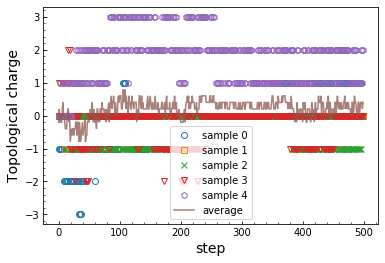

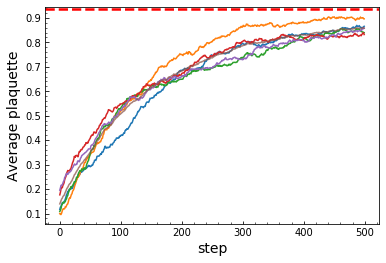

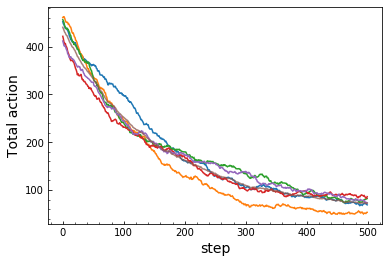

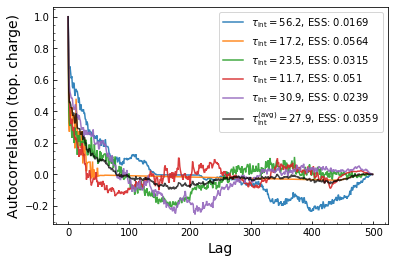

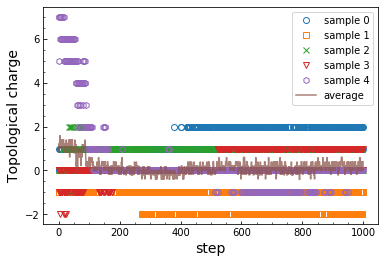

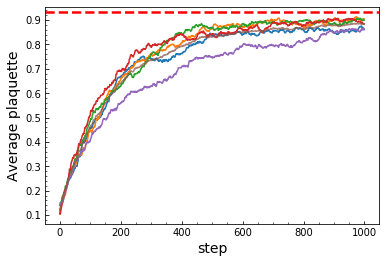

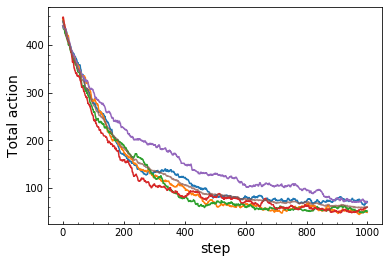

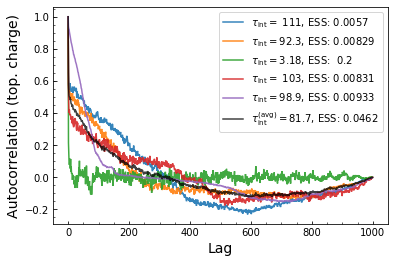

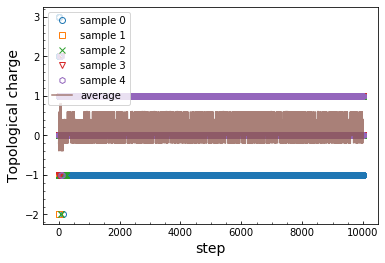

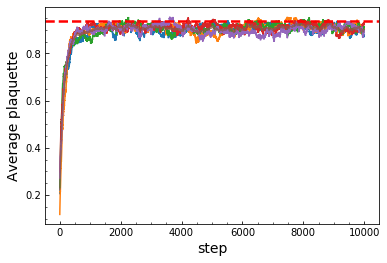

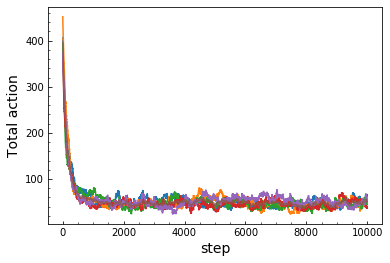

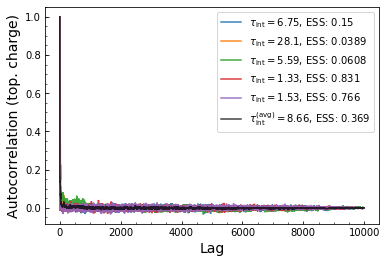

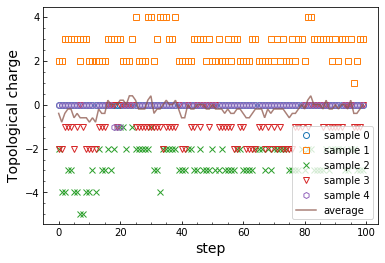

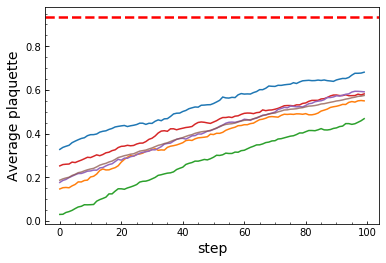

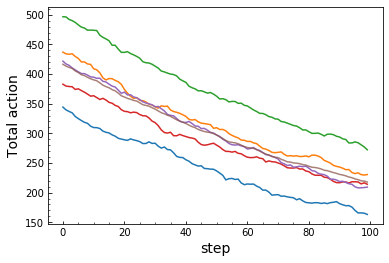

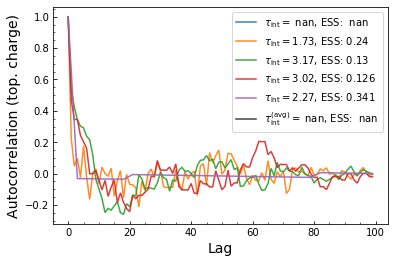

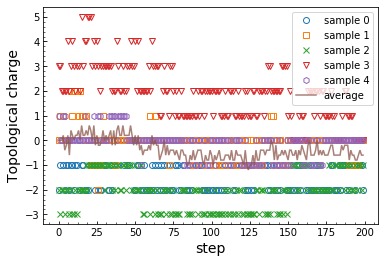

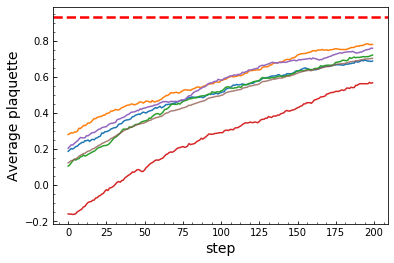

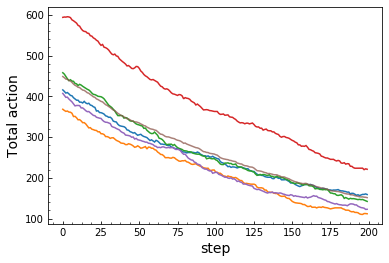

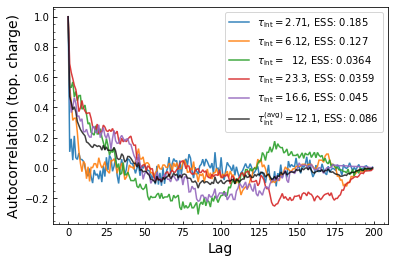

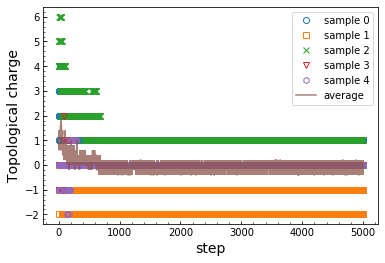

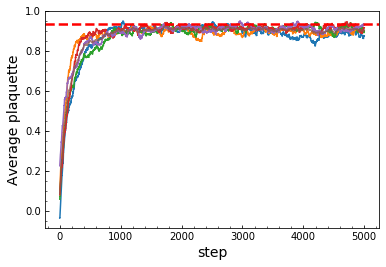

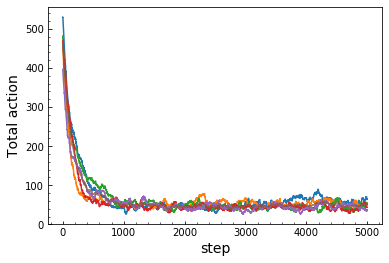

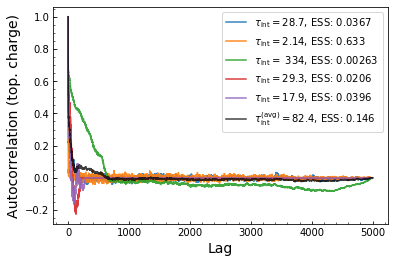

In [47]:
for key in observables.keys():
    _figs_dir = figs_dir_dict[key]
    _actions = actions[key]
    _avg_plaquettes = avg_plaquettes[key]
    _top_charges = top_charges[key]
    _top_charges_autocorr = top_charges_autocorr[key]
    _observables = (_actions, _avg_plaquettes, _top_charges)
    
    figs_axes = make_multiple_lines_plots(
        _figs_dir, 
        params['beta_final'], 
        _observables
    )
    
    _acf_arr = acf_dict[key]
    _iat_arr = iat_dict[key]
    _ess_arr = ess_dict[key]
    fig, ax = _plot_individual_acf_iat(_acf_arr, _iat_arr, _ess_arr, _figs_dir)

#### Topological charge history

Making directory: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_figs.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_figs.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_96/figures/figures_10000/top_charges_figs.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_10000/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_10000/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_10000/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_10000/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_10000/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_96/figures/figures_100/top_charges_figs.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_100/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_100/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_100/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_100/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_100/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_figs.


/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_figs/top_charge_history_sample_4.pdf.
Making directory: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_figs.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_figs/top_charge_history_sample_0.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_figs/top_charge_history_sample_1.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_figs/top_charge_history_sample_2.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_figs/top_charge_history_sample_3.pdf.


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_figs/top_charge_history_sample_4.pdf.


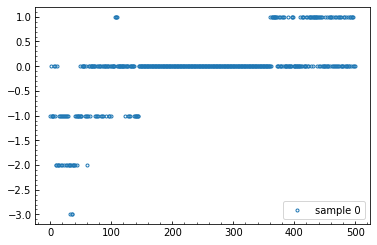

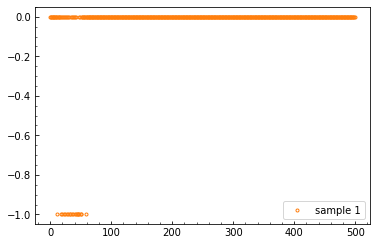

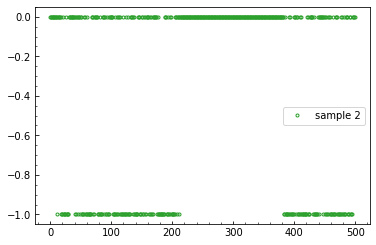

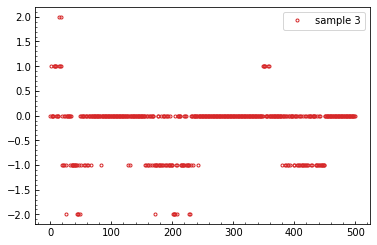

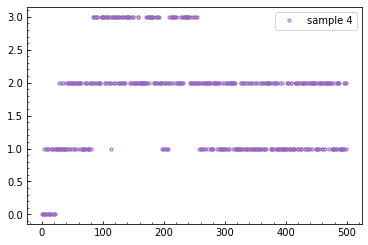

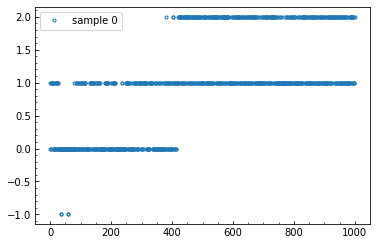

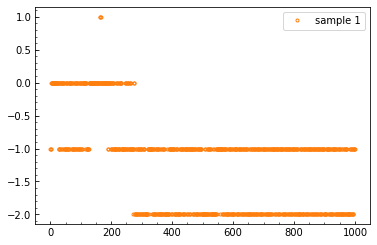

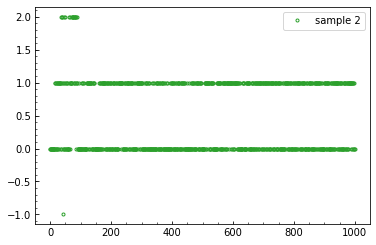

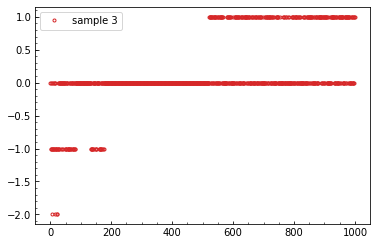

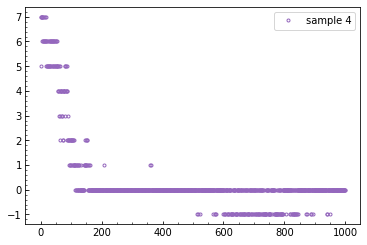

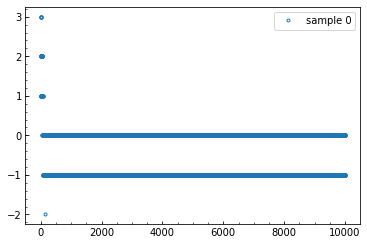

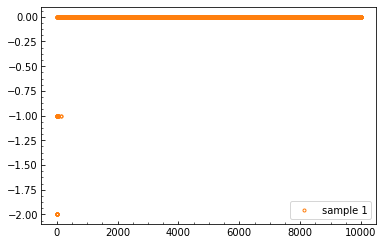

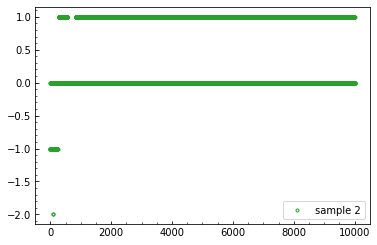

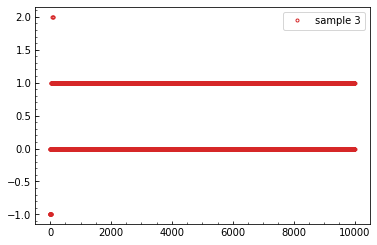

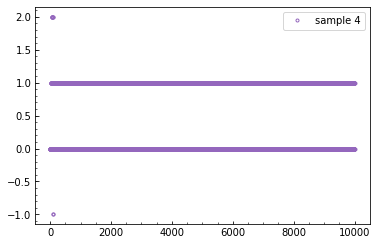

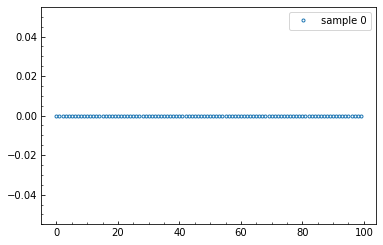

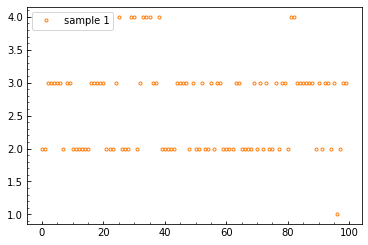

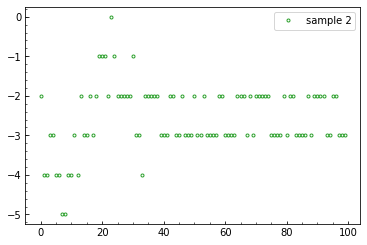

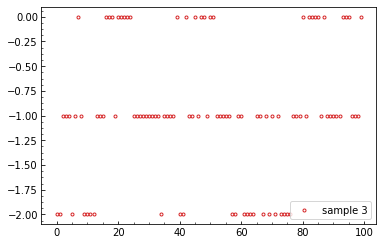

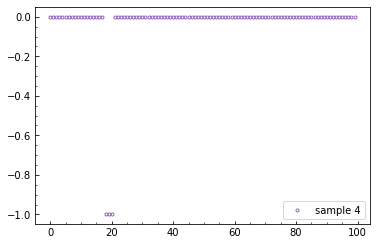

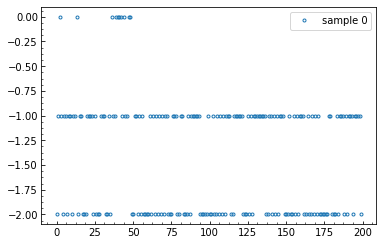

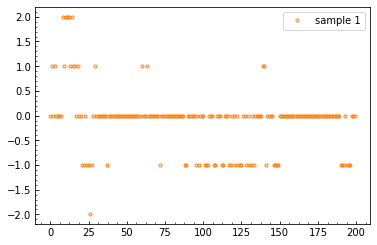

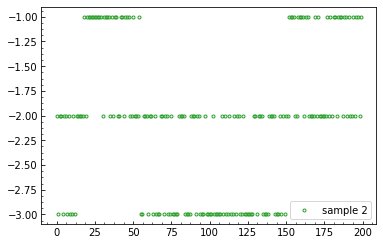

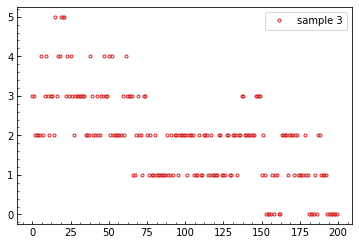

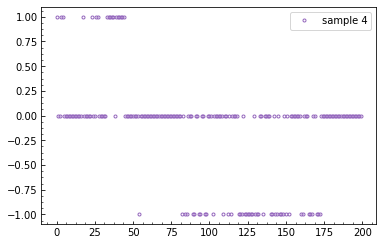

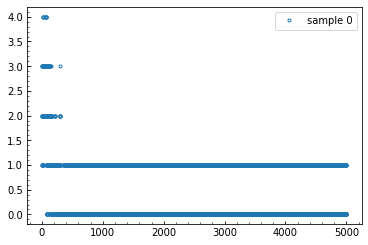

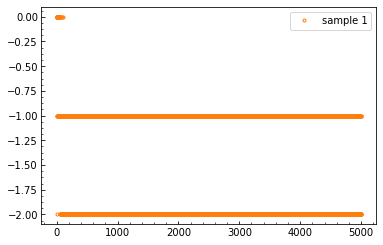

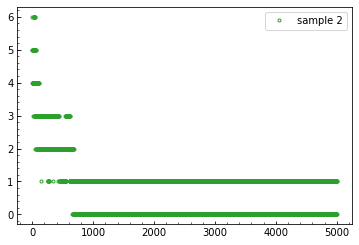

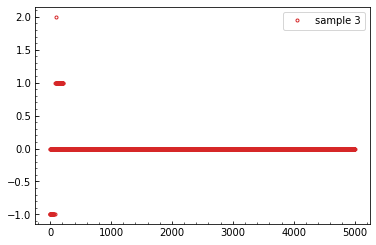

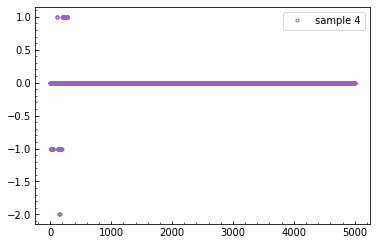

In [48]:
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_figs')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        plt.plot(val[:, idx], label=f'sample {idx}', 
                 color=COLORS[idx], marker='.', fillstyle='none', ls='')
        ax.legend(loc='best')
        out_file = os.path.join(fig_dir, 
                                f'top_charge_history_sample_{idx}.pdf')
        print(f'Saving figure to: {out_file}.')
        plt.savefig(out_file, dpi=400, bbox_inches='tight')

#### Histograms for topological charge

Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500/top_charges_histograms/top_charge_history_sample_4_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_1000/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_100

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_histograms/top_charge_history_sample_2_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_histograms/top_charge_history_sample_3_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_200/top_charges_histograms/top_charge_history_sample_4_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_histograms/top_charge_history_sample_0_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_5000/top_charges_histograms/top_charge_history_sample_1_histogram.pdf
Saving figure to: ../../gauge_logs_graph/run_96/figures/figures_500

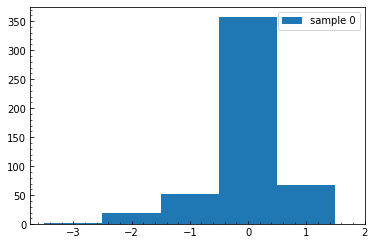

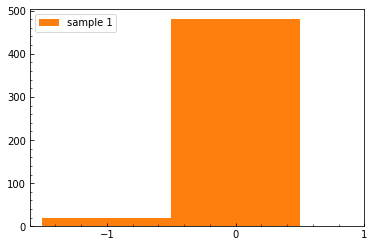

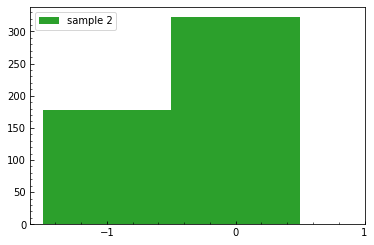

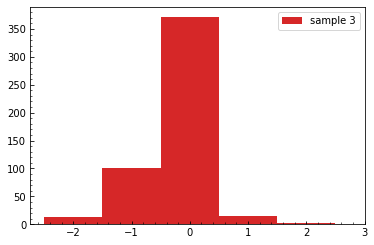

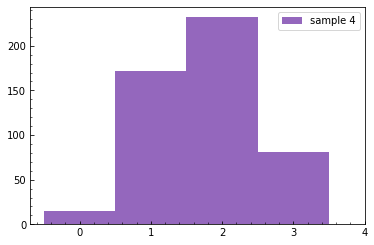

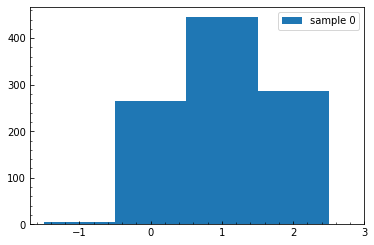

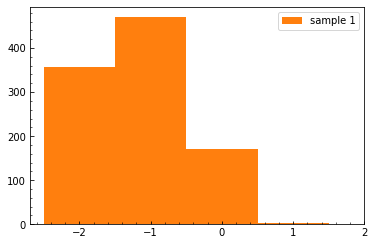

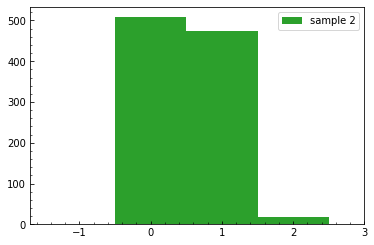

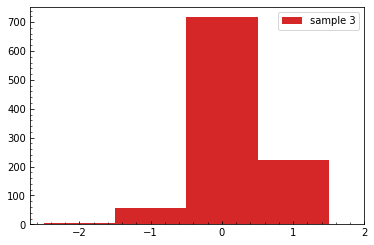

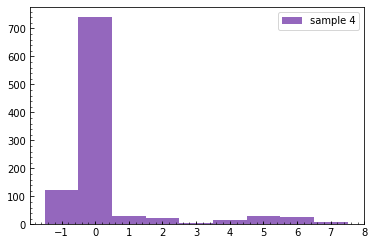

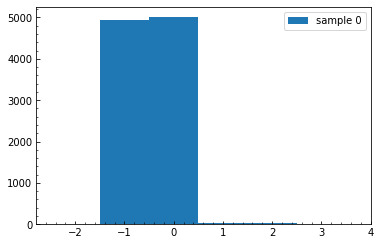

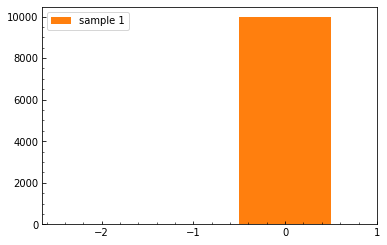

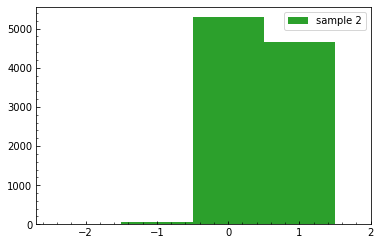

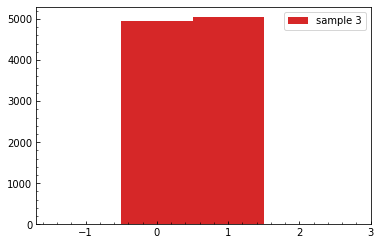

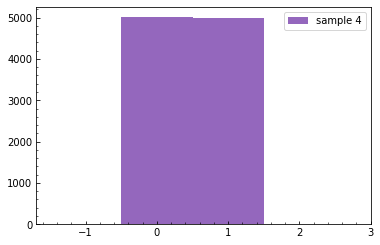

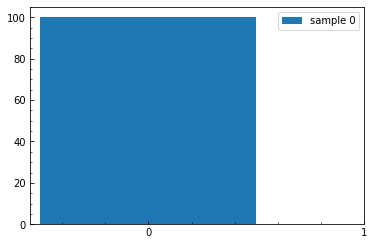

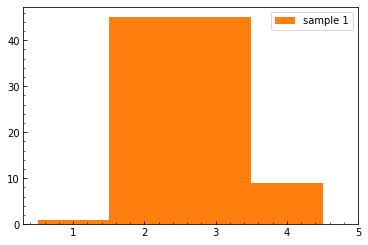

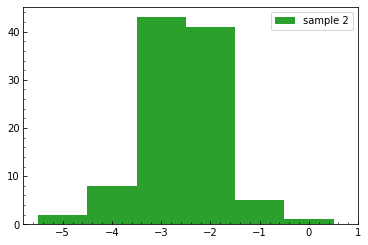

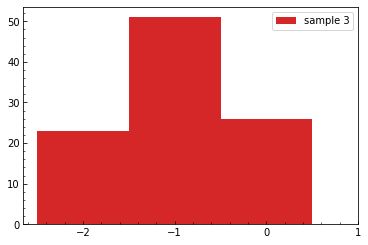

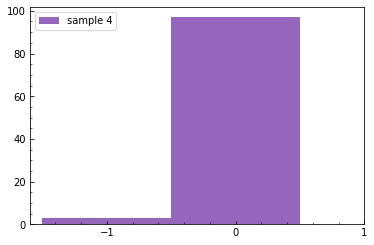

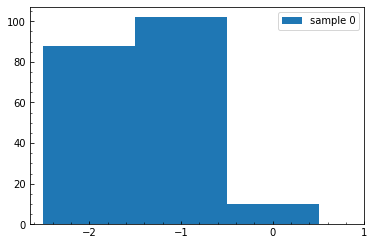

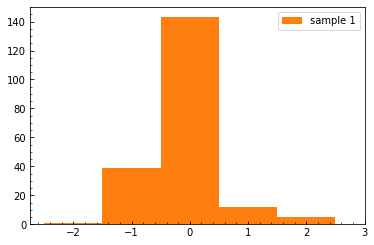

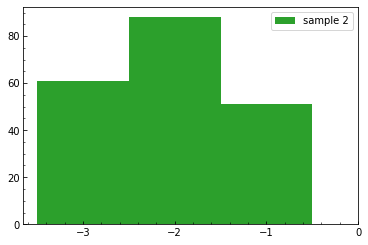

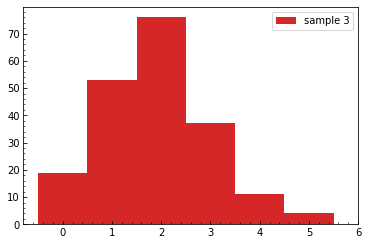

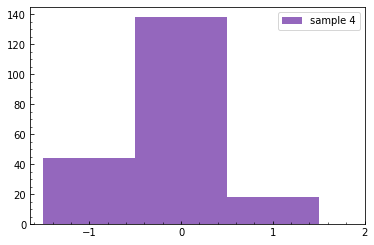

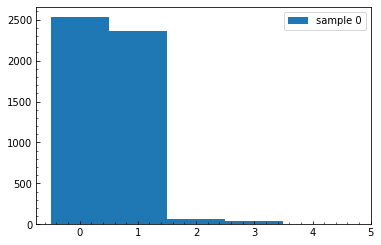

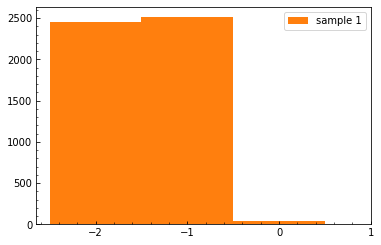

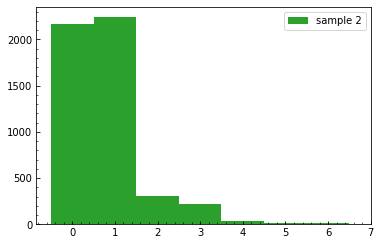

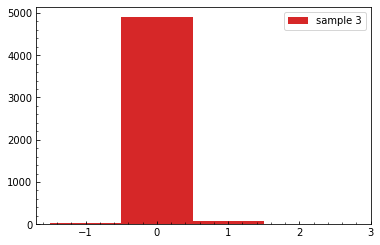

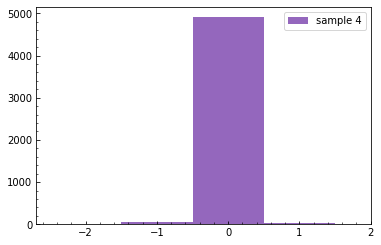

In [50]:
plt.close('all')
for key, val in top_charges.items():
    root_dir = figs_dir_dict[key]
    fig_dir = os.path.join(root_dir, 'top_charges_histograms')
    check_else_make_dir(fig_dir)
    for idx in range(val.shape[1]):
        fig, ax = plt.subplots()
        # the trick is to set up the bins centered on the integers, i.e.
        # -0.5, 0.5, 1,5, 2.5, ... up to max(data) + 1.5. 
        # Then you substract -0.5 to # eliminate the extra bin at the end.
        bins = np.arange(val[:, idx].min(), val[:, idx].max() + 1.5) - 0.5
        _ = ax.hist(
            val[:, idx], 
            bins, 
            color=COLORS[idx], 
            label=f'sample {idx}'
        )
        _ = ax.set_xticks(bins + 0.5)
        #ax.hist(val[:, idx])
        _ = ax.legend(loc='best')
        out_file = os.path.join(
            fig_dir, 
            f'top_charge_history_sample_{idx}_histogram.pdf'
        )
        print(f'Saving figure to: {out_file}')
        plt.savefig(out_file, dpi=400, bbox_inches='tight')

### OLD PLOTS

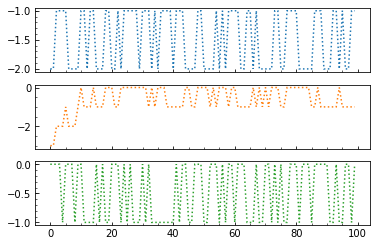

In [28]:
ax1 = plt.subplot(311)
_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(312, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(313, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
#_ = plt.setp(ax3.get_xticklabels(), visible=False)

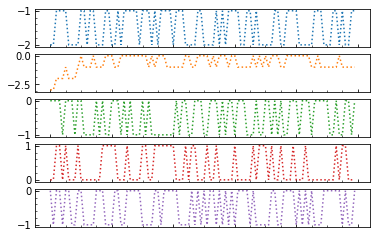

In [27]:
MARKERS = ['o', 's', 'x', 'v', 'h', '^', 'p', '<', 'd', '>', 'o']
LINESTYLES = ['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']

ax1 = plt.subplot(511)

_ = plt.plot(top_charges[100][:, 0], label=f'sample 1', color='C0', ls=':')
             #markersize=2.5, marker=MARKERS[0], ls=':')
_ = plt.setp(ax1.get_xticklabels(), visible=False)

# share x only
_ = ax2 = plt.subplot(512, sharex=ax1)
_ = plt.plot(top_charges[100][:, 1], label=f'sample 2', color='C1', ls=':')
             #markersize=2.5, marker=MARKERS[1], ls=':')
_ = plt.setp(ax2.get_xticklabels(), visible=False)

_ = ax3 = plt.subplot(513, sharex=ax1)
_ = plt.plot(top_charges[100][:, 2], label=f'sample 3', color='C2', ls=':')
             #markersize=2.5, marker=MARKERS[2], ls=':')
_ = plt.setp(ax3.get_xticklabels(), visible=False)

_ = ax4 = plt.subplot(514, sharex=ax1)
_ = plt.plot(top_charges[100][:, 3], label=f'sample 4', color='C3', ls=':')
             #markersize=2.5, marker=MARKERS[3], ls=':')
_ = plt.setp(ax4.get_xticklabels(), visible=False)

_ = ax5 = plt.subplot(515, sharex=ax1)
_ = plt.plot(top_charges[100][:, 4], label=f'sample 5', color='C4', ls=':')
             #markersize=2.5, marker=MARKERS[4], ls=':')
_ = plt.setp(ax5.get_xticklabels(), visible=False)

out_file = os.path.join(figs_dir_dict[100], 'top_charges_sharedx.pdf')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [116]:
plt.close('all')

In [ ]:
# Create plots for observables.
multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

    
# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/topological_charge_autocorr_fn_broken_xaxis.pdf.
Saving figure to ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/average_action_vs_step_broken_xaxis.pdf.
Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/eight_by_eight/ConvNet/runs/run_L8_b8_s10_e01_t5k_c10_CONV_69/figures/autocorrelation_plots/pandas_autocorrel

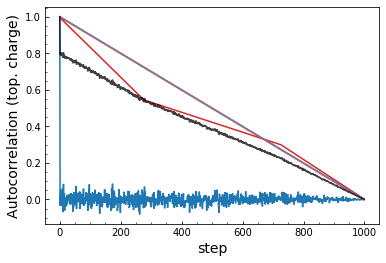

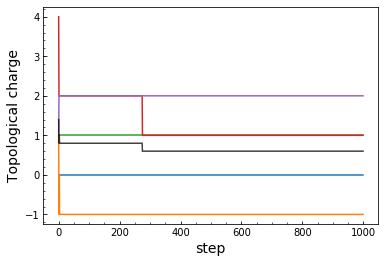

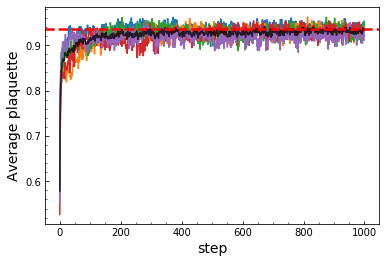

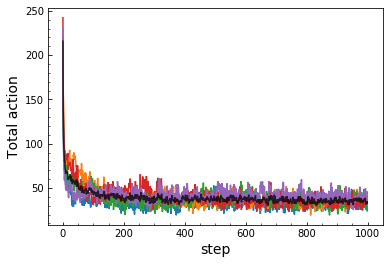

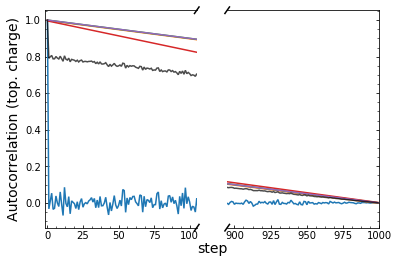

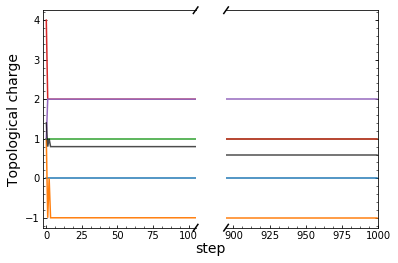

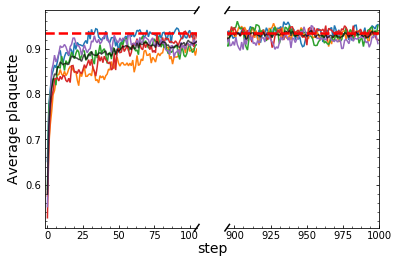

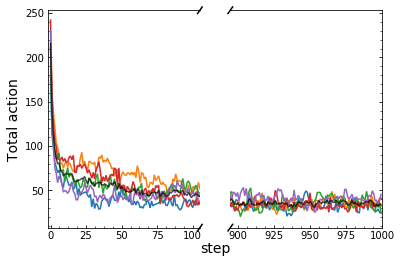

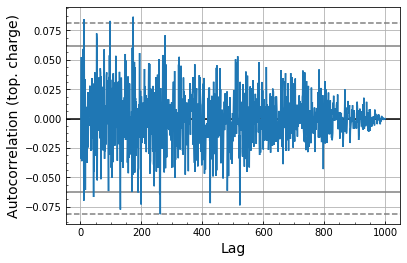

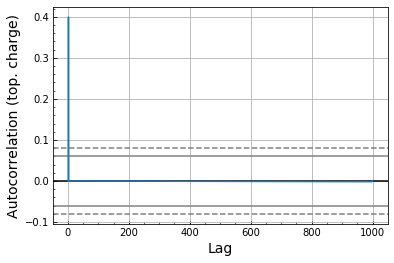

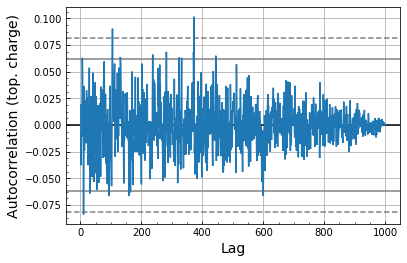

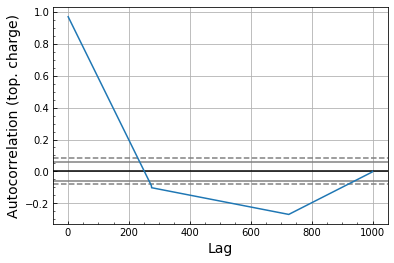

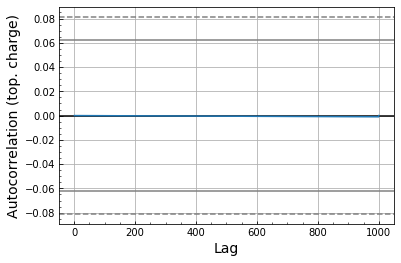

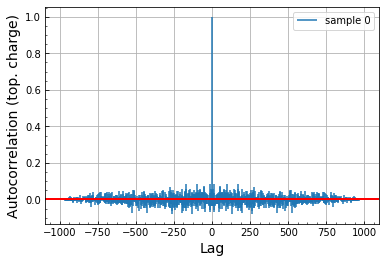

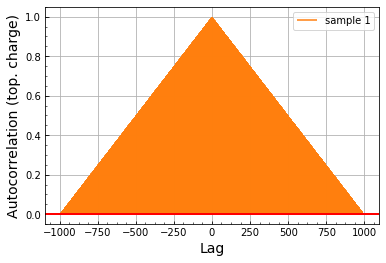

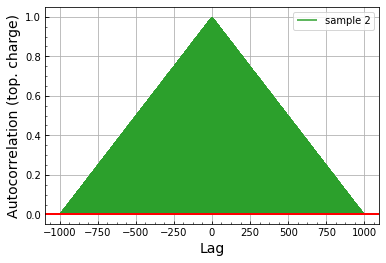

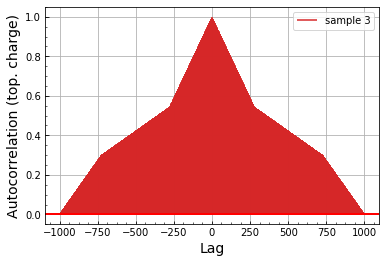

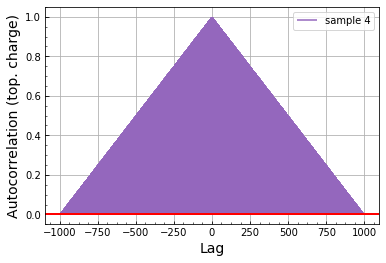

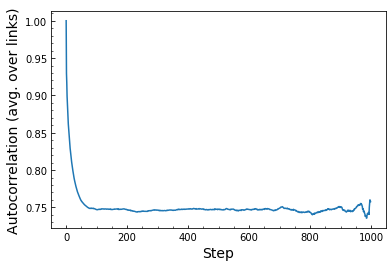

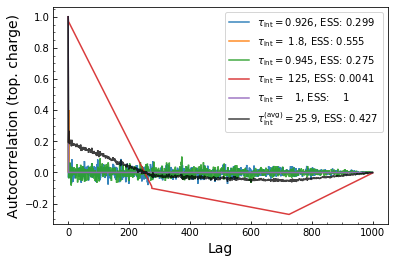

In [8]:
# Create plots for observables.

multiple_lines_figs_axes = make_multiple_lines_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Create plots for observables with broken x-axes.
broken_xaxis_figs_axes = make_broken_xaxis_plots(
    figs_dir,
    params['beta'],
    observables,
    top_charges_autocorr,
    legend=False
)

# Plot lag k autocorrelation function of topological charge
# Plot topological charges autocorrelation function using the 
# built-in `pandas.plotting.autocorrelation_plot` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        pandas_autocorr_dir, 
        f'top_charges_autocorr_pandas_{idx}.pdf'
    )
    fig, ax = make_pandas_autocorrelation_plot(
        top_charges[:, idx],
        x_label='Lag',
        y_label='Autocorrelation (top. charge)',
        out_file=out_file
    )
    
# Plot topological charges autocorrelation function using the 
# built-in matplotlib `acorr` method.
for idx in range(top_charges.shape[1]):
    out_file = os.path.join(
        matplotlib_autocorr_dir, 
        f'top_charges_autocorr_matplotlib_{idx}.pdf'
    )
    kwargs = {'x_label': 'Lag',
              'y_label': 'Autocorrelation (top. charge)',
              'label': f'sample {idx}',
              'out_file': out_file,
              'color': COLORS[idx]}
    output = make_matplotlib_autocorrelation_plot(
        top_charges[:, idx],
        **kwargs
    )
    
# Compute and plot the samples autocorrelation spectrum.
# This is done by computing the autocorrelation function of each 
# individual link and then averaging over all links in the sample.
out_file = os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf')
fig, ax = make_samples_acl_spectrum_plot(samples, out_file=out_file)

# Compute the integrated autocorrelation time (IAT) 
# from top. charges data using `tau` from `utils/gauge_observables`
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)
#fig, ax = calc_integrated_autocorr_time_with_plots(top_charges, **kwargs)
#_ = ax.legend(bbox_to_anchor=(1, 0), loc="lower left",
#              bbox_transform=ax.transAxes, columnspacing=0.5, ncol=1)
#print(f"Saving figure to: {out_file}")
#plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [81]:
plt.close('all')

Saving figure to: ../../gauge_logs_graph/run_19/figures/integrated_autocorrelation_time_plot.pdf.


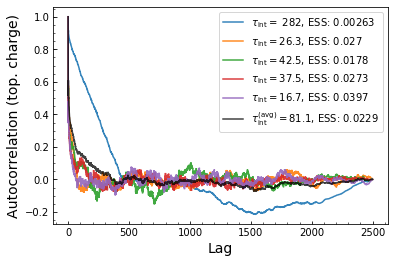

In [24]:
out_file = os.path.join(figs_dir, 'integrated_autocorrelation_time_plot.pdf')
kwargs = {
    'x_label': 'Lag',
    'y_label': 'Autocorrelation (top. charge)',
    'legend': True,
    'out_file': out_file
}
fig, ax = plot_autocorr_with_iat(acf_arr, iat_arr, ESS_arr, **kwargs)

# OLD

In [ ]:
np.mean(ESS_arr)

Saving figure to: ../../gauge_logs_graph/gauge_logs_by_size/sixteen_by_sixteen/run_40/figures/autocorrelation_plots/matplotlib_autocorrelation_plots/top_charges_autocorr_matplotlib.pdf.


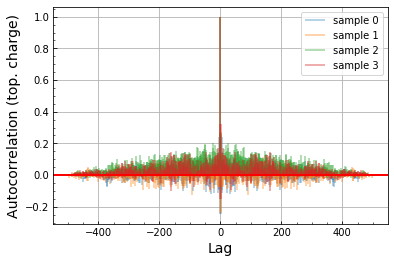

In [224]:
alphas = [0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 
          0.15, 0.125, 0.1, 0.075, 0.05, 0.025][::-1]
out_file = os.path.join(matplotlib_autocorr_dir, 
                        'top_charges_autocorr_matplotlib.pdf')
fig, ax = plt.subplots()
for idx in range(top_charges.shape[1]):
    output = ax.acorr(top_charges[:, idx], usevlines=True, color=COLORS[idx],
                      normed=True, maxlags=None,
                      alpha=alphas[idx]+0.4, #zorder=zorders[idx],
                      label=f'sample {idx}')

_ = ax.axhline(0, color='r', lw=2)
_ = ax.grid(True)
_ = ax.legend(loc='best')
    
_ = ax.set_xlabel("Lag", fontsize=14)
_ = ax.set_ylabel("Autocorrelation (top. charge)", fontsize=14)
print(f'Saving figure to: {out_file}.')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [300]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 5, False)

In [301]:
lattice.num_links

128

##### Old approach (unsure of validity)

In [25]:
len_by_4 = len(top_charges) // 4
len_by_2 = len(top_charges) // 2
len_by_10 = len(top_charges) // 10
kappa4 = len(top_charges) - len_by_4
kappa2 = len(top_charges) - len_by_2
kappa10 = len(top_charges) - len_by_10
iac2, autocorr2 = calc_iat(top_charges.mean(axis=1), kappa=kappa2)
iac4, autocorr4 = calc_iat(top_charges.mean(axis=1), kappa=kappa4)
iac10, autocorr10 = calc_iat(top_charges.mean(axis=1), kappa=kappa10)

In [26]:
iac2, iac4, iac10

(2.1520862694468614, 1.5014179402207577, 1.9374474465140532)

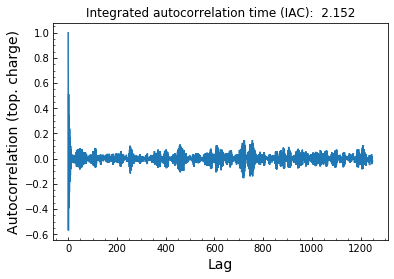

In [27]:
out_file = os.path.join(autocorr_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa2}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr2)), autocorr2, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac2:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

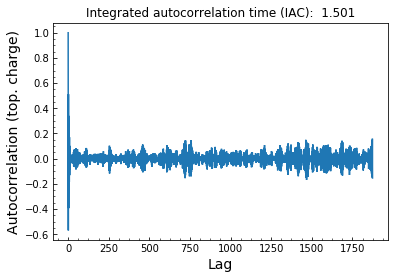

In [28]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa4}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr4)), autocorr4, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac4:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

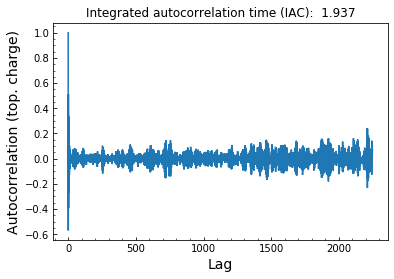

In [29]:
out_file = os.path.join(figs_dir, 
                        f'integrated_autocorrelation_time_plot_{kappa10}.pdf')

fig, ax = plt.subplots()
_ = ax.plot(np.arange(len(autocorr10)), autocorr10, ls='-')
_ = ax.set_xlabel('Lag', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (top. charge)', fontsize=14)
_ = ax.set_title(f'Integrated autocorrelation time (IAC): {iac10:6.4g}')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

## Old method (make each plot by hand)

### Specify run directory containing parameters and samples 

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [ ]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [ ]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [ ]:
np.array(samples_history).shape

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
samples_history = np.array(samples_history)
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [ ]:
len(samples_history[0].shape)

In [ ]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

In [ ]:
top_charges_autocorr_arr.shape

In [ ]:
top_charges_autocorr_avg.shape

In [ ]:
samples_history = np.array(samples_history)
_shape = samples_history.shape
samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
num_samples = samples_history.shape[1]
num_links  = samples_history.shape[-1]
samples_autocorr_arr = []
for n in range(num_samples):
    links_autocorr_arr = []
    for l in range(num_links):
        links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
    samples_autocorr_arr.append(links_autocorr_arr)
samples_autocorr_arr = np.array(samples_autocorr_arr)
samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)

In [ ]:
samples_history.shape

In [ ]:
samples_autocorr_arr.shape

In [ ]:
samples_autocorr_arr_avg.shape

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_autocorr_arr,
                              x_label='step', 
                              y_label='Autocorrelation (top. charge)',
                              legend=True,
                              out_file=out_file)

In [ ]:
len(steps)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_autocorr_fn_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='step',
                                 ylabel='Autocorrelation (top. charge)',
                                 #xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, top_charges_history.T,
                              x_label='step', y_label='Topological charge',
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 
                        'topological_charge_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 100), xlim2=(895, 1000),
                                 output_file=None)
ax2.legend(loc='lower right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
from lattice.gauge_lattice import u1_plaq_exact

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, avg_plaquettes_history.T,
                              x_label='step', y_label='Average plaquette')
_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 65), xlim2=(895, 1000),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax = plot_multiple_lines(steps, actions_history.T,
                              x_label='step', y_label='Average plaquette')
fig.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
out_file = os.path.join(figs_dir, 'average_action_vs_step_broken_xaxis.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(895, 1000),
                                 output_file=out_file)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_acl_spectrum = acl_spectrum(samples_history, scale=1)
acl_steps = np.arange(len(samples_acl_spectrum))
fig, ax = plt.subplots()
ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0])
ax.set_xlabel('step', fontsize=14)
ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
            dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils.gauge_observables import *

In [ ]:
log_dir = '../../gauge_logs_graph/run_2/'

In [ ]:
params, samples, observables = calc_observables_from_log_dir(log_dir)

In [ ]:
actions, avg_plaquettes, top_charges = observables

beta = params['beta']
figs_dir = os.path.join(log_dir, 'figures')

In [ ]:
top_charges_autocorr, _ = calc_top_charges_autocorr(top_charges)
samples_autocorr, _ = calc_samples_autocorr(samples)

In [ ]:
from utils.gauge_observables import _make_plots

In [ ]:
multiple_lines_figs_axes, broken_xaxis_figs_axes = _make_plots(
    figs_dir, 
    beta, 
    samples, 
    observables,
    top_charges_autocorr, 
    samples_autocorr
)

In [ ]:
make_plots_from_log_dir(log_dir)

## Compare Sample Autocorrelation across runs

In [ ]:
_dir = '../../gauge_logs_graph/'
dirs = [
    os.path.join(_dir, i) for i in os.listdir(_dir) if i .startswith('run')
]

In [ ]:
samples_dict = {}
params_dict = {}
lattice_dict = {}
for d in dirs:
    key = d.split('/')[-1]
    info_dir = os.path.join(d, 'run_info')
    samples_file = os.path.join(info_dir, 'samples_history.pkl')
    parameters_file = os.path.join(info_dir, 'parameters.pkl')
    try:
        with open(samples_file, 'rb') as f:
            samples_dict[key] = pickle.load(f)
        with open(parameters_file, 'rb') as f:
            params_dict[key] = pickle.load(f)
        lattice_dict[key] = GaugeLattice(time_size=params['time_size'],
                                         space_size=params['space_size'],
                                         dim=params['dim'],
                                         beta=params['beta'],
                                         link_type=params['link_type'],
                                         num_samples=params['num_samples'],
                                         rand=params['rand'])
    except FileNotFoundError:
        continue

In [ ]:
samples_autocorr_dict = {}
samples_autocorr_avg_dict = {}
samples_acl_spectrum_dict = {}
for key, samples_history in samples_dict.items():
    samples_history = np.array(samples_history)
    _shape = samples_history.shape
    samples_history = samples_history.reshape(_shape[0], _shape[1], -1)
    num_samples = samples_history.shape[1]
    num_links  = samples_history.shape[-1]
    samples_autocorr_arr = []
    for n in range(num_samples):
        links_autocorr_arr = []
        for l in range(num_links):
            links_autocorr_arr.append(autocorr(samples_history[:, n, l]))
        samples_autocorr_arr.append(links_autocorr_arr)
    samples_autocorr_arr = np.array(samples_autocorr_arr)
    samples_autocorr_arr_avg = samples_autocorr_arr.mean(axis=1)
    samples_autocorr_dict[key] = samples_autocorr_arr
    samples_autocorr_avg_dict[key] = samples_autocorr_arr_avg
    samples_acl_spectrum_dict[key] = acl_spectrum(samples_history, scale=1)

In [ ]:
samples_autocorr_avg_dict['run_37'].mean(axis=0).shape

In [ ]:
fig, ax = plt.subplots()
for key, samples_autocorr_avg in samples_autocorr_avg_dict.items():
    autocorr_avg_over_samples = samples_autocorr_avg.mean(axis=0)
    steps = np.arange(len(autocorr_avg_over_samples))
    _ = ax.plot(steps, autocorr_avg_over_samples, label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
_ = plt.show()

In [ ]:
fig, ax = plt.subplots()
for key, samples_acl_spectrum in samples_acl_spectrum_dict.items():
    acl_steps = np.arange(len(samples_acl_spectrum))
    _ = ax.plot(acl_steps, samples_acl_spectrum/samples_acl_spectrum[0], 
                label=f'{key}')
_ = ax.set_xlabel('step', fontsize=14)
_ = ax.set_ylabel('Autocorrelation (avg. over links)', fontsize=14)
_ = ax.legend(loc='best')
#plt.savefig(os.path.join(figs_dir, 'links_autocorrelation_vs_step.pdf'),
#            dpi=400, bbox_inches='tight')
plt.show()

### Incorrect

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum.pdf')
fig, ax = plot_multiple_lines(x_data=steps, 
                              y_data=samples_autocorr_arr[0, 0:20],
                              x_label='step',
                              y_label='Autocorrelation (links)',
                              legend=False,
                              out_file=out_file)

In [ ]:
out_file = os.path.join(figs_dir, 'samples_acl_spectrum_avg.pdf')
fig, ax = plot_multiple_lines(x_data=steps,
                              y_data=samples_autocorr_arr_avg,
                              x_label='step',
                              y_label='Autocorrelation (avg. over links)',
                              semilogy=False,
                              legend=True,
                              out_file=out_file)

## OLD

In [ ]:
tf.InteractiveSession.close

In [ ]:
tf.Session().close()

In [ ]:
#sess = tf.InteractiveSession()

In [ ]:
tf.reset_default_graph()

In [ ]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [ ]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [ ]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [ ]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [ ]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [ ]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [ ]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [ ]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [ ]:
dataset.output_shapes

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [ ]:
dataset.apply(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [ ]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [ ]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [ ]:
dataset

In [ ]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

In [ ]:
iterator = dataset.make_initializable_iterator()

In [ ]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

In [ ]:
next_element = iterator.get_next()

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
sess.run(result)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})